In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Input,InputLayer, Concatenate, concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from plot_keras_history import show_history, plot_history
import keras
import pydot
import graphviz

In [3]:
df = pd.read_csv('E:\\My files\\Dr Buzna\\trips\\NN\\NN-based_distance\\tripdf_ps_sps.csv', index_col=0)
print(df.shape)
df.tail()

(7613, 9)


travel time  real travel time  euc_dist   distance  hour of day  \
7608          945             959.0  0.107211  15008.896           18   
7609          935             947.0  0.107057  13358.373           10   
7610         1122            1123.0  0.115149  13258.039           16   
7611         1285            1297.0  0.139229  22855.665           19   
7612          499             513.0  0.049942   6495.842           20   

          O lat      O lon      D lat      D lon  
7608  49.395685  18.833549  49.300166  18.784862  
7609  49.202115  18.742075  49.300241  18.784883  
7610  49.214893  18.707550  49.300209  18.784883  
7611  49.438987  18.772888  49.300274  18.784862  
7612  49.338500  18.817027  49.300295  18.784862

In [4]:
# df = pd.merge(df0,df3, on = ['travel time','distance','hour of day'])

df = df.drop(['travel time','euc_dist'],axis=1)
df.rename(columns = {'real travel time':'travel time'}, inplace = True)
df = pd.concat([df.iloc[:,-5:].reset_index(drop=True) , df.iloc[:,0:-5].reset_index(drop=True)] , axis=1)
df.head(2)
df.columns

Index(['hour of day', 'O lat', 'O lon', 'D lat', 'D lon', 'travel time',
       'distance'],
      dtype='object')

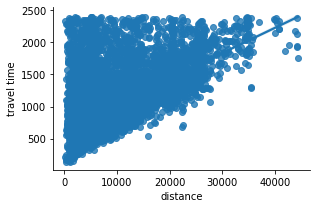

In [5]:
sns.lmplot(x='distance',y='travel time',data=df, height=3, aspect=1.5)

In [5]:
# outlier removal
from scipy import stats
df = df[(np.abs(stats.zscore(df['distance'])) < 3)]

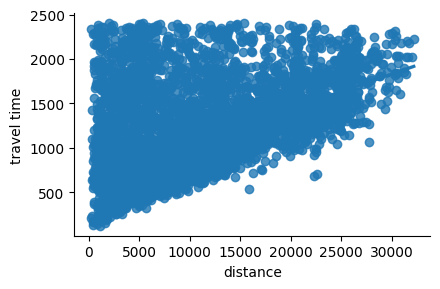

In [7]:
sns.lmplot(x='distance',y='travel time',data=df, height=3, aspect=1.5)

In [6]:
# Normalize using Min/Max Normalization.
normalized_Olat=(df['O lat']-df['O lat'].min())/(df['O lat'].max()-df['O lat'].min())
df['O lat'] = normalized_Olat
normalized_Dlat=(df['D lat']-df['D lat'].min())/(df['D lat'].max()-df['D lat'].min())
df['D lat'] = normalized_Dlat
normalized_Olon=(df['O lon']-df['O lon'].min())/(df['O lon'].max()-df['O lon'].min())
df['O lon'] = normalized_Olon
normalized_Dlon=(df['D lon']-df['D lon'].min())/(df['D lon'].max()-df['D lon'].min())
df['D lon'] = normalized_Dlon
normalized_Dist=(df['distance']-df['distance'].min())/(df['distance'].max()-df['distance'].min())
df['distance'] = normalized_Dist
df['hr_sin'] = np.sin(df['hour of day']*(2.*np.pi/24))
df['hr_cos'] = np.cos(df['hour of day']*(2.*np.pi/24))
df

hour of day     O lat     O lon     D lat     D lon  travel time  \
0              17  0.226469  0.594793  0.270017  0.694257       1577.0   
1              23  0.226874  0.595348  0.269923  0.694607       1310.0   
2               6  0.476922  0.402574  0.268022  0.695229        846.0   
3              14  0.442295  0.373628  0.269434  0.694685       1094.0   
4              17  0.493186  0.400356  0.270292  0.694607        767.0   
...           ...       ...       ...       ...       ...          ...   
7608           18  0.796339  0.494560  0.602275  0.552689        959.0   
7609           10  0.449069  0.396082  0.602489  0.552728        947.0   
7610           16  0.471993  0.358914  0.602398  0.552728       1123.0   
7611           19  0.874024  0.429254  0.602584  0.552689       1297.0   
7612           20  0.693747  0.476773  0.602644  0.552689        513.0   

      distance    hr_sin        hr_cos  
0     0.612791 -0.965926 -2.588190e-01  
1     0.577763 -0.258819  9.659258e-01  
2     0.352414  1.000000  6.123234e-17  
3     0.446486 -0.500000 -8.660254e-01  
4     0.307363 -0.965926 -2.588190e-01  
...        ...       ...           ...  
7608  0.463545 -1.000000 -1.836970e-16  
7609  0.411958  0.500000 -8.660254e-01  
7610  0.408822 -0.866025 -5.000000e-01  
7611  0.708796 -0.965926  2.588190e-01  
7612  0.197469 -0.866025  5.000000e-01  

[7527 rows x 9 columns]

In [9]:
# df['distance'] = df['distance']/1000 #in km
# df['travel time'] = df['travel time']/60 #in minutes
# df

# Functional API keras model

In [7]:
np.random.seed(7)

In [23]:
def nnmodel(*num_neuron,num_hlayers,Epoch):

    if num_hlayers == 1:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[1], activation='relu')(merge_two)
        second_dense = Dense(1, activation='relu',name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])
    elif num_hlayers == 2:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense  = Dense(num_neuron[1], activation='relu')(first_dense)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[2], activation='relu')(merge_two)
        second_dense = Dense(num_neuron[3], activation='relu')(second_dense)
        second_dense = Dense(1, activation='relu', name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])
    else:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense  = Dense(num_neuron[1], activation='relu')(first_dense)
        first_dense  = Dense(num_neuron[2], activation='relu')(first_dense)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[3], activation='relu')(merge_two)
        second_dense = Dense(num_neuron[4], activation='relu')(second_dense)
        second_dense = Dense(num_neuron[5], activation='relu')(second_dense)
        second_dense = Dense(1, activation='relu', name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])        

#     from keras.optimizers import SGD
#     opt = SGD(lr=0.01)
#     model.compile(loss = "categorical_crossentropy", optimizer = opt)       
        
    learning_rate = 0.5
    model.compile(optimizer='adam',
                  loss=[tf.keras.metrics.mean_squared_error,tf.keras.metrics.mean_squared_error],
                  loss_weights=[0.4,0.6],
                  metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#     model.compile(optimizer='adam',
#                   loss=tf.keras.metrics.mean_squared_error,
#                   metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    history = model.fit([X_train[:,0:4],X_train[:,4:]], [y_train[:,0],y_train[:,1]], verbose=1, epochs=Epoch,
                   validation_data=([X_test[:,0:4],X_test[:,4:]], [y_test[:,0],y_test[:,1]]))   
    
    print('minimum testing RMSE (distance): ',min(history.history['val_distance_layer_rmse'])/1000)
    print('minimum testing MAPE (distance): ',min(history.history['val_distance_layer_mape'])/100)
    print('-----------------')
    print('minimum testing ravel time): ',min(history.history['val_traveltime_layer_rmse'])/60)
    print('minimum testing MAPE (travel time): ',min(history.history['val_traveltime_layer_mape'])/100)
    
    return history

## sub-problem 1:     ******* input: [] *********

In [9]:
x = df.loc[:,['O lat','O lon','D lat','D lon']].values
y = df.loc[:,['distance','travel time']].values
# x

In [10]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [11]:
print(X_train.shape)
print(X_test.shape)
# X_train

(5268, 4)
(2259, 4)


In [15]:
def plotme(model):

    # Plot the training and validation accuracy and loss at each epoch
    loss1 = [f/60 for f in model.history['traveltime_layer_rmse']]
    val_loss1 = [f/60 for f in model.history['val_traveltime_layer_rmse']]
    loss2 = model.history['traveltime_layer_mape']
    val_loss2 = model.history['val_traveltime_layer_mape']
    val_loss2 = [x+1.8 for x in val_loss2]
    epochs = range(1, len(model.history['loss'])+1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, val_loss1, 'r', label='Validation rmse')
    plt.plot(epochs, loss1, 'y', label='Trainnig rmse')
    plt.plot(epochs, val_loss2, 'k', label='Validation mape')
    plt.plot(epochs, loss2, 'b', label='Trainnig mape')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    #plt.xlim(lims)
    yli = max(model.history['val_traveltime_layer_mape'])
    plt.ylim([-1, yli+10])
    plt.legend()
    plt.show()

In [25]:
# inputs: distance
model1_1 = nnmodel(5,5, num_hlayers=1,Epoch=500)
model1_1

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 796773.2500 - distance_layer_loss: 0.3215 - traveltime_layer_loss: 1327955.2500 - distance_layer_mape: 366922.9688 - distance_layer_rmse: 0.5670 - traveltime_layer_mape: 99.8293 - traveltime_layer_rmse: 1152.3694 - val_loss: 807192.9375 - val_distance_layer_loss: 1.7607 - val_traveltime_layer_loss: 1345320.2500 - val_distance_layer_mape: 940.3035 - val_distance_layer_rmse: 1.3269 - val_traveltime_layer_mape: 99.4312 - val_traveltime_layer_rmse: 1159.8794
Epoch 2/500
165/165 [==============================] - 0s 2ms/step - loss: 775738.3750 - distance_layer_loss: 13.7023 - traveltime_layer_loss: 1292888.3750 - distance_layer_mape: 849155.1250 - distance_layer_rmse: 3.7017 - traveltime_layer_mape: 97.8717 - traveltime_layer_rmse: 1137.0525 - val_loss: 763001.8125 - val_distance_layer_loss: 36.5600 - val_traveltime_layer_loss: 1271644.8750 - val_distance_layer_mape: 3980.9204 - val_distance_layer_rmse: 6.0465 - val

165/165 [==============================] - 0s 1ms/step - loss: 142299.6406 - distance_layer_loss: 1474.3990 - traveltime_layer_loss: 236183.1562 - distance_layer_mape: 8195157.0000 - distance_layer_rmse: 38.3979 - traveltime_layer_mape: 45.8470 - traveltime_layer_rmse: 485.9868 - val_loss: 149636.2969 - val_distance_layer_loss: 1448.1165 - val_traveltime_layer_loss: 248428.3438 - val_distance_layer_mape: 24509.9805 - val_distance_layer_rmse: 38.0541 - val_traveltime_layer_mape: 45.6556 - val_traveltime_layer_rmse: 498.4259
Epoch 17/500
165/165 [==============================] - 0s 995us/step - loss: 142149.4375 - distance_layer_loss: 1472.6450 - traveltime_layer_loss: 235933.8906 - distance_layer_mape: 8224693.5000 - distance_layer_rmse: 38.3751 - traveltime_layer_mape: 45.9838 - traveltime_layer_rmse: 485.7303 - val_loss: 149525.0469 - val_distance_layer_loss: 1440.2563 - val_traveltime_layer_loss: 248248.2656 - val_distance_layer_mape: 24448.5273 - val_distance_layer_rmse: 37.9507 - 

165/165 [==============================] - 0s 951us/step - loss: 140068.1719 - distance_layer_loss: 1375.0663 - traveltime_layer_loss: 232530.3281 - distance_layer_mape: 7840262.0000 - distance_layer_rmse: 37.0819 - traveltime_layer_mape: 45.8661 - traveltime_layer_rmse: 482.2140 - val_loss: 147570.2969 - val_distance_layer_loss: 1372.3269 - val_traveltime_layer_loss: 245035.5156 - val_distance_layer_mape: 23931.2031 - val_distance_layer_rmse: 37.0449 - val_traveltime_layer_mape: 46.5721 - val_traveltime_layer_rmse: 495.0106
Epoch 32/500
165/165 [==============================] - 0s 992us/step - loss: 139946.2188 - distance_layer_loss: 1375.7614 - traveltime_layer_loss: 232326.5312 - distance_layer_mape: 7846674.0000 - distance_layer_rmse: 37.0913 - traveltime_layer_mape: 46.1995 - traveltime_layer_rmse: 482.0026 - val_loss: 147669.9375 - val_distance_layer_loss: 1340.1320 - val_traveltime_layer_loss: 245223.1250 - val_distance_layer_mape: 23655.0625 - val_distance_layer_rmse: 36.6078 

165/165 [==============================] - 0s 939us/step - loss: 138644.1094 - distance_layer_loss: 1264.1653 - traveltime_layer_loss: 230230.8594 - distance_layer_mape: 7433974.0000 - distance_layer_rmse: 35.5551 - traveltime_layer_mape: 45.8864 - traveltime_layer_rmse: 479.8238 - val_loss: 146495.2031 - val_distance_layer_loss: 1246.7208 - val_traveltime_layer_loss: 243327.5156 - val_distance_layer_mape: 22869.8418 - val_distance_layer_rmse: 35.3089 - val_traveltime_layer_mape: 45.9232 - val_traveltime_layer_rmse: 493.2824
Epoch 47/500
165/165 [==============================] - 0s 988us/step - loss: 138539.3281 - distance_layer_loss: 1261.5121 - traveltime_layer_loss: 230057.8906 - distance_layer_mape: 7404690.0000 - distance_layer_rmse: 35.5178 - traveltime_layer_mape: 46.0956 - traveltime_layer_rmse: 479.6435 - val_loss: 146347.1406 - val_distance_layer_loss: 1248.9690 - val_traveltime_layer_loss: 243079.2031 - val_distance_layer_mape: 22893.1543 - val_distance_layer_rmse: 35.3408 

165/165 [==============================] - 0s 992us/step - loss: 137707.3281 - distance_layer_loss: 1167.4089 - traveltime_layer_loss: 228733.9375 - distance_layer_mape: 7184755.0000 - distance_layer_rmse: 34.1674 - traveltime_layer_mape: 46.0080 - traveltime_layer_rmse: 478.2614 - val_loss: 145806.5000 - val_distance_layer_loss: 1154.7340 - val_traveltime_layer_loss: 242241.0469 - val_distance_layer_mape: 22052.5996 - val_distance_layer_rmse: 33.9814 - val_traveltime_layer_mape: 46.1638 - val_traveltime_layer_rmse: 492.1799
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 137667.0312 - distance_layer_loss: 1162.2892 - traveltime_layer_loss: 228670.2500 - distance_layer_mape: 7127051.5000 - distance_layer_rmse: 34.0924 - traveltime_layer_mape: 46.0523 - traveltime_layer_rmse: 478.1948 - val_loss: 145750.8281 - val_distance_layer_loss: 1152.5310 - val_traveltime_layer_loss: 242149.7031 - val_distance_layer_mape: 22033.8105 - val_distance_layer_rmse: 33.9489 - 

165/165 [==============================] - 0s 970us/step - loss: 137245.0625 - distance_layer_loss: 1094.4500 - traveltime_layer_loss: 228012.2031 - distance_layer_mape: 6901572.0000 - distance_layer_rmse: 33.0825 - traveltime_layer_mape: 46.2198 - traveltime_layer_rmse: 477.5062 - val_loss: 145553.3906 - val_distance_layer_loss: 1077.5570 - val_traveltime_layer_loss: 241870.5938 - val_distance_layer_mape: 21332.3145 - val_distance_layer_rmse: 32.8262 - val_traveltime_layer_mape: 46.1089 - val_traveltime_layer_rmse: 491.8034
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 137240.1719 - distance_layer_loss: 1086.8262 - traveltime_layer_loss: 228009.1094 - distance_layer_mape: 6921594.5000 - distance_layer_rmse: 32.9670 - traveltime_layer_mape: 46.0857 - traveltime_layer_rmse: 477.5030 - val_loss: 145440.3750 - val_distance_layer_loss: 1083.2328 - val_traveltime_layer_loss: 241678.4531 - val_distance_layer_mape: 21388.5801 - val_distance_layer_rmse: 32.9125 - 

165/165 [==============================] - 0s 1ms/step - loss: 136995.1406 - distance_layer_loss: 1031.3119 - traveltime_layer_loss: 227637.7188 - distance_layer_mape: 6735962.0000 - distance_layer_rmse: 32.1140 - traveltime_layer_mape: 46.1107 - traveltime_layer_rmse: 477.1140 - val_loss: 145316.5781 - val_distance_layer_loss: 1030.8304 - val_traveltime_layer_loss: 241507.0469 - val_distance_layer_mape: 20882.3184 - val_distance_layer_rmse: 32.1065 - val_traveltime_layer_mape: 46.7303 - val_traveltime_layer_rmse: 491.4337
Epoch 92/500
165/165 [==============================] - 0s 1ms/step - loss: 137032.6406 - distance_layer_loss: 1030.5399 - traveltime_layer_loss: 227700.6719 - distance_layer_mape: 6723509.5000 - distance_layer_rmse: 32.1020 - traveltime_layer_mape: 46.2520 - traveltime_layer_rmse: 477.1799 - val_loss: 145338.3125 - val_distance_layer_loss: 1023.1625 - val_traveltime_layer_loss: 241548.4062 - val_distance_layer_mape: 20805.5977 - val_distance_layer_rmse: 31.9869 - va

165/165 [==============================] - 0s 1ms/step - loss: 136889.5469 - distance_layer_loss: 990.8668 - traveltime_layer_loss: 227488.7344 - distance_layer_mape: 6557805.0000 - distance_layer_rmse: 31.4780 - traveltime_layer_mape: 46.3027 - traveltime_layer_rmse: 476.9578 - val_loss: 145319.0625 - val_distance_layer_loss: 979.7874 - val_traveltime_layer_loss: 241545.1719 - val_distance_layer_mape: 20370.9688 - val_distance_layer_rmse: 31.3016 - val_traveltime_layer_mape: 46.3546 - val_traveltime_layer_rmse: 491.4724
Epoch 107/500
165/165 [==============================] - 0s 939us/step - loss: 136872.6250 - distance_layer_loss: 985.1705 - traveltime_layer_loss: 227464.2188 - distance_layer_mape: 6604508.5000 - distance_layer_rmse: 31.3874 - traveltime_layer_mape: 46.1425 - traveltime_layer_rmse: 476.9321 - val_loss: 145246.7969 - val_distance_layer_loss: 989.1144 - val_traveltime_layer_loss: 241418.5625 - val_distance_layer_mape: 20467.2656 - val_distance_layer_rmse: 31.4502 - val

165/165 [==============================] - 0s 1ms/step - loss: 136840.1875 - distance_layer_loss: 959.4506 - traveltime_layer_loss: 227427.2969 - distance_layer_mape: 6479841.0000 - distance_layer_rmse: 30.9750 - traveltime_layer_mape: 46.4644 - traveltime_layer_rmse: 476.8934 - val_loss: 145237.2969 - val_distance_layer_loss: 951.2365 - val_traveltime_layer_loss: 241428.0000 - val_distance_layer_mape: 20078.5195 - val_distance_layer_rmse: 30.8421 - val_traveltime_layer_mape: 46.6183 - val_traveltime_layer_rmse: 491.3532
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 136835.4219 - distance_layer_loss: 951.3633 - traveltime_layer_loss: 227424.8281 - distance_layer_mape: 6428756.5000 - distance_layer_rmse: 30.8442 - traveltime_layer_mape: 46.1080 - traveltime_layer_rmse: 476.8908 - val_loss: 145218.8906 - val_distance_layer_loss: 960.6647 - val_traveltime_layer_loss: 241391.0625 - val_distance_layer_mape: 20177.0684 - val_distance_layer_rmse: 30.9946 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136784.7969 - distance_layer_loss: 931.2717 - traveltime_layer_loss: 227353.7500 - distance_layer_mape: 6364220.5000 - distance_layer_rmse: 30.5167 - traveltime_layer_mape: 46.3892 - traveltime_layer_rmse: 476.8163 - val_loss: 145295.9062 - val_distance_layer_loss: 917.3534 - val_traveltime_layer_loss: 241548.2656 - val_distance_layer_mape: 19722.7773 - val_distance_layer_rmse: 30.2878 - val_traveltime_layer_mape: 46.2186 - val_traveltime_layer_rmse: 491.4756
Epoch 137/500
165/165 [==============================] - 0s 977us/step - loss: 136780.7344 - distance_layer_loss: 926.9403 - traveltime_layer_loss: 227349.9844 - distance_layer_mape: 6384434.5000 - distance_layer_rmse: 30.4457 - traveltime_layer_mape: 46.2392 - traveltime_layer_rmse: 476.8123 - val_loss: 145189.9219 - val_distance_layer_loss: 926.2159 - val_traveltime_layer_loss: 241365.7344 - val_distance_layer_mape: 19816.8633 - val_distance_layer_rmse: 30.4338 - val

165/165 [==============================] - 0s 992us/step - loss: 136778.7031 - distance_layer_loss: 907.5412 - traveltime_layer_loss: 227359.3750 - distance_layer_mape: 6304036.5000 - distance_layer_rmse: 30.1254 - traveltime_layer_mape: 46.2910 - traveltime_layer_rmse: 476.8222 - val_loss: 145191.6406 - val_distance_layer_loss: 902.3808 - val_traveltime_layer_loss: 241384.4531 - val_distance_layer_mape: 19563.1758 - val_distance_layer_rmse: 30.0397 - val_traveltime_layer_mape: 46.5838 - val_traveltime_layer_rmse: 491.3089
Epoch 152/500
165/165 [==============================] - 0s 970us/step - loss: 136737.4844 - distance_layer_loss: 910.9271 - traveltime_layer_loss: 227288.4375 - distance_layer_mape: 6296304.5000 - distance_layer_rmse: 30.1816 - traveltime_layer_mape: 46.5853 - traveltime_layer_rmse: 476.7478 - val_loss: 145281.1250 - val_distance_layer_loss: 893.6788 - val_traveltime_layer_loss: 241539.4219 - val_distance_layer_mape: 19469.5293 - val_distance_layer_rmse: 29.8945 - v

165/165 [==============================] - 0s 961us/step - loss: 136757.2656 - distance_layer_loss: 887.3071 - traveltime_layer_loss: 227337.3750 - distance_layer_mape: 6278501.5000 - distance_layer_rmse: 29.7877 - traveltime_layer_mape: 46.2409 - traveltime_layer_rmse: 476.7991 - val_loss: 145185.1406 - val_distance_layer_loss: 881.6821 - val_traveltime_layer_loss: 241387.4844 - val_distance_layer_mape: 19339.4434 - val_distance_layer_rmse: 29.6931 - val_traveltime_layer_mape: 46.4778 - val_traveltime_layer_rmse: 491.3120
Epoch 167/500
165/165 [==============================] - 0s 962us/step - loss: 136748.1094 - distance_layer_loss: 888.4715 - traveltime_layer_loss: 227321.2031 - distance_layer_mape: 6191700.5000 - distance_layer_rmse: 29.8072 - traveltime_layer_mape: 46.3595 - traveltime_layer_rmse: 476.7821 - val_loss: 145136.8906 - val_distance_layer_loss: 887.3854 - val_traveltime_layer_loss: 241303.2031 - val_distance_layer_mape: 19401.2793 - val_distance_layer_rmse: 29.7890 - v

165/165 [==============================] - 0s 1ms/step - loss: 136602.8125 - distance_layer_loss: 865.5225 - traveltime_layer_loss: 227094.4062 - distance_layer_mape: 6136478.0000 - distance_layer_rmse: 29.4198 - traveltime_layer_mape: 45.9176 - traveltime_layer_rmse: 476.5442 - val_loss: 145197.4219 - val_distance_layer_loss: 886.9171 - val_traveltime_layer_loss: 241404.5156 - val_distance_layer_mape: 19395.4883 - val_distance_layer_rmse: 29.7812 - val_traveltime_layer_mape: 47.7671 - val_traveltime_layer_rmse: 491.3293
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 136816.5469 - distance_layer_loss: 878.0585 - traveltime_layer_loss: 227442.1719 - distance_layer_mape: 6207845.5000 - distance_layer_rmse: 29.6321 - traveltime_layer_mape: 46.7521 - traveltime_layer_rmse: 476.9090 - val_loss: 145150.1875 - val_distance_layer_loss: 864.2917 - val_traveltime_layer_loss: 241340.7969 - val_distance_layer_mape: 19148.6172 - val_distance_layer_rmse: 29.3988 - val_t

165/165 [==============================] - 0s 967us/step - loss: 136772.0781 - distance_layer_loss: 851.7965 - traveltime_layer_loss: 227385.5625 - distance_layer_mape: 6098574.5000 - distance_layer_rmse: 29.1856 - traveltime_layer_mape: 46.0375 - traveltime_layer_rmse: 476.8496 - val_loss: 145085.3125 - val_distance_layer_loss: 856.9412 - val_traveltime_layer_loss: 241237.5938 - val_distance_layer_mape: 19066.9824 - val_distance_layer_rmse: 29.2736 - val_traveltime_layer_mape: 46.8692 - val_traveltime_layer_rmse: 491.1594
Epoch 197/500
165/165 [==============================] - 0s 988us/step - loss: 136746.6406 - distance_layer_loss: 859.5562 - traveltime_layer_loss: 227337.9844 - distance_layer_mape: 6158573.0000 - distance_layer_rmse: 29.3182 - traveltime_layer_mape: 46.5657 - traveltime_layer_rmse: 476.7997 - val_loss: 145227.4531 - val_distance_layer_loss: 842.5778 - val_traveltime_layer_loss: 241484.0156 - val_distance_layer_mape: 18908.1113 - val_distance_layer_rmse: 29.0272 - v

165/165 [==============================] - 0s 993us/step - loss: 136720.2188 - distance_layer_loss: 841.2096 - traveltime_layer_loss: 227306.2500 - distance_layer_mape: 6018311.5000 - distance_layer_rmse: 29.0036 - traveltime_layer_mape: 46.2774 - traveltime_layer_rmse: 476.7664 - val_loss: 145203.3438 - val_distance_layer_loss: 829.8182 - val_traveltime_layer_loss: 241452.3125 - val_distance_layer_mape: 18764.7852 - val_distance_layer_rmse: 28.8066 - val_traveltime_layer_mape: 46.1172 - val_traveltime_layer_rmse: 491.3780
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 136701.0469 - distance_layer_loss: 842.3140 - traveltime_layer_loss: 227273.5469 - distance_layer_mape: 6057312.5000 - distance_layer_rmse: 29.0226 - traveltime_layer_mape: 46.3688 - traveltime_layer_rmse: 476.7321 - val_loss: 145334.0625 - val_distance_layer_loss: 822.8868 - val_traveltime_layer_loss: 241674.9062 - val_distance_layer_mape: 18687.0508 - val_distance_layer_rmse: 28.6860 - val

165/165 [==============================] - 0s 994us/step - loss: 136731.6406 - distance_layer_loss: 827.6925 - traveltime_layer_loss: 227334.2500 - distance_layer_mape: 6069006.5000 - distance_layer_rmse: 28.7696 - traveltime_layer_mape: 46.2855 - traveltime_layer_rmse: 476.7958 - val_loss: 145099.9062 - val_distance_layer_loss: 822.0916 - val_traveltime_layer_loss: 241285.1250 - val_distance_layer_mape: 18677.0781 - val_distance_layer_rmse: 28.6721 - val_traveltime_layer_mape: 46.4383 - val_traveltime_layer_rmse: 491.2078
Epoch 227/500
165/165 [==============================] - 0s 972us/step - loss: 136673.2812 - distance_layer_loss: 825.2045 - traveltime_layer_loss: 227238.5312 - distance_layer_mape: 5995422.5000 - distance_layer_rmse: 28.7264 - traveltime_layer_mape: 46.1463 - traveltime_layer_rmse: 476.6954 - val_loss: 145048.2344 - val_distance_layer_loss: 828.2740 - val_traveltime_layer_loss: 241194.8906 - val_distance_layer_mape: 18746.5020 - val_distance_layer_rmse: 28.7798 - v

165/165 [==============================] - 0s 1ms/step - loss: 136671.6406 - distance_layer_loss: 820.4470 - traveltime_layer_loss: 227238.9688 - distance_layer_mape: 5946852.5000 - distance_layer_rmse: 28.6434 - traveltime_layer_mape: 46.5717 - traveltime_layer_rmse: 476.6959 - val_loss: 145109.8594 - val_distance_layer_loss: 807.6724 - val_traveltime_layer_loss: 241311.2812 - val_distance_layer_mape: 18513.2109 - val_distance_layer_rmse: 28.4196 - val_traveltime_layer_mape: 46.3206 - val_traveltime_layer_rmse: 491.2344
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 136728.3594 - distance_layer_loss: 815.5153 - traveltime_layer_loss: 227336.9688 - distance_layer_mape: 5971661.5000 - distance_layer_rmse: 28.5572 - traveltime_layer_mape: 46.3233 - traveltime_layer_rmse: 476.7987 - val_loss: 145097.0312 - val_distance_layer_loss: 807.5653 - val_traveltime_layer_loss: 241290.0000 - val_distance_layer_mape: 18511.8770 - val_distance_layer_rmse: 28.4177 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136654.6406 - distance_layer_loss: 802.9097 - traveltime_layer_loss: 227222.4219 - distance_layer_mape: 5931148.5000 - distance_layer_rmse: 28.3357 - traveltime_layer_mape: 46.2161 - traveltime_layer_rmse: 476.6785 - val_loss: 145032.3750 - val_distance_layer_loss: 812.2300 - val_traveltime_layer_loss: 241179.1406 - val_distance_layer_mape: 18563.9141 - val_distance_layer_rmse: 28.4996 - val_traveltime_layer_mape: 47.3505 - val_traveltime_layer_rmse: 491.0999
Epoch 257/500
165/165 [==============================] - 0s 1ms/step - loss: 136753.6875 - distance_layer_loss: 804.1796 - traveltime_layer_loss: 227386.7500 - distance_layer_mape: 5939269.0000 - distance_layer_rmse: 28.3581 - traveltime_layer_mape: 46.3592 - traveltime_layer_rmse: 476.8509 - val_loss: 145026.5000 - val_distance_layer_loss: 800.3041 - val_traveltime_layer_loss: 241177.3594 - val_distance_layer_mape: 18428.1387 - val_distance_layer_rmse: 28.2896 - val_t

165/165 [==============================] - 0s 985us/step - loss: 136633.8594 - distance_layer_loss: 789.9292 - traveltime_layer_loss: 227196.4219 - distance_layer_mape: 5868426.0000 - distance_layer_rmse: 28.1057 - traveltime_layer_mape: 46.1626 - traveltime_layer_rmse: 476.6512 - val_loss: 145004.0312 - val_distance_layer_loss: 798.6342 - val_traveltime_layer_loss: 241141.0000 - val_distance_layer_mape: 18408.3477 - val_distance_layer_rmse: 28.2601 - val_traveltime_layer_mape: 47.2351 - val_traveltime_layer_rmse: 491.0611
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 136692.4531 - distance_layer_loss: 794.3934 - traveltime_layer_loss: 227291.0938 - distance_layer_mape: 5859814.5000 - distance_layer_rmse: 28.1850 - traveltime_layer_mape: 46.4901 - traveltime_layer_rmse: 476.7505 - val_loss: 145042.7500 - val_distance_layer_loss: 785.4802 - val_traveltime_layer_loss: 241214.2500 - val_distance_layer_mape: 18257.4473 - val_distance_layer_rmse: 28.0264 - val

165/165 [==============================] - 0s 1ms/step - loss: 136682.1875 - distance_layer_loss: 779.3011 - traveltime_layer_loss: 227284.0000 - distance_layer_mape: 5870449.0000 - distance_layer_rmse: 27.9160 - traveltime_layer_mape: 46.2024 - traveltime_layer_rmse: 476.7431 - val_loss: 145000.4844 - val_distance_layer_loss: 778.2142 - val_traveltime_layer_loss: 241148.6250 - val_distance_layer_mape: 18172.6562 - val_distance_layer_rmse: 27.8965 - val_traveltime_layer_mape: 46.6364 - val_traveltime_layer_rmse: 491.0688
Epoch 287/500
165/165 [==============================] - 0s 995us/step - loss: 136704.3125 - distance_layer_loss: 781.0807 - traveltime_layer_loss: 227319.8438 - distance_layer_mape: 5848489.5000 - distance_layer_rmse: 27.9478 - traveltime_layer_mape: 46.3515 - traveltime_layer_rmse: 476.7807 - val_loss: 144997.5938 - val_distance_layer_loss: 777.5819 - val_traveltime_layer_loss: 241144.3281 - val_distance_layer_mape: 18165.1406 - val_distance_layer_rmse: 27.8852 - val

165/165 [==============================] - 0s 1ms/step - loss: 136687.0938 - distance_layer_loss: 767.4045 - traveltime_layer_loss: 227300.2812 - distance_layer_mape: 5797024.5000 - distance_layer_rmse: 27.7021 - traveltime_layer_mape: 46.1126 - traveltime_layer_rmse: 476.7602 - val_loss: 144967.3750 - val_distance_layer_loss: 771.2838 - val_traveltime_layer_loss: 241098.0781 - val_distance_layer_mape: 18091.3828 - val_distance_layer_rmse: 27.7720 - val_traveltime_layer_mape: 46.8757 - val_traveltime_layer_rmse: 491.0174
Epoch 302/500
165/165 [==============================] - 0s 995us/step - loss: 136637.4062 - distance_layer_loss: 773.0818 - traveltime_layer_loss: 227213.6250 - distance_layer_mape: 5833959.5000 - distance_layer_rmse: 27.8043 - traveltime_layer_mape: 46.5223 - traveltime_layer_rmse: 476.6693 - val_loss: 145190.4531 - val_distance_layer_loss: 754.6997 - val_traveltime_layer_loss: 241480.9844 - val_distance_layer_mape: 17897.7539 - val_distance_layer_rmse: 27.4718 - val

165/165 [==============================] - 0s 1ms/step - loss: 136681.2812 - distance_layer_loss: 763.2680 - traveltime_layer_loss: 227293.2969 - distance_layer_mape: 5814728.0000 - distance_layer_rmse: 27.6273 - traveltime_layer_mape: 46.5480 - traveltime_layer_rmse: 476.7529 - val_loss: 144986.0781 - val_distance_layer_loss: 755.7114 - val_traveltime_layer_loss: 241139.6250 - val_distance_layer_mape: 17908.5293 - val_distance_layer_rmse: 27.4902 - val_traveltime_layer_mape: 46.5385 - val_traveltime_layer_rmse: 491.0597
Epoch 317/500
165/165 [==============================] - 0s 989us/step - loss: 136660.8750 - distance_layer_loss: 759.8135 - traveltime_layer_loss: 227261.5625 - distance_layer_mape: 5792576.5000 - distance_layer_rmse: 27.5647 - traveltime_layer_mape: 46.3246 - traveltime_layer_rmse: 476.7196 - val_loss: 145076.4219 - val_distance_layer_loss: 749.3274 - val_traveltime_layer_loss: 241294.5000 - val_distance_layer_mape: 17833.5293 - val_distance_layer_rmse: 27.3738 - val

165/165 [==============================] - 0s 1ms/step - loss: 136704.9062 - distance_layer_loss: 754.7986 - traveltime_layer_loss: 227338.3438 - distance_layer_mape: 5728732.0000 - distance_layer_rmse: 27.4736 - traveltime_layer_mape: 46.6337 - traveltime_layer_rmse: 476.8001 - val_loss: 144969.4844 - val_distance_layer_loss: 747.2202 - val_traveltime_layer_loss: 241117.6094 - val_distance_layer_mape: 17808.0820 - val_distance_layer_rmse: 27.3353 - val_traveltime_layer_mape: 46.6294 - val_traveltime_layer_rmse: 491.0373
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 136679.1719 - distance_layer_loss: 746.8710 - traveltime_layer_loss: 227300.6719 - distance_layer_mape: 5742737.5000 - distance_layer_rmse: 27.3289 - traveltime_layer_mape: 46.1567 - traveltime_layer_rmse: 476.7606 - val_loss: 144957.3594 - val_distance_layer_loss: 748.3502 - val_traveltime_layer_loss: 241096.6719 - val_distance_layer_mape: 17821.2891 - val_distance_layer_rmse: 27.3560 - val_t

165/165 [==============================] - 0s 960us/step - loss: 136663.1719 - distance_layer_loss: 741.0734 - traveltime_layer_loss: 227277.8281 - distance_layer_mape: 5716001.0000 - distance_layer_rmse: 27.2227 - traveltime_layer_mape: 46.3241 - traveltime_layer_rmse: 476.7366 - val_loss: 144951.4062 - val_distance_layer_loss: 739.6369 - val_traveltime_layer_loss: 241092.5938 - val_distance_layer_mape: 17717.6973 - val_distance_layer_rmse: 27.1963 - val_traveltime_layer_mape: 46.7403 - val_traveltime_layer_rmse: 491.0118
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 136650.7812 - distance_layer_loss: 742.1960 - traveltime_layer_loss: 227256.3906 - distance_layer_mape: 5695983.0000 - distance_layer_rmse: 27.2433 - traveltime_layer_mape: 46.4723 - traveltime_layer_rmse: 476.7142 - val_loss: 145005.8594 - val_distance_layer_loss: 732.8113 - val_traveltime_layer_loss: 241187.8750 - val_distance_layer_mape: 17636.2930 - val_distance_layer_rmse: 27.0705 - val

165/165 [==============================] - 0s 962us/step - loss: 136653.0312 - distance_layer_loss: 734.1712 - traveltime_layer_loss: 227265.6250 - distance_layer_mape: 5674699.5000 - distance_layer_rmse: 27.0956 - traveltime_layer_mape: 46.5056 - traveltime_layer_rmse: 476.7238 - val_loss: 145271.7344 - val_distance_layer_loss: 712.9984 - val_traveltime_layer_loss: 241644.2500 - val_distance_layer_mape: 17398.3457 - val_distance_layer_rmse: 26.7020 - val_traveltime_layer_mape: 45.6214 - val_traveltime_layer_rmse: 491.5732
Epoch 362/500
165/165 [==============================] - 0s 1000us/step - loss: 136615.5156 - distance_layer_loss: 728.2869 - traveltime_layer_loss: 227207.0781 - distance_layer_mape: 5615096.5000 - distance_layer_rmse: 26.9868 - traveltime_layer_mape: 46.1205 - traveltime_layer_rmse: 476.6624 - val_loss: 144953.1250 - val_distance_layer_loss: 728.2998 - val_traveltime_layer_loss: 241102.9844 - val_distance_layer_mape: 17581.9922 - val_distance_layer_rmse: 26.9870 - 

165/165 [==============================] - 0s 1ms/step - loss: 136658.6562 - distance_layer_loss: 720.8372 - traveltime_layer_loss: 227283.7969 - distance_layer_mape: 5614268.0000 - distance_layer_rmse: 26.8484 - traveltime_layer_mape: 46.2325 - traveltime_layer_rmse: 476.7429 - val_loss: 144946.2344 - val_distance_layer_loss: 718.9440 - val_traveltime_layer_loss: 241097.7500 - val_distance_layer_mape: 17469.0664 - val_distance_layer_rmse: 26.8131 - val_traveltime_layer_mape: 46.6108 - val_traveltime_layer_rmse: 491.0171
Epoch 377/500
165/165 [==============================] - 0s 975us/step - loss: 136645.6562 - distance_layer_loss: 721.8778 - traveltime_layer_loss: 227261.5625 - distance_layer_mape: 5626778.5000 - distance_layer_rmse: 26.8678 - traveltime_layer_mape: 46.3229 - traveltime_layer_rmse: 476.7196 - val_loss: 144927.0000 - val_distance_layer_loss: 722.9244 - val_traveltime_layer_loss: 241063.0469 - val_distance_layer_mape: 17516.9355 - val_distance_layer_rmse: 26.8873 - val

165/165 [==============================] - 0s 952us/step - loss: 136627.4375 - distance_layer_loss: 711.5433 - traveltime_layer_loss: 227238.0938 - distance_layer_mape: 5606414.5000 - distance_layer_rmse: 26.6748 - traveltime_layer_mape: 46.2215 - traveltime_layer_rmse: 476.6950 - val_loss: 144954.1719 - val_distance_layer_loss: 709.1129 - val_traveltime_layer_loss: 241117.5781 - val_distance_layer_mape: 17349.8965 - val_distance_layer_rmse: 26.6292 - val_traveltime_layer_mape: 46.5434 - val_traveltime_layer_rmse: 491.0373
Epoch 392/500
165/165 [==============================] - 0s 966us/step - loss: 136641.1562 - distance_layer_loss: 716.2631 - traveltime_layer_loss: 227257.7969 - distance_layer_mape: 5641044.0000 - distance_layer_rmse: 26.7631 - traveltime_layer_mape: 46.5761 - traveltime_layer_rmse: 476.7156 - val_loss: 145076.4844 - val_distance_layer_loss: 700.5768 - val_traveltime_layer_loss: 241327.0312 - val_distance_layer_mape: 17245.7812 - val_distance_layer_rmse: 26.4684 - v

165/165 [==============================] - 0s 1ms/step - loss: 136713.3906 - distance_layer_loss: 700.5353 - traveltime_layer_loss: 227388.6250 - distance_layer_mape: 5575284.0000 - distance_layer_rmse: 26.4676 - traveltime_layer_mape: 46.0541 - traveltime_layer_rmse: 476.8528 - val_loss: 144927.7969 - val_distance_layer_loss: 702.7761 - val_traveltime_layer_loss: 241077.7969 - val_distance_layer_mape: 17272.2793 - val_distance_layer_rmse: 26.5099 - val_traveltime_layer_mape: 46.6829 - val_traveltime_layer_rmse: 490.9967
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 136629.2344 - distance_layer_loss: 704.6471 - traveltime_layer_loss: 227245.6250 - distance_layer_mape: 5584451.5000 - distance_layer_rmse: 26.5452 - traveltime_layer_mape: 46.3539 - traveltime_layer_rmse: 476.7029 - val_loss: 144964.8594 - val_distance_layer_loss: 698.3337 - val_traveltime_layer_loss: 241142.5938 - val_distance_layer_mape: 17217.9277 - val_distance_layer_rmse: 26.4260 - val_t

165/165 [==============================] - 0s 935us/step - loss: 136691.7812 - distance_layer_loss: 696.0200 - traveltime_layer_loss: 227355.5469 - distance_layer_mape: 5517336.0000 - distance_layer_rmse: 26.3822 - traveltime_layer_mape: 46.3048 - traveltime_layer_rmse: 476.8181 - val_loss: 144915.7656 - val_distance_layer_loss: 695.3860 - val_traveltime_layer_loss: 241062.6094 - val_distance_layer_mape: 17181.5293 - val_distance_layer_rmse: 26.3702 - val_traveltime_layer_mape: 46.7467 - val_traveltime_layer_rmse: 490.9813
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 136621.8594 - distance_layer_loss: 700.6616 - traveltime_layer_loss: 227236.1094 - distance_layer_mape: 5531291.5000 - distance_layer_rmse: 26.4700 - traveltime_layer_mape: 46.6236 - traveltime_layer_rmse: 476.6929 - val_loss: 145100.0625 - val_distance_layer_loss: 682.8865 - val_traveltime_layer_loss: 241378.2031 - val_distance_layer_mape: 17027.7070 - val_distance_layer_rmse: 26.1321 - val

165/165 [==============================] - 0s 1ms/step - loss: 136648.9219 - distance_layer_loss: 687.3309 - traveltime_layer_loss: 227289.9688 - distance_layer_mape: 5512035.5000 - distance_layer_rmse: 26.2170 - traveltime_layer_mape: 46.2285 - traveltime_layer_rmse: 476.7494 - val_loss: 144973.1250 - val_distance_layer_loss: 681.8170 - val_traveltime_layer_loss: 241167.3594 - val_distance_layer_mape: 17014.1094 - val_distance_layer_rmse: 26.1116 - val_traveltime_layer_mape: 46.3361 - val_traveltime_layer_rmse: 491.0879
Epoch 437/500
165/165 [==============================] - 0s 960us/step - loss: 136554.8750 - distance_layer_loss: 684.0978 - traveltime_layer_loss: 227135.4375 - distance_layer_mape: 5411993.0000 - distance_layer_rmse: 26.1553 - traveltime_layer_mape: 45.9852 - traveltime_layer_rmse: 476.5873 - val_loss: 144906.7969 - val_distance_layer_loss: 694.5375 - val_traveltime_layer_loss: 241048.3125 - val_distance_layer_mape: 17170.2090 - val_distance_layer_rmse: 26.3541 - val

165/165 [==============================] - 0s 992us/step - loss: 136640.9531 - distance_layer_loss: 681.2692 - traveltime_layer_loss: 227280.6875 - distance_layer_mape: 5485429.0000 - distance_layer_rmse: 26.1011 - traveltime_layer_mape: 46.3597 - traveltime_layer_rmse: 476.7397 - val_loss: 144912.2969 - val_distance_layer_loss: 678.3072 - val_traveltime_layer_loss: 241068.2812 - val_distance_layer_mape: 16969.9199 - val_distance_layer_rmse: 26.0443 - val_traveltime_layer_mape: 46.6240 - val_traveltime_layer_rmse: 490.9871
Epoch 452/500
165/165 [==============================] - 0s 987us/step - loss: 136635.5469 - distance_layer_loss: 678.0121 - traveltime_layer_loss: 227273.8125 - distance_layer_mape: 5444626.5000 - distance_layer_rmse: 26.0387 - traveltime_layer_mape: 46.1538 - traveltime_layer_rmse: 476.7324 - val_loss: 144899.5625 - val_distance_layer_loss: 679.3616 - val_traveltime_layer_loss: 241046.3594 - val_distance_layer_mape: 16982.9473 - val_distance_layer_rmse: 26.0646 - v

165/165 [==============================] - 0s 967us/step - loss: 136662.8281 - distance_layer_loss: 675.0189 - traveltime_layer_loss: 227321.3594 - distance_layer_mape: 5436962.0000 - distance_layer_rmse: 25.9811 - traveltime_layer_mape: 46.4581 - traveltime_layer_rmse: 476.7823 - val_loss: 144894.7188 - val_distance_layer_loss: 673.0416 - val_traveltime_layer_loss: 241042.5000 - val_distance_layer_mape: 16904.2031 - val_distance_layer_rmse: 25.9430 - val_traveltime_layer_mape: 46.7994 - val_traveltime_layer_rmse: 490.9608
Epoch 467/500
165/165 [==============================] - 0s 1ms/step - loss: 136666.5156 - distance_layer_loss: 672.7023 - traveltime_layer_loss: 227329.0156 - distance_layer_mape: 5425778.5000 - distance_layer_rmse: 25.9365 - traveltime_layer_mape: 46.3582 - traveltime_layer_rmse: 476.7903 - val_loss: 144934.1094 - val_distance_layer_loss: 667.5491 - val_traveltime_layer_loss: 241111.7969 - val_distance_layer_mape: 16835.6836 - val_distance_layer_rmse: 25.8370 - val

165/165 [==============================] - 0s 983us/step - loss: 136672.8750 - distance_layer_loss: 668.1387 - traveltime_layer_loss: 227342.7500 - distance_layer_mape: 5421699.5000 - distance_layer_rmse: 25.8484 - traveltime_layer_mape: 46.5084 - traveltime_layer_rmse: 476.8047 - val_loss: 145053.1875 - val_distance_layer_loss: 654.1946 - val_traveltime_layer_loss: 241319.2344 - val_distance_layer_mape: 16667.8984 - val_distance_layer_rmse: 25.5772 - val_traveltime_layer_mape: 46.0137 - val_traveltime_layer_rmse: 491.2426
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 136644.8750 - distance_layer_loss: 663.6738 - traveltime_layer_loss: 227299.0156 - distance_layer_mape: 5410917.0000 - distance_layer_rmse: 25.7619 - traveltime_layer_mape: 46.2514 - traveltime_layer_rmse: 476.7589 - val_loss: 144919.0312 - val_distance_layer_loss: 661.1218 - val_traveltime_layer_loss: 241090.9688 - val_distance_layer_mape: 16754.7969 - val_distance_layer_rmse: 25.7123 - val

165/165 [==============================] - 0s 1ms/step - loss: 136638.9844 - distance_layer_loss: 656.7925 - traveltime_layer_loss: 227293.7344 - distance_layer_mape: 5366924.0000 - distance_layer_rmse: 25.6280 - traveltime_layer_mape: 46.1881 - traveltime_layer_rmse: 476.7533 - val_loss: 144920.5312 - val_distance_layer_loss: 654.0145 - val_traveltime_layer_loss: 241098.2344 - val_distance_layer_mape: 16664.8926 - val_distance_layer_rmse: 25.5737 - val_traveltime_layer_mape: 46.4906 - val_traveltime_layer_rmse: 491.0175
Epoch 497/500
165/165 [==============================] - 0s 983us/step - loss: 136609.6875 - distance_layer_loss: 659.7010 - traveltime_layer_loss: 227242.9375 - distance_layer_mape: 5395654.5000 - distance_layer_rmse: 25.6846 - traveltime_layer_mape: 46.4601 - traveltime_layer_rmse: 476.7000 - val_loss: 145000.8594 - val_distance_layer_loss: 648.7515 - val_traveltime_layer_loss: 241235.6875 - val_distance_layer_mape: 16598.5020 - val_distance_layer_rmse: 25.4706 - val

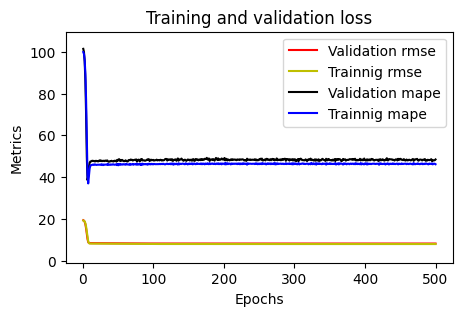

In [17]:
plotme(model1_1)

In [28]:
# inputs: distance
model1_3 = nnmodel(5,10, num_hlayers=1,Epoch=500)
model1_3

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 797541.5625 - distance_layer_loss: 0.6256 - traveltime_layer_loss: 1329235.5000 - distance_layer_mape: 146497.5625 - distance_layer_rmse: 0.7910 - traveltime_layer_mape: 99.9017 - traveltime_layer_rmse: 1152.9248 - val_loss: 810442.3125 - val_distance_layer_loss: 2.3539 - val_traveltime_layer_loss: 1350735.5000 - val_distance_layer_mape: 1071.2207 - val_distance_layer_rmse: 1.5342 - val_traveltime_layer_mape: 99.7290 - val_traveltime_layer_rmse: 1162.2114
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 790830.8750 - distance_layer_loss: 9.6372 - traveltime_layer_loss: 1318045.0000 - distance_layer_mape: 889212.3125 - distance_layer_rmse: 3.1044 - traveltime_layer_mape: 99.2807 - traveltime_layer_rmse: 1148.0614 - val_loss: 798350.9375 - val_distance_layer_loss: 21.3468 - val_traveltime_layer_loss: 1330570.5000 - val_distance_layer_mape: 3061.3206 - val_distance_layer_rmse: 4.6203 - val

165/165 [==============================] - 0s 977us/step - loss: 145461.2656 - distance_layer_loss: 2808.4968 - traveltime_layer_loss: 240563.1250 - distance_layer_mape: 11358912.0000 - distance_layer_rmse: 52.9953 - traveltime_layer_mape: 46.0571 - traveltime_layer_rmse: 490.4724 - val_loss: 152567.5469 - val_distance_layer_loss: 2764.6245 - val_traveltime_layer_loss: 252436.1406 - val_distance_layer_mape: 33790.7383 - val_distance_layer_rmse: 52.5797 - val_traveltime_layer_mape: 46.0088 - val_traveltime_layer_rmse: 502.4302
Epoch 17/500
165/165 [==============================] - 0s 996us/step - loss: 145360.1094 - distance_layer_loss: 2800.1770 - traveltime_layer_loss: 240400.0625 - distance_layer_mape: 11339105.0000 - distance_layer_rmse: 52.9167 - traveltime_layer_mape: 45.9867 - traveltime_layer_rmse: 490.3061 - val_loss: 152504.1719 - val_distance_layer_loss: 2753.6333 - val_traveltime_layer_loss: 252337.8125 - val_distance_layer_mape: 33727.6406 - val_distance_layer_rmse: 52.475

165/165 [==============================] - 0s 1ms/step - loss: 143646.7812 - distance_layer_loss: 2711.6428 - traveltime_layer_loss: 237603.5469 - distance_layer_mape: 11098703.0000 - distance_layer_rmse: 52.0734 - traveltime_layer_mape: 46.2106 - traveltime_layer_rmse: 487.4460 - val_loss: 150900.6406 - val_distance_layer_loss: 2662.7439 - val_traveltime_layer_loss: 249725.8438 - val_distance_layer_mape: 33234.2969 - val_distance_layer_rmse: 51.6018 - val_traveltime_layer_mape: 46.0100 - val_traveltime_layer_rmse: 499.7258
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 143490.0000 - distance_layer_loss: 2687.1533 - traveltime_layer_loss: 237358.5312 - distance_layer_mape: 11016176.0000 - distance_layer_rmse: 51.8378 - traveltime_layer_mape: 45.8540 - traveltime_layer_rmse: 487.1945 - val_loss: 150771.0781 - val_distance_layer_loss: 2658.0134 - val_traveltime_layer_loss: 249513.1875 - val_distance_layer_mape: 33209.5195 - val_distance_layer_rmse: 51.5559 - 

165/165 [==============================] - 0s 970us/step - loss: 141938.3594 - distance_layer_loss: 2563.7517 - traveltime_layer_loss: 234854.7500 - distance_layer_mape: 10750953.0000 - distance_layer_rmse: 50.6335 - traveltime_layer_mape: 46.0717 - traveltime_layer_rmse: 484.6181 - val_loss: 149379.1094 - val_distance_layer_loss: 2537.7996 - val_traveltime_layer_loss: 247273.3281 - val_distance_layer_mape: 32517.3477 - val_distance_layer_rmse: 50.3766 - val_traveltime_layer_mape: 46.3408 - val_traveltime_layer_rmse: 497.2658
Epoch 47/500
165/165 [==============================] - 0s 1ms/step - loss: 141806.7031 - distance_layer_loss: 2558.8052 - traveltime_layer_loss: 234638.5469 - distance_layer_mape: 10718291.0000 - distance_layer_rmse: 50.5846 - traveltime_layer_mape: 46.1886 - traveltime_layer_rmse: 484.3950 - val_loss: 149358.8906 - val_distance_layer_loss: 2515.2263 - val_traveltime_layer_loss: 247254.6719 - val_distance_layer_mape: 32377.3105 - val_distance_layer_rmse: 50.1520 

165/165 [==============================] - 0s 1ms/step - loss: 140559.7031 - distance_layer_loss: 2404.6140 - traveltime_layer_loss: 232663.0156 - distance_layer_mape: 10306104.0000 - distance_layer_rmse: 49.0369 - traveltime_layer_mape: 45.9482 - traveltime_layer_rmse: 482.3516 - val_loss: 148260.4062 - val_distance_layer_loss: 2397.3345 - val_traveltime_layer_loss: 245502.4062 - val_distance_layer_mape: 31666.1855 - val_distance_layer_rmse: 48.9626 - val_traveltime_layer_mape: 46.6156 - val_traveltime_layer_rmse: 495.4820
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 140509.6094 - distance_layer_loss: 2403.0703 - traveltime_layer_loss: 232580.5156 - distance_layer_mape: 10321934.0000 - distance_layer_rmse: 49.0211 - traveltime_layer_mape: 46.1601 - traveltime_layer_rmse: 482.2660 - val_loss: 148239.1250 - val_distance_layer_loss: 2375.5889 - val_traveltime_layer_loss: 245481.4531 - val_distance_layer_mape: 31526.5273 - val_distance_layer_rmse: 48.7400 - 

165/165 [==============================] - 0s 1ms/step - loss: 139548.8594 - distance_layer_loss: 2252.2273 - traveltime_layer_loss: 231080.0156 - distance_layer_mape: 9982502.0000 - distance_layer_rmse: 47.4576 - traveltime_layer_mape: 45.8609 - traveltime_layer_rmse: 480.7078 - val_loss: 147508.0312 - val_distance_layer_loss: 2244.4531 - val_traveltime_layer_loss: 244350.4375 - val_distance_layer_mape: 30691.3652 - val_distance_layer_rmse: 47.3757 - val_traveltime_layer_mape: 46.4909 - val_traveltime_layer_rmse: 494.3181
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 139514.2031 - distance_layer_loss: 2255.7388 - traveltime_layer_loss: 231019.8750 - distance_layer_mape: 9984729.0000 - distance_layer_rmse: 47.4946 - traveltime_layer_mape: 46.1959 - traveltime_layer_rmse: 480.6453 - val_loss: 147460.9375 - val_distance_layer_loss: 2237.1611 - val_traveltime_layer_loss: 244276.7188 - val_distance_layer_mape: 30644.4551 - val_distance_layer_rmse: 47.2986 - va

165/165 [==============================] - 0s 1ms/step - loss: 138861.5156 - distance_layer_loss: 2129.3250 - traveltime_layer_loss: 230016.3125 - distance_layer_mape: 9657325.0000 - distance_layer_rmse: 46.1446 - traveltime_layer_mape: 46.1844 - traveltime_layer_rmse: 479.6002 - val_loss: 146945.7969 - val_distance_layer_loss: 2122.5510 - val_traveltime_layer_loss: 243494.5938 - val_distance_layer_mape: 29886.1484 - val_distance_layer_rmse: 46.0712 - val_traveltime_layer_mape: 46.8012 - val_traveltime_layer_rmse: 493.4517
Epoch 92/500
165/165 [==============================] - 0s 992us/step - loss: 138821.5469 - distance_layer_loss: 2127.1470 - traveltime_layer_loss: 229951.1250 - distance_layer_mape: 9674974.0000 - distance_layer_rmse: 46.1210 - traveltime_layer_mape: 46.3576 - traveltime_layer_rmse: 479.5322 - val_loss: 147055.3125 - val_distance_layer_loss: 2085.8860 - val_traveltime_layer_loss: 243701.6094 - val_distance_layer_mape: 29630.8633 - val_distance_layer_rmse: 45.6715 - 

165/165 [==============================] - 0s 1ms/step - loss: 138365.4844 - distance_layer_loss: 2010.2344 - traveltime_layer_loss: 229268.8438 - distance_layer_mape: 9383980.0000 - distance_layer_rmse: 44.8356 - traveltime_layer_mape: 46.2164 - traveltime_layer_rmse: 478.8203 - val_loss: 146586.6250 - val_distance_layer_loss: 2001.3511 - val_traveltime_layer_loss: 242976.8281 - val_distance_layer_mape: 29052.0840 - val_distance_layer_rmse: 44.7365 - val_traveltime_layer_mape: 46.7267 - val_traveltime_layer_rmse: 492.9268
Epoch 107/500
165/165 [==============================] - 0s 1ms/step - loss: 138295.5781 - distance_layer_loss: 2011.7671 - traveltime_layer_loss: 229151.4375 - distance_layer_mape: 9382160.0000 - distance_layer_rmse: 44.8527 - traveltime_layer_mape: 46.4606 - traveltime_layer_rmse: 478.6977 - val_loss: 146593.5781 - val_distance_layer_loss: 1986.0055 - val_traveltime_layer_loss: 242998.6250 - val_distance_layer_mape: 28942.7832 - val_distance_layer_rmse: 44.5646 - v

165/165 [==============================] - 0s 1ms/step - loss: 137950.1719 - distance_layer_loss: 1914.3984 - traveltime_layer_loss: 228640.6250 - distance_layer_mape: 9179085.0000 - distance_layer_rmse: 43.7538 - traveltime_layer_mape: 46.4307 - traveltime_layer_rmse: 478.1638 - val_loss: 146478.4219 - val_distance_layer_loss: 1876.7194 - val_traveltime_layer_loss: 242879.5781 - val_distance_layer_mape: 28158.7480 - val_distance_layer_rmse: 43.3211 - val_traveltime_layer_mape: 46.1076 - val_traveltime_layer_rmse: 492.8282
Epoch 122/500
165/165 [==============================] - 0s 941us/step - loss: 137969.9375 - distance_layer_loss: 1900.7798 - traveltime_layer_loss: 228682.7344 - distance_layer_mape: 9125858.0000 - distance_layer_rmse: 43.5979 - traveltime_layer_mape: 46.2327 - traveltime_layer_rmse: 478.2078 - val_loss: 146378.1562 - val_distance_layer_loss: 1882.6552 - val_traveltime_layer_loss: 242708.4531 - val_distance_layer_mape: 28203.8105 - val_distance_layer_rmse: 43.3896 -

165/165 [==============================] - 0s 1ms/step - loss: 137705.7656 - distance_layer_loss: 1825.3525 - traveltime_layer_loss: 228292.6875 - distance_layer_mape: 8932181.0000 - distance_layer_rmse: 42.7241 - traveltime_layer_mape: 46.3758 - traveltime_layer_rmse: 477.7998 - val_loss: 146304.8594 - val_distance_layer_loss: 1794.3773 - val_traveltime_layer_loss: 242645.1875 - val_distance_layer_mape: 27552.1309 - val_distance_layer_rmse: 42.3601 - val_traveltime_layer_mape: 46.1831 - val_traveltime_layer_rmse: 492.5903
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 137690.6719 - distance_layer_loss: 1813.2576 - traveltime_layer_loss: 228275.5625 - distance_layer_mape: 8912003.0000 - distance_layer_rmse: 42.5824 - traveltime_layer_mape: 46.1868 - traveltime_layer_rmse: 477.7819 - val_loss: 146204.1562 - val_distance_layer_loss: 1800.6702 - val_traveltime_layer_loss: 242473.0781 - val_distance_layer_mape: 27600.5117 - val_distance_layer_rmse: 42.4343 - v

165/165 [==============================] - 0s 1ms/step - loss: 137500.1406 - distance_layer_loss: 1760.6820 - traveltime_layer_loss: 227993.0938 - distance_layer_mape: 8780171.0000 - distance_layer_rmse: 41.9605 - traveltime_layer_mape: 46.6891 - traveltime_layer_rmse: 477.4862 - val_loss: 146168.7344 - val_distance_layer_loss: 1723.4414 - val_traveltime_layer_loss: 242465.5781 - val_distance_layer_mape: 27015.1406 - val_distance_layer_rmse: 41.5144 - val_traveltime_layer_mape: 46.2553 - val_traveltime_layer_rmse: 492.4079
Epoch 152/500
165/165 [==============================] - 0s 995us/step - loss: 137558.3906 - distance_layer_loss: 1742.7937 - traveltime_layer_loss: 228102.1406 - distance_layer_mape: 8750399.0000 - distance_layer_rmse: 41.7468 - traveltime_layer_mape: 46.2878 - traveltime_layer_rmse: 477.6004 - val_loss: 146217.2812 - val_distance_layer_loss: 1713.8453 - val_traveltime_layer_loss: 242552.8594 - val_distance_layer_mape: 26941.0293 - val_distance_layer_rmse: 41.3986 -

165/165 [==============================] - 0s 1ms/step - loss: 137420.8125 - distance_layer_loss: 1683.6399 - traveltime_layer_loss: 227912.3281 - distance_layer_mape: 8590896.0000 - distance_layer_rmse: 41.0322 - traveltime_layer_mape: 46.2994 - traveltime_layer_rmse: 477.4016 - val_loss: 146015.3125 - val_distance_layer_loss: 1670.1241 - val_traveltime_layer_loss: 242245.4062 - val_distance_layer_mape: 26603.4043 - val_distance_layer_rmse: 40.8672 - val_traveltime_layer_mape: 46.5472 - val_traveltime_layer_rmse: 492.1843
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 137427.2031 - distance_layer_loss: 1681.3588 - traveltime_layer_loss: 227924.3906 - distance_layer_mape: 8599954.0000 - distance_layer_rmse: 41.0044 - traveltime_layer_mape: 46.3491 - traveltime_layer_rmse: 477.4143 - val_loss: 146016.9062 - val_distance_layer_loss: 1665.2375 - val_traveltime_layer_loss: 242251.3594 - val_distance_layer_mape: 26564.8809 - val_distance_layer_rmse: 40.8073 - v

165/165 [==============================] - 0s 978us/step - loss: 137315.7656 - distance_layer_loss: 1635.9121 - traveltime_layer_loss: 227769.0469 - distance_layer_mape: 8480258.0000 - distance_layer_rmse: 40.4464 - traveltime_layer_mape: 46.5088 - traveltime_layer_rmse: 477.2516 - val_loss: 146010.6719 - val_distance_layer_loss: 1608.6609 - val_traveltime_layer_loss: 242278.7344 - val_distance_layer_mape: 26116.6758 - val_distance_layer_rmse: 40.1081 - val_traveltime_layer_mape: 46.2969 - val_traveltime_layer_rmse: 492.2182
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 137310.0625 - distance_layer_loss: 1630.1299 - traveltime_layer_loss: 227763.3438 - distance_layer_mape: 8464204.0000 - distance_layer_rmse: 40.3749 - traveltime_layer_mape: 46.4284 - traveltime_layer_rmse: 477.2456 - val_loss: 146079.6562 - val_distance_layer_loss: 1598.8276 - val_traveltime_layer_loss: 242400.2188 - val_distance_layer_mape: 26037.5020 - val_distance_layer_rmse: 39.9853 -

165/165 [==============================] - 0s 950us/step - loss: 137230.2188 - distance_layer_loss: 1583.3473 - traveltime_layer_loss: 227661.6250 - distance_layer_mape: 8293558.0000 - distance_layer_rmse: 39.7913 - traveltime_layer_mape: 46.3363 - traveltime_layer_rmse: 477.1390 - val_loss: 145858.2188 - val_distance_layer_loss: 1576.0988 - val_traveltime_layer_loss: 242046.2969 - val_distance_layer_mape: 25854.8281 - val_distance_layer_rmse: 39.7001 - val_traveltime_layer_mape: 46.7286 - val_traveltime_layer_rmse: 491.9820
Epoch 197/500
165/165 [==============================] - 0s 967us/step - loss: 137223.0938 - distance_layer_loss: 1587.5532 - traveltime_layer_loss: 227646.7656 - distance_layer_mape: 8345538.5000 - distance_layer_rmse: 39.8441 - traveltime_layer_mape: 46.5824 - traveltime_layer_rmse: 477.1234 - val_loss: 145957.2031 - val_distance_layer_loss: 1558.8687 - val_traveltime_layer_loss: 242222.7500 - val_distance_layer_mape: 25714.6680 - val_distance_layer_rmse: 39.4825

165/165 [==============================] - 0s 944us/step - loss: 137192.6875 - distance_layer_loss: 1545.4750 - traveltime_layer_loss: 227624.2188 - distance_layer_mape: 8221040.5000 - distance_layer_rmse: 39.3125 - traveltime_layer_mape: 46.4669 - traveltime_layer_rmse: 477.0998 - val_loss: 145836.1875 - val_distance_layer_loss: 1529.4846 - val_traveltime_layer_loss: 242040.7188 - val_distance_layer_mape: 25473.3164 - val_distance_layer_rmse: 39.1086 - val_traveltime_layer_mape: 46.5467 - val_traveltime_layer_rmse: 491.9763
Epoch 212/500
165/165 [==============================] - 0s 969us/step - loss: 137188.4219 - distance_layer_loss: 1535.2772 - traveltime_layer_loss: 227623.9219 - distance_layer_mape: 8179430.0000 - distance_layer_rmse: 39.1826 - traveltime_layer_mape: 46.2123 - traveltime_layer_rmse: 477.0995 - val_loss: 145819.9062 - val_distance_layer_loss: 1528.6565 - val_traveltime_layer_loss: 242014.1094 - val_distance_layer_mape: 25466.4023 - val_distance_layer_rmse: 39.0980

165/165 [==============================] - 0s 939us/step - loss: 137156.0781 - distance_layer_loss: 1513.9037 - traveltime_layer_loss: 227584.1406 - distance_layer_mape: 8118631.0000 - distance_layer_rmse: 38.9089 - traveltime_layer_mape: 46.6389 - traveltime_layer_rmse: 477.0578 - val_loss: 145787.5000 - val_distance_layer_loss: 1492.7620 - val_traveltime_layer_loss: 241983.9688 - val_distance_layer_mape: 25167.5254 - val_distance_layer_rmse: 38.6363 - val_traveltime_layer_mape: 46.5243 - val_traveltime_layer_rmse: 491.9187
Epoch 227/500
165/165 [==============================] - 0s 986us/step - loss: 137140.2656 - distance_layer_loss: 1508.3199 - traveltime_layer_loss: 227561.5781 - distance_layer_mape: 8107991.5000 - distance_layer_rmse: 38.8371 - traveltime_layer_mape: 46.5187 - traveltime_layer_rmse: 477.0341 - val_loss: 145792.5312 - val_distance_layer_loss: 1489.4011 - val_traveltime_layer_loss: 241994.6562 - val_distance_layer_mape: 25139.4121 - val_distance_layer_rmse: 38.5928

165/165 [==============================] - 0s 1ms/step - loss: 137091.7031 - distance_layer_loss: 1478.4844 - traveltime_layer_loss: 227500.5156 - distance_layer_mape: 8034435.5000 - distance_layer_rmse: 38.4511 - traveltime_layer_mape: 46.5681 - traveltime_layer_rmse: 476.9702 - val_loss: 145754.4688 - val_distance_layer_loss: 1457.7513 - val_traveltime_layer_loss: 241952.2188 - val_distance_layer_mape: 24871.7051 - val_distance_layer_rmse: 38.1805 - val_traveltime_layer_mape: 46.4352 - val_traveltime_layer_rmse: 491.8864
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 137076.0625 - distance_layer_loss: 1464.4623 - traveltime_layer_loss: 227483.7969 - distance_layer_mape: 7965308.0000 - distance_layer_rmse: 38.2683 - traveltime_layer_mape: 46.1313 - traveltime_layer_rmse: 476.9526 - val_loss: 145670.7656 - val_distance_layer_loss: 1470.2340 - val_traveltime_layer_loss: 241804.4688 - val_distance_layer_mape: 24976.8613 - val_distance_layer_rmse: 38.3436 - v

165/165 [==============================] - 0s 998us/step - loss: 137083.1094 - distance_layer_loss: 1448.6089 - traveltime_layer_loss: 227506.1094 - distance_layer_mape: 7971320.5000 - distance_layer_rmse: 38.0606 - traveltime_layer_mape: 46.5799 - traveltime_layer_rmse: 476.9760 - val_loss: 145743.3125 - val_distance_layer_loss: 1423.9381 - val_traveltime_layer_loss: 241956.1719 - val_distance_layer_mape: 24582.3047 - val_distance_layer_rmse: 37.7351 - val_traveltime_layer_mape: 46.2985 - val_traveltime_layer_rmse: 491.8904
Epoch 257/500
165/165 [==============================] - 0s 949us/step - loss: 137121.3125 - distance_layer_loss: 1439.0087 - traveltime_layer_loss: 227576.1562 - distance_layer_mape: 7883912.0000 - distance_layer_rmse: 37.9343 - traveltime_layer_mape: 46.3051 - traveltime_layer_rmse: 477.0494 - val_loss: 145838.1094 - val_distance_layer_loss: 1414.1580 - val_traveltime_layer_loss: 242120.7188 - val_distance_layer_mape: 24498.4258 - val_distance_layer_rmse: 37.6053

165/165 [==============================] - 0s 1ms/step - loss: 137032.6562 - distance_layer_loss: 1410.4834 - traveltime_layer_loss: 227447.4219 - distance_layer_mape: 7856431.0000 - distance_layer_rmse: 37.5564 - traveltime_layer_mape: 46.1882 - traveltime_layer_rmse: 476.9145 - val_loss: 145591.6406 - val_distance_layer_loss: 1412.5490 - val_traveltime_layer_loss: 241711.0312 - val_distance_layer_mape: 24482.7676 - val_distance_layer_rmse: 37.5839 - val_traveltime_layer_mape: 46.8444 - val_traveltime_layer_rmse: 491.6412
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 137091.0781 - distance_layer_loss: 1420.3114 - traveltime_layer_loss: 227538.2188 - distance_layer_mape: 7899762.0000 - distance_layer_rmse: 37.6870 - traveltime_layer_mape: 46.6185 - traveltime_layer_rmse: 477.0097 - val_loss: 145698.8281 - val_distance_layer_loss: 1395.2411 - val_traveltime_layer_loss: 241901.1562 - val_distance_layer_mape: 24333.7441 - val_distance_layer_rmse: 37.3529 - v

165/165 [==============================] - 0s 1ms/step - loss: 137003.4375 - distance_layer_loss: 1392.8110 - traveltime_layer_loss: 227410.4844 - distance_layer_mape: 7807380.5000 - distance_layer_rmse: 37.3204 - traveltime_layer_mape: 46.4816 - traveltime_layer_rmse: 476.8758 - val_loss: 145624.4062 - val_distance_layer_loss: 1375.3455 - val_traveltime_layer_loss: 241790.5000 - val_distance_layer_mape: 24159.1328 - val_distance_layer_rmse: 37.0857 - val_traveltime_layer_mape: 46.4256 - val_traveltime_layer_rmse: 491.7220
Epoch 287/500
165/165 [==============================] - 0s 995us/step - loss: 137029.6562 - distance_layer_loss: 1389.4159 - traveltime_layer_loss: 227456.4062 - distance_layer_mape: 7765475.0000 - distance_layer_rmse: 37.2749 - traveltime_layer_mape: 46.4250 - traveltime_layer_rmse: 476.9239 - val_loss: 145663.1406 - val_distance_layer_loss: 1369.6683 - val_traveltime_layer_loss: 241858.7812 - val_distance_layer_mape: 24109.5566 - val_distance_layer_rmse: 37.0090 -

165/165 [==============================] - 0s 971us/step - loss: 136955.6875 - distance_layer_loss: 1360.8097 - traveltime_layer_loss: 227352.2969 - distance_layer_mape: 7721027.5000 - distance_layer_rmse: 36.8892 - traveltime_layer_mape: 46.1992 - traveltime_layer_rmse: 476.8147 - val_loss: 145509.9062 - val_distance_layer_loss: 1363.4797 - val_traveltime_layer_loss: 241607.5000 - val_distance_layer_mape: 24053.3438 - val_distance_layer_rmse: 36.9253 - val_traveltime_layer_mape: 46.8721 - val_traveltime_layer_rmse: 491.5359
Epoch 302/500
165/165 [==============================] - 0s 953us/step - loss: 137003.8750 - distance_layer_loss: 1370.0688 - traveltime_layer_loss: 227426.3281 - distance_layer_mape: 7735003.0000 - distance_layer_rmse: 37.0144 - traveltime_layer_mape: 46.5978 - traveltime_layer_rmse: 476.8924 - val_loss: 145596.3750 - val_distance_layer_loss: 1348.0537 - val_traveltime_layer_loss: 241761.9062 - val_distance_layer_mape: 23918.0000 - val_distance_layer_rmse: 36.7159

165/165 [==============================] - 0s 937us/step - loss: 136959.2188 - distance_layer_loss: 1342.1295 - traveltime_layer_loss: 227370.6250 - distance_layer_mape: 7648337.0000 - distance_layer_rmse: 36.6351 - traveltime_layer_mape: 46.3904 - traveltime_layer_rmse: 476.8340 - val_loss: 145486.3281 - val_distance_layer_loss: 1336.3245 - val_traveltime_layer_loss: 241586.3438 - val_distance_layer_mape: 23812.4512 - val_distance_layer_rmse: 36.5558 - val_traveltime_layer_mape: 46.7328 - val_traveltime_layer_rmse: 491.5143
Epoch 317/500
165/165 [==============================] - 0s 995us/step - loss: 136951.8594 - distance_layer_loss: 1339.9797 - traveltime_layer_loss: 227359.7500 - distance_layer_mape: 7643830.5000 - distance_layer_rmse: 36.6057 - traveltime_layer_mape: 46.3398 - traveltime_layer_rmse: 476.8226 - val_loss: 145468.7500 - val_distance_layer_loss: 1338.6898 - val_traveltime_layer_loss: 241555.4844 - val_distance_layer_mape: 23833.1152 - val_distance_layer_rmse: 36.5881

165/165 [==============================] - 0s 948us/step - loss: 136921.2969 - distance_layer_loss: 1314.0433 - traveltime_layer_loss: 227326.1250 - distance_layer_mape: 7576755.0000 - distance_layer_rmse: 36.2497 - traveltime_layer_mape: 46.1508 - traveltime_layer_rmse: 476.7873 - val_loss: 145435.8750 - val_distance_layer_loss: 1318.0177 - val_traveltime_layer_loss: 241514.4375 - val_distance_layer_mape: 23647.7793 - val_distance_layer_rmse: 36.3045 - val_traveltime_layer_mape: 46.8601 - val_traveltime_layer_rmse: 491.4412
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 136940.8750 - distance_layer_loss: 1322.4597 - traveltime_layer_loss: 227353.0469 - distance_layer_mape: 7593463.0000 - distance_layer_rmse: 36.3656 - traveltime_layer_mape: 46.5305 - traveltime_layer_rmse: 476.8155 - val_loss: 145451.2656 - val_distance_layer_loss: 1312.3514 - val_traveltime_layer_loss: 241543.8125 - val_distance_layer_mape: 23597.1953 - val_distance_layer_rmse: 36.2264 -

165/165 [==============================] - 0s 971us/step - loss: 136877.8594 - distance_layer_loss: 1290.2091 - traveltime_layer_loss: 227269.5938 - distance_layer_mape: 7551014.0000 - distance_layer_rmse: 35.9195 - traveltime_layer_mape: 46.0297 - traveltime_layer_rmse: 476.7280 - val_loss: 145395.4844 - val_distance_layer_loss: 1302.7192 - val_traveltime_layer_loss: 241457.2656 - val_distance_layer_mape: 23509.1797 - val_distance_layer_rmse: 36.0932 - val_traveltime_layer_mape: 47.0727 - val_traveltime_layer_rmse: 491.3830
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 136938.1562 - distance_layer_loss: 1304.0660 - traveltime_layer_loss: 227360.9531 - distance_layer_mape: 7533890.5000 - distance_layer_rmse: 36.1119 - traveltime_layer_mape: 46.6261 - traveltime_layer_rmse: 476.8238 - val_loss: 145444.7969 - val_distance_layer_loss: 1288.1039 - val_traveltime_layer_loss: 241549.2344 - val_distance_layer_mape: 23378.1074 - val_distance_layer_rmse: 35.8902 -

165/165 [==============================] - 0s 951us/step - loss: 136920.1562 - distance_layer_loss: 1278.2219 - traveltime_layer_loss: 227348.0625 - distance_layer_mape: 7432522.5000 - distance_layer_rmse: 35.7522 - traveltime_layer_mape: 46.3395 - traveltime_layer_rmse: 476.8103 - val_loss: 145467.9062 - val_distance_layer_loss: 1263.4531 - val_traveltime_layer_loss: 241604.1875 - val_distance_layer_mape: 23153.2227 - val_distance_layer_rmse: 35.5451 - val_traveltime_layer_mape: 46.3259 - val_traveltime_layer_rmse: 491.5325
Epoch 362/500
165/165 [==============================] - 0s 1ms/step - loss: 136936.4219 - distance_layer_loss: 1276.4312 - traveltime_layer_loss: 227376.4688 - distance_layer_mape: 7477894.0000 - distance_layer_rmse: 35.7272 - traveltime_layer_mape: 46.3500 - traveltime_layer_rmse: 476.8401 - val_loss: 145531.6562 - val_distance_layer_loss: 1256.2946 - val_traveltime_layer_loss: 241715.2188 - val_distance_layer_mape: 23087.7500 - val_distance_layer_rmse: 35.4442 -

165/165 [==============================] - 0s 989us/step - loss: 136906.9062 - distance_layer_loss: 1257.5103 - traveltime_layer_loss: 227339.8594 - distance_layer_mape: 7418077.5000 - distance_layer_rmse: 35.4614 - traveltime_layer_mape: 46.2989 - traveltime_layer_rmse: 476.8017 - val_loss: 145395.2500 - val_distance_layer_loss: 1249.3624 - val_traveltime_layer_loss: 241492.5156 - val_distance_layer_mape: 23022.8047 - val_distance_layer_rmse: 35.3463 - val_traveltime_layer_mape: 46.5173 - val_traveltime_layer_rmse: 491.4189
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 136885.4375 - distance_layer_loss: 1253.8824 - traveltime_layer_loss: 227306.5156 - distance_layer_mape: 7394905.0000 - distance_layer_rmse: 35.4102 - traveltime_layer_mape: 46.2102 - traveltime_layer_rmse: 476.7667 - val_loss: 145341.4688 - val_distance_layer_loss: 1258.5282 - val_traveltime_layer_loss: 241396.8125 - val_distance_layer_mape: 23106.1523 - val_distance_layer_rmse: 35.4757 -

165/165 [==============================] - 0s 1ms/step - loss: 136912.9219 - distance_layer_loss: 1240.9430 - traveltime_layer_loss: 227360.8438 - distance_layer_mape: 7414379.5000 - distance_layer_rmse: 35.2270 - traveltime_layer_mape: 46.3721 - traveltime_layer_rmse: 476.8237 - val_loss: 145408.4219 - val_distance_layer_loss: 1226.1743 - val_traveltime_layer_loss: 241529.9688 - val_distance_layer_mape: 22807.7656 - val_distance_layer_rmse: 35.0168 - val_traveltime_layer_mape: 46.3255 - val_traveltime_layer_rmse: 491.4570
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 136890.7812 - distance_layer_loss: 1242.0452 - traveltime_layer_loss: 227323.2344 - distance_layer_mape: 7397726.5000 - distance_layer_rmse: 35.2427 - traveltime_layer_mape: 46.4840 - traveltime_layer_rmse: 476.7843 - val_loss: 145367.7344 - val_distance_layer_loss: 1229.5972 - val_traveltime_layer_loss: 241459.8125 - val_distance_layer_mape: 22839.3281 - val_distance_layer_rmse: 35.0656 - v

165/165 [==============================] - 0s 1ms/step - loss: 136832.1875 - distance_layer_loss: 1219.4027 - traveltime_layer_loss: 227240.7031 - distance_layer_mape: 7302632.5000 - distance_layer_rmse: 34.9199 - traveltime_layer_mape: 46.2267 - traveltime_layer_rmse: 476.6977 - val_loss: 145296.4062 - val_distance_layer_loss: 1220.1635 - val_traveltime_layer_loss: 241347.2344 - val_distance_layer_mape: 22750.1289 - val_distance_layer_rmse: 34.9308 - val_traveltime_layer_mape: 46.8093 - val_traveltime_layer_rmse: 491.2710
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 136871.0938 - distance_layer_loss: 1223.7141 - traveltime_layer_loss: 227302.6406 - distance_layer_mape: 7298863.5000 - distance_layer_rmse: 34.9816 - traveltime_layer_mape: 46.4727 - traveltime_layer_rmse: 476.7627 - val_loss: 145315.7656 - val_distance_layer_loss: 1214.6448 - val_traveltime_layer_loss: 241383.1875 - val_distance_layer_mape: 22699.0723 - val_distance_layer_rmse: 34.8518 - v

165/165 [==============================] - 0s 1ms/step - loss: 136831.0000 - distance_layer_loss: 1202.9575 - traveltime_layer_loss: 227249.5938 - distance_layer_mape: 7249748.0000 - distance_layer_rmse: 34.6837 - traveltime_layer_mape: 46.2842 - traveltime_layer_rmse: 476.7070 - val_loss: 145267.0312 - val_distance_layer_loss: 1205.6864 - val_traveltime_layer_loss: 241307.8438 - val_distance_layer_mape: 22614.0059 - val_distance_layer_rmse: 34.7230 - val_traveltime_layer_mape: 46.9217 - val_traveltime_layer_rmse: 491.2310
Epoch 422/500
165/165 [==============================] - 0s 998us/step - loss: 136843.8906 - distance_layer_loss: 1210.6873 - traveltime_layer_loss: 227265.9219 - distance_layer_mape: 7273461.0000 - distance_layer_rmse: 34.7949 - traveltime_layer_mape: 46.6416 - traveltime_layer_rmse: 476.7242 - val_loss: 145333.0000 - val_distance_layer_loss: 1192.1705 - val_traveltime_layer_loss: 241426.9219 - val_distance_layer_mape: 22488.0410 - val_distance_layer_rmse: 34.5278 -

165/165 [==============================] - 0s 1ms/step - loss: 136848.0000 - distance_layer_loss: 1184.8140 - traveltime_layer_loss: 227290.2344 - distance_layer_mape: 7160305.5000 - distance_layer_rmse: 34.4211 - traveltime_layer_mape: 46.2683 - traveltime_layer_rmse: 476.7497 - val_loss: 145363.0156 - val_distance_layer_loss: 1171.5502 - val_traveltime_layer_loss: 241490.6094 - val_distance_layer_mape: 22292.7109 - val_distance_layer_rmse: 34.2279 - val_traveltime_layer_mape: 46.2305 - val_traveltime_layer_rmse: 491.4169
Epoch 437/500
165/165 [==============================] - 0s 987us/step - loss: 136836.8906 - distance_layer_loss: 1184.0758 - traveltime_layer_loss: 227272.0938 - distance_layer_mape: 7195464.5000 - distance_layer_rmse: 34.4104 - traveltime_layer_mape: 46.2581 - traveltime_layer_rmse: 476.7306 - val_loss: 145272.2031 - val_distance_layer_loss: 1180.6748 - val_traveltime_layer_loss: 241333.2656 - val_distance_layer_mape: 22378.4238 - val_distance_layer_rmse: 34.3610 -

165/165 [==============================] - 0s 953us/step - loss: 136839.9688 - distance_layer_loss: 1168.8994 - traveltime_layer_loss: 227287.2500 - distance_layer_mape: 7181025.0000 - distance_layer_rmse: 34.1892 - traveltime_layer_mape: 46.2629 - traveltime_layer_rmse: 476.7465 - val_loss: 145272.4062 - val_distance_layer_loss: 1162.3090 - val_traveltime_layer_loss: 241345.8125 - val_distance_layer_mape: 22203.2871 - val_distance_layer_rmse: 34.0927 - val_traveltime_layer_mape: 46.4965 - val_traveltime_layer_rmse: 491.2696
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 136830.1719 - distance_layer_loss: 1174.4316 - traveltime_layer_loss: 227267.3750 - distance_layer_mape: 7164539.0000 - distance_layer_rmse: 34.2700 - traveltime_layer_mape: 46.5361 - traveltime_layer_rmse: 476.7257 - val_loss: 145308.6719 - val_distance_layer_loss: 1157.1274 - val_traveltime_layer_loss: 241409.6719 - val_distance_layer_mape: 22154.0762 - val_distance_layer_rmse: 34.0166 -

165/165 [==============================] - 0s 1ms/step - loss: 136886.8594 - distance_layer_loss: 1158.6803 - traveltime_layer_loss: 227372.3125 - distance_layer_mape: 7148429.5000 - distance_layer_rmse: 34.0394 - traveltime_layer_mape: 46.4784 - traveltime_layer_rmse: 476.8357 - val_loss: 145271.5000 - val_distance_layer_loss: 1144.7921 - val_traveltime_layer_loss: 241355.9531 - val_distance_layer_mape: 22035.0918 - val_distance_layer_rmse: 33.8348 - val_traveltime_layer_mape: 46.4126 - val_traveltime_layer_rmse: 491.2799
Epoch 467/500
165/165 [==============================] - 0s 947us/step - loss: 136830.3438 - distance_layer_loss: 1154.0303 - traveltime_layer_loss: 227281.1094 - distance_layer_mape: 7104232.0000 - distance_layer_rmse: 33.9710 - traveltime_layer_mape: 46.3492 - traveltime_layer_rmse: 476.7401 - val_loss: 145338.3750 - val_distance_layer_loss: 1137.4830 - val_traveltime_layer_loss: 241472.2500 - val_distance_layer_mape: 21965.1875 - val_distance_layer_rmse: 33.7266 -

165/165 [==============================] - 0s 938us/step - loss: 136796.2656 - distance_layer_loss: 1145.2855 - traveltime_layer_loss: 227230.3438 - distance_layer_mape: 7084373.5000 - distance_layer_rmse: 33.8421 - traveltime_layer_mape: 46.5571 - traveltime_layer_rmse: 476.6868 - val_loss: 145358.4844 - val_distance_layer_loss: 1121.2631 - val_traveltime_layer_loss: 241516.6719 - val_distance_layer_mape: 21808.0078 - val_distance_layer_rmse: 33.4853 - val_traveltime_layer_mape: 46.0565 - val_traveltime_layer_rmse: 491.4435
Epoch 482/500
165/165 [==============================] - 0s 992us/step - loss: 136803.2188 - distance_layer_loss: 1138.1086 - traveltime_layer_loss: 227246.6719 - distance_layer_mape: 7058053.5000 - distance_layer_rmse: 33.7359 - traveltime_layer_mape: 46.2922 - traveltime_layer_rmse: 476.7040 - val_loss: 145257.5781 - val_distance_layer_loss: 1128.4994 - val_traveltime_layer_loss: 241343.6562 - val_distance_layer_mape: 21877.3750 - val_distance_layer_rmse: 33.5931

165/165 [==============================] - 0s 965us/step - loss: 136751.0156 - distance_layer_loss: 1137.9838 - traveltime_layer_loss: 227159.6406 - distance_layer_mape: 7000646.5000 - distance_layer_rmse: 33.7340 - traveltime_layer_mape: 46.8568 - traveltime_layer_rmse: 476.6127 - val_loss: 145356.3750 - val_distance_layer_loss: 1106.1357 - val_traveltime_layer_loss: 241523.2500 - val_distance_layer_mape: 21660.1250 - val_distance_layer_rmse: 33.2586 - val_traveltime_layer_mape: 46.0150 - val_traveltime_layer_rmse: 491.4502
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 136888.5156 - distance_layer_loss: 1120.2415 - traveltime_layer_loss: 227400.7031 - distance_layer_mape: 7027444.5000 - distance_layer_rmse: 33.4700 - traveltime_layer_mape: 46.1352 - traveltime_layer_rmse: 476.8655 - val_loss: 145242.3281 - val_distance_layer_loss: 1113.9825 - val_traveltime_layer_loss: 241327.8281 - val_distance_layer_mape: 21735.8926 - val_distance_layer_rmse: 33.3764 -

In [31]:
# inputs: distance
model1_3 = nnmodel(5,20, num_hlayers=1,Epoch=500)
model1_3

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 797803.3750 - distance_layer_loss: 0.2238 - traveltime_layer_loss: 1329671.7500 - distance_layer_mape: 96513.5938 - distance_layer_rmse: 0.4731 - traveltime_layer_mape: 99.9260 - traveltime_layer_rmse: 1153.1139 - val_loss: 810880.7500 - val_distance_layer_loss: 0.7764 - val_traveltime_layer_loss: 1351467.5000 - val_distance_layer_mape: 637.4285 - val_distance_layer_rmse: 0.8812 - val_traveltime_layer_mape: 99.7703 - val_traveltime_layer_rmse: 1162.5264
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 790242.7500 - distance_layer_loss: 3.4353 - traveltime_layer_loss: 1317068.8750 - distance_layer_mape: 593550.5000 - distance_layer_rmse: 1.8535 - traveltime_layer_mape: 99.2306 - traveltime_layer_rmse: 1147.6362 - val_loss: 795404.1250 - val_distance_layer_loss: 7.8315 - val_traveltime_layer_loss: 1325668.3750 - val_distance_layer_mape: 1879.8105 - val_distance_layer_rmse: 2.7985 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 144038.3125 - distance_layer_loss: 564.2885 - traveltime_layer_loss: 239687.6562 - distance_layer_mape: 5100546.5000 - distance_layer_rmse: 23.7548 - traveltime_layer_mape: 45.8773 - traveltime_layer_rmse: 489.5791 - val_loss: 150702.1250 - val_distance_layer_loss: 557.8725 - val_traveltime_layer_loss: 250798.2344 - val_distance_layer_mape: 15227.2090 - val_distance_layer_rmse: 23.6193 - val_traveltime_layer_mape: 45.9597 - val_traveltime_layer_rmse: 500.7976
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 143904.6875 - distance_layer_loss: 566.0370 - traveltime_layer_loss: 239463.7344 - distance_layer_mape: 5103113.5000 - distance_layer_rmse: 23.7915 - traveltime_layer_mape: 46.1297 - traveltime_layer_rmse: 489.3503 - val_loss: 150632.4219 - val_distance_layer_loss: 556.2844 - val_traveltime_layer_loss: 250683.2344 - val_distance_layer_mape: 15208.0439 - val_distance_layer_rmse: 23.5857 - val_tr

165/165 [==============================] - 0s 992us/step - loss: 142158.2812 - distance_layer_loss: 552.0153 - traveltime_layer_loss: 236562.5625 - distance_layer_mape: 5013916.0000 - distance_layer_rmse: 23.4950 - traveltime_layer_mape: 45.9267 - traveltime_layer_rmse: 486.3770 - val_loss: 149049.5469 - val_distance_layer_loss: 546.7177 - val_traveltime_layer_loss: 248051.3906 - val_distance_layer_mape: 15113.7285 - val_distance_layer_rmse: 23.3820 - val_traveltime_layer_mape: 46.1406 - val_traveltime_layer_rmse: 498.0476
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 141986.2031 - distance_layer_loss: 553.7620 - traveltime_layer_loss: 236274.4844 - distance_layer_mape: 5023713.0000 - distance_layer_rmse: 23.5321 - traveltime_layer_mape: 46.2485 - traveltime_layer_rmse: 486.0807 - val_loss: 149123.3281 - val_distance_layer_loss: 540.8269 - val_traveltime_layer_loss: 248178.3438 - val_distance_layer_mape: 15035.2295 - val_distance_layer_rmse: 23.2557 - val_

165/165 [==============================] - 0s 1ms/step - loss: 140546.6875 - distance_layer_loss: 533.9431 - traveltime_layer_loss: 233888.5312 - distance_layer_mape: 4933942.0000 - distance_layer_rmse: 23.1072 - traveltime_layer_mape: 46.2008 - traveltime_layer_rmse: 483.6202 - val_loss: 147926.5938 - val_distance_layer_loss: 522.2757 - val_traveltime_layer_loss: 246196.1875 - val_distance_layer_mape: 14809.1377 - val_distance_layer_rmse: 22.8534 - val_traveltime_layer_mape: 45.6484 - val_traveltime_layer_rmse: 496.1816
Epoch 47/500
165/165 [==============================] - 0s 1ms/step - loss: 140362.9375 - distance_layer_loss: 529.2574 - traveltime_layer_loss: 233585.3906 - distance_layer_mape: 4920195.0000 - distance_layer_rmse: 23.0056 - traveltime_layer_mape: 45.7966 - traveltime_layer_rmse: 483.3067 - val_loss: 147625.7656 - val_distance_layer_loss: 528.3232 - val_traveltime_layer_loss: 245690.7344 - val_distance_layer_mape: 14895.7861 - val_distance_layer_rmse: 22.9853 - val_tr

165/165 [==============================] - 0s 978us/step - loss: 139351.5625 - distance_layer_loss: 508.6959 - traveltime_layer_loss: 231913.5781 - distance_layer_mape: 4805218.5000 - distance_layer_rmse: 22.5543 - traveltime_layer_mape: 45.9933 - traveltime_layer_rmse: 481.5741 - val_loss: 146924.9688 - val_distance_layer_loss: 501.8135 - val_traveltime_layer_loss: 244540.3438 - val_distance_layer_mape: 14545.9238 - val_distance_layer_rmse: 22.4012 - val_traveltime_layer_mape: 45.9738 - val_traveltime_layer_rmse: 494.5102
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 139271.5312 - distance_layer_loss: 506.3925 - traveltime_layer_loss: 231781.6094 - distance_layer_mape: 4774383.0000 - distance_layer_rmse: 22.5032 - traveltime_layer_mape: 45.8900 - traveltime_layer_rmse: 481.4370 - val_loss: 146746.0469 - val_distance_layer_loss: 505.7812 - val_traveltime_layer_loss: 244239.5000 - val_distance_layer_mape: 14604.1045 - val_distance_layer_rmse: 22.4896 - val_

165/165 [==============================] - 0s 1ms/step - loss: 138511.0469 - distance_layer_loss: 488.9307 - traveltime_layer_loss: 230525.7812 - distance_layer_mape: 4697098.5000 - distance_layer_rmse: 22.1118 - traveltime_layer_mape: 46.4238 - traveltime_layer_rmse: 480.1310 - val_loss: 146291.1875 - val_distance_layer_loss: 480.5462 - val_traveltime_layer_loss: 243498.2656 - val_distance_layer_mape: 14257.7148 - val_distance_layer_rmse: 21.9214 - val_traveltime_layer_mape: 46.1462 - val_traveltime_layer_rmse: 493.4554
Epoch 77/500
165/165 [==============================] - 0s 995us/step - loss: 138453.6250 - distance_layer_loss: 484.9000 - traveltime_layer_loss: 230432.7812 - distance_layer_mape: 4684610.0000 - distance_layer_rmse: 22.0204 - traveltime_layer_mape: 46.0939 - traveltime_layer_rmse: 480.0341 - val_loss: 146188.7812 - val_distance_layer_loss: 481.7145 - val_traveltime_layer_loss: 243326.8125 - val_distance_layer_mape: 14276.0420 - val_distance_layer_rmse: 21.9480 - val_

165/165 [==============================] - 0s 1ms/step - loss: 137899.8281 - distance_layer_loss: 464.8564 - traveltime_layer_loss: 229523.1250 - distance_layer_mape: 4582469.0000 - distance_layer_rmse: 21.5605 - traveltime_layer_mape: 46.1839 - traveltime_layer_rmse: 479.0857 - val_loss: 145879.0156 - val_distance_layer_loss: 459.2155 - val_traveltime_layer_loss: 242825.4844 - val_distance_layer_mape: 13957.1260 - val_distance_layer_rmse: 21.4293 - val_traveltime_layer_mape: 46.2035 - val_traveltime_layer_rmse: 492.7733
Epoch 92/500
165/165 [==============================] - 0s 1ms/step - loss: 137874.6406 - distance_layer_loss: 465.3499 - traveltime_layer_loss: 229480.8125 - distance_layer_mape: 4576778.5000 - distance_layer_rmse: 21.5720 - traveltime_layer_mape: 46.4452 - traveltime_layer_rmse: 479.0416 - val_loss: 145871.9844 - val_distance_layer_loss: 457.3214 - val_traveltime_layer_loss: 242815.0625 - val_distance_layer_mape: 13929.5459 - val_distance_layer_rmse: 21.3851 - val_tr

165/165 [==============================] - 0s 988us/step - loss: 137494.4375 - distance_layer_loss: 447.1615 - traveltime_layer_loss: 228859.2812 - distance_layer_mape: 4493800.0000 - distance_layer_rmse: 21.1462 - traveltime_layer_mape: 46.4485 - traveltime_layer_rmse: 478.3924 - val_loss: 145557.9219 - val_distance_layer_loss: 442.0028 - val_traveltime_layer_loss: 242301.9062 - val_distance_layer_mape: 13708.0625 - val_distance_layer_rmse: 21.0239 - val_traveltime_layer_mape: 46.5027 - val_traveltime_layer_rmse: 492.2417
Epoch 107/500
165/165 [==============================] - 0s 998us/step - loss: 137455.9688 - distance_layer_loss: 444.7330 - traveltime_layer_loss: 228796.7500 - distance_layer_mape: 4485353.5000 - distance_layer_rmse: 21.0887 - traveltime_layer_mape: 46.2977 - traveltime_layer_rmse: 478.3270 - val_loss: 145685.7969 - val_distance_layer_loss: 436.9592 - val_traveltime_layer_loss: 242518.3281 - val_distance_layer_mape: 13631.2627 - val_distance_layer_rmse: 20.9036 - v

165/165 [==============================] - 0s 1ms/step - loss: 137202.2812 - distance_layer_loss: 428.2567 - traveltime_layer_loss: 228385.1250 - distance_layer_mape: 4382930.0000 - distance_layer_rmse: 20.6944 - traveltime_layer_mape: 46.1953 - traveltime_layer_rmse: 477.8966 - val_loss: 145439.7656 - val_distance_layer_loss: 423.9282 - val_traveltime_layer_loss: 242116.9531 - val_distance_layer_mape: 13436.9033 - val_distance_layer_rmse: 20.5895 - val_traveltime_layer_mape: 46.3131 - val_traveltime_layer_rmse: 492.0538
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 137175.0938 - distance_layer_loss: 426.7324 - traveltime_layer_loss: 228340.7188 - distance_layer_mape: 4390621.0000 - distance_layer_rmse: 20.6575 - traveltime_layer_mape: 46.1462 - traveltime_layer_rmse: 477.8501 - val_loss: 145371.5156 - val_distance_layer_loss: 425.0042 - val_traveltime_layer_loss: 242002.5312 - val_distance_layer_mape: 13454.1934 - val_distance_layer_rmse: 20.6156 - val_t

165/165 [==============================] - 0s 992us/step - loss: 137025.6250 - distance_layer_loss: 414.3802 - traveltime_layer_loss: 228099.8125 - distance_layer_mape: 4313393.5000 - distance_layer_rmse: 20.3563 - traveltime_layer_mape: 46.2492 - traveltime_layer_rmse: 477.5980 - val_loss: 145312.8281 - val_distance_layer_loss: 411.0400 - val_traveltime_layer_loss: 241914.0156 - val_distance_layer_mape: 13239.8242 - val_distance_layer_rmse: 20.2741 - val_traveltime_layer_mape: 46.4706 - val_traveltime_layer_rmse: 491.8476
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 136989.8750 - distance_layer_loss: 414.2657 - traveltime_layer_loss: 228040.2656 - distance_layer_mape: 4322516.0000 - distance_layer_rmse: 20.3535 - traveltime_layer_mape: 46.3622 - traveltime_layer_rmse: 477.5356 - val_loss: 145329.9844 - val_distance_layer_loss: 409.5659 - val_traveltime_layer_loss: 241943.5469 - val_distance_layer_mape: 13216.7598 - val_distance_layer_rmse: 20.2377 - val

165/165 [==============================] - 0s 965us/step - loss: 136892.7188 - distance_layer_loss: 404.4645 - traveltime_layer_loss: 227884.9219 - distance_layer_mape: 4265816.0000 - distance_layer_rmse: 20.1113 - traveltime_layer_mape: 46.5279 - traveltime_layer_rmse: 477.3729 - val_loss: 145252.0625 - val_distance_layer_loss: 399.6894 - val_traveltime_layer_loss: 241820.2969 - val_distance_layer_mape: 13062.3652 - val_distance_layer_rmse: 19.9922 - val_traveltime_layer_mape: 46.5055 - val_traveltime_layer_rmse: 491.7523
Epoch 152/500
165/165 [==============================] - 0s 952us/step - loss: 136889.2812 - distance_layer_loss: 403.2755 - traveltime_layer_loss: 227879.9688 - distance_layer_mape: 4251775.0000 - distance_layer_rmse: 20.0817 - traveltime_layer_mape: 46.4635 - traveltime_layer_rmse: 477.3677 - val_loss: 145360.5938 - val_distance_layer_loss: 396.3047 - val_traveltime_layer_loss: 242003.4375 - val_distance_layer_mape: 13007.8945 - val_distance_layer_rmse: 19.9074 - v

165/165 [==============================] - 0s 991us/step - loss: 136785.1406 - distance_layer_loss: 394.8893 - traveltime_layer_loss: 227711.8750 - distance_layer_mape: 4209151.0000 - distance_layer_rmse: 19.8718 - traveltime_layer_mape: 46.5383 - traveltime_layer_rmse: 477.1917 - val_loss: 145301.9688 - val_distance_layer_loss: 388.2108 - val_traveltime_layer_loss: 241911.1562 - val_distance_layer_mape: 12878.7031 - val_distance_layer_rmse: 19.7031 - val_traveltime_layer_mape: 46.2040 - val_traveltime_layer_rmse: 491.8446
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 136794.3281 - distance_layer_loss: 391.5633 - traveltime_layer_loss: 227729.4219 - distance_layer_mape: 4222788.5000 - distance_layer_rmse: 19.7880 - traveltime_layer_mape: 46.1334 - traveltime_layer_rmse: 477.2101 - val_loss: 145156.7812 - val_distance_layer_loss: 393.0577 - val_traveltime_layer_loss: 241665.8438 - val_distance_layer_mape: 12957.8916 - val_distance_layer_rmse: 19.8257 - val

165/165 [==============================] - 0s 991us/step - loss: 136738.2188 - distance_layer_loss: 384.1739 - traveltime_layer_loss: 227640.8125 - distance_layer_mape: 4155632.2500 - distance_layer_rmse: 19.6004 - traveltime_layer_mape: 46.1160 - traveltime_layer_rmse: 477.1172 - val_loss: 145133.1875 - val_distance_layer_loss: 386.8448 - val_traveltime_layer_loss: 241630.7656 - val_distance_layer_mape: 12858.0391 - val_distance_layer_rmse: 19.6684 - val_traveltime_layer_mape: 47.1887 - val_traveltime_layer_rmse: 491.5595
Epoch 182/500
165/165 [==============================] - 0s 973us/step - loss: 136746.8438 - distance_layer_loss: 387.3322 - traveltime_layer_loss: 227653.2188 - distance_layer_mape: 4169859.5000 - distance_layer_rmse: 19.6808 - traveltime_layer_mape: 46.6818 - traveltime_layer_rmse: 477.1302 - val_loss: 145157.9688 - val_distance_layer_loss: 383.3312 - val_traveltime_layer_loss: 241674.3750 - val_distance_layer_mape: 12800.3369 - val_distance_layer_rmse: 19.5788 - v

165/165 [==============================] - 0s 1ms/step - loss: 136741.3906 - distance_layer_loss: 380.8885 - traveltime_layer_loss: 227648.4062 - distance_layer_mape: 4141256.5000 - distance_layer_rmse: 19.5164 - traveltime_layer_mape: 46.6006 - traveltime_layer_rmse: 477.1252 - val_loss: 145120.1406 - val_distance_layer_loss: 378.8624 - val_traveltime_layer_loss: 241614.2812 - val_distance_layer_mape: 12727.3271 - val_distance_layer_rmse: 19.4644 - val_traveltime_layer_mape: 46.9392 - val_traveltime_layer_rmse: 491.5428
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 136666.8125 - distance_layer_loss: 381.0712 - traveltime_layer_loss: 227523.9844 - distance_layer_mape: 4134404.7500 - distance_layer_rmse: 19.5210 - traveltime_layer_mape: 46.6821 - traveltime_layer_rmse: 476.9948 - val_loss: 145297.6406 - val_distance_layer_loss: 373.0991 - val_traveltime_layer_loss: 241914.0156 - val_distance_layer_mape: 12631.4111 - val_distance_layer_rmse: 19.3158 - val_t

165/165 [==============================] - 0s 993us/step - loss: 136666.1250 - distance_layer_loss: 373.9337 - traveltime_layer_loss: 227527.5781 - distance_layer_mape: 4095886.0000 - distance_layer_rmse: 19.3374 - traveltime_layer_mape: 46.3543 - traveltime_layer_rmse: 476.9985 - val_loss: 145151.0312 - val_distance_layer_loss: 371.2401 - val_traveltime_layer_loss: 241670.8281 - val_distance_layer_mape: 12600.6846 - val_distance_layer_rmse: 19.2676 - val_traveltime_layer_mape: 46.5789 - val_traveltime_layer_rmse: 491.6003
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 136665.5000 - distance_layer_loss: 373.9739 - traveltime_layer_loss: 227526.4688 - distance_layer_mape: 4101550.2500 - distance_layer_rmse: 19.3384 - traveltime_layer_mape: 46.4357 - traveltime_layer_rmse: 476.9973 - val_loss: 145137.2188 - val_distance_layer_loss: 371.3461 - val_traveltime_layer_loss: 241647.7969 - val_distance_layer_mape: 12602.5059 - val_distance_layer_rmse: 19.2703 - val

165/165 [==============================] - 0s 1ms/step - loss: 136655.2500 - distance_layer_loss: 369.1427 - traveltime_layer_loss: 227512.6406 - distance_layer_mape: 4069056.7500 - distance_layer_rmse: 19.2131 - traveltime_layer_mape: 46.3222 - traveltime_layer_rmse: 476.9828 - val_loss: 145132.1250 - val_distance_layer_loss: 366.9053 - val_traveltime_layer_loss: 241642.2656 - val_distance_layer_mape: 12527.8193 - val_distance_layer_rmse: 19.1548 - val_traveltime_layer_mape: 46.6002 - val_traveltime_layer_rmse: 491.5712
Epoch 227/500
165/165 [==============================] - 0s 981us/step - loss: 136643.6250 - distance_layer_loss: 368.8711 - traveltime_layer_loss: 227493.4219 - distance_layer_mape: 4066962.5000 - distance_layer_rmse: 19.2060 - traveltime_layer_mape: 46.3232 - traveltime_layer_rmse: 476.9627 - val_loss: 145092.9844 - val_distance_layer_loss: 368.3180 - val_traveltime_layer_loss: 241576.0938 - val_distance_layer_mape: 12551.5771 - val_distance_layer_rmse: 19.1916 - val

165/165 [==============================] - 0s 1ms/step - loss: 136680.7656 - distance_layer_loss: 365.7008 - traveltime_layer_loss: 227557.4688 - distance_layer_mape: 4020664.0000 - distance_layer_rmse: 19.1233 - traveltime_layer_mape: 46.4128 - traveltime_layer_rmse: 477.0298 - val_loss: 145236.3594 - val_distance_layer_loss: 360.1681 - val_traveltime_layer_loss: 241820.5000 - val_distance_layer_mape: 12413.4297 - val_distance_layer_rmse: 18.9781 - val_traveltime_layer_mape: 46.1520 - val_traveltime_layer_rmse: 491.7525
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 136659.6250 - distance_layer_loss: 365.2033 - traveltime_layer_loss: 227522.6250 - distance_layer_mape: 4056660.2500 - distance_layer_rmse: 19.1103 - traveltime_layer_mape: 46.3641 - traveltime_layer_rmse: 476.9933 - val_loss: 145169.7969 - val_distance_layer_loss: 361.2948 - val_traveltime_layer_loss: 241708.8125 - val_distance_layer_mape: 12432.4512 - val_distance_layer_rmse: 19.0078 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136591.4375 - distance_layer_loss: 364.0911 - traveltime_layer_loss: 227409.6875 - distance_layer_mape: 4051203.2500 - distance_layer_rmse: 19.0812 - traveltime_layer_mape: 46.6804 - traveltime_layer_rmse: 476.8749 - val_loss: 145193.6094 - val_distance_layer_loss: 357.3347 - val_traveltime_layer_loss: 241751.0938 - val_distance_layer_mape: 12364.4980 - val_distance_layer_rmse: 18.9033 - val_traveltime_layer_mape: 46.2216 - val_traveltime_layer_rmse: 491.6819
Epoch 257/500
165/165 [==============================] - 0s 1ms/step - loss: 136623.6875 - distance_layer_loss: 361.5501 - traveltime_layer_loss: 227465.0625 - distance_layer_mape: 4022960.5000 - distance_layer_rmse: 19.0145 - traveltime_layer_mape: 46.3279 - traveltime_layer_rmse: 476.9330 - val_loss: 145114.1094 - val_distance_layer_loss: 358.8317 - val_traveltime_layer_loss: 241617.5625 - val_distance_layer_mape: 12389.8711 - val_distance_layer_rmse: 18.9429 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136610.7031 - distance_layer_loss: 360.5187 - traveltime_layer_loss: 227444.0156 - distance_layer_mape: 4017138.5000 - distance_layer_rmse: 18.9873 - traveltime_layer_mape: 46.5921 - traveltime_layer_rmse: 476.9109 - val_loss: 145064.5625 - val_distance_layer_loss: 357.2195 - val_traveltime_layer_loss: 241536.1406 - val_distance_layer_mape: 12361.6475 - val_distance_layer_rmse: 18.9003 - val_traveltime_layer_mape: 46.6638 - val_traveltime_layer_rmse: 491.4633
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 136588.3906 - distance_layer_loss: 358.7201 - traveltime_layer_loss: 227408.1562 - distance_layer_mape: 4022545.2500 - distance_layer_rmse: 18.9399 - traveltime_layer_mape: 46.3381 - traveltime_layer_rmse: 476.8733 - val_loss: 145066.1875 - val_distance_layer_loss: 356.8839 - val_traveltime_layer_loss: 241539.0312 - val_distance_layer_mape: 12355.9053 - val_distance_layer_rmse: 18.8914 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136606.6719 - distance_layer_loss: 357.3344 - traveltime_layer_loss: 227439.5781 - distance_layer_mape: 4007387.5000 - distance_layer_rmse: 18.9033 - traveltime_layer_mape: 46.5532 - traveltime_layer_rmse: 476.9062 - val_loss: 145020.8125 - val_distance_layer_loss: 355.7048 - val_traveltime_layer_loss: 241464.2344 - val_distance_layer_mape: 12334.9141 - val_distance_layer_rmse: 18.8601 - val_traveltime_layer_mape: 46.8656 - val_traveltime_layer_rmse: 491.3901
Epoch 287/500
165/165 [==============================] - 0s 1ms/step - loss: 136594.2031 - distance_layer_loss: 356.1973 - traveltime_layer_loss: 227419.4375 - distance_layer_mape: 3995127.7500 - distance_layer_rmse: 18.8732 - traveltime_layer_mape: 46.3965 - traveltime_layer_rmse: 476.8851 - val_loss: 145043.4531 - val_distance_layer_loss: 354.4372 - val_traveltime_layer_loss: 241502.7656 - val_distance_layer_mape: 12313.2734 - val_distance_layer_rmse: 18.8265 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136586.5312 - distance_layer_loss: 355.1698 - traveltime_layer_loss: 227407.3750 - distance_layer_mape: 3961704.0000 - distance_layer_rmse: 18.8459 - traveltime_layer_mape: 46.5849 - traveltime_layer_rmse: 476.8725 - val_loss: 145149.5469 - val_distance_layer_loss: 349.0395 - val_traveltime_layer_loss: 241683.1875 - val_distance_layer_mape: 12219.5020 - val_distance_layer_rmse: 18.6826 - val_traveltime_layer_mape: 46.1812 - val_traveltime_layer_rmse: 491.6129
Epoch 302/500
165/165 [==============================] - 0s 1ms/step - loss: 136604.1094 - distance_layer_loss: 353.6318 - traveltime_layer_loss: 227437.6562 - distance_layer_mape: 3967716.5000 - distance_layer_rmse: 18.8051 - traveltime_layer_mape: 46.3803 - traveltime_layer_rmse: 476.9042 - val_loss: 145135.3750 - val_distance_layer_loss: 349.0406 - val_traveltime_layer_loss: 241659.5781 - val_distance_layer_mape: 12219.4404 - val_distance_layer_rmse: 18.6826 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136555.6094 - distance_layer_loss: 352.2991 - traveltime_layer_loss: 227357.7344 - distance_layer_mape: 3977843.5000 - distance_layer_rmse: 18.7696 - traveltime_layer_mape: 46.4963 - traveltime_layer_rmse: 476.8204 - val_loss: 145067.9375 - val_distance_layer_loss: 348.0577 - val_traveltime_layer_loss: 241547.9062 - val_distance_layer_mape: 12201.6338 - val_distance_layer_rmse: 18.6563 - val_traveltime_layer_mape: 46.3988 - val_traveltime_layer_rmse: 491.4752
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 136547.9062 - distance_layer_loss: 349.6315 - traveltime_layer_loss: 227346.7031 - distance_layer_mape: 3977109.0000 - distance_layer_rmse: 18.6984 - traveltime_layer_mape: 46.1041 - traveltime_layer_rmse: 476.8089 - val_loss: 144980.4375 - val_distance_layer_loss: 352.5779 - val_traveltime_layer_loss: 241398.9844 - val_distance_layer_mape: 12279.5928 - val_distance_layer_rmse: 18.7771 - val_t

165/165 [==============================] - 0s 965us/step - loss: 136553.9062 - distance_layer_loss: 350.8698 - traveltime_layer_loss: 227355.9219 - distance_layer_mape: 3966411.2500 - distance_layer_rmse: 18.7315 - traveltime_layer_mape: 46.6286 - traveltime_layer_rmse: 476.8185 - val_loss: 145039.3594 - val_distance_layer_loss: 346.1537 - val_traveltime_layer_loss: 241501.5156 - val_distance_layer_mape: 12167.7539 - val_distance_layer_rmse: 18.6052 - val_traveltime_layer_mape: 46.4482 - val_traveltime_layer_rmse: 491.4280
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 136574.0781 - distance_layer_loss: 349.5051 - traveltime_layer_loss: 227390.5000 - distance_layer_mape: 3960859.5000 - distance_layer_rmse: 18.6951 - traveltime_layer_mape: 46.4124 - traveltime_layer_rmse: 476.8548 - val_loss: 145046.8594 - val_distance_layer_loss: 345.8865 - val_traveltime_layer_loss: 241514.1562 - val_distance_layer_mape: 12163.0684 - val_distance_layer_rmse: 18.5980 - val

165/165 [==============================] - 0s 1ms/step - loss: 136496.4688 - distance_layer_loss: 349.2025 - traveltime_layer_loss: 227261.2812 - distance_layer_mape: 3932172.7500 - distance_layer_rmse: 18.6870 - traveltime_layer_mape: 46.6885 - traveltime_layer_rmse: 476.7193 - val_loss: 145141.7656 - val_distance_layer_loss: 341.8633 - val_traveltime_layer_loss: 241675.0000 - val_distance_layer_mape: 12092.2686 - val_distance_layer_rmse: 18.4895 - val_traveltime_layer_mape: 46.0669 - val_traveltime_layer_rmse: 491.6045
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 136547.5312 - distance_layer_loss: 345.3234 - traveltime_layer_loss: 227348.8750 - distance_layer_mape: 3922810.2500 - distance_layer_rmse: 18.5829 - traveltime_layer_mape: 46.0637 - traveltime_layer_rmse: 476.8112 - val_loss: 144956.4531 - val_distance_layer_loss: 347.0058 - val_traveltime_layer_loss: 241362.7500 - val_distance_layer_mape: 12181.5996 - val_distance_layer_rmse: 18.6281 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136573.9219 - distance_layer_loss: 346.0038 - traveltime_layer_loss: 227392.5156 - distance_layer_mape: 3940171.5000 - distance_layer_rmse: 18.6012 - traveltime_layer_mape: 46.5044 - traveltime_layer_rmse: 476.8569 - val_loss: 145014.7656 - val_distance_layer_loss: 342.0994 - val_traveltime_layer_loss: 241463.1562 - val_distance_layer_mape: 12095.4414 - val_distance_layer_rmse: 18.4959 - val_traveltime_layer_mape: 46.4289 - val_traveltime_layer_rmse: 491.3890
Epoch 362/500
165/165 [==============================] - 0s 971us/step - loss: 136528.9375 - distance_layer_loss: 345.5342 - traveltime_layer_loss: 227317.9844 - distance_layer_mape: 3937511.0000 - distance_layer_rmse: 18.5886 - traveltime_layer_mape: 46.4488 - traveltime_layer_rmse: 476.7787 - val_loss: 144981.2812 - val_distance_layer_loss: 342.8357 - val_traveltime_layer_loss: 241406.9531 - val_distance_layer_mape: 12108.1689 - val_distance_layer_rmse: 18.5158 - val

165/165 [==============================] - 0s 958us/step - loss: 136562.8906 - distance_layer_loss: 342.3790 - traveltime_layer_loss: 227376.5156 - distance_layer_mape: 3901751.5000 - distance_layer_rmse: 18.5035 - traveltime_layer_mape: 46.2123 - traveltime_layer_rmse: 476.8401 - val_loss: 144989.6562 - val_distance_layer_loss: 340.4397 - val_traveltime_layer_loss: 241422.4844 - val_distance_layer_mape: 12065.4248 - val_distance_layer_rmse: 18.4510 - val_traveltime_layer_mape: 46.4618 - val_traveltime_layer_rmse: 491.3476
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 136523.7969 - distance_layer_loss: 344.0943 - traveltime_layer_loss: 227310.3594 - distance_layer_mape: 3932821.7500 - distance_layer_rmse: 18.5498 - traveltime_layer_mape: 46.5115 - traveltime_layer_rmse: 476.7708 - val_loss: 145052.8906 - val_distance_layer_loss: 338.8138 - val_traveltime_layer_loss: 241528.9219 - val_distance_layer_mape: 12036.8691 - val_distance_layer_rmse: 18.4069 - val

165/165 [==============================] - 0s 1ms/step - loss: 136505.4844 - distance_layer_loss: 341.4012 - traveltime_layer_loss: 227281.5625 - distance_layer_mape: 3899951.5000 - distance_layer_rmse: 18.4770 - traveltime_layer_mape: 46.3449 - traveltime_layer_rmse: 476.7406 - val_loss: 144914.4531 - val_distance_layer_loss: 341.0617 - val_traveltime_layer_loss: 241296.7188 - val_distance_layer_mape: 12075.3613 - val_distance_layer_rmse: 18.4679 - val_traveltime_layer_mape: 46.8714 - val_traveltime_layer_rmse: 491.2196
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 136544.2969 - distance_layer_loss: 342.3272 - traveltime_layer_loss: 227345.3906 - distance_layer_mape: 3919361.5000 - distance_layer_rmse: 18.5021 - traveltime_layer_mape: 46.5517 - traveltime_layer_rmse: 476.8075 - val_loss: 145116.6875 - val_distance_layer_loss: 335.5563 - val_traveltime_layer_loss: 241637.3906 - val_distance_layer_mape: 11978.8105 - val_distance_layer_rmse: 18.3182 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136505.4688 - distance_layer_loss: 342.3955 - traveltime_layer_loss: 227280.9375 - distance_layer_mape: 3918920.7500 - distance_layer_rmse: 18.5039 - traveltime_layer_mape: 46.8051 - traveltime_layer_rmse: 476.7399 - val_loss: 145225.9688 - val_distance_layer_loss: 332.1996 - val_traveltime_layer_loss: 241821.8594 - val_distance_layer_mape: 11918.8281 - val_distance_layer_rmse: 18.2263 - val_traveltime_layer_mape: 45.7320 - val_traveltime_layer_rmse: 491.7539
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 136527.7812 - distance_layer_loss: 337.4513 - traveltime_layer_loss: 227321.3906 - distance_layer_mape: 3894434.0000 - distance_layer_rmse: 18.3698 - traveltime_layer_mape: 46.0352 - traveltime_layer_rmse: 476.7823 - val_loss: 144915.6875 - val_distance_layer_loss: 338.3748 - val_traveltime_layer_loss: 241300.6250 - val_distance_layer_mape: 12027.5527 - val_distance_layer_rmse: 18.3950 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136489.4531 - distance_layer_loss: 338.5118 - traveltime_layer_loss: 227256.6562 - distance_layer_mape: 3907426.2500 - distance_layer_rmse: 18.3987 - traveltime_layer_mape: 46.5019 - traveltime_layer_rmse: 476.7144 - val_loss: 145045.9375 - val_distance_layer_loss: 332.8755 - val_traveltime_layer_loss: 241521.2969 - val_distance_layer_mape: 11929.8438 - val_distance_layer_rmse: 18.2449 - val_traveltime_layer_mape: 46.1214 - val_traveltime_layer_rmse: 491.4482
Epoch 422/500
165/165 [==============================] - 0s 983us/step - loss: 136469.3594 - distance_layer_loss: 335.7602 - traveltime_layer_loss: 227225.0469 - distance_layer_mape: 3871566.0000 - distance_layer_rmse: 18.3238 - traveltime_layer_mape: 46.0678 - traveltime_layer_rmse: 476.6813 - val_loss: 144884.7031 - val_distance_layer_loss: 338.4494 - val_traveltime_layer_loss: 241248.8594 - val_distance_layer_mape: 12027.9795 - val_distance_layer_rmse: 18.3970 - val

165/165 [==============================] - 0s 1ms/step - loss: 136485.1562 - distance_layer_loss: 335.4668 - traveltime_layer_loss: 227251.7031 - distance_layer_mape: 3881742.2500 - distance_layer_rmse: 18.3158 - traveltime_layer_mape: 46.2646 - traveltime_layer_rmse: 476.7093 - val_loss: 144876.1719 - val_distance_layer_loss: 336.1176 - val_traveltime_layer_loss: 241236.1719 - val_distance_layer_mape: 11986.2227 - val_distance_layer_rmse: 18.3335 - val_traveltime_layer_mape: 46.9640 - val_traveltime_layer_rmse: 491.1580
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 136533.8125 - distance_layer_loss: 336.3361 - traveltime_layer_loss: 227332.0625 - distance_layer_mape: 3868144.0000 - distance_layer_rmse: 18.3395 - traveltime_layer_mape: 46.4469 - traveltime_layer_rmse: 476.7935 - val_loss: 144872.9688 - val_distance_layer_loss: 337.3215 - val_traveltime_layer_loss: 241230.0000 - val_distance_layer_mape: 12007.2500 - val_distance_layer_rmse: 18.3663 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136528.4844 - distance_layer_loss: 334.5252 - traveltime_layer_loss: 227324.4844 - distance_layer_mape: 3869921.5000 - distance_layer_rmse: 18.2900 - traveltime_layer_mape: 46.4065 - traveltime_layer_rmse: 476.7856 - val_loss: 144967.1719 - val_distance_layer_loss: 330.5956 - val_traveltime_layer_loss: 241391.5625 - val_distance_layer_mape: 11887.9502 - val_distance_layer_rmse: 18.1823 - val_traveltime_layer_mape: 46.3100 - val_traveltime_layer_rmse: 491.3162
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 136511.6406 - distance_layer_loss: 334.0715 - traveltime_layer_loss: 227296.7031 - distance_layer_mape: 3860031.7500 - distance_layer_rmse: 18.2776 - traveltime_layer_mape: 46.3470 - traveltime_layer_rmse: 476.7564 - val_loss: 144960.7188 - val_distance_layer_loss: 330.5279 - val_traveltime_layer_loss: 241380.7969 - val_distance_layer_mape: 11886.6436 - val_distance_layer_rmse: 18.1804 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136461.4375 - distance_layer_loss: 331.2455 - traveltime_layer_loss: 227214.8438 - distance_layer_mape: 3865783.5000 - distance_layer_rmse: 18.2001 - traveltime_layer_mape: 46.1179 - traveltime_layer_rmse: 476.6706 - val_loss: 144854.7188 - val_distance_layer_loss: 333.3590 - val_traveltime_layer_loss: 241202.2812 - val_distance_layer_mape: 11936.0449 - val_distance_layer_rmse: 18.2581 - val_traveltime_layer_mape: 47.0590 - val_traveltime_layer_rmse: 491.1235
Epoch 467/500
165/165 [==============================] - 0s 1ms/step - loss: 136513.7812 - distance_layer_loss: 333.7718 - traveltime_layer_loss: 227300.5469 - distance_layer_mape: 3879564.2500 - distance_layer_rmse: 18.2694 - traveltime_layer_mape: 46.5951 - traveltime_layer_rmse: 476.7605 - val_loss: 144886.1406 - val_distance_layer_loss: 330.6620 - val_traveltime_layer_loss: 241256.4062 - val_distance_layer_mape: 11888.2227 - val_distance_layer_rmse: 18.1841 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136509.3438 - distance_layer_loss: 330.3171 - traveltime_layer_loss: 227295.3750 - distance_layer_mape: 3834994.7500 - distance_layer_rmse: 18.1746 - traveltime_layer_mape: 46.2240 - traveltime_layer_rmse: 476.7550 - val_loss: 144894.8594 - val_distance_layer_loss: 328.6359 - val_traveltime_layer_loss: 241272.4062 - val_distance_layer_mape: 11851.5283 - val_distance_layer_rmse: 18.1283 - val_traveltime_layer_mape: 46.5263 - val_traveltime_layer_rmse: 491.1949
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 136495.0312 - distance_layer_loss: 330.8341 - traveltime_layer_loss: 227271.1719 - distance_layer_mape: 3847057.5000 - distance_layer_rmse: 18.1888 - traveltime_layer_mape: 46.3730 - traveltime_layer_rmse: 476.7297 - val_loss: 144893.9688 - val_distance_layer_loss: 328.5018 - val_traveltime_layer_loss: 241270.8750 - val_distance_layer_mape: 11849.2197 - val_distance_layer_rmse: 18.1246 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136500.2969 - distance_layer_loss: 329.0271 - traveltime_layer_loss: 227281.2031 - distance_layer_mape: 3842733.5000 - distance_layer_rmse: 18.1391 - traveltime_layer_mape: 46.2894 - traveltime_layer_rmse: 476.7402 - val_loss: 144846.5469 - val_distance_layer_loss: 329.2951 - val_traveltime_layer_loss: 241191.3750 - val_distance_layer_mape: 11862.7441 - val_distance_layer_rmse: 18.1465 - val_traveltime_layer_mape: 46.9293 - val_traveltime_layer_rmse: 491.1124
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 136473.2188 - distance_layer_loss: 328.8864 - traveltime_layer_loss: 227236.1719 - distance_layer_mape: 3833954.0000 - distance_layer_rmse: 18.1352 - traveltime_layer_mape: 46.3307 - traveltime_layer_rmse: 476.6930 - val_loss: 144876.4688 - val_distance_layer_loss: 327.0622 - val_traveltime_layer_loss: 241242.7188 - val_distance_layer_mape: 11822.7988 - val_distance_layer_rmse: 18.0849 - val_t

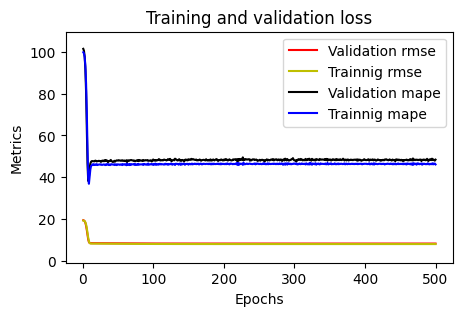

In [19]:
plotme(model1_3)
#val_loss2 = [x+1.8 for x in val_loss2]

In [32]:
# inputs: distance
model1_4 = nnmodel(10,10, num_hlayers=1,Epoch=500)
model1_4

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 797477.6875 - distance_layer_loss: 0.8044 - traveltime_layer_loss: 1329128.1250 - distance_layer_mape: 83137.8125 - distance_layer_rmse: 0.8969 - traveltime_layer_mape: 99.8924 - traveltime_layer_rmse: 1152.8782 - val_loss: 809570.8125 - val_distance_layer_loss: 3.8333 - val_traveltime_layer_loss: 1349282.2500 - val_distance_layer_mape: 1345.8391 - val_distance_layer_rmse: 1.9579 - val_traveltime_layer_mape: 99.6490 - val_traveltime_layer_rmse: 1161.5861
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 785045.5000 - distance_layer_loss: 23.9270 - traveltime_layer_loss: 1308393.3750 - distance_layer_mape: 841928.1250 - distance_layer_rmse: 4.8915 - traveltime_layer_mape: 98.7339 - traveltime_layer_rmse: 1143.8502 - val_loss: 783524.8750 - val_distance_layer_loss: 61.2651 - val_traveltime_layer_loss: 1305834.1250 - val_distance_layer_mape: 5106.4180 - val_distance_layer_rmse: 7.8272 - val

165/165 [==============================] - 0s 990us/step - loss: 145104.3281 - distance_layer_loss: 4254.8887 - traveltime_layer_loss: 239003.9375 - distance_layer_mape: 13889866.0000 - distance_layer_rmse: 65.2295 - traveltime_layer_mape: 46.0639 - traveltime_layer_rmse: 488.8803 - val_loss: 152132.6250 - val_distance_layer_loss: 4162.2383 - val_traveltime_layer_loss: 250779.4531 - val_distance_layer_mape: 41439.4414 - val_distance_layer_rmse: 64.5154 - val_traveltime_layer_mape: 45.7045 - val_traveltime_layer_rmse: 500.7788
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 144906.8906 - distance_layer_loss: 4219.4419 - traveltime_layer_loss: 238698.6250 - distance_layer_mape: 13861234.0000 - distance_layer_rmse: 64.9572 - traveltime_layer_mape: 45.8832 - traveltime_layer_rmse: 488.5679 - val_loss: 151986.9062 - val_distance_layer_loss: 4139.2627 - val_traveltime_layer_loss: 250552.0312 - val_distance_layer_mape: 41333.0977 - val_distance_layer_rmse: 64.3371 

165/165 [==============================] - 0s 949us/step - loss: 142512.0156 - distance_layer_loss: 3875.2612 - traveltime_layer_loss: 234936.5469 - distance_layer_mape: 13107058.0000 - distance_layer_rmse: 62.2516 - traveltime_layer_mape: 45.9560 - traveltime_layer_rmse: 484.7025 - val_loss: 149782.4844 - val_distance_layer_loss: 3821.4817 - val_traveltime_layer_loss: 247089.9219 - val_distance_layer_mape: 39834.8984 - val_distance_layer_rmse: 61.8181 - val_traveltime_layer_mape: 46.0388 - val_traveltime_layer_rmse: 497.0814
Epoch 32/500
165/165 [==============================] - 0s 944us/step - loss: 142337.6562 - distance_layer_loss: 3853.5491 - traveltime_layer_loss: 234660.3906 - distance_layer_mape: 13081190.0000 - distance_layer_rmse: 62.0770 - traveltime_layer_mape: 46.0149 - traveltime_layer_rmse: 484.4176 - val_loss: 149700.5625 - val_distance_layer_loss: 3783.1877 - val_traveltime_layer_loss: 246978.7500 - val_distance_layer_mape: 39643.2812 - val_distance_layer_rmse: 61.507

165/165 [==============================] - 0s 1ms/step - loss: 140491.0625 - distance_layer_loss: 3496.1970 - traveltime_layer_loss: 231820.9531 - distance_layer_mape: 12492764.0000 - distance_layer_rmse: 59.1286 - traveltime_layer_mape: 46.2362 - traveltime_layer_rmse: 481.4779 - val_loss: 148266.2188 - val_distance_layer_loss: 3411.5808 - val_traveltime_layer_loss: 244835.9219 - val_distance_layer_mape: 37746.7227 - val_distance_layer_rmse: 58.4087 - val_traveltime_layer_mape: 45.7783 - val_traveltime_layer_rmse: 494.8090
Epoch 47/500
165/165 [==============================] - 0s 967us/step - loss: 140347.5000 - distance_layer_loss: 3443.5447 - traveltime_layer_loss: 231616.6875 - distance_layer_mape: 12301838.0000 - distance_layer_rmse: 58.6817 - traveltime_layer_mape: 45.7924 - traveltime_layer_rmse: 481.2657 - val_loss: 148020.1406 - val_distance_layer_loss: 3458.6853 - val_traveltime_layer_loss: 244394.4688 - val_distance_layer_mape: 38010.0859 - val_distance_layer_rmse: 58.8106 

165/165 [==============================] - 0s 1ms/step - loss: 139183.0625 - distance_layer_loss: 3121.5061 - traveltime_layer_loss: 229890.7969 - distance_layer_mape: 11679651.0000 - distance_layer_rmse: 55.8704 - traveltime_layer_mape: 45.9326 - traveltime_layer_rmse: 479.4693 - val_loss: 147209.3750 - val_distance_layer_loss: 3077.2268 - val_traveltime_layer_loss: 243297.4844 - val_distance_layer_mape: 35929.9219 - val_distance_layer_rmse: 55.4728 - val_traveltime_layer_mape: 45.9943 - val_traveltime_layer_rmse: 493.2520
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 139130.8125 - distance_layer_loss: 3113.5439 - traveltime_layer_loss: 229808.9844 - distance_layer_mape: 11646639.0000 - distance_layer_rmse: 55.7991 - traveltime_layer_mape: 46.1583 - traveltime_layer_rmse: 479.3840 - val_loss: 147048.3594 - val_distance_layer_loss: 3089.4612 - val_traveltime_layer_loss: 243020.9531 - val_distance_layer_mape: 36004.1602 - val_distance_layer_rmse: 55.5829 - 

165/165 [==============================] - 0s 1ms/step - loss: 138333.4531 - distance_layer_loss: 2829.6553 - traveltime_layer_loss: 228669.4062 - distance_layer_mape: 11147993.0000 - distance_layer_rmse: 53.1945 - traveltime_layer_mape: 46.0034 - traveltime_layer_rmse: 478.1939 - val_loss: 146517.9375 - val_distance_layer_loss: 2817.2727 - val_traveltime_layer_loss: 242318.3594 - val_distance_layer_mape: 34435.2305 - val_distance_layer_rmse: 53.0780 - val_traveltime_layer_mape: 46.5256 - val_traveltime_layer_rmse: 492.2584
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 138272.8750 - distance_layer_loss: 2816.4016 - traveltime_layer_loss: 228577.1406 - distance_layer_mape: 11082425.0000 - distance_layer_rmse: 53.0698 - traveltime_layer_mape: 46.0721 - traveltime_layer_rmse: 478.0974 - val_loss: 146477.9062 - val_distance_layer_loss: 2805.5632 - val_traveltime_layer_loss: 242259.4844 - val_distance_layer_mape: 34366.3594 - val_distance_layer_rmse: 52.9676 - 

165/165 [==============================] - 0s 1ms/step - loss: 137872.7344 - distance_layer_loss: 2612.9771 - traveltime_layer_loss: 228045.8750 - distance_layer_mape: 10560349.0000 - distance_layer_rmse: 51.1173 - traveltime_layer_mape: 46.3003 - traveltime_layer_rmse: 477.5415 - val_loss: 146267.5000 - val_distance_layer_loss: 2574.8123 - val_traveltime_layer_loss: 242062.5938 - val_distance_layer_mape: 32959.3320 - val_distance_layer_rmse: 50.7426 - val_traveltime_layer_mape: 46.2674 - val_traveltime_layer_rmse: 491.9986
Epoch 92/500
165/165 [==============================] - 0s 960us/step - loss: 137882.7500 - distance_layer_loss: 2597.9912 - traveltime_layer_loss: 228072.5781 - distance_layer_mape: 10605876.0000 - distance_layer_rmse: 50.9705 - traveltime_layer_mape: 46.2381 - traveltime_layer_rmse: 477.5695 - val_loss: 146344.6875 - val_distance_layer_loss: 2547.6104 - val_traveltime_layer_loss: 242209.3438 - val_distance_layer_mape: 32787.7695 - val_distance_layer_rmse: 50.4739 

165/165 [==============================] - 0s 992us/step - loss: 137629.3906 - distance_layer_loss: 2426.2161 - traveltime_layer_loss: 227764.8438 - distance_layer_mape: 10287089.0000 - distance_layer_rmse: 49.2566 - traveltime_layer_mape: 46.0814 - traveltime_layer_rmse: 477.2472 - val_loss: 146050.8594 - val_distance_layer_loss: 2417.0251 - val_traveltime_layer_loss: 241806.7656 - val_distance_layer_mape: 31956.4805 - val_distance_layer_rmse: 49.1632 - val_traveltime_layer_mape: 46.5787 - val_traveltime_layer_rmse: 491.7385
Epoch 107/500
165/165 [==============================] - 0s 989us/step - loss: 137575.6094 - distance_layer_loss: 2418.8118 - traveltime_layer_loss: 227680.1719 - distance_layer_mape: 10253638.0000 - distance_layer_rmse: 49.1814 - traveltime_layer_mape: 46.1917 - traveltime_layer_rmse: 477.1584 - val_loss: 146013.7969 - val_distance_layer_loss: 2437.9475 - val_traveltime_layer_loss: 241730.9531 - val_distance_layer_mape: 32094.1582 - val_distance_layer_rmse: 49.37

165/165 [==============================] - 0s 938us/step - loss: 137443.0938 - distance_layer_loss: 2300.6289 - traveltime_layer_loss: 227538.0312 - distance_layer_mape: 9855292.0000 - distance_layer_rmse: 47.9649 - traveltime_layer_mape: 46.4474 - traveltime_layer_rmse: 477.0095 - val_loss: 146003.3906 - val_distance_layer_loss: 2266.4604 - val_traveltime_layer_loss: 241827.9531 - val_distance_layer_mape: 30961.0156 - val_distance_layer_rmse: 47.6074 - val_traveltime_layer_mape: 46.3411 - val_traveltime_layer_rmse: 491.7601
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 137469.8125 - distance_layer_loss: 2288.8835 - traveltime_layer_loss: 227590.3906 - distance_layer_mape: 9978524.0000 - distance_layer_rmse: 47.8423 - traveltime_layer_mape: 46.3981 - traveltime_layer_rmse: 477.0644 - val_loss: 145943.6875 - val_distance_layer_loss: 2269.9812 - val_traveltime_layer_loss: 241726.1250 - val_distance_layer_mape: 30985.2363 - val_distance_layer_rmse: 47.6443 -

165/165 [==============================] - 0s 930us/step - loss: 137341.8906 - distance_layer_loss: 2181.8232 - traveltime_layer_loss: 227448.5938 - distance_layer_mape: 9735670.0000 - distance_layer_rmse: 46.7100 - traveltime_layer_mape: 46.3260 - traveltime_layer_rmse: 476.9157 - val_loss: 145926.1719 - val_distance_layer_loss: 2156.4841 - val_traveltime_layer_loss: 241772.6562 - val_distance_layer_mape: 30209.4375 - val_distance_layer_rmse: 46.4380 - val_traveltime_layer_mape: 46.3674 - val_traveltime_layer_rmse: 491.7038
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 137355.3906 - distance_layer_loss: 2174.5330 - traveltime_layer_loss: 227475.9688 - distance_layer_mape: 9755870.0000 - distance_layer_rmse: 46.6319 - traveltime_layer_mape: 46.2948 - traveltime_layer_rmse: 476.9444 - val_loss: 145885.7500 - val_distance_layer_loss: 2157.2131 - val_traveltime_layer_loss: 241704.7969 - val_distance_layer_mape: 30214.2324 - val_distance_layer_rmse: 46.4458 -

165/165 [==============================] - 0s 1ms/step - loss: 137265.6719 - distance_layer_loss: 2083.1643 - traveltime_layer_loss: 227387.4375 - distance_layer_mape: 9476052.0000 - distance_layer_rmse: 45.6417 - traveltime_layer_mape: 46.2358 - traveltime_layer_rmse: 476.8516 - val_loss: 145791.8438 - val_distance_layer_loss: 2079.5142 - val_traveltime_layer_loss: 241600.0312 - val_distance_layer_mape: 29669.2559 - val_distance_layer_rmse: 45.6017 - val_traveltime_layer_mape: 46.7284 - val_traveltime_layer_rmse: 491.5283
Epoch 152/500
165/165 [==============================] - 0s 1ms/step - loss: 137334.1094 - distance_layer_loss: 2087.6577 - traveltime_layer_loss: 227498.4219 - distance_layer_mape: 9583269.0000 - distance_layer_rmse: 45.6909 - traveltime_layer_mape: 46.4655 - traveltime_layer_rmse: 476.9680 - val_loss: 145836.7188 - val_distance_layer_loss: 2060.3682 - val_traveltime_layer_loss: 241687.6562 - val_distance_layer_mape: 29533.1094 - val_distance_layer_rmse: 45.3913 - v

165/165 [==============================] - 0s 1ms/step - loss: 137233.5156 - distance_layer_loss: 2004.3284 - traveltime_layer_loss: 227386.3906 - distance_layer_mape: 9342786.0000 - distance_layer_rmse: 44.7697 - traveltime_layer_mape: 46.2652 - traveltime_layer_rmse: 476.8505 - val_loss: 145707.1250 - val_distance_layer_loss: 2017.3479 - val_traveltime_layer_loss: 241500.3594 - val_distance_layer_mape: 29223.5840 - val_distance_layer_rmse: 44.9149 - val_traveltime_layer_mape: 47.1478 - val_traveltime_layer_rmse: 491.4268
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 137181.2969 - distance_layer_loss: 2013.5630 - traveltime_layer_loss: 227293.1562 - distance_layer_mape: 9440072.0000 - distance_layer_rmse: 44.8727 - traveltime_layer_mape: 46.5952 - traveltime_layer_rmse: 476.7527 - val_loss: 145863.8281 - val_distance_layer_loss: 1968.7069 - val_traveltime_layer_loss: 241793.8906 - val_distance_layer_mape: 28871.8770 - val_distance_layer_rmse: 44.3701 - v

165/165 [==============================] - 0s 1ms/step - loss: 137224.8125 - distance_layer_loss: 1939.3496 - traveltime_layer_loss: 227415.1250 - distance_layer_mape: 9185408.0000 - distance_layer_rmse: 44.0380 - traveltime_layer_mape: 46.4127 - traveltime_layer_rmse: 476.8806 - val_loss: 145651.9844 - val_distance_layer_loss: 1946.7091 - val_traveltime_layer_loss: 241455.5156 - val_distance_layer_mape: 28708.8477 - val_distance_layer_rmse: 44.1215 - val_traveltime_layer_mape: 47.1625 - val_traveltime_layer_rmse: 491.3812
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 137242.0938 - distance_layer_loss: 1935.7798 - traveltime_layer_loss: 227446.2500 - distance_layer_mape: 9202155.0000 - distance_layer_rmse: 43.9975 - traveltime_layer_mape: 46.4432 - traveltime_layer_rmse: 476.9132 - val_loss: 145668.3438 - val_distance_layer_loss: 1924.9170 - val_traveltime_layer_loss: 241497.2656 - val_distance_layer_mape: 28549.0195 - val_distance_layer_rmse: 43.8739 - v

165/165 [==============================] - 0s 1ms/step - loss: 137145.1875 - distance_layer_loss: 1879.2445 - traveltime_layer_loss: 227322.3438 - distance_layer_mape: 9032461.0000 - distance_layer_rmse: 43.3503 - traveltime_layer_mape: 46.5230 - traveltime_layer_rmse: 476.7833 - val_loss: 145647.2344 - val_distance_layer_loss: 1855.5194 - val_traveltime_layer_loss: 241508.4375 - val_distance_layer_mape: 28030.0059 - val_distance_layer_rmse: 43.0757 - val_traveltime_layer_mape: 46.4781 - val_traveltime_layer_rmse: 491.4351
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 137141.2031 - distance_layer_loss: 1861.6866 - traveltime_layer_loss: 227327.5312 - distance_layer_mape: 9013588.0000 - distance_layer_rmse: 43.1473 - traveltime_layer_mape: 46.1792 - traveltime_layer_rmse: 476.7888 - val_loss: 145598.8438 - val_distance_layer_loss: 1863.7126 - val_traveltime_layer_loss: 241422.3125 - val_distance_layer_mape: 28091.1523 - val_distance_layer_rmse: 43.1707 - v

165/165 [==============================] - 0s 946us/step - loss: 137191.1406 - distance_layer_loss: 1803.5951 - traveltime_layer_loss: 227449.4844 - distance_layer_mape: 8859491.0000 - distance_layer_rmse: 42.4688 - traveltime_layer_mape: 46.0834 - traveltime_layer_rmse: 476.9167 - val_loss: 145645.0469 - val_distance_layer_loss: 1789.6287 - val_traveltime_layer_loss: 241548.6406 - val_distance_layer_mape: 27528.0586 - val_distance_layer_rmse: 42.3040 - val_traveltime_layer_mape: 46.2533 - val_traveltime_layer_rmse: 491.4760
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 137131.4688 - distance_layer_loss: 1812.5540 - traveltime_layer_loss: 227344.1094 - distance_layer_mape: 8865542.0000 - distance_layer_rmse: 42.5741 - traveltime_layer_mape: 46.3997 - traveltime_layer_rmse: 476.8062 - val_loss: 145634.8594 - val_distance_layer_loss: 1788.1248 - val_traveltime_layer_loss: 241532.7188 - val_distance_layer_mape: 27516.5879 - val_distance_layer_rmse: 42.2862 -

165/165 [==============================] - 0s 1ms/step - loss: 137196.8750 - distance_layer_loss: 1763.9178 - traveltime_layer_loss: 227485.4531 - distance_layer_mape: 8749990.0000 - distance_layer_rmse: 41.9990 - traveltime_layer_mape: 46.4278 - traveltime_layer_rmse: 476.9543 - val_loss: 145622.7188 - val_distance_layer_loss: 1735.1433 - val_traveltime_layer_loss: 241547.7031 - val_distance_layer_mape: 27106.0801 - val_distance_layer_rmse: 41.6551 - val_traveltime_layer_mape: 46.1836 - val_traveltime_layer_rmse: 491.4750
Epoch 227/500
165/165 [==============================] - 0s 1ms/step - loss: 137129.5156 - distance_layer_loss: 1757.1376 - traveltime_layer_loss: 227377.7188 - distance_layer_mape: 8733170.0000 - distance_layer_rmse: 41.9182 - traveltime_layer_mape: 46.3481 - traveltime_layer_rmse: 476.8414 - val_loss: 145636.8750 - val_distance_layer_loss: 1729.4957 - val_traveltime_layer_loss: 241575.1875 - val_distance_layer_mape: 27062.1934 - val_distance_layer_rmse: 41.5872 - v

165/165 [==============================] - 0s 948us/step - loss: 137075.3125 - distance_layer_loss: 1706.1367 - traveltime_layer_loss: 227321.4375 - distance_layer_mape: 8623005.0000 - distance_layer_rmse: 41.3054 - traveltime_layer_mape: 46.1850 - traveltime_layer_rmse: 476.7824 - val_loss: 145538.8125 - val_distance_layer_loss: 1693.4727 - val_traveltime_layer_loss: 241435.6719 - val_distance_layer_mape: 26778.4453 - val_distance_layer_rmse: 41.1518 - val_traveltime_layer_mape: 46.3601 - val_traveltime_layer_rmse: 491.3611
Epoch 242/500
165/165 [==============================] - 0s 975us/step - loss: 137075.2031 - distance_layer_loss: 1707.0078 - traveltime_layer_loss: 227320.8125 - distance_layer_mape: 8623065.0000 - distance_layer_rmse: 41.3160 - traveltime_layer_mape: 46.2815 - traveltime_layer_rmse: 476.7817 - val_loss: 145482.2188 - val_distance_layer_loss: 1698.2980 - val_traveltime_layer_loss: 241338.1562 - val_distance_layer_mape: 26815.3086 - val_distance_layer_rmse: 41.2104

165/165 [==============================] - 0s 1ms/step - loss: 137027.8125 - distance_layer_loss: 1669.1768 - traveltime_layer_loss: 227266.8438 - distance_layer_mape: 8540319.0000 - distance_layer_rmse: 40.8556 - traveltime_layer_mape: 46.4252 - traveltime_layer_rmse: 476.7251 - val_loss: 145451.0469 - val_distance_layer_loss: 1655.3186 - val_traveltime_layer_loss: 241314.9062 - val_distance_layer_mape: 26473.6523 - val_distance_layer_rmse: 40.6856 - val_traveltime_layer_mape: 46.5616 - val_traveltime_layer_rmse: 491.2381
Epoch 257/500
165/165 [==============================] - 0s 971us/step - loss: 137047.4062 - distance_layer_loss: 1661.9825 - traveltime_layer_loss: 227304.2812 - distance_layer_mape: 8527797.0000 - distance_layer_rmse: 40.7674 - traveltime_layer_mape: 46.3183 - traveltime_layer_rmse: 476.7644 - val_loss: 145423.3906 - val_distance_layer_loss: 1659.8546 - val_traveltime_layer_loss: 241265.7188 - val_distance_layer_mape: 26509.6270 - val_distance_layer_rmse: 40.7413 -

165/165 [==============================] - 0s 953us/step - loss: 137014.0156 - distance_layer_loss: 1622.6401 - traveltime_layer_loss: 227275.0000 - distance_layer_mape: 8379361.0000 - distance_layer_rmse: 40.2820 - traveltime_layer_mape: 46.3310 - traveltime_layer_rmse: 476.7337 - val_loss: 145389.5469 - val_distance_layer_loss: 1620.8800 - val_traveltime_layer_loss: 241235.3281 - val_distance_layer_mape: 26196.0566 - val_distance_layer_rmse: 40.2602 - val_traveltime_layer_mape: 46.7869 - val_traveltime_layer_rmse: 491.1571
Epoch 272/500
165/165 [==============================] - 0s 934us/step - loss: 137025.9062 - distance_layer_loss: 1619.9290 - traveltime_layer_loss: 227296.4688 - distance_layer_mape: 8357078.5000 - distance_layer_rmse: 40.2483 - traveltime_layer_mape: 46.3321 - traveltime_layer_rmse: 476.7562 - val_loss: 145391.1250 - val_distance_layer_loss: 1616.9414 - val_traveltime_layer_loss: 241240.5938 - val_distance_layer_mape: 26164.4453 - val_distance_layer_rmse: 40.2112

165/165 [==============================] - 0s 1ms/step - loss: 137008.4688 - distance_layer_loss: 1578.9556 - traveltime_layer_loss: 227294.8125 - distance_layer_mape: 8265293.5000 - distance_layer_rmse: 39.7361 - traveltime_layer_mape: 46.2659 - traveltime_layer_rmse: 476.7545 - val_loss: 145455.2812 - val_distance_layer_loss: 1560.4275 - val_traveltime_layer_loss: 241385.1875 - val_distance_layer_mape: 25703.9824 - val_distance_layer_rmse: 39.5022 - val_traveltime_layer_mape: 46.2300 - val_traveltime_layer_rmse: 491.3097
Epoch 287/500
165/165 [==============================] - 0s 945us/step - loss: 137053.1250 - distance_layer_loss: 1576.5502 - traveltime_layer_loss: 227370.8125 - distance_layer_mape: 8298466.5000 - distance_layer_rmse: 39.7058 - traveltime_layer_mape: 46.2619 - traveltime_layer_rmse: 476.8342 - val_loss: 145388.8438 - val_distance_layer_loss: 1567.7604 - val_traveltime_layer_loss: 241269.5469 - val_distance_layer_mape: 25763.6035 - val_distance_layer_rmse: 39.5950 -

165/165 [==============================] - 0s 931us/step - loss: 136992.8906 - distance_layer_loss: 1538.2697 - traveltime_layer_loss: 227296.0000 - distance_layer_mape: 8197376.5000 - distance_layer_rmse: 39.2208 - traveltime_layer_mape: 46.1867 - traveltime_layer_rmse: 476.7557 - val_loss: 145365.1562 - val_distance_layer_loss: 1531.1241 - val_traveltime_layer_loss: 241254.5625 - val_distance_layer_mape: 25460.6133 - val_distance_layer_rmse: 39.1296 - val_traveltime_layer_mape: 46.4785 - val_traveltime_layer_rmse: 491.1767
Epoch 302/500
165/165 [==============================] - 0s 972us/step - loss: 136988.7031 - distance_layer_loss: 1542.0431 - traveltime_layer_loss: 227286.4688 - distance_layer_mape: 8182824.5000 - distance_layer_rmse: 39.2689 - traveltime_layer_mape: 46.3781 - traveltime_layer_rmse: 476.7457 - val_loss: 145349.6875 - val_distance_layer_loss: 1530.9130 - val_traveltime_layer_loss: 241228.9219 - val_distance_layer_mape: 25458.4902 - val_distance_layer_rmse: 39.1269

165/165 [==============================] - 0s 980us/step - loss: 136971.1406 - distance_layer_loss: 1509.3743 - traveltime_layer_loss: 227278.9688 - distance_layer_mape: 8085994.0000 - distance_layer_rmse: 38.8507 - traveltime_layer_mape: 46.4023 - traveltime_layer_rmse: 476.7379 - val_loss: 145391.2188 - val_distance_layer_loss: 1487.5853 - val_traveltime_layer_loss: 241327.0000 - val_distance_layer_mape: 25096.4688 - val_distance_layer_rmse: 38.5692 - val_traveltime_layer_mape: 46.2487 - val_traveltime_layer_rmse: 491.2505
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 136974.9219 - distance_layer_loss: 1501.2058 - traveltime_layer_loss: 227290.6250 - distance_layer_mape: 8077285.0000 - distance_layer_rmse: 38.7454 - traveltime_layer_mape: 46.2363 - traveltime_layer_rmse: 476.7501 - val_loss: 145345.0469 - val_distance_layer_loss: 1491.8250 - val_traveltime_layer_loss: 241247.1406 - val_distance_layer_mape: 25131.7676 - val_distance_layer_rmse: 38.6241 -

165/165 [==============================] - 0s 1ms/step - loss: 136968.9219 - distance_layer_loss: 1477.0018 - traveltime_layer_loss: 227296.7969 - distance_layer_mape: 8066575.0000 - distance_layer_rmse: 38.4318 - traveltime_layer_mape: 46.4519 - traveltime_layer_rmse: 476.7565 - val_loss: 145284.4688 - val_distance_layer_loss: 1468.1807 - val_traveltime_layer_loss: 241162.0312 - val_distance_layer_mape: 24931.0645 - val_distance_layer_rmse: 38.3168 - val_traveltime_layer_mape: 46.6712 - val_traveltime_layer_rmse: 491.0825
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 136925.2031 - distance_layer_loss: 1464.1786 - traveltime_layer_loss: 227232.5312 - distance_layer_mape: 7965047.0000 - distance_layer_rmse: 38.2646 - traveltime_layer_mape: 46.1111 - traveltime_layer_rmse: 476.6891 - val_loss: 145260.3125 - val_distance_layer_loss: 1475.0148 - val_traveltime_layer_loss: 241117.1875 - val_distance_layer_mape: 24988.0977 - val_distance_layer_rmse: 38.4059 - v

165/165 [==============================] - 0s 929us/step - loss: 136898.1875 - distance_layer_loss: 1448.7933 - traveltime_layer_loss: 227197.6875 - distance_layer_mape: 7894600.0000 - distance_layer_rmse: 38.0630 - traveltime_layer_mape: 46.5928 - traveltime_layer_rmse: 476.6526 - val_loss: 145417.5312 - val_distance_layer_loss: 1414.1241 - val_traveltime_layer_loss: 241419.7500 - val_distance_layer_mape: 24469.2363 - val_distance_layer_rmse: 37.6048 - val_traveltime_layer_mape: 46.0009 - val_traveltime_layer_rmse: 491.3448
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 136903.3594 - distance_layer_loss: 1427.0787 - traveltime_layer_loss: 227220.9688 - distance_layer_mape: 7844541.5000 - distance_layer_rmse: 37.7767 - traveltime_layer_mape: 45.9709 - traveltime_layer_rmse: 476.6770 - val_loss: 145243.4219 - val_distance_layer_loss: 1444.8833 - val_traveltime_layer_loss: 241109.0781 - val_distance_layer_mape: 24731.7422 - val_distance_layer_rmse: 38.0116 -

165/165 [==============================] - 0s 936us/step - loss: 136930.1250 - distance_layer_loss: 1415.6630 - traveltime_layer_loss: 227273.1406 - distance_layer_mape: 7921610.5000 - distance_layer_rmse: 37.6253 - traveltime_layer_mape: 46.5550 - traveltime_layer_rmse: 476.7317 - val_loss: 145395.3750 - val_distance_layer_loss: 1382.8298 - val_traveltime_layer_loss: 241403.7188 - val_distance_layer_mape: 24197.4883 - val_distance_layer_rmse: 37.1864 - val_traveltime_layer_mape: 46.0182 - val_traveltime_layer_rmse: 491.3285
Epoch 362/500
165/165 [==============================] - 0s 927us/step - loss: 136965.7812 - distance_layer_loss: 1406.3304 - traveltime_layer_loss: 227338.7812 - distance_layer_mape: 7799844.5000 - distance_layer_rmse: 37.5011 - traveltime_layer_mape: 46.3336 - traveltime_layer_rmse: 476.8006 - val_loss: 145391.5938 - val_distance_layer_loss: 1380.9034 - val_traveltime_layer_loss: 241398.7344 - val_distance_layer_mape: 24180.2871 - val_distance_layer_rmse: 37.1605

165/165 [==============================] - 0s 992us/step - loss: 136903.8438 - distance_layer_loss: 1386.4294 - traveltime_layer_loss: 227248.8438 - distance_layer_mape: 7773648.0000 - distance_layer_rmse: 37.2348 - traveltime_layer_mape: 46.5983 - traveltime_layer_rmse: 476.7062 - val_loss: 145453.0156 - val_distance_layer_loss: 1347.1685 - val_traveltime_layer_loss: 241523.5938 - val_distance_layer_mape: 23883.7812 - val_distance_layer_rmse: 36.7038 - val_traveltime_layer_mape: 45.8101 - val_traveltime_layer_rmse: 491.4505
Epoch 377/500
165/165 [==============================] - 0s 994us/step - loss: 136985.0000 - distance_layer_loss: 1373.4601 - traveltime_layer_loss: 227392.6562 - distance_layer_mape: 7782697.0000 - distance_layer_rmse: 37.0602 - traveltime_layer_mape: 46.2291 - traveltime_layer_rmse: 476.8571 - val_loss: 145291.4062 - val_distance_layer_loss: 1359.9058 - val_traveltime_layer_loss: 241245.6875 - val_distance_layer_mape: 23995.2695 - val_distance_layer_rmse: 36.8769

165/165 [==============================] - 0s 1ms/step - loss: 136911.0938 - distance_layer_loss: 1348.6428 - traveltime_layer_loss: 227285.9844 - distance_layer_mape: 7631956.0000 - distance_layer_rmse: 36.7239 - traveltime_layer_mape: 46.2677 - traveltime_layer_rmse: 476.7452 - val_loss: 145257.0156 - val_distance_layer_loss: 1336.4043 - val_traveltime_layer_loss: 241204.0938 - val_distance_layer_mape: 23787.2070 - val_distance_layer_rmse: 36.5569 - val_traveltime_layer_mape: 46.3595 - val_traveltime_layer_rmse: 491.1253
Epoch 392/500
165/165 [==============================] - 0s 982us/step - loss: 136901.5469 - distance_layer_loss: 1346.4661 - traveltime_layer_loss: 227271.6719 - distance_layer_mape: 7695851.5000 - distance_layer_rmse: 36.6942 - traveltime_layer_mape: 46.2850 - traveltime_layer_rmse: 476.7302 - val_loss: 145207.2656 - val_distance_layer_loss: 1344.4686 - val_traveltime_layer_loss: 241115.7969 - val_distance_layer_mape: 23858.5723 - val_distance_layer_rmse: 36.6670 -

165/165 [==============================] - 0s 1ms/step - loss: 136922.4844 - distance_layer_loss: 1317.3574 - traveltime_layer_loss: 227325.8438 - distance_layer_mape: 7579414.5000 - distance_layer_rmse: 36.2954 - traveltime_layer_mape: 46.1686 - traveltime_layer_rmse: 476.7870 - val_loss: 145191.2500 - val_distance_layer_loss: 1319.6129 - val_traveltime_layer_loss: 241105.7031 - val_distance_layer_mape: 23637.0859 - val_distance_layer_rmse: 36.3265 - val_traveltime_layer_mape: 46.6991 - val_traveltime_layer_rmse: 491.0251
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 136900.3906 - distance_layer_loss: 1322.0476 - traveltime_layer_loss: 227285.8906 - distance_layer_mape: 7598061.5000 - distance_layer_rmse: 36.3600 - traveltime_layer_mape: 46.3841 - traveltime_layer_rmse: 476.7451 - val_loss: 145207.4375 - val_distance_layer_loss: 1312.9229 - val_traveltime_layer_loss: 241137.0938 - val_distance_layer_mape: 23577.2539 - val_distance_layer_rmse: 36.2343 - v

165/165 [==============================] - 0s 1ms/step - loss: 136933.2656 - distance_layer_loss: 1292.4917 - traveltime_layer_loss: 227360.4062 - distance_layer_mape: 7479545.5000 - distance_layer_rmse: 35.9512 - traveltime_layer_mape: 46.2006 - traveltime_layer_rmse: 476.8232 - val_loss: 145248.5312 - val_distance_layer_loss: 1280.5133 - val_traveltime_layer_loss: 241227.1406 - val_distance_layer_mape: 23285.4609 - val_distance_layer_rmse: 35.7843 - val_traveltime_layer_mape: 46.2703 - val_traveltime_layer_rmse: 491.1488
Epoch 422/500
165/165 [==============================] - 0s 997us/step - loss: 136904.2656 - distance_layer_loss: 1293.7115 - traveltime_layer_loss: 227311.3281 - distance_layer_mape: 7498158.5000 - distance_layer_rmse: 35.9682 - traveltime_layer_mape: 46.2994 - traveltime_layer_rmse: 476.7718 - val_loss: 145216.3750 - val_distance_layer_loss: 1282.3416 - val_traveltime_layer_loss: 241172.3906 - val_distance_layer_mape: 23301.4883 - val_distance_layer_rmse: 35.8098 -

165/165 [==============================] - 0s 1ms/step - loss: 136893.6250 - distance_layer_loss: 1272.4258 - traveltime_layer_loss: 227307.7656 - distance_layer_mape: 7493166.5000 - distance_layer_rmse: 35.6711 - traveltime_layer_mape: 46.3982 - traveltime_layer_rmse: 476.7680 - val_loss: 145238.6562 - val_distance_layer_loss: 1254.9645 - val_traveltime_layer_loss: 241227.8125 - val_distance_layer_mape: 23052.2656 - val_distance_layer_rmse: 35.4255 - val_traveltime_layer_mape: 46.2504 - val_traveltime_layer_rmse: 491.1495
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 136858.9062 - distance_layer_loss: 1267.0815 - traveltime_layer_loss: 227253.5312 - distance_layer_mape: 7486528.5000 - distance_layer_rmse: 35.5961 - traveltime_layer_mape: 46.2629 - traveltime_layer_rmse: 476.7112 - val_loss: 145167.6719 - val_distance_layer_loss: 1263.5312 - val_traveltime_layer_loss: 241103.7188 - val_distance_layer_mape: 23130.0195 - val_distance_layer_rmse: 35.5462 - v

165/165 [==============================] - 0s 1ms/step - loss: 136909.5625 - distance_layer_loss: 1250.7103 - traveltime_layer_loss: 227348.7812 - distance_layer_mape: 7417315.5000 - distance_layer_rmse: 35.3654 - traveltime_layer_mape: 46.4449 - traveltime_layer_rmse: 476.8111 - val_loss: 145136.5781 - val_distance_layer_loss: 1245.8522 - val_traveltime_layer_loss: 241063.7188 - val_distance_layer_mape: 22967.3613 - val_distance_layer_rmse: 35.2966 - val_traveltime_layer_mape: 46.7550 - val_traveltime_layer_rmse: 490.9824
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 136908.9219 - distance_layer_loss: 1245.7722 - traveltime_layer_loss: 227350.9688 - distance_layer_mape: 7312822.5000 - distance_layer_rmse: 35.2955 - traveltime_layer_mape: 46.3549 - traveltime_layer_rmse: 476.8134 - val_loss: 145133.8594 - val_distance_layer_loss: 1243.4540 - val_traveltime_layer_loss: 241060.7812 - val_distance_layer_mape: 22945.0762 - val_distance_layer_rmse: 35.2626 - v

165/165 [==============================] - 0s 999us/step - loss: 136862.3750 - distance_layer_loss: 1221.1409 - traveltime_layer_loss: 227289.7344 - distance_layer_mape: 7282527.0000 - distance_layer_rmse: 34.9448 - traveltime_layer_mape: 46.2494 - traveltime_layer_rmse: 476.7491 - val_loss: 145240.3438 - val_distance_layer_loss: 1205.2356 - val_traveltime_layer_loss: 241263.7656 - val_distance_layer_mape: 22591.8359 - val_distance_layer_rmse: 34.7165 - val_traveltime_layer_mape: 46.1466 - val_traveltime_layer_rmse: 491.1861
Epoch 467/500
165/165 [==============================] - 0s 973us/step - loss: 136861.3281 - distance_layer_loss: 1221.5652 - traveltime_layer_loss: 227287.8125 - distance_layer_mape: 7306476.5000 - distance_layer_rmse: 34.9509 - traveltime_layer_mape: 46.3004 - traveltime_layer_rmse: 476.7471 - val_loss: 145184.1719 - val_distance_layer_loss: 1210.0485 - val_traveltime_layer_loss: 241166.8438 - val_distance_layer_mape: 22636.3242 - val_distance_layer_rmse: 34.7858

165/165 [==============================] - 0s 949us/step - loss: 136913.4219 - distance_layer_loss: 1200.1967 - traveltime_layer_loss: 227388.9219 - distance_layer_mape: 7278746.5000 - distance_layer_rmse: 34.6439 - traveltime_layer_mape: 46.2902 - traveltime_layer_rmse: 476.8531 - val_loss: 145111.5781 - val_distance_layer_loss: 1200.1426 - val_traveltime_layer_loss: 241052.4375 - val_distance_layer_mape: 22542.9199 - val_distance_layer_rmse: 34.6431 - val_traveltime_layer_mape: 46.7590 - val_traveltime_layer_rmse: 490.9709
Epoch 482/500
165/165 [==============================] - 0s 982us/step - loss: 136852.4062 - distance_layer_loss: 1201.1675 - traveltime_layer_loss: 227286.5938 - distance_layer_mape: 7232617.5000 - distance_layer_rmse: 34.6579 - traveltime_layer_mape: 46.3892 - traveltime_layer_rmse: 476.7458 - val_loss: 145166.8438 - val_distance_layer_loss: 1188.2174 - val_traveltime_layer_loss: 241152.5625 - val_distance_layer_mape: 22431.5918 - val_distance_layer_rmse: 34.4705

165/165 [==============================] - 0s 1ms/step - loss: 136860.0625 - distance_layer_loss: 1176.0537 - traveltime_layer_loss: 227316.1250 - distance_layer_mape: 7078091.5000 - distance_layer_rmse: 34.2936 - traveltime_layer_mape: 46.2014 - traveltime_layer_rmse: 476.7768 - val_loss: 145148.5469 - val_distance_layer_loss: 1169.2487 - val_traveltime_layer_loss: 241134.7500 - val_distance_layer_mape: 22252.2363 - val_distance_layer_rmse: 34.1943 - val_traveltime_layer_mape: 46.4166 - val_traveltime_layer_rmse: 491.0547
Epoch 497/500
165/165 [==============================] - 0s 980us/step - loss: 136787.5469 - distance_layer_loss: 1170.8578 - traveltime_layer_loss: 227198.6094 - distance_layer_mape: 7095431.5000 - distance_layer_rmse: 34.2178 - traveltime_layer_mape: 46.0328 - traveltime_layer_rmse: 476.6536 - val_loss: 145102.4375 - val_distance_layer_loss: 1190.4460 - val_traveltime_layer_loss: 241043.8281 - val_distance_layer_mape: 22450.9336 - val_distance_layer_rmse: 34.5028 -

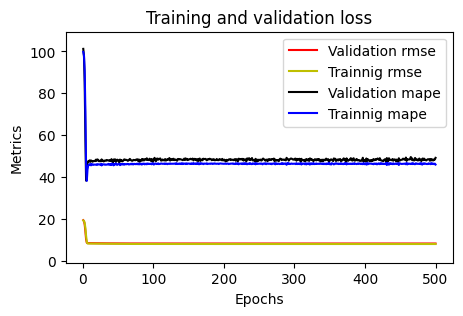

In [21]:
plotme(model1_4)

In [37]:
# inputs: distance
model1_5 = nnmodel(20,30, num_hlayers=1,Epoch=500)
model1_5

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 794633.5625 - distance_layer_loss: 5.3733 - traveltime_layer_loss: 1324385.2500 - distance_layer_mape: 289545.7188 - distance_layer_rmse: 2.3180 - traveltime_layer_mape: 99.6409 - traveltime_layer_rmse: 1150.8193 - val_loss: 797627.1250 - val_distance_layer_loss: 25.4539 - val_traveltime_layer_loss: 1329361.7500 - val_distance_layer_mape: 3321.5029 - val_distance_layer_rmse: 5.0452 - val_traveltime_layer_mape: 98.5429 - val_traveltime_layer_rmse: 1152.9795
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 723231.3750 - distance_layer_loss: 150.7522 - traveltime_layer_loss: 1205284.5000 - distance_layer_mape: 2779839.5000 - distance_layer_rmse: 12.2781 - traveltime_layer_mape: 92.7758 - traveltime_layer_rmse: 1097.8545 - val_loss: 632033.5000 - val_distance_layer_loss: 382.9996 - val_traveltime_layer_loss: 1053133.7500 - val_distance_layer_mape: 12613.9678 - val_distance_layer_rmse: 19.57

165/165 [==============================] - 0s 1ms/step - loss: 142946.1719 - distance_layer_loss: 2440.6699 - traveltime_layer_loss: 236616.4844 - distance_layer_mape: 10538882.0000 - distance_layer_rmse: 49.4031 - traveltime_layer_mape: 45.9445 - traveltime_layer_rmse: 486.4324 - val_loss: 150018.9844 - val_distance_layer_loss: 2426.5962 - val_traveltime_layer_loss: 248414.0000 - val_distance_layer_mape: 31716.3105 - val_distance_layer_rmse: 49.2605 - val_traveltime_layer_mape: 46.5988 - val_traveltime_layer_rmse: 498.4115
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 142647.3750 - distance_layer_loss: 2414.2288 - traveltime_layer_loss: 236136.0938 - distance_layer_mape: 10370887.0000 - distance_layer_rmse: 49.1348 - traveltime_layer_mape: 45.7744 - traveltime_layer_rmse: 485.9384 - val_loss: 149849.2188 - val_distance_layer_loss: 2429.9551 - val_traveltime_layer_loss: 248128.7344 - val_distance_layer_mape: 31748.7637 - val_distance_layer_rmse: 49.2946 - 

165/165 [==============================] - 0s 1ms/step - loss: 139773.7344 - distance_layer_loss: 2121.0537 - traveltime_layer_loss: 231542.1875 - distance_layer_mape: 9606423.0000 - distance_layer_rmse: 46.0549 - traveltime_layer_mape: 46.2546 - traveltime_layer_rmse: 481.1883 - val_loss: 147670.2344 - val_distance_layer_loss: 2059.5032 - val_traveltime_layer_loss: 244744.0781 - val_distance_layer_mape: 29356.5234 - val_distance_layer_rmse: 45.3817 - val_traveltime_layer_mape: 45.5831 - val_traveltime_layer_rmse: 494.7162
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 139676.7031 - distance_layer_loss: 2084.3503 - traveltime_layer_loss: 231404.9062 - distance_layer_mape: 9585419.0000 - distance_layer_rmse: 45.6547 - traveltime_layer_mape: 45.8385 - traveltime_layer_rmse: 481.0456 - val_loss: 147324.7344 - val_distance_layer_loss: 2098.2893 - val_traveltime_layer_loss: 244142.3750 - val_distance_layer_mape: 29636.4453 - val_distance_layer_rmse: 45.8071 - va

165/165 [==============================] - 0s 1ms/step - loss: 138104.7188 - distance_layer_loss: 1822.7101 - traveltime_layer_loss: 228959.4219 - distance_layer_mape: 8847974.0000 - distance_layer_rmse: 42.6932 - traveltime_layer_mape: 46.4606 - traveltime_layer_rmse: 478.4970 - val_loss: 146475.3594 - val_distance_layer_loss: 1766.1688 - val_traveltime_layer_loss: 242948.2188 - val_distance_layer_mape: 27274.4102 - val_distance_layer_rmse: 42.0258 - val_traveltime_layer_mape: 45.6244 - val_traveltime_layer_rmse: 492.8978
Epoch 47/500
165/165 [==============================] - 0s 1ms/step - loss: 138055.0156 - distance_layer_loss: 1791.1826 - traveltime_layer_loss: 228897.5781 - distance_layer_mape: 8831060.0000 - distance_layer_rmse: 42.3224 - traveltime_layer_mape: 46.0076 - traveltime_layer_rmse: 478.4324 - val_loss: 146235.2969 - val_distance_layer_loss: 1767.8540 - val_traveltime_layer_loss: 242546.9375 - val_distance_layer_mape: 27290.9668 - val_distance_layer_rmse: 42.0459 - va

165/165 [==============================] - 0s 1ms/step - loss: 137414.2031 - distance_layer_loss: 1606.0881 - traveltime_layer_loss: 227952.9531 - distance_layer_mape: 8471548.0000 - distance_layer_rmse: 40.0760 - traveltime_layer_mape: 46.3033 - traveltime_layer_rmse: 477.4442 - val_loss: 145855.6562 - val_distance_layer_loss: 1580.1541 - val_traveltime_layer_loss: 242039.2969 - val_distance_layer_mape: 25845.2266 - val_distance_layer_rmse: 39.7512 - val_traveltime_layer_mape: 46.2122 - val_traveltime_layer_rmse: 491.9749
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 137433.7969 - distance_layer_loss: 1594.4490 - traveltime_layer_loss: 227993.2969 - distance_layer_mape: 8368129.5000 - distance_layer_rmse: 39.9306 - traveltime_layer_mape: 46.2743 - traveltime_layer_rmse: 477.4865 - val_loss: 145720.5000 - val_distance_layer_loss: 1591.9686 - val_traveltime_layer_loss: 241806.2500 - val_distance_layer_mape: 25941.7012 - val_distance_layer_rmse: 39.8995 - va

165/165 [==============================] - 0s 979us/step - loss: 137198.8281 - distance_layer_loss: 1471.0964 - traveltime_layer_loss: 227683.9375 - distance_layer_mape: 8055726.5000 - distance_layer_rmse: 38.3549 - traveltime_layer_mape: 46.4673 - traveltime_layer_rmse: 477.1624 - val_loss: 145829.8281 - val_distance_layer_loss: 1436.1406 - val_traveltime_layer_loss: 242092.2500 - val_distance_layer_mape: 24663.0039 - val_distance_layer_rmse: 37.8964 - val_traveltime_layer_mape: 45.8834 - val_traveltime_layer_rmse: 492.0287
Epoch 77/500
165/165 [==============================] - 0s 994us/step - loss: 137142.7969 - distance_layer_loss: 1457.1547 - traveltime_layer_loss: 227599.9219 - distance_layer_mape: 7883906.0000 - distance_layer_rmse: 38.1727 - traveltime_layer_mape: 46.1942 - traveltime_layer_rmse: 477.0743 - val_loss: 145670.5469 - val_distance_layer_loss: 1441.4418 - val_traveltime_layer_loss: 241823.3125 - val_distance_layer_mape: 24708.4004 - val_distance_layer_rmse: 37.9663 

165/165 [==============================] - 0s 1ms/step - loss: 137079.2344 - distance_layer_loss: 1372.2922 - traveltime_layer_loss: 227550.5469 - distance_layer_mape: 7710976.5000 - distance_layer_rmse: 37.0445 - traveltime_layer_mape: 46.2563 - traveltime_layer_rmse: 477.0226 - val_loss: 145551.7500 - val_distance_layer_loss: 1361.6384 - val_traveltime_layer_loss: 241678.5000 - val_distance_layer_mape: 24023.6523 - val_distance_layer_rmse: 36.9004 - val_traveltime_layer_mape: 46.5129 - val_traveltime_layer_rmse: 491.6081
Epoch 92/500
165/165 [==============================] - 0s 990us/step - loss: 137093.7500 - distance_layer_loss: 1370.4847 - traveltime_layer_loss: 227575.9375 - distance_layer_mape: 7675613.0000 - distance_layer_rmse: 37.0201 - traveltime_layer_mape: 46.3926 - traveltime_layer_rmse: 477.0492 - val_loss: 145488.1875 - val_distance_layer_loss: 1367.9785 - val_traveltime_layer_loss: 241568.3281 - val_distance_layer_mape: 24078.6816 - val_distance_layer_rmse: 36.9862 - 

165/165 [==============================] - 0s 994us/step - loss: 137029.3281 - distance_layer_loss: 1310.2202 - traveltime_layer_loss: 227508.7031 - distance_layer_mape: 7592140.5000 - distance_layer_rmse: 36.1970 - traveltime_layer_mape: 46.5561 - traveltime_layer_rmse: 476.9787 - val_loss: 145752.5156 - val_distance_layer_loss: 1272.7748 - val_traveltime_layer_loss: 242072.3438 - val_distance_layer_mape: 23231.9590 - val_distance_layer_rmse: 35.6760 - val_traveltime_layer_mape: 45.7068 - val_traveltime_layer_rmse: 492.0085
Epoch 107/500
165/165 [==============================] - 0s 1ms/step - loss: 136999.8906 - distance_layer_loss: 1303.9922 - traveltime_layer_loss: 227464.0000 - distance_layer_mape: 7585264.0000 - distance_layer_rmse: 36.1108 - traveltime_layer_mape: 46.4648 - traveltime_layer_rmse: 476.9319 - val_loss: 145764.8750 - val_distance_layer_loss: 1268.6232 - val_traveltime_layer_loss: 242095.7031 - val_distance_layer_mape: 23194.0508 - val_distance_layer_rmse: 35.6177 -

165/165 [==============================] - 0s 1ms/step - loss: 136870.0000 - distance_layer_loss: 1258.7002 - traveltime_layer_loss: 227277.5781 - distance_layer_mape: 7499142.5000 - distance_layer_rmse: 35.4782 - traveltime_layer_mape: 46.7228 - traveltime_layer_rmse: 476.7364 - val_loss: 145677.3125 - val_distance_layer_loss: 1218.9481 - val_traveltime_layer_loss: 241982.8594 - val_distance_layer_mape: 22736.5684 - val_distance_layer_rmse: 34.9134 - val_traveltime_layer_mape: 45.7083 - val_traveltime_layer_rmse: 491.9175
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 136915.3438 - distance_layer_loss: 1237.5554 - traveltime_layer_loss: 227367.2344 - distance_layer_mape: 7354191.5000 - distance_layer_rmse: 35.1789 - traveltime_layer_mape: 45.9849 - traveltime_layer_rmse: 476.8304 - val_loss: 145364.6250 - val_distance_layer_loss: 1257.3324 - val_traveltime_layer_loss: 241436.1094 - val_distance_layer_mape: 23088.3203 - val_distance_layer_rmse: 35.4589 - v

165/165 [==============================] - 0s 1ms/step - loss: 136875.0625 - distance_layer_loss: 1196.5416 - traveltime_layer_loss: 227327.2969 - distance_layer_mape: 7210663.5000 - distance_layer_rmse: 34.5911 - traveltime_layer_mape: 46.1607 - traveltime_layer_rmse: 476.7885 - val_loss: 145280.0938 - val_distance_layer_loss: 1206.2881 - val_traveltime_layer_loss: 241329.3594 - val_distance_layer_mape: 22615.1387 - val_distance_layer_rmse: 34.7317 - val_traveltime_layer_mape: 47.1891 - val_traveltime_layer_rmse: 491.2528
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 136937.4375 - distance_layer_loss: 1201.3954 - traveltime_layer_loss: 227428.1719 - distance_layer_mape: 7294278.5000 - distance_layer_rmse: 34.6612 - traveltime_layer_mape: 46.5234 - traveltime_layer_rmse: 476.8943 - val_loss: 145285.8594 - val_distance_layer_loss: 1203.2932 - val_traveltime_layer_loss: 241340.9375 - val_distance_layer_mape: 22587.6152 - val_distance_layer_rmse: 34.6885 - v

165/165 [==============================] - 0s 1ms/step - loss: 136883.0938 - distance_layer_loss: 1161.3223 - traveltime_layer_loss: 227364.2969 - distance_layer_mape: 7184240.0000 - distance_layer_rmse: 34.0782 - traveltime_layer_mape: 46.5051 - traveltime_layer_rmse: 476.8273 - val_loss: 145229.3906 - val_distance_layer_loss: 1159.6426 - val_traveltime_layer_loss: 241275.8594 - val_distance_layer_mape: 22173.8555 - val_distance_layer_rmse: 34.0535 - val_traveltime_layer_mape: 47.0017 - val_traveltime_layer_rmse: 491.1984
Epoch 152/500
165/165 [==============================] - 0s 1ms/step - loss: 136895.1562 - distance_layer_loss: 1158.9724 - traveltime_layer_loss: 227385.8750 - distance_layer_mape: 7114509.5000 - distance_layer_rmse: 34.0437 - traveltime_layer_mape: 46.5126 - traveltime_layer_rmse: 476.8499 - val_loss: 145258.8438 - val_distance_layer_loss: 1149.1008 - val_traveltime_layer_loss: 241331.9844 - val_distance_layer_mape: 22073.7441 - val_distance_layer_rmse: 33.8984 - v

165/165 [==============================] - 0s 967us/step - loss: 136936.0938 - distance_layer_loss: 1120.6427 - traveltime_layer_loss: 227479.6875 - distance_layer_mape: 6994501.5000 - distance_layer_rmse: 33.4760 - traveltime_layer_mape: 46.3918 - traveltime_layer_rmse: 476.9483 - val_loss: 145273.2344 - val_distance_layer_loss: 1106.8751 - val_traveltime_layer_loss: 241384.0938 - val_distance_layer_mape: 21664.2930 - val_distance_layer_rmse: 33.2697 - val_traveltime_layer_mape: 46.3149 - val_traveltime_layer_rmse: 491.3086
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 136880.7344 - distance_layer_loss: 1119.1998 - traveltime_layer_loss: 227388.3125 - distance_layer_mape: 7004708.0000 - distance_layer_rmse: 33.4544 - traveltime_layer_mape: 46.4505 - traveltime_layer_rmse: 476.8525 - val_loss: 145214.6094 - val_distance_layer_loss: 1109.4362 - val_traveltime_layer_loss: 241284.6406 - val_distance_layer_mape: 21688.7734 - val_distance_layer_rmse: 33.3082 -

165/165 [==============================] - 0s 1ms/step - loss: 136872.6094 - distance_layer_loss: 1081.8790 - traveltime_layer_loss: 227399.6562 - distance_layer_mape: 6870154.5000 - distance_layer_rmse: 32.8919 - traveltime_layer_mape: 46.3047 - traveltime_layer_rmse: 476.8644 - val_loss: 145153.2969 - val_distance_layer_loss: 1082.3452 - val_traveltime_layer_loss: 241200.5000 - val_distance_layer_mape: 21422.0957 - val_distance_layer_rmse: 32.8990 - val_traveltime_layer_mape: 46.8613 - val_traveltime_layer_rmse: 491.1217
Epoch 182/500
165/165 [==============================] - 0s 970us/step - loss: 136835.1875 - distance_layer_loss: 1079.0299 - traveltime_layer_loss: 227339.2500 - distance_layer_mape: 6893408.5000 - distance_layer_rmse: 32.8486 - traveltime_layer_mape: 46.2962 - traveltime_layer_rmse: 476.8011 - val_loss: 145141.0000 - val_distance_layer_loss: 1080.8717 - val_traveltime_layer_loss: 241181.0469 - val_distance_layer_mape: 21407.2285 - val_distance_layer_rmse: 32.8766 -

165/165 [==============================] - 0s 970us/step - loss: 136835.4688 - distance_layer_loss: 1051.2887 - traveltime_layer_loss: 227358.1719 - distance_layer_mape: 6822167.0000 - distance_layer_rmse: 32.4236 - traveltime_layer_mape: 46.4125 - traveltime_layer_rmse: 476.8209 - val_loss: 145286.1406 - val_distance_layer_loss: 1031.9189 - val_traveltime_layer_loss: 241455.6562 - val_distance_layer_mape: 20918.1016 - val_distance_layer_rmse: 32.1235 - val_traveltime_layer_mape: 46.0106 - val_traveltime_layer_rmse: 491.3814
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 136776.1250 - distance_layer_loss: 1048.2515 - traveltime_layer_loss: 227261.4531 - distance_layer_mape: 6742737.5000 - distance_layer_rmse: 32.3767 - traveltime_layer_mape: 46.3064 - traveltime_layer_rmse: 476.7195 - val_loss: 145270.7500 - val_distance_layer_loss: 1031.3992 - val_traveltime_layer_loss: 241430.3594 - val_distance_layer_mape: 20912.7109 - val_distance_layer_rmse: 32.1154 -

165/165 [==============================] - 0s 979us/step - loss: 136762.1250 - distance_layer_loss: 1021.2825 - traveltime_layer_loss: 227255.9531 - distance_layer_mape: 6745015.0000 - distance_layer_rmse: 31.9575 - traveltime_layer_mape: 46.4002 - traveltime_layer_rmse: 476.7137 - val_loss: 145095.1094 - val_distance_layer_loss: 1019.5216 - val_traveltime_layer_loss: 241145.4531 - val_distance_layer_mape: 20791.1094 - val_distance_layer_rmse: 31.9299 - val_traveltime_layer_mape: 46.8726 - val_traveltime_layer_rmse: 491.0656
Epoch 212/500
165/165 [==============================] - 0s 980us/step - loss: 136830.3750 - distance_layer_loss: 1019.2402 - traveltime_layer_loss: 227371.1562 - distance_layer_mape: 6622120.0000 - distance_layer_rmse: 31.9255 - traveltime_layer_mape: 46.4005 - traveltime_layer_rmse: 476.8345 - val_loss: 145275.5781 - val_distance_layer_loss: 998.8474 - val_traveltime_layer_loss: 241460.0781 - val_distance_layer_mape: 20580.4238 - val_distance_layer_rmse: 31.6045 

165/165 [==============================] - 0s 1ms/step - loss: 136781.0781 - distance_layer_loss: 990.5703 - traveltime_layer_loss: 227308.0469 - distance_layer_mape: 6601581.0000 - distance_layer_rmse: 31.4733 - traveltime_layer_mape: 46.3269 - traveltime_layer_rmse: 476.7683 - val_loss: 145084.6562 - val_distance_layer_loss: 984.7118 - val_traveltime_layer_loss: 241151.3125 - val_distance_layer_mape: 20433.1777 - val_distance_layer_rmse: 31.3801 - val_traveltime_layer_mape: 46.5910 - val_traveltime_layer_rmse: 491.0716
Epoch 227/500
165/165 [==============================] - 0s 1ms/step - loss: 136822.2188 - distance_layer_loss: 991.1552 - traveltime_layer_loss: 227376.1875 - distance_layer_mape: 6569013.0000 - distance_layer_rmse: 31.4826 - traveltime_layer_mape: 46.4832 - traveltime_layer_rmse: 476.8398 - val_loss: 145101.3125 - val_distance_layer_loss: 981.4536 - val_traveltime_layer_loss: 241181.2344 - val_distance_layer_mape: 20399.8008 - val_distance_layer_rmse: 31.3282 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136782.7969 - distance_layer_loss: 959.2427 - traveltime_layer_loss: 227331.7969 - distance_layer_mape: 6473212.5000 - distance_layer_rmse: 30.9716 - traveltime_layer_mape: 46.1094 - traveltime_layer_rmse: 476.7932 - val_loss: 145040.6719 - val_distance_layer_loss: 963.5621 - val_traveltime_layer_loss: 241092.1406 - val_distance_layer_mape: 20212.3418 - val_distance_layer_rmse: 31.0413 - val_traveltime_layer_mape: 46.8582 - val_traveltime_layer_rmse: 491.0114
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 136781.2656 - distance_layer_loss: 964.5749 - traveltime_layer_loss: 227325.7344 - distance_layer_mape: 6440506.5000 - distance_layer_rmse: 31.0576 - traveltime_layer_mape: 46.4367 - traveltime_layer_rmse: 476.7869 - val_loss: 145046.3750 - val_distance_layer_loss: 960.0091 - val_traveltime_layer_loss: 241104.0312 - val_distance_layer_mape: 20175.2402 - val_distance_layer_rmse: 30.9840 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136843.4219 - distance_layer_loss: 936.5867 - traveltime_layer_loss: 227447.9844 - distance_layer_mape: 6366569.0000 - distance_layer_rmse: 30.6037 - traveltime_layer_mape: 46.2448 - traveltime_layer_rmse: 476.9151 - val_loss: 145033.3281 - val_distance_layer_loss: 935.9269 - val_traveltime_layer_loss: 241098.3438 - val_distance_layer_mape: 19921.0605 - val_distance_layer_rmse: 30.5929 - val_traveltime_layer_mape: 46.7213 - val_traveltime_layer_rmse: 491.0177
Epoch 257/500
165/165 [==============================] - 0s 1ms/step - loss: 136785.5000 - distance_layer_loss: 932.6571 - traveltime_layer_loss: 227354.0469 - distance_layer_mape: 6461818.5000 - distance_layer_rmse: 30.5394 - traveltime_layer_mape: 46.1563 - traveltime_layer_rmse: 476.8166 - val_loss: 145042.5781 - val_distance_layer_loss: 946.9233 - val_traveltime_layer_loss: 241106.2812 - val_distance_layer_mape: 20036.3574 - val_distance_layer_rmse: 30.7721 - val_t

165/165 [==============================] - 0s 974us/step - loss: 136732.5625 - distance_layer_loss: 912.0316 - traveltime_layer_loss: 227279.5938 - distance_layer_mape: 6349514.0000 - distance_layer_rmse: 30.1999 - traveltime_layer_mape: 46.1360 - traveltime_layer_rmse: 476.7385 - val_loss: 145063.6094 - val_distance_layer_loss: 928.0723 - val_traveltime_layer_loss: 241153.9219 - val_distance_layer_mape: 19836.4414 - val_distance_layer_rmse: 30.4643 - val_traveltime_layer_mape: 47.5515 - val_traveltime_layer_rmse: 491.0742
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 136843.4375 - distance_layer_loss: 919.3868 - traveltime_layer_loss: 227459.4688 - distance_layer_mape: 6422862.5000 - distance_layer_rmse: 30.3214 - traveltime_layer_mape: 46.7326 - traveltime_layer_rmse: 476.9271 - val_loss: 145261.4375 - val_distance_layer_loss: 892.7868 - val_traveltime_layer_loss: 241507.2188 - val_distance_layer_mape: 19458.9121 - val_distance_layer_rmse: 29.8795 - val

165/165 [==============================] - 0s 1ms/step - loss: 136740.8906 - distance_layer_loss: 893.8137 - traveltime_layer_loss: 227305.5938 - distance_layer_mape: 6183330.5000 - distance_layer_rmse: 29.8967 - traveltime_layer_mape: 46.4087 - traveltime_layer_rmse: 476.7658 - val_loss: 145001.7500 - val_distance_layer_loss: 890.3931 - val_traveltime_layer_loss: 241075.9375 - val_distance_layer_mape: 19431.3809 - val_distance_layer_rmse: 29.8395 - val_traveltime_layer_mape: 46.7204 - val_traveltime_layer_rmse: 490.9948
Epoch 287/500
165/165 [==============================] - 0s 1ms/step - loss: 136676.3438 - distance_layer_loss: 894.9828 - traveltime_layer_loss: 227197.2969 - distance_layer_mape: 6321022.0000 - distance_layer_rmse: 29.9163 - traveltime_layer_mape: 46.5147 - traveltime_layer_rmse: 476.6522 - val_loss: 145453.3281 - val_distance_layer_loss: 864.2046 - val_traveltime_layer_loss: 241846.0781 - val_distance_layer_mape: 19145.9590 - val_distance_layer_rmse: 29.3974 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136698.8438 - distance_layer_loss: 876.5080 - traveltime_layer_loss: 227247.0469 - distance_layer_mape: 6193777.5000 - distance_layer_rmse: 29.6059 - traveltime_layer_mape: 46.5175 - traveltime_layer_rmse: 476.7043 - val_loss: 145265.9688 - val_distance_layer_loss: 851.5370 - val_traveltime_layer_loss: 241542.2344 - val_distance_layer_mape: 19004.9062 - val_distance_layer_rmse: 29.1811 - val_traveltime_layer_mape: 45.7109 - val_traveltime_layer_rmse: 491.4695
Epoch 302/500
165/165 [==============================] - 0s 1ms/step - loss: 136774.4219 - distance_layer_loss: 866.2570 - traveltime_layer_loss: 227379.7500 - distance_layer_mape: 6163131.5000 - distance_layer_rmse: 29.4322 - traveltime_layer_mape: 46.0942 - traveltime_layer_rmse: 476.8435 - val_loss: 144976.4531 - val_distance_layer_loss: 876.4343 - val_traveltime_layer_loss: 241043.0938 - val_distance_layer_mape: 19277.9688 - val_distance_layer_rmse: 29.6046 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136837.0469 - distance_layer_loss: 856.8735 - traveltime_layer_loss: 227490.5312 - distance_layer_mape: 6061118.0000 - distance_layer_rmse: 29.2724 - traveltime_layer_mape: 46.5707 - traveltime_layer_rmse: 476.9597 - val_loss: 145104.3750 - val_distance_layer_loss: 839.1587 - val_traveltime_layer_loss: 241281.1562 - val_distance_layer_mape: 18866.1934 - val_distance_layer_rmse: 28.9682 - val_traveltime_layer_mape: 46.0971 - val_traveltime_layer_rmse: 491.2038
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 136750.7656 - distance_layer_loss: 850.7181 - traveltime_layer_loss: 227350.8125 - distance_layer_mape: 6079338.5000 - distance_layer_rmse: 29.1671 - traveltime_layer_mape: 46.3208 - traveltime_layer_rmse: 476.8132 - val_loss: 145092.6250 - val_distance_layer_loss: 838.3752 - val_traveltime_layer_loss: 241262.0938 - val_distance_layer_mape: 18857.5156 - val_distance_layer_rmse: 28.9547 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136779.5156 - distance_layer_loss: 831.9530 - traveltime_layer_loss: 227411.1406 - distance_layer_mape: 5949895.0000 - distance_layer_rmse: 28.8436 - traveltime_layer_mape: 46.2741 - traveltime_layer_rmse: 476.8764 - val_loss: 144964.1250 - val_distance_layer_loss: 830.8580 - val_traveltime_layer_loss: 241052.9844 - val_distance_layer_mape: 18772.0078 - val_distance_layer_rmse: 28.8246 - val_traveltime_layer_mape: 46.7062 - val_traveltime_layer_rmse: 490.9715
Epoch 332/500
165/165 [==============================] - 0s 969us/step - loss: 136733.6406 - distance_layer_loss: 830.1662 - traveltime_layer_loss: 227335.9688 - distance_layer_mape: 6001704.0000 - distance_layer_rmse: 28.8126 - traveltime_layer_mape: 46.2560 - traveltime_layer_rmse: 476.7976 - val_loss: 144953.5469 - val_distance_layer_loss: 831.7657 - val_traveltime_layer_loss: 241034.7344 - val_distance_layer_mape: 18782.1152 - val_distance_layer_rmse: 28.8403 - val

165/165 [==============================] - 0s 1ms/step - loss: 136725.2344 - distance_layer_loss: 814.4973 - traveltime_layer_loss: 227332.3750 - distance_layer_mape: 5999409.5000 - distance_layer_rmse: 28.5394 - traveltime_layer_mape: 46.3155 - traveltime_layer_rmse: 476.7939 - val_loss: 145022.7344 - val_distance_layer_loss: 806.3679 - val_traveltime_layer_loss: 241166.9844 - val_distance_layer_mape: 18495.3848 - val_distance_layer_rmse: 28.3966 - val_traveltime_layer_mape: 46.3563 - val_traveltime_layer_rmse: 491.0876
Epoch 347/500
165/165 [==============================] - 0s 986us/step - loss: 136802.3281 - distance_layer_loss: 813.7515 - traveltime_layer_loss: 227461.3750 - distance_layer_mape: 6004146.5000 - distance_layer_rmse: 28.5263 - traveltime_layer_mape: 46.3416 - traveltime_layer_rmse: 476.9291 - val_loss: 145000.5000 - val_distance_layer_loss: 806.2521 - val_traveltime_layer_loss: 241129.9375 - val_distance_layer_mape: 18493.6387 - val_distance_layer_rmse: 28.3946 - val

165/165 [==============================] - 0s 1ms/step - loss: 136724.9375 - distance_layer_loss: 798.6175 - traveltime_layer_loss: 227342.4844 - distance_layer_mape: 5904381.0000 - distance_layer_rmse: 28.2598 - traveltime_layer_mape: 46.4229 - traveltime_layer_rmse: 476.8044 - val_loss: 144982.5469 - val_distance_layer_loss: 790.2340 - val_traveltime_layer_loss: 241110.7500 - val_distance_layer_mape: 18309.1543 - val_distance_layer_rmse: 28.1111 - val_traveltime_layer_mape: 46.4253 - val_traveltime_layer_rmse: 491.0303
Epoch 362/500
165/165 [==============================] - 0s 996us/step - loss: 136726.7969 - distance_layer_loss: 797.3521 - traveltime_layer_loss: 227346.4688 - distance_layer_mape: 5872656.5000 - distance_layer_rmse: 28.2374 - traveltime_layer_mape: 46.4394 - traveltime_layer_rmse: 476.8086 - val_loss: 145264.7812 - val_distance_layer_loss: 774.8618 - val_traveltime_layer_loss: 241591.4219 - val_distance_layer_mape: 18132.0527 - val_distance_layer_rmse: 27.8363 - val

165/165 [==============================] - 0s 1ms/step - loss: 136726.0938 - distance_layer_loss: 778.2715 - traveltime_layer_loss: 227357.9531 - distance_layer_mape: 5833519.5000 - distance_layer_rmse: 27.8975 - traveltime_layer_mape: 46.1742 - traveltime_layer_rmse: 476.8207 - val_loss: 144954.3438 - val_distance_layer_loss: 776.3621 - val_traveltime_layer_loss: 241072.9531 - val_distance_layer_mape: 18148.5020 - val_distance_layer_rmse: 27.8633 - val_traveltime_layer_mape: 46.5763 - val_traveltime_layer_rmse: 490.9918
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 136801.6094 - distance_layer_loss: 783.2079 - traveltime_layer_loss: 227480.4219 - distance_layer_mape: 5872896.5000 - distance_layer_rmse: 27.9859 - traveltime_layer_mape: 46.5734 - traveltime_layer_rmse: 476.9491 - val_loss: 145070.8594 - val_distance_layer_loss: 767.7051 - val_traveltime_layer_loss: 241272.9688 - val_distance_layer_mape: 18048.1367 - val_distance_layer_rmse: 27.7075 - val_t

165/165 [==============================] - 0s 987us/step - loss: 136826.7344 - distance_layer_loss: 765.6841 - traveltime_layer_loss: 227534.0938 - distance_layer_mape: 5813709.0000 - distance_layer_rmse: 27.6710 - traveltime_layer_mape: 46.4098 - traveltime_layer_rmse: 477.0053 - val_loss: 145036.8125 - val_distance_layer_loss: 754.0917 - val_traveltime_layer_loss: 241225.2344 - val_distance_layer_mape: 17887.8945 - val_distance_layer_rmse: 27.4607 - val_traveltime_layer_mape: 46.1700 - val_traveltime_layer_rmse: 491.1469
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 136666.2344 - distance_layer_loss: 764.6219 - traveltime_layer_loss: 227267.2969 - distance_layer_mape: 5800268.5000 - distance_layer_rmse: 27.6518 - traveltime_layer_mape: 46.3437 - traveltime_layer_rmse: 476.7256 - val_loss: 144958.5625 - val_distance_layer_loss: 759.3077 - val_traveltime_layer_loss: 241091.3750 - val_distance_layer_mape: 17948.8809 - val_distance_layer_rmse: 27.5555 - val

165/165 [==============================] - 0s 1ms/step - loss: 136644.8281 - distance_layer_loss: 745.8623 - traveltime_layer_loss: 227244.2031 - distance_layer_mape: 5688686.0000 - distance_layer_rmse: 27.3105 - traveltime_layer_mape: 46.0541 - traveltime_layer_rmse: 476.7014 - val_loss: 144923.1719 - val_distance_layer_loss: 755.7756 - val_traveltime_layer_loss: 241034.7969 - val_distance_layer_mape: 17906.4746 - val_distance_layer_rmse: 27.4914 - val_traveltime_layer_mape: 47.2085 - val_traveltime_layer_rmse: 490.9529
Epoch 407/500
165/165 [==============================] - 0s 985us/step - loss: 136697.3594 - distance_layer_loss: 750.4050 - traveltime_layer_loss: 227328.7500 - distance_layer_mape: 5762507.0000 - distance_layer_rmse: 27.3935 - traveltime_layer_mape: 46.4633 - traveltime_layer_rmse: 476.7900 - val_loss: 144924.2500 - val_distance_layer_loss: 747.0873 - val_traveltime_layer_loss: 241042.3594 - val_distance_layer_mape: 17804.4258 - val_distance_layer_rmse: 27.3329 - val

165/165 [==============================] - 0s 1ms/step - loss: 136742.3125 - distance_layer_loss: 730.4437 - traveltime_layer_loss: 227416.8125 - distance_layer_mape: 5623741.0000 - distance_layer_rmse: 27.0267 - traveltime_layer_mape: 46.0775 - traveltime_layer_rmse: 476.8824 - val_loss: 144903.3750 - val_distance_layer_loss: 734.8699 - val_traveltime_layer_loss: 241015.7031 - val_distance_layer_mape: 17658.3027 - val_distance_layer_rmse: 27.1085 - val_traveltime_layer_mape: 46.8309 - val_traveltime_layer_rmse: 490.9335
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 136692.5781 - distance_layer_loss: 735.8760 - traveltime_layer_loss: 227330.3750 - distance_layer_mape: 5700452.5000 - distance_layer_rmse: 27.1270 - traveltime_layer_mape: 46.4616 - traveltime_layer_rmse: 476.7917 - val_loss: 144900.0000 - val_distance_layer_loss: 734.4246 - val_traveltime_layer_loss: 241010.3125 - val_distance_layer_mape: 17652.9609 - val_distance_layer_rmse: 27.1003 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136680.0000 - distance_layer_loss: 717.7593 - traveltime_layer_loss: 227321.4688 - distance_layer_mape: 5614151.5000 - distance_layer_rmse: 26.7910 - traveltime_layer_mape: 46.1749 - traveltime_layer_rmse: 476.7824 - val_loss: 144925.2500 - val_distance_layer_loss: 716.2649 - val_traveltime_layer_loss: 241064.5625 - val_distance_layer_mape: 17434.8887 - val_distance_layer_rmse: 26.7631 - val_traveltime_layer_mape: 46.5772 - val_traveltime_layer_rmse: 490.9832
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 136621.7500 - distance_layer_loss: 722.6561 - traveltime_layer_loss: 227221.1562 - distance_layer_mape: 5652349.5000 - distance_layer_rmse: 26.8823 - traveltime_layer_mape: 46.5245 - traveltime_layer_rmse: 476.6772 - val_loss: 145400.9219 - val_distance_layer_loss: 695.1514 - val_traveltime_layer_loss: 241871.4375 - val_distance_layer_mape: 17178.0801 - val_distance_layer_rmse: 26.3657 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136677.4531 - distance_layer_loss: 707.1324 - traveltime_layer_loss: 227324.4062 - distance_layer_mape: 5555752.0000 - distance_layer_rmse: 26.5920 - traveltime_layer_mape: 46.3726 - traveltime_layer_rmse: 476.7855 - val_loss: 144958.4531 - val_distance_layer_loss: 699.4880 - val_traveltime_layer_loss: 241131.0625 - val_distance_layer_mape: 17230.4707 - val_distance_layer_rmse: 26.4478 - val_traveltime_layer_mape: 46.3462 - val_traveltime_layer_rmse: 491.0510
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 136671.9219 - distance_layer_loss: 704.1620 - traveltime_layer_loss: 227317.0469 - distance_layer_mape: 5568030.5000 - distance_layer_rmse: 26.5361 - traveltime_layer_mape: 46.2314 - traveltime_layer_rmse: 476.7778 - val_loss: 144935.9219 - val_distance_layer_loss: 700.1917 - val_traveltime_layer_loss: 241093.0156 - val_distance_layer_mape: 17238.7480 - val_distance_layer_rmse: 26.4611 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136709.4375 - distance_layer_loss: 695.3666 - traveltime_layer_loss: 227385.3906 - distance_layer_mape: 5519987.0000 - distance_layer_rmse: 26.3698 - traveltime_layer_mape: 46.4944 - traveltime_layer_rmse: 476.8495 - val_loss: 144996.6094 - val_distance_layer_loss: 683.9820 - val_traveltime_layer_loss: 241205.0312 - val_distance_layer_mape: 17040.1387 - val_distance_layer_rmse: 26.1530 - val_traveltime_layer_mape: 46.2214 - val_traveltime_layer_rmse: 491.1263
Epoch 467/500
165/165 [==============================] - 0s 965us/step - loss: 136743.8750 - distance_layer_loss: 689.6384 - traveltime_layer_loss: 227446.7188 - distance_layer_mape: 5499390.5000 - distance_layer_rmse: 26.2610 - traveltime_layer_mape: 46.1803 - traveltime_layer_rmse: 476.9138 - val_loss: 144991.9375 - val_distance_layer_loss: 682.9156 - val_traveltime_layer_loss: 241197.9531 - val_distance_layer_mape: 17026.6855 - val_distance_layer_rmse: 26.1327 - val

165/165 [==============================] - 0s 1ms/step - loss: 136698.6094 - distance_layer_loss: 678.0462 - traveltime_layer_loss: 227378.9219 - distance_layer_mape: 5527751.0000 - distance_layer_rmse: 26.0393 - traveltime_layer_mape: 46.1343 - traveltime_layer_rmse: 476.8427 - val_loss: 144951.3750 - val_distance_layer_loss: 673.7741 - val_traveltime_layer_loss: 241136.3906 - val_distance_layer_mape: 16912.5020 - val_distance_layer_rmse: 25.9572 - val_traveltime_layer_mape: 46.3493 - val_traveltime_layer_rmse: 491.0564
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 136711.9688 - distance_layer_loss: 678.2178 - traveltime_layer_loss: 227401.1562 - distance_layer_mape: 5479621.5000 - distance_layer_rmse: 26.0426 - traveltime_layer_mape: 46.2299 - traveltime_layer_rmse: 476.8660 - val_loss: 144883.0938 - val_distance_layer_loss: 683.9455 - val_traveltime_layer_loss: 241015.8438 - val_distance_layer_mape: 17038.3691 - val_distance_layer_rmse: 26.1524 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136674.0000 - distance_layer_loss: 668.6853 - traveltime_layer_loss: 227344.1875 - distance_layer_mape: 5419991.5000 - distance_layer_rmse: 25.8589 - traveltime_layer_mape: 46.3415 - traveltime_layer_rmse: 476.8062 - val_loss: 144882.0938 - val_distance_layer_loss: 668.4359 - val_traveltime_layer_loss: 241024.4844 - val_distance_layer_mape: 16845.3750 - val_distance_layer_rmse: 25.8541 - val_traveltime_layer_mape: 46.8038 - val_traveltime_layer_rmse: 490.9424
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 136696.9219 - distance_layer_loss: 669.8621 - traveltime_layer_loss: 227381.5781 - distance_layer_mape: 5376396.0000 - distance_layer_rmse: 25.8817 - traveltime_layer_mape: 46.4713 - traveltime_layer_rmse: 476.8455 - val_loss: 144902.8750 - val_distance_layer_loss: 664.0775 - val_traveltime_layer_loss: 241062.0156 - val_distance_layer_mape: 16790.8555 - val_distance_layer_rmse: 25.7697 - val_t

In [38]:
# inputs: distance
model1_10 = nnmodel(5,10,10,15, num_hlayers=2,Epoch=500)
model1_10

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 796150.1250 - distance_layer_loss: 1.3512 - traveltime_layer_loss: 1326915.8750 - distance_layer_mape: 486897.6562 - distance_layer_rmse: 1.1624 - traveltime_layer_mape: 99.7685 - traveltime_layer_rmse: 1151.9183 - val_loss: 800948.7500 - val_distance_layer_loss: 10.7154 - val_traveltime_layer_loss: 1334907.5000 - val_distance_layer_mape: 2208.9866 - val_distance_layer_rmse: 3.2734 - val_traveltime_layer_mape: 98.8436 - val_traveltime_layer_rmse: 1155.3820
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 644110.6250 - distance_layer_loss: 349.9534 - traveltime_layer_loss: 1073284.6250 - distance_layer_mape: 5122417.5000 - distance_layer_rmse: 18.7070 - traveltime_layer_mape: 83.7078 - traveltime_layer_rmse: 1035.9945 - val_loss: 345514.9375 - val_distance_layer_loss: 1326.9849 - val_traveltime_layer_loss: 574973.3750 - val_distance_layer_mape: 23482.5078 - val_distance_layer_rmse: 36.42

165/165 [==============================] - 0s 1ms/step - loss: 140557.6719 - distance_layer_loss: 2611.2178 - traveltime_layer_loss: 232521.8125 - distance_layer_mape: 10639725.0000 - distance_layer_rmse: 51.1001 - traveltime_layer_mape: 46.1979 - traveltime_layer_rmse: 482.2052 - val_loss: 148251.5781 - val_distance_layer_loss: 2565.4924 - val_traveltime_layer_loss: 245375.6094 - val_distance_layer_mape: 32773.6172 - val_distance_layer_rmse: 50.6507 - val_traveltime_layer_mape: 46.3848 - val_traveltime_layer_rmse: 495.3540
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 140334.0469 - distance_layer_loss: 2566.7615 - traveltime_layer_loss: 232178.9062 - distance_layer_mape: 10724466.0000 - distance_layer_rmse: 50.6632 - traveltime_layer_mape: 46.1841 - traveltime_layer_rmse: 481.8495 - val_loss: 148287.8438 - val_distance_layer_loss: 2487.3264 - val_traveltime_layer_loss: 245488.1875 - val_distance_layer_mape: 32284.0469 - val_distance_layer_rmse: 49.8731 - 

165/165 [==============================] - 0s 1ms/step - loss: 138164.8750 - distance_layer_loss: 2059.1907 - traveltime_layer_loss: 228901.9062 - distance_layer_mape: 9377498.0000 - distance_layer_rmse: 45.3783 - traveltime_layer_mape: 46.1757 - traveltime_layer_rmse: 478.4370 - val_loss: 146570.2188 - val_distance_layer_loss: 2073.9275 - val_traveltime_layer_loss: 242901.0781 - val_distance_layer_mape: 29589.0293 - val_distance_layer_rmse: 45.5404 - val_traveltime_layer_mape: 47.5688 - val_traveltime_layer_rmse: 492.8499
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 138083.7969 - distance_layer_loss: 2043.9299 - traveltime_layer_loss: 228777.0312 - distance_layer_mape: 9480743.0000 - distance_layer_rmse: 45.2098 - traveltime_layer_mape: 46.4872 - traveltime_layer_rmse: 478.3064 - val_loss: 147258.7812 - val_distance_layer_loss: 1944.1038 - val_traveltime_layer_loss: 244135.2969 - val_distance_layer_mape: 28658.5176 - val_distance_layer_rmse: 44.0920 - va

165/165 [==============================] - 0s 1ms/step - loss: 137755.7812 - distance_layer_loss: 1731.0972 - traveltime_layer_loss: 228438.9062 - distance_layer_mape: 8517119.0000 - distance_layer_rmse: 41.6065 - traveltime_layer_mape: 46.2801 - traveltime_layer_rmse: 477.9528 - val_loss: 146093.5625 - val_distance_layer_loss: 1713.7292 - val_traveltime_layer_loss: 242346.7500 - val_distance_layer_mape: 26948.1914 - val_distance_layer_rmse: 41.3972 - val_traveltime_layer_mape: 46.6111 - val_traveltime_layer_rmse: 492.2873
Epoch 47/500
165/165 [==============================] - 0s 1ms/step - loss: 137505.2812 - distance_layer_loss: 1718.3438 - traveltime_layer_loss: 228029.9375 - distance_layer_mape: 8652828.0000 - distance_layer_rmse: 41.4529 - traveltime_layer_mape: 46.3614 - traveltime_layer_rmse: 477.5248 - val_loss: 146186.1250 - val_distance_layer_loss: 1747.8839 - val_traveltime_layer_loss: 242478.2969 - val_distance_layer_mape: 27214.5879 - val_distance_layer_rmse: 41.8077 - va

165/165 [==============================] - 0s 1ms/step - loss: 137387.2500 - distance_layer_loss: 1534.5382 - traveltime_layer_loss: 227955.7031 - distance_layer_mape: 8102139.0000 - distance_layer_rmse: 39.1732 - traveltime_layer_mape: 46.3052 - traveltime_layer_rmse: 477.4471 - val_loss: 145939.3438 - val_distance_layer_loss: 1511.9258 - val_traveltime_layer_loss: 242224.2812 - val_distance_layer_mape: 25326.4883 - val_distance_layer_rmse: 38.8835 - val_traveltime_layer_mape: 46.2614 - val_traveltime_layer_rmse: 492.1629
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 137316.5156 - distance_layer_loss: 1525.9246 - traveltime_layer_loss: 227843.5781 - distance_layer_mape: 8094218.5000 - distance_layer_rmse: 39.0631 - traveltime_layer_mape: 46.3254 - traveltime_layer_rmse: 477.3296 - val_loss: 145937.2500 - val_distance_layer_loss: 1557.1503 - val_traveltime_layer_loss: 242190.6250 - val_distance_layer_mape: 25699.5293 - val_distance_layer_rmse: 39.4607 - va

165/165 [==============================] - 0s 1ms/step - loss: 137331.9219 - distance_layer_loss: 1396.4576 - traveltime_layer_loss: 227955.5312 - distance_layer_mape: 8009819.0000 - distance_layer_rmse: 37.3692 - traveltime_layer_mape: 46.2444 - traveltime_layer_rmse: 477.4469 - val_loss: 145910.5312 - val_distance_layer_loss: 1366.3597 - val_traveltime_layer_loss: 242273.3438 - val_distance_layer_mape: 24081.3359 - val_distance_layer_rmse: 36.9643 - val_traveltime_layer_mape: 45.8675 - val_traveltime_layer_rmse: 492.2127
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 137101.7969 - distance_layer_loss: 1401.1122 - traveltime_layer_loss: 227568.8594 - distance_layer_mape: 7817447.5000 - distance_layer_rmse: 37.4314 - traveltime_layer_mape: 46.6421 - traveltime_layer_rmse: 477.0418 - val_loss: 146653.1875 - val_distance_layer_loss: 1326.1665 - val_traveltime_layer_loss: 243537.8438 - val_distance_layer_mape: 23727.2578 - val_distance_layer_rmse: 36.4166 - va

165/165 [==============================] - 0s 1ms/step - loss: 137122.1562 - distance_layer_loss: 1291.2916 - traveltime_layer_loss: 227676.0469 - distance_layer_mape: 7492137.5000 - distance_layer_rmse: 35.9345 - traveltime_layer_mape: 46.3501 - traveltime_layer_rmse: 477.1541 - val_loss: 145530.1562 - val_distance_layer_loss: 1280.0378 - val_traveltime_layer_loss: 241696.8125 - val_distance_layer_mape: 23306.4395 - val_distance_layer_rmse: 35.7776 - val_traveltime_layer_mape: 46.5121 - val_traveltime_layer_rmse: 491.6267
Epoch 92/500
165/165 [==============================] - 0s 1ms/step - loss: 137053.9688 - distance_layer_loss: 1286.3597 - traveltime_layer_loss: 227565.7969 - distance_layer_mape: 7494400.0000 - distance_layer_rmse: 35.8659 - traveltime_layer_mape: 46.3001 - traveltime_layer_rmse: 477.0386 - val_loss: 145464.3594 - val_distance_layer_loss: 1290.4950 - val_traveltime_layer_loss: 241580.2500 - val_distance_layer_mape: 23400.3691 - val_distance_layer_rmse: 35.9235 - va

165/165 [==============================] - 0s 1ms/step - loss: 137165.7188 - distance_layer_loss: 1205.5634 - traveltime_layer_loss: 227805.9531 - distance_layer_mape: 7326543.5000 - distance_layer_rmse: 34.7212 - traveltime_layer_mape: 46.4814 - traveltime_layer_rmse: 477.2902 - val_loss: 145371.3281 - val_distance_layer_loss: 1196.8076 - val_traveltime_layer_loss: 241487.6406 - val_distance_layer_mape: 22534.9746 - val_distance_layer_rmse: 34.5949 - val_traveltime_layer_mape: 46.7376 - val_traveltime_layer_rmse: 491.4139
Epoch 107/500
165/165 [==============================] - 0s 980us/step - loss: 136969.5312 - distance_layer_loss: 1193.3651 - traveltime_layer_loss: 227486.9531 - distance_layer_mape: 7246459.0000 - distance_layer_rmse: 34.5451 - traveltime_layer_mape: 46.1656 - traveltime_layer_rmse: 476.9559 - val_loss: 145427.2969 - val_distance_layer_loss: 1217.8881 - val_traveltime_layer_loss: 241566.7969 - val_distance_layer_mape: 22730.4258 - val_distance_layer_rmse: 34.8983 -

165/165 [==============================] - 0s 1ms/step - loss: 137165.4531 - distance_layer_loss: 1130.3052 - traveltime_layer_loss: 227855.5000 - distance_layer_mape: 7076369.5000 - distance_layer_rmse: 33.6200 - traveltime_layer_mape: 46.4828 - traveltime_layer_rmse: 477.3421 - val_loss: 145258.0312 - val_distance_layer_loss: 1126.6893 - val_traveltime_layer_loss: 241345.6094 - val_distance_layer_mape: 21863.1973 - val_distance_layer_rmse: 33.5662 - val_traveltime_layer_mape: 46.9126 - val_traveltime_layer_rmse: 491.2694
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 136957.0781 - distance_layer_loss: 1121.3712 - traveltime_layer_loss: 227514.2188 - distance_layer_mape: 7028045.5000 - distance_layer_rmse: 33.4869 - traveltime_layer_mape: 46.2868 - traveltime_layer_rmse: 476.9845 - val_loss: 145248.6875 - val_distance_layer_loss: 1124.3866 - val_traveltime_layer_loss: 241331.5938 - val_distance_layer_mape: 21840.6211 - val_distance_layer_rmse: 33.5319 - v

165/165 [==============================] - 0s 1ms/step - loss: 137015.4531 - distance_layer_loss: 1060.6312 - traveltime_layer_loss: 227651.9844 - distance_layer_mape: 6735659.0000 - distance_layer_rmse: 32.5673 - traveltime_layer_mape: 46.3570 - traveltime_layer_rmse: 477.1289 - val_loss: 145187.2969 - val_distance_layer_loss: 1057.7163 - val_traveltime_layer_loss: 241273.6562 - val_distance_layer_mape: 21182.5391 - val_distance_layer_rmse: 32.5226 - val_traveltime_layer_mape: 46.7583 - val_traveltime_layer_rmse: 491.1961
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 136882.5938 - distance_layer_loss: 1057.6301 - traveltime_layer_loss: 227432.5938 - distance_layer_mape: 6812136.5000 - distance_layer_rmse: 32.5212 - traveltime_layer_mape: 46.3128 - traveltime_layer_rmse: 476.8989 - val_loss: 145241.8594 - val_distance_layer_loss: 1045.6304 - val_traveltime_layer_loss: 241372.6406 - val_distance_layer_mape: 21061.9043 - val_distance_layer_rmse: 32.3362 - v

165/165 [==============================] - 0s 1ms/step - loss: 136985.8125 - distance_layer_loss: 1005.1156 - traveltime_layer_loss: 227639.5469 - distance_layer_mape: 6677514.0000 - distance_layer_rmse: 31.7036 - traveltime_layer_mape: 46.4926 - traveltime_layer_rmse: 477.1159 - val_loss: 145119.8594 - val_distance_layer_loss: 1008.6674 - val_traveltime_layer_loss: 241193.9844 - val_distance_layer_mape: 20684.6074 - val_distance_layer_rmse: 31.7595 - val_traveltime_layer_mape: 47.1708 - val_traveltime_layer_rmse: 491.1151
Epoch 152/500
165/165 [==============================] - 0s 1ms/step - loss: 136937.1250 - distance_layer_loss: 999.1166 - traveltime_layer_loss: 227562.4219 - distance_layer_mape: 6621818.5000 - distance_layer_rmse: 31.6088 - traveltime_layer_mape: 46.3657 - traveltime_layer_rmse: 477.0350 - val_loss: 145124.1406 - val_distance_layer_loss: 995.7886 - val_traveltime_layer_loss: 241209.6562 - val_distance_layer_mape: 20552.9668 - val_distance_layer_rmse: 31.5561 - val

165/165 [==============================] - 0s 1ms/step - loss: 136819.8281 - distance_layer_loss: 949.8175 - traveltime_layer_loss: 227399.7969 - distance_layer_mape: 6519488.0000 - distance_layer_rmse: 30.8191 - traveltime_layer_mape: 46.2869 - traveltime_layer_rmse: 476.8645 - val_loss: 145097.7344 - val_distance_layer_loss: 947.0677 - val_traveltime_layer_loss: 241198.1875 - val_distance_layer_mape: 20044.4941 - val_distance_layer_rmse: 30.7745 - val_traveltime_layer_mape: 46.6934 - val_traveltime_layer_rmse: 491.1193
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 136815.3750 - distance_layer_loss: 947.8721 - traveltime_layer_loss: 227393.6562 - distance_layer_mape: 6394074.5000 - distance_layer_rmse: 30.7875 - traveltime_layer_mape: 46.3910 - traveltime_layer_rmse: 476.8581 - val_loss: 145071.3438 - val_distance_layer_loss: 944.9047 - val_traveltime_layer_loss: 241155.6875 - val_distance_layer_mape: 20021.0273 - val_distance_layer_rmse: 30.7393 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136833.0312 - distance_layer_loss: 905.1746 - traveltime_layer_loss: 227451.5781 - distance_layer_mape: 6241869.5000 - distance_layer_rmse: 30.0861 - traveltime_layer_mape: 46.4112 - traveltime_layer_rmse: 476.9188 - val_loss: 145459.6719 - val_distance_layer_loss: 876.0633 - val_traveltime_layer_loss: 241848.7500 - val_distance_layer_mape: 19280.9004 - val_distance_layer_rmse: 29.5984 - val_traveltime_layer_mape: 45.4746 - val_traveltime_layer_rmse: 491.7812
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 136821.2188 - distance_layer_loss: 895.7373 - traveltime_layer_loss: 227438.2812 - distance_layer_mape: 6244891.0000 - distance_layer_rmse: 29.9289 - traveltime_layer_mape: 46.0471 - traveltime_layer_rmse: 476.9049 - val_loss: 145209.9688 - val_distance_layer_loss: 923.5583 - val_traveltime_layer_loss: 241400.9688 - val_distance_layer_mape: 19791.7051 - val_distance_layer_rmse: 30.3901 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136840.4219 - distance_layer_loss: 860.0289 - traveltime_layer_loss: 227494.0469 - distance_layer_mape: 6120604.0000 - distance_layer_rmse: 29.3262 - traveltime_layer_mape: 46.2394 - traveltime_layer_rmse: 476.9633 - val_loss: 145047.2812 - val_distance_layer_loss: 873.6923 - val_traveltime_layer_loss: 241163.0469 - val_distance_layer_mape: 19251.3867 - val_distance_layer_rmse: 29.5583 - val_traveltime_layer_mape: 47.5602 - val_traveltime_layer_rmse: 491.0836
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 136591.2031 - distance_layer_loss: 859.4084 - traveltime_layer_loss: 227079.1719 - distance_layer_mape: 6055443.0000 - distance_layer_rmse: 29.3157 - traveltime_layer_mape: 46.4140 - traveltime_layer_rmse: 476.5283 - val_loss: 145600.6406 - val_distance_layer_loss: 825.8047 - val_traveltime_layer_loss: 242117.2188 - val_distance_layer_mape: 18720.8477 - val_distance_layer_rmse: 28.7368 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136763.1094 - distance_layer_loss: 823.5901 - traveltime_layer_loss: 227389.3438 - distance_layer_mape: 6020301.5000 - distance_layer_rmse: 28.6983 - traveltime_layer_mape: 46.4274 - traveltime_layer_rmse: 476.8536 - val_loss: 144974.7812 - val_distance_layer_loss: 821.7728 - val_traveltime_layer_loss: 241076.8438 - val_distance_layer_mape: 18672.9180 - val_distance_layer_rmse: 28.6666 - val_traveltime_layer_mape: 46.8537 - val_traveltime_layer_rmse: 490.9958
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 136797.3438 - distance_layer_loss: 822.6281 - traveltime_layer_loss: 227447.1562 - distance_layer_mape: 5974121.5000 - distance_layer_rmse: 28.6815 - traveltime_layer_mape: 46.5043 - traveltime_layer_rmse: 476.9142 - val_loss: 145333.2812 - val_distance_layer_loss: 796.3201 - val_traveltime_layer_loss: 241691.2500 - val_distance_layer_mape: 18383.3652 - val_distance_layer_rmse: 28.2191 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136851.7031 - distance_layer_loss: 788.6825 - traveltime_layer_loss: 227560.4531 - distance_layer_mape: 5887342.0000 - distance_layer_rmse: 28.0835 - traveltime_layer_mape: 46.3546 - traveltime_layer_rmse: 477.0330 - val_loss: 145214.8281 - val_distance_layer_loss: 769.9136 - val_traveltime_layer_loss: 241511.4062 - val_distance_layer_mape: 18076.6836 - val_distance_layer_rmse: 27.7473 - val_traveltime_layer_mape: 45.7675 - val_traveltime_layer_rmse: 491.4381
Epoch 227/500
165/165 [==============================] - 0s 1ms/step - loss: 136799.0000 - distance_layer_loss: 784.5044 - traveltime_layer_loss: 227475.2656 - distance_layer_mape: 5846642.5000 - distance_layer_rmse: 28.0090 - traveltime_layer_mape: 46.2313 - traveltime_layer_rmse: 476.9437 - val_loss: 145349.5312 - val_distance_layer_loss: 763.0835 - val_traveltime_layer_loss: 241740.5469 - val_distance_layer_mape: 17997.3750 - val_distance_layer_rmse: 27.6240 - val_t

165/165 [==============================] - 0s 1000us/step - loss: 136877.2500 - distance_layer_loss: 757.3285 - traveltime_layer_loss: 227623.8438 - distance_layer_mape: 5781976.0000 - distance_layer_rmse: 27.5196 - traveltime_layer_mape: 46.3455 - traveltime_layer_rmse: 477.0994 - val_loss: 144987.6094 - val_distance_layer_loss: 750.2888 - val_traveltime_layer_loss: 241145.8281 - val_distance_layer_mape: 17844.6914 - val_distance_layer_rmse: 27.3914 - val_traveltime_layer_mape: 46.4026 - val_traveltime_layer_rmse: 491.0660
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 136700.9844 - distance_layer_loss: 752.5899 - traveltime_layer_loss: 227333.2500 - distance_layer_mape: 5733806.5000 - distance_layer_rmse: 27.4334 - traveltime_layer_mape: 46.1806 - traveltime_layer_rmse: 476.7948 - val_loss: 145183.1719 - val_distance_layer_loss: 778.1170 - val_traveltime_layer_loss: 241453.1562 - val_distance_layer_mape: 18169.2871 - val_distance_layer_rmse: 27.8947 - va

165/165 [==============================] - 0s 1ms/step - loss: 136755.9688 - distance_layer_loss: 730.3262 - traveltime_layer_loss: 227439.7656 - distance_layer_mape: 5685339.0000 - distance_layer_rmse: 27.0245 - traveltime_layer_mape: 46.4075 - traveltime_layer_rmse: 476.9065 - val_loss: 144971.7500 - val_distance_layer_loss: 721.6992 - val_traveltime_layer_loss: 241138.4531 - val_distance_layer_mape: 17502.6875 - val_distance_layer_rmse: 26.8645 - val_traveltime_layer_mape: 46.4110 - val_traveltime_layer_rmse: 491.0585
Epoch 257/500
165/165 [==============================] - 0s 992us/step - loss: 136827.8750 - distance_layer_loss: 723.6200 - traveltime_layer_loss: 227564.0000 - distance_layer_mape: 5711922.0000 - distance_layer_rmse: 26.9002 - traveltime_layer_mape: 46.1832 - traveltime_layer_rmse: 477.0367 - val_loss: 144942.2031 - val_distance_layer_loss: 735.2198 - val_traveltime_layer_loss: 241080.1875 - val_distance_layer_mape: 17664.4219 - val_distance_layer_rmse: 27.1149 - val

165/165 [==============================] - 0s 1ms/step - loss: 136865.6562 - distance_layer_loss: 701.3044 - traveltime_layer_loss: 227641.8594 - distance_layer_mape: 5466710.0000 - distance_layer_rmse: 26.4822 - traveltime_layer_mape: 46.2838 - traveltime_layer_rmse: 477.1183 - val_loss: 144915.5781 - val_distance_layer_loss: 699.9314 - val_traveltime_layer_loss: 241059.2656 - val_distance_layer_mape: 17237.6543 - val_distance_layer_rmse: 26.4562 - val_traveltime_layer_mape: 46.6935 - val_traveltime_layer_rmse: 490.9779
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 136759.3438 - distance_layer_loss: 699.3984 - traveltime_layer_loss: 227465.9844 - distance_layer_mape: 5583763.0000 - distance_layer_rmse: 26.4461 - traveltime_layer_mape: 46.2559 - traveltime_layer_rmse: 476.9339 - val_loss: 144926.3750 - val_distance_layer_loss: 696.8938 - val_traveltime_layer_loss: 241079.3281 - val_distance_layer_mape: 17200.4062 - val_distance_layer_rmse: 26.3987 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136770.7500 - distance_layer_loss: 679.6924 - traveltime_layer_loss: 227498.1250 - distance_layer_mape: 5533238.5000 - distance_layer_rmse: 26.0709 - traveltime_layer_mape: 46.4040 - traveltime_layer_rmse: 476.9676 - val_loss: 144907.6094 - val_distance_layer_loss: 676.8694 - val_traveltime_layer_loss: 241061.4531 - val_distance_layer_mape: 16952.6660 - val_distance_layer_rmse: 26.0167 - val_traveltime_layer_mape: 46.7174 - val_traveltime_layer_rmse: 490.9801
Epoch 287/500
165/165 [==============================] - 0s 1ms/step - loss: 136884.4219 - distance_layer_loss: 675.2909 - traveltime_layer_loss: 227690.4688 - distance_layer_mape: 5495884.5000 - distance_layer_rmse: 25.9864 - traveltime_layer_mape: 46.2334 - traveltime_layer_rmse: 477.1692 - val_loss: 144999.4688 - val_distance_layer_loss: 667.5096 - val_traveltime_layer_loss: 241220.7031 - val_distance_layer_mape: 16835.6172 - val_distance_layer_rmse: 25.8362 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136743.2969 - distance_layer_loss: 653.7662 - traveltime_layer_loss: 227469.6562 - distance_layer_mape: 5318187.5000 - distance_layer_rmse: 25.5689 - traveltime_layer_mape: 46.2022 - traveltime_layer_rmse: 476.9378 - val_loss: 144955.0781 - val_distance_layer_loss: 647.8285 - val_traveltime_layer_loss: 241159.8125 - val_distance_layer_mape: 16586.8691 - val_distance_layer_rmse: 25.4525 - val_traveltime_layer_mape: 46.3262 - val_traveltime_layer_rmse: 491.0803
Epoch 302/500
165/165 [==============================] - 0s 1ms/step - loss: 136704.3750 - distance_layer_loss: 655.2752 - traveltime_layer_loss: 227403.8125 - distance_layer_mape: 5458219.5000 - distance_layer_rmse: 25.5983 - traveltime_layer_mape: 46.3800 - traveltime_layer_rmse: 476.8687 - val_loss: 144939.4531 - val_distance_layer_loss: 647.5905 - val_traveltime_layer_loss: 241134.0156 - val_distance_layer_mape: 16583.8730 - val_distance_layer_rmse: 25.4478 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136636.0469 - distance_layer_loss: 634.1414 - traveltime_layer_loss: 227303.9531 - distance_layer_mape: 5336937.5000 - distance_layer_rmse: 25.1822 - traveltime_layer_mape: 46.3654 - traveltime_layer_rmse: 476.7640 - val_loss: 144890.5938 - val_distance_layer_loss: 639.2599 - val_traveltime_layer_loss: 241058.1406 - val_distance_layer_mape: 16477.0234 - val_distance_layer_rmse: 25.2836 - val_traveltime_layer_mape: 47.2508 - val_traveltime_layer_rmse: 490.9767
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 136776.4062 - distance_layer_loss: 628.9439 - traveltime_layer_loss: 227541.3750 - distance_layer_mape: 5300079.0000 - distance_layer_rmse: 25.0788 - traveltime_layer_mape: 46.1495 - traveltime_layer_rmse: 477.0130 - val_loss: 144948.4219 - val_distance_layer_loss: 624.5718 - val_traveltime_layer_loss: 241164.3750 - val_distance_layer_mape: 16287.9805 - val_distance_layer_rmse: 24.9914 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136947.2344 - distance_layer_loss: 613.9987 - traveltime_layer_loss: 227836.0156 - distance_layer_mape: 5151081.5000 - distance_layer_rmse: 24.7790 - traveltime_layer_mape: 46.4042 - traveltime_layer_rmse: 477.3217 - val_loss: 145783.9844 - val_distance_layer_loss: 583.9266 - val_traveltime_layer_loss: 242584.0312 - val_distance_layer_mape: 15753.3740 - val_distance_layer_rmse: 24.1646 - val_traveltime_layer_mape: 44.7609 - val_traveltime_layer_rmse: 492.5282
Epoch 332/500
165/165 [==============================] - 0s 982us/step - loss: 136651.3438 - distance_layer_loss: 607.7815 - traveltime_layer_loss: 227346.9531 - distance_layer_mape: 5143235.0000 - distance_layer_rmse: 24.6532 - traveltime_layer_mape: 46.0228 - traveltime_layer_rmse: 476.8091 - val_loss: 144990.2969 - val_distance_layer_loss: 626.0734 - val_traveltime_layer_loss: 241233.1406 - val_distance_layer_mape: 16306.5254 - val_distance_layer_rmse: 25.0215 - val

165/165 [==============================] - 0s 1ms/step - loss: 136823.5625 - distance_layer_loss: 594.1263 - traveltime_layer_loss: 227643.1406 - distance_layer_mape: 5140862.0000 - distance_layer_rmse: 24.3747 - traveltime_layer_mape: 46.2625 - traveltime_layer_rmse: 477.1196 - val_loss: 144906.5781 - val_distance_layer_loss: 589.8922 - val_traveltime_layer_loss: 241117.6875 - val_distance_layer_mape: 15831.2861 - val_distance_layer_rmse: 24.2877 - val_traveltime_layer_mape: 46.4148 - val_traveltime_layer_rmse: 491.0374
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 136737.9062 - distance_layer_loss: 592.8181 - traveltime_layer_loss: 227501.3438 - distance_layer_mape: 5143339.5000 - distance_layer_rmse: 24.3479 - traveltime_layer_mape: 46.2203 - traveltime_layer_rmse: 476.9710 - val_loss: 144869.2500 - val_distance_layer_loss: 591.1835 - val_traveltime_layer_loss: 241054.6875 - val_distance_layer_mape: 15848.1455 - val_distance_layer_rmse: 24.3143 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136592.7500 - distance_layer_loss: 576.4356 - traveltime_layer_loss: 227270.3125 - distance_layer_mape: 5008812.0000 - distance_layer_rmse: 24.0091 - traveltime_layer_mape: 46.2181 - traveltime_layer_rmse: 476.7288 - val_loss: 144847.8125 - val_distance_layer_loss: 579.3655 - val_traveltime_layer_loss: 241026.7500 - val_distance_layer_mape: 15689.9990 - val_distance_layer_rmse: 24.0700 - val_traveltime_layer_mape: 46.9820 - val_traveltime_layer_rmse: 490.9448
Epoch 362/500
165/165 [==============================] - 0s 992us/step - loss: 136650.2188 - distance_layer_loss: 577.9449 - traveltime_layer_loss: 227365.0781 - distance_layer_mape: 5012314.5000 - distance_layer_rmse: 24.0405 - traveltime_layer_mape: 46.5161 - traveltime_layer_rmse: 476.8282 - val_loss: 145155.6094 - val_distance_layer_loss: 560.9844 - val_traveltime_layer_loss: 241552.0625 - val_distance_layer_mape: 15441.4570 - val_distance_layer_rmse: 23.6851 - val

165/165 [==============================] - 0s 1ms/step - loss: 136592.7188 - distance_layer_loss: 558.9669 - traveltime_layer_loss: 227281.8125 - distance_layer_mape: 4949127.0000 - distance_layer_rmse: 23.6425 - traveltime_layer_mape: 46.1711 - traveltime_layer_rmse: 476.7408 - val_loss: 144836.9062 - val_distance_layer_loss: 562.7368 - val_traveltime_layer_loss: 241019.6094 - val_distance_layer_mape: 15464.3770 - val_distance_layer_rmse: 23.7221 - val_traveltime_layer_mape: 46.9565 - val_traveltime_layer_rmse: 490.9375
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 136643.2500 - distance_layer_loss: 560.2938 - traveltime_layer_loss: 227365.1250 - distance_layer_mape: 4939640.0000 - distance_layer_rmse: 23.6705 - traveltime_layer_mape: 46.3538 - traveltime_layer_rmse: 476.8282 - val_loss: 144840.5000 - val_distance_layer_loss: 561.2460 - val_traveltime_layer_loss: 241026.6406 - val_distance_layer_mape: 15444.1328 - val_distance_layer_rmse: 23.6906 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136913.4219 - distance_layer_loss: 547.5225 - traveltime_layer_loss: 227823.9844 - distance_layer_mape: 4841410.0000 - distance_layer_rmse: 23.3992 - traveltime_layer_mape: 46.5664 - traveltime_layer_rmse: 477.3091 - val_loss: 144903.5312 - val_distance_layer_loss: 539.8088 - val_traveltime_layer_loss: 241146.0156 - val_distance_layer_mape: 15148.4443 - val_distance_layer_rmse: 23.2338 - val_traveltime_layer_mape: 46.3462 - val_traveltime_layer_rmse: 491.0662
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 136705.4219 - distance_layer_loss: 541.4642 - traveltime_layer_loss: 227481.3906 - distance_layer_mape: 4924785.5000 - distance_layer_rmse: 23.2694 - traveltime_layer_mape: 46.0999 - traveltime_layer_rmse: 476.9501 - val_loss: 144840.6094 - val_distance_layer_loss: 544.4002 - val_traveltime_layer_loss: 241038.1719 - val_distance_layer_mape: 15212.1006 - val_distance_layer_rmse: 23.3324 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136754.6406 - distance_layer_loss: 532.5298 - traveltime_layer_loss: 227569.4531 - distance_layer_mape: 4864782.5000 - distance_layer_rmse: 23.0766 - traveltime_layer_mape: 46.5733 - traveltime_layer_rmse: 477.0424 - val_loss: 144980.4375 - val_distance_layer_loss: 520.6116 - val_traveltime_layer_loss: 241287.0000 - val_distance_layer_mape: 14877.7852 - val_distance_layer_rmse: 22.8169 - val_traveltime_layer_mape: 45.9942 - val_traveltime_layer_rmse: 491.2097
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 136695.7031 - distance_layer_loss: 526.8734 - traveltime_layer_loss: 227474.9062 - distance_layer_mape: 4759937.5000 - distance_layer_rmse: 22.9537 - traveltime_layer_mape: 46.1593 - traveltime_layer_rmse: 476.9433 - val_loss: 144822.5781 - val_distance_layer_loss: 530.0024 - val_traveltime_layer_loss: 241017.5938 - val_distance_layer_mape: 15010.3994 - val_distance_layer_rmse: 23.0218 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136699.2812 - distance_layer_loss: 517.4558 - traveltime_layer_loss: 227487.2031 - distance_layer_mape: 4749458.5000 - distance_layer_rmse: 22.7477 - traveltime_layer_mape: 46.4032 - traveltime_layer_rmse: 476.9562 - val_loss: 145004.4375 - val_distance_layer_loss: 506.2318 - val_traveltime_layer_loss: 241336.5781 - val_distance_layer_mape: 14672.6250 - val_distance_layer_rmse: 22.4996 - val_traveltime_layer_mape: 45.9402 - val_traveltime_layer_rmse: 491.2602
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 136692.6406 - distance_layer_loss: 515.0188 - traveltime_layer_loss: 227477.7500 - distance_layer_mape: 4737346.5000 - distance_layer_rmse: 22.6940 - traveltime_layer_mape: 46.2404 - traveltime_layer_rmse: 476.9463 - val_loss: 145007.8281 - val_distance_layer_loss: 505.1166 - val_traveltime_layer_loss: 241342.9531 - val_distance_layer_mape: 14656.4170 - val_distance_layer_rmse: 22.4748 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136676.7344 - distance_layer_loss: 502.4787 - traveltime_layer_loss: 227459.5938 - distance_layer_mape: 4754703.0000 - distance_layer_rmse: 22.4160 - traveltime_layer_mape: 46.2083 - traveltime_layer_rmse: 476.9272 - val_loss: 144853.9219 - val_distance_layer_loss: 500.2516 - val_traveltime_layer_loss: 241089.6719 - val_distance_layer_mape: 14586.1191 - val_distance_layer_rmse: 22.3663 - val_traveltime_layer_mape: 46.5115 - val_traveltime_layer_rmse: 491.0088
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 136643.6562 - distance_layer_loss: 503.9782 - traveltime_layer_loss: 227403.4375 - distance_layer_mape: 4747926.0000 - distance_layer_rmse: 22.4495 - traveltime_layer_mape: 46.4774 - traveltime_layer_rmse: 476.8684 - val_loss: 145093.4531 - val_distance_layer_loss: 489.9526 - val_traveltime_layer_loss: 241495.8594 - val_distance_layer_mape: 14436.5645 - val_distance_layer_rmse: 22.1349 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136704.2031 - distance_layer_loss: 491.7269 - traveltime_layer_loss: 227512.5156 - distance_layer_mape: 4614554.5000 - distance_layer_rmse: 22.1749 - traveltime_layer_mape: 46.3842 - traveltime_layer_rmse: 476.9827 - val_loss: 144886.1875 - val_distance_layer_loss: 484.9928 - val_traveltime_layer_loss: 241153.5938 - val_distance_layer_mape: 14363.1738 - val_distance_layer_rmse: 22.0226 - val_traveltime_layer_mape: 46.2797 - val_traveltime_layer_rmse: 491.0739
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 136679.6250 - distance_layer_loss: 488.3252 - traveltime_layer_loss: 227473.9062 - distance_layer_mape: 4686978.0000 - distance_layer_rmse: 22.0981 - traveltime_layer_mape: 46.1887 - traveltime_layer_rmse: 476.9423 - val_loss: 144898.3594 - val_distance_layer_loss: 500.2344 - val_traveltime_layer_loss: 241163.7031 - val_distance_layer_mape: 14585.2236 - val_distance_layer_rmse: 22.3659 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136721.7656 - distance_layer_loss: 478.4143 - traveltime_layer_loss: 227550.7188 - distance_layer_mape: 4648401.0000 - distance_layer_rmse: 21.8727 - traveltime_layer_mape: 46.3158 - traveltime_layer_rmse: 477.0228 - val_loss: 144809.9531 - val_distance_layer_loss: 481.9046 - val_traveltime_layer_loss: 241028.6406 - val_distance_layer_mape: 14317.7988 - val_distance_layer_rmse: 21.9523 - val_traveltime_layer_mape: 47.0724 - val_traveltime_layer_rmse: 490.9467
Epoch 467/500
165/165 [==============================] - 0s 1ms/step - loss: 136636.7500 - distance_layer_loss: 478.7838 - traveltime_layer_loss: 227408.7656 - distance_layer_mape: 4657408.5000 - distance_layer_rmse: 21.8811 - traveltime_layer_mape: 46.3665 - traveltime_layer_rmse: 476.8740 - val_loss: 144926.7812 - val_distance_layer_loss: 471.0357 - val_traveltime_layer_loss: 241230.6406 - val_distance_layer_mape: 14156.7080 - val_distance_layer_rmse: 21.7034 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136777.1406 - distance_layer_loss: 470.9132 - traveltime_layer_loss: 227647.9531 - distance_layer_mape: 4521658.0000 - distance_layer_rmse: 21.7005 - traveltime_layer_mape: 46.6165 - traveltime_layer_rmse: 477.1247 - val_loss: 145023.6562 - val_distance_layer_loss: 457.6359 - val_traveltime_layer_loss: 241400.9219 - val_distance_layer_mape: 13955.3223 - val_distance_layer_rmse: 21.3924 - val_traveltime_layer_mape: 45.8530 - val_traveltime_layer_rmse: 491.3257
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 136734.9844 - distance_layer_loss: 466.5157 - traveltime_layer_loss: 227580.5938 - distance_layer_mape: 4578616.0000 - distance_layer_rmse: 21.5990 - traveltime_layer_mape: 46.2508 - traveltime_layer_rmse: 477.0541 - val_loss: 145002.2500 - val_distance_layer_loss: 458.1037 - val_traveltime_layer_loss: 241365.0156 - val_distance_layer_mape: 13962.8574 - val_distance_layer_rmse: 21.4034 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136800.0000 - distance_layer_loss: 456.6926 - traveltime_layer_loss: 227695.5781 - distance_layer_mape: 4531812.0000 - distance_layer_rmse: 21.3704 - traveltime_layer_mape: 46.3088 - traveltime_layer_rmse: 477.1746 - val_loss: 144793.7500 - val_distance_layer_loss: 461.4632 - val_traveltime_layer_loss: 241015.2812 - val_distance_layer_mape: 14012.1094 - val_distance_layer_rmse: 21.4817 - val_traveltime_layer_mape: 47.1626 - val_traveltime_layer_rmse: 490.9331
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 136703.6094 - distance_layer_loss: 457.5300 - traveltime_layer_loss: 227534.2188 - distance_layer_mape: 4549495.5000 - distance_layer_rmse: 21.3900 - traveltime_layer_mape: 46.4251 - traveltime_layer_rmse: 477.0055 - val_loss: 144810.3281 - val_distance_layer_loss: 455.7555 - val_traveltime_layer_loss: 241046.7812 - val_distance_layer_mape: 13926.5264 - val_distance_layer_rmse: 21.3484 - val_t

In [39]:
# inputs: distance
model1_11 = nnmodel(5,10,10,20, num_hlayers=2,Epoch=500)
model1_11

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 792238.5625 - distance_layer_loss: 1.3865 - traveltime_layer_loss: 1320396.6250 - distance_layer_mape: 165752.5312 - distance_layer_rmse: 1.1775 - traveltime_layer_mape: 99.3997 - traveltime_layer_rmse: 1149.0851 - val_loss: 783842.0000 - val_distance_layer_loss: 7.9372 - val_traveltime_layer_loss: 1306397.6250 - val_distance_layer_mape: 1897.0980 - val_distance_layer_rmse: 2.8173 - val_traveltime_layer_mape: 97.2317 - val_traveltime_layer_rmse: 1142.9775
Epoch 2/500
165/165 [==============================] - 0s 996us/step - loss: 571409.2500 - distance_layer_loss: 113.9601 - traveltime_layer_loss: 952272.8750 - distance_layer_mape: 3571203.0000 - distance_layer_rmse: 10.6752 - traveltime_layer_mape: 75.0536 - traveltime_layer_rmse: 975.8447 - val_loss: 239265.6250 - val_distance_layer_loss: 365.5807 - val_traveltime_layer_loss: 398532.3750 - val_distance_layer_mape: 12338.0049 - val_distance_layer_rmse: 19.1202

165/165 [==============================] - 0s 1ms/step - loss: 139304.9844 - distance_layer_loss: 544.2271 - traveltime_layer_loss: 231812.1562 - distance_layer_mape: 4906086.0000 - distance_layer_rmse: 23.3287 - traveltime_layer_mape: 46.2255 - traveltime_layer_rmse: 481.4688 - val_loss: 147014.4531 - val_distance_layer_loss: 551.0687 - val_traveltime_layer_loss: 244656.6719 - val_distance_layer_mape: 15241.8047 - val_distance_layer_rmse: 23.4749 - val_traveltime_layer_mape: 47.9460 - val_traveltime_layer_rmse: 494.6278
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 139278.8750 - distance_layer_loss: 541.3602 - traveltime_layer_loss: 231770.5625 - distance_layer_mape: 4887576.0000 - distance_layer_rmse: 23.2671 - traveltime_layer_mape: 46.5075 - traveltime_layer_rmse: 481.4256 - val_loss: 146765.2656 - val_distance_layer_loss: 535.1018 - val_traveltime_layer_loss: 244252.0469 - val_distance_layer_mape: 15026.8682 - val_distance_layer_rmse: 23.1323 - val_tr

165/165 [==============================] - 0s 974us/step - loss: 137663.6875 - distance_layer_loss: 475.9467 - traveltime_layer_loss: 229122.2188 - distance_layer_mape: 4637880.0000 - distance_layer_rmse: 21.8162 - traveltime_layer_mape: 46.2027 - traveltime_layer_rmse: 478.6671 - val_loss: 146026.3438 - val_distance_layer_loss: 483.7122 - val_traveltime_layer_loss: 243054.6406 - val_distance_layer_mape: 14340.7207 - val_distance_layer_rmse: 21.9935 - val_traveltime_layer_mape: 47.9709 - val_traveltime_layer_rmse: 493.0057
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 137491.8281 - distance_layer_loss: 474.0153 - traveltime_layer_loss: 228837.0000 - distance_layer_mape: 4555000.5000 - distance_layer_rmse: 21.7719 - traveltime_layer_mape: 46.3553 - traveltime_layer_rmse: 478.3691 - val_loss: 145881.6406 - val_distance_layer_loss: 473.4889 - val_traveltime_layer_loss: 242820.3906 - val_distance_layer_mape: 14191.8350 - val_distance_layer_rmse: 21.7598 - val_

165/165 [==============================] - 0s 994us/step - loss: 137046.0312 - distance_layer_loss: 436.7580 - traveltime_layer_loss: 228118.8594 - distance_layer_mape: 4393173.5000 - distance_layer_rmse: 20.8988 - traveltime_layer_mape: 46.2218 - traveltime_layer_rmse: 477.6179 - val_loss: 145614.0000 - val_distance_layer_loss: 437.9494 - val_traveltime_layer_loss: 242398.0312 - val_distance_layer_mape: 13668.4766 - val_distance_layer_rmse: 20.9272 - val_traveltime_layer_mape: 47.1754 - val_traveltime_layer_rmse: 492.3394
Epoch 47/500
165/165 [==============================] - 0s 983us/step - loss: 137202.2500 - distance_layer_loss: 437.0867 - traveltime_layer_loss: 228379.0625 - distance_layer_mape: 4428775.0000 - distance_layer_rmse: 20.9066 - traveltime_layer_mape: 46.5233 - traveltime_layer_rmse: 477.8902 - val_loss: 145985.9375 - val_distance_layer_loss: 424.1903 - val_traveltime_layer_loss: 243027.1250 - val_distance_layer_mape: 13454.6914 - val_distance_layer_rmse: 20.5959 - va

165/165 [==============================] - 0s 990us/step - loss: 137089.5156 - distance_layer_loss: 415.3205 - traveltime_layer_loss: 228205.5312 - distance_layer_mape: 4316289.0000 - distance_layer_rmse: 20.3794 - traveltime_layer_mape: 46.5704 - traveltime_layer_rmse: 477.7086 - val_loss: 145430.9219 - val_distance_layer_loss: 415.7180 - val_traveltime_layer_loss: 242107.8125 - val_distance_layer_mape: 13324.1494 - val_distance_layer_rmse: 20.3892 - val_traveltime_layer_mape: 47.2006 - val_traveltime_layer_rmse: 492.0445
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 136942.7656 - distance_layer_loss: 413.7090 - traveltime_layer_loss: 227962.1719 - distance_layer_mape: 4270614.0000 - distance_layer_rmse: 20.3398 - traveltime_layer_mape: 46.4524 - traveltime_layer_rmse: 477.4539 - val_loss: 145498.8125 - val_distance_layer_loss: 409.3803 - val_traveltime_layer_loss: 242225.0625 - val_distance_layer_mape: 13223.5508 - val_distance_layer_rmse: 20.2332 - val_

165/165 [==============================] - 0s 1ms/step - loss: 136993.0469 - distance_layer_loss: 398.1649 - traveltime_layer_loss: 228056.2656 - distance_layer_mape: 4192284.0000 - distance_layer_rmse: 19.9541 - traveltime_layer_mape: 46.2715 - traveltime_layer_rmse: 477.5524 - val_loss: 145471.1406 - val_distance_layer_loss: 392.3967 - val_traveltime_layer_loss: 242190.3125 - val_distance_layer_mape: 12948.3799 - val_distance_layer_rmse: 19.8090 - val_traveltime_layer_mape: 46.1017 - val_traveltime_layer_rmse: 492.1284
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 136832.5781 - distance_layer_loss: 397.3657 - traveltime_layer_loss: 227789.4844 - distance_layer_mape: 4219398.0000 - distance_layer_rmse: 19.9340 - traveltime_layer_mape: 46.2503 - traveltime_layer_rmse: 477.2730 - val_loss: 145285.5000 - val_distance_layer_loss: 401.9634 - val_traveltime_layer_loss: 241874.5000 - val_distance_layer_mape: 13103.1934 - val_distance_layer_rmse: 20.0490 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 136755.7656 - distance_layer_loss: 386.5380 - traveltime_layer_loss: 227668.6094 - distance_layer_mape: 4166020.0000 - distance_layer_rmse: 19.6606 - traveltime_layer_mape: 46.3803 - traveltime_layer_rmse: 477.1463 - val_loss: 145230.7969 - val_distance_layer_loss: 392.8414 - val_traveltime_layer_loss: 241789.3438 - val_distance_layer_mape: 12953.0596 - val_distance_layer_rmse: 19.8202 - val_traveltime_layer_mape: 47.8760 - val_traveltime_layer_rmse: 491.7208
Epoch 92/500
165/165 [==============================] - 0s 1ms/step - loss: 136631.7500 - distance_layer_loss: 387.1867 - traveltime_layer_loss: 227461.3438 - distance_layer_mape: 4086659.2500 - distance_layer_rmse: 19.6771 - traveltime_layer_mape: 46.4269 - traveltime_layer_rmse: 476.9291 - val_loss: 145267.9219 - val_distance_layer_loss: 393.2734 - val_traveltime_layer_loss: 241851.0781 - val_distance_layer_mape: 12959.7988 - val_distance_layer_rmse: 19.8311 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 136661.1562 - distance_layer_loss: 376.1045 - traveltime_layer_loss: 227517.7812 - distance_layer_mape: 4129541.2500 - distance_layer_rmse: 19.3934 - traveltime_layer_mape: 46.4484 - traveltime_layer_rmse: 476.9883 - val_loss: 145122.4375 - val_distance_layer_loss: 371.9632 - val_traveltime_layer_loss: 241622.7188 - val_distance_layer_mape: 12605.3848 - val_distance_layer_rmse: 19.2863 - val_traveltime_layer_mape: 46.4207 - val_traveltime_layer_rmse: 491.5513
Epoch 107/500
165/165 [==============================] - 0s 1ms/step - loss: 136657.8594 - distance_layer_loss: 374.4090 - traveltime_layer_loss: 227513.4844 - distance_layer_mape: 4072806.5000 - distance_layer_rmse: 19.3496 - traveltime_layer_mape: 46.2604 - traveltime_layer_rmse: 476.9837 - val_loss: 145050.5312 - val_distance_layer_loss: 377.0863 - val_traveltime_layer_loss: 241499.5156 - val_distance_layer_mape: 12691.1670 - val_distance_layer_rmse: 19.4187 - val_t

165/165 [==============================] - 0s 977us/step - loss: 136654.9531 - distance_layer_loss: 366.1654 - traveltime_layer_loss: 227514.1875 - distance_layer_mape: 4006725.7500 - distance_layer_rmse: 19.1354 - traveltime_layer_mape: 46.3212 - traveltime_layer_rmse: 476.9845 - val_loss: 145022.1094 - val_distance_layer_loss: 370.3756 - val_traveltime_layer_loss: 241456.5625 - val_distance_layer_mape: 12576.6494 - val_distance_layer_rmse: 19.2451 - val_traveltime_layer_mape: 47.6107 - val_traveltime_layer_rmse: 491.3823
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 136648.0781 - distance_layer_loss: 365.7151 - traveltime_layer_loss: 227502.8906 - distance_layer_mape: 4076238.7500 - distance_layer_rmse: 19.1237 - traveltime_layer_mape: 46.3718 - traveltime_layer_rmse: 476.9726 - val_loss: 145126.4531 - val_distance_layer_loss: 373.1628 - val_traveltime_layer_loss: 241628.7344 - val_distance_layer_mape: 12622.8330 - val_distance_layer_rmse: 19.3174 - val

165/165 [==============================] - 0s 1ms/step - loss: 136637.5156 - distance_layer_loss: 358.8517 - traveltime_layer_loss: 227489.8906 - distance_layer_mape: 4044120.7500 - distance_layer_rmse: 18.9434 - traveltime_layer_mape: 46.5933 - traveltime_layer_rmse: 476.9590 - val_loss: 144921.0000 - val_distance_layer_loss: 358.2542 - val_traveltime_layer_loss: 241296.2031 - val_distance_layer_mape: 12369.2158 - val_distance_layer_rmse: 18.9276 - val_traveltime_layer_mape: 47.0748 - val_traveltime_layer_rmse: 491.2191
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 136801.7188 - distance_layer_loss: 357.7664 - traveltime_layer_loss: 227764.4062 - distance_layer_mape: 4062416.5000 - distance_layer_rmse: 18.9147 - traveltime_layer_mape: 46.4860 - traveltime_layer_rmse: 477.2467 - val_loss: 145041.4688 - val_distance_layer_loss: 352.1714 - val_traveltime_layer_loss: 241501.0156 - val_distance_layer_mape: 12264.8750 - val_distance_layer_rmse: 18.7662 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136734.2812 - distance_layer_loss: 348.5225 - traveltime_layer_loss: 227658.1562 - distance_layer_mape: 3932200.0000 - distance_layer_rmse: 18.6688 - traveltime_layer_mape: 46.2996 - traveltime_layer_rmse: 477.1354 - val_loss: 144915.6875 - val_distance_layer_loss: 353.2223 - val_traveltime_layer_loss: 241290.6875 - val_distance_layer_mape: 12280.7822 - val_distance_layer_rmse: 18.7942 - val_traveltime_layer_mape: 47.5544 - val_traveltime_layer_rmse: 491.2135
Epoch 152/500
165/165 [==============================] - 0s 1ms/step - loss: 136724.7188 - distance_layer_loss: 349.9601 - traveltime_layer_loss: 227641.1719 - distance_layer_mape: 3960107.2500 - distance_layer_rmse: 18.7072 - traveltime_layer_mape: 46.5809 - traveltime_layer_rmse: 477.1176 - val_loss: 145011.0781 - val_distance_layer_loss: 343.5250 - val_traveltime_layer_loss: 241456.0469 - val_distance_layer_mape: 12112.9336 - val_distance_layer_rmse: 18.5344 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136492.0781 - distance_layer_loss: 340.5844 - traveltime_layer_loss: 227259.7969 - distance_layer_mape: 3820642.2500 - distance_layer_rmse: 18.4549 - traveltime_layer_mape: 46.1174 - traveltime_layer_rmse: 476.7177 - val_loss: 144999.5156 - val_distance_layer_loss: 348.6080 - val_traveltime_layer_loss: 241433.5469 - val_distance_layer_mape: 12199.4639 - val_distance_layer_rmse: 18.6710 - val_traveltime_layer_mape: 48.0288 - val_traveltime_layer_rmse: 491.3589
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 136614.2969 - distance_layer_loss: 340.3781 - traveltime_layer_loss: 227463.4531 - distance_layer_mape: 3902467.5000 - distance_layer_rmse: 18.4493 - traveltime_layer_mape: 46.2179 - traveltime_layer_rmse: 476.9313 - val_loss: 145114.9688 - val_distance_layer_loss: 350.0293 - val_traveltime_layer_loss: 241624.9375 - val_distance_layer_mape: 12223.9873 - val_distance_layer_rmse: 18.7091 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136576.1875 - distance_layer_loss: 334.5245 - traveltime_layer_loss: 227403.9531 - distance_layer_mape: 3848984.2500 - distance_layer_rmse: 18.2900 - traveltime_layer_mape: 46.4162 - traveltime_layer_rmse: 476.8689 - val_loss: 145063.5625 - val_distance_layer_loss: 327.6605 - val_traveltime_layer_loss: 241554.1562 - val_distance_layer_mape: 11830.3057 - val_distance_layer_rmse: 18.1014 - val_traveltime_layer_mape: 45.8733 - val_traveltime_layer_rmse: 491.4816
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 136918.9219 - distance_layer_loss: 334.4787 - traveltime_layer_loss: 227975.2188 - distance_layer_mape: 3910072.7500 - distance_layer_rmse: 18.2888 - traveltime_layer_mape: 46.4578 - traveltime_layer_rmse: 477.4675 - val_loss: 145354.7031 - val_distance_layer_loss: 323.6320 - val_traveltime_layer_loss: 242042.1094 - val_distance_layer_mape: 11757.9717 - val_distance_layer_rmse: 17.9898 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136576.0312 - distance_layer_loss: 328.5901 - traveltime_layer_loss: 227407.6719 - distance_layer_mape: 3813655.2500 - distance_layer_rmse: 18.1271 - traveltime_layer_mape: 46.4761 - traveltime_layer_rmse: 476.8728 - val_loss: 145488.2188 - val_distance_layer_loss: 316.4291 - val_traveltime_layer_loss: 242269.3750 - val_distance_layer_mape: 11626.6748 - val_distance_layer_rmse: 17.7885 - val_traveltime_layer_mape: 45.0903 - val_traveltime_layer_rmse: 492.2087
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 136620.5156 - distance_layer_loss: 327.8833 - traveltime_layer_loss: 227482.2344 - distance_layer_mape: 3780471.2500 - distance_layer_rmse: 18.1075 - traveltime_layer_mape: 46.3728 - traveltime_layer_rmse: 476.9510 - val_loss: 145020.8281 - val_distance_layer_loss: 321.3679 - val_traveltime_layer_loss: 241487.1250 - val_distance_layer_mape: 11715.6035 - val_distance_layer_rmse: 17.9267 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136436.1250 - distance_layer_loss: 321.5295 - traveltime_layer_loss: 227179.1562 - distance_layer_mape: 3718997.7500 - distance_layer_rmse: 17.9312 - traveltime_layer_mape: 46.3071 - traveltime_layer_rmse: 476.6331 - val_loss: 144797.1094 - val_distance_layer_loss: 320.5802 - val_traveltime_layer_loss: 241114.7500 - val_distance_layer_mape: 11700.3057 - val_distance_layer_rmse: 17.9048 - val_traveltime_layer_mape: 46.7261 - val_traveltime_layer_rmse: 491.0344
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 136656.3438 - distance_layer_loss: 322.0078 - traveltime_layer_loss: 227545.9531 - distance_layer_mape: 3812282.7500 - distance_layer_rmse: 17.9446 - traveltime_layer_mape: 46.4806 - traveltime_layer_rmse: 477.0178 - val_loss: 145074.2500 - val_distance_layer_loss: 313.7607 - val_traveltime_layer_loss: 241581.2656 - val_distance_layer_mape: 11576.4219 - val_distance_layer_rmse: 17.7133 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136508.0469 - distance_layer_loss: 314.6627 - traveltime_layer_loss: 227303.7344 - distance_layer_mape: 3762771.2500 - distance_layer_rmse: 17.7387 - traveltime_layer_mape: 46.2665 - traveltime_layer_rmse: 476.7638 - val_loss: 144773.7812 - val_distance_layer_loss: 315.5767 - val_traveltime_layer_loss: 241079.2812 - val_distance_layer_mape: 11608.8223 - val_distance_layer_rmse: 17.7645 - val_traveltime_layer_mape: 46.9539 - val_traveltime_layer_rmse: 490.9983
Epoch 227/500
165/165 [==============================] - 0s 1ms/step - loss: 136616.0625 - distance_layer_loss: 315.1449 - traveltime_layer_loss: 227483.3594 - distance_layer_mape: 3777696.2500 - distance_layer_rmse: 17.7523 - traveltime_layer_mape: 46.4427 - traveltime_layer_rmse: 476.9521 - val_loss: 144819.9844 - val_distance_layer_loss: 312.3112 - val_traveltime_layer_loss: 241158.4531 - val_distance_layer_mape: 11549.2676 - val_distance_layer_rmse: 17.6723 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136610.2812 - distance_layer_loss: 309.3467 - traveltime_layer_loss: 227477.5000 - distance_layer_mape: 3682312.5000 - distance_layer_rmse: 17.5883 - traveltime_layer_mape: 46.3589 - traveltime_layer_rmse: 476.9460 - val_loss: 144973.9531 - val_distance_layer_loss: 303.6182 - val_traveltime_layer_loss: 241420.8125 - val_distance_layer_mape: 11388.1855 - val_distance_layer_rmse: 17.4246 - val_traveltime_layer_mape: 45.8963 - val_traveltime_layer_rmse: 491.3459
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 136637.5469 - distance_layer_loss: 308.2567 - traveltime_layer_loss: 227523.6406 - distance_layer_mape: 3699586.7500 - distance_layer_rmse: 17.5572 - traveltime_layer_mape: 46.2399 - traveltime_layer_rmse: 476.9944 - val_loss: 144778.0781 - val_distance_layer_loss: 311.8946 - val_traveltime_layer_loss: 241088.9062 - val_distance_layer_mape: 11540.5391 - val_distance_layer_rmse: 17.6605 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136682.2188 - distance_layer_loss: 303.5958 - traveltime_layer_loss: 227601.2500 - distance_layer_mape: 3711509.0000 - distance_layer_rmse: 17.4240 - traveltime_layer_mape: 46.2551 - traveltime_layer_rmse: 477.0757 - val_loss: 144757.3125 - val_distance_layer_loss: 304.2059 - val_traveltime_layer_loss: 241059.4375 - val_distance_layer_mape: 11398.3457 - val_distance_layer_rmse: 17.4415 - val_traveltime_layer_mape: 46.8632 - val_traveltime_layer_rmse: 490.9780
Epoch 257/500
165/165 [==============================] - 0s 1ms/step - loss: 136717.7812 - distance_layer_loss: 303.9539 - traveltime_layer_loss: 227660.2969 - distance_layer_mape: 3702679.0000 - distance_layer_rmse: 17.4343 - traveltime_layer_mape: 46.3276 - traveltime_layer_rmse: 477.1376 - val_loss: 144845.9375 - val_distance_layer_loss: 300.2949 - val_traveltime_layer_loss: 241209.6250 - val_distance_layer_mape: 11325.4531 - val_distance_layer_rmse: 17.3290 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136639.7344 - distance_layer_loss: 297.0987 - traveltime_layer_loss: 227534.7969 - distance_layer_mape: 3642322.2500 - distance_layer_rmse: 17.2365 - traveltime_layer_mape: 46.0313 - traveltime_layer_rmse: 477.0061 - val_loss: 144842.0781 - val_distance_layer_loss: 303.9658 - val_traveltime_layer_loss: 241200.7812 - val_distance_layer_mape: 11393.2832 - val_distance_layer_rmse: 17.4346 - val_traveltime_layer_mape: 47.7670 - val_traveltime_layer_rmse: 491.1219
Epoch 272/500
165/165 [==============================] - 0s 997us/step - loss: 136579.5469 - distance_layer_loss: 298.2215 - traveltime_layer_loss: 227433.7188 - distance_layer_mape: 3619281.0000 - distance_layer_rmse: 17.2691 - traveltime_layer_mape: 46.3012 - traveltime_layer_rmse: 476.9001 - val_loss: 144775.4844 - val_distance_layer_loss: 297.0614 - val_traveltime_layer_loss: 241094.4531 - val_distance_layer_mape: 11264.9434 - val_distance_layer_rmse: 17.2355 - val

165/165 [==============================] - 0s 1ms/step - loss: 136617.7031 - distance_layer_loss: 293.1874 - traveltime_layer_loss: 227500.7812 - distance_layer_mape: 3603633.2500 - distance_layer_rmse: 17.1227 - traveltime_layer_mape: 46.2733 - traveltime_layer_rmse: 476.9704 - val_loss: 144869.6562 - val_distance_layer_loss: 289.4988 - val_traveltime_layer_loss: 241256.3125 - val_distance_layer_mape: 11121.4160 - val_distance_layer_rmse: 17.0147 - val_traveltime_layer_mape: 46.1319 - val_traveltime_layer_rmse: 491.1785
Epoch 287/500
165/165 [==============================] - 0s 1ms/step - loss: 136538.2344 - distance_layer_loss: 293.0765 - traveltime_layer_loss: 227368.4375 - distance_layer_mape: 3579873.0000 - distance_layer_rmse: 17.1195 - traveltime_layer_mape: 46.2846 - traveltime_layer_rmse: 476.8317 - val_loss: 144744.2188 - val_distance_layer_loss: 292.9614 - val_traveltime_layer_loss: 241045.0156 - val_distance_layer_mape: 11186.8828 - val_distance_layer_rmse: 17.1161 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136537.9219 - distance_layer_loss: 288.7302 - traveltime_layer_loss: 227370.7656 - distance_layer_mape: 3588508.5000 - distance_layer_rmse: 16.9921 - traveltime_layer_mape: 46.3067 - traveltime_layer_rmse: 476.8341 - val_loss: 144748.1719 - val_distance_layer_loss: 288.8833 - val_traveltime_layer_loss: 241054.3125 - val_distance_layer_mape: 11109.3486 - val_distance_layer_rmse: 16.9966 - val_traveltime_layer_mape: 46.8388 - val_traveltime_layer_rmse: 490.9728
Epoch 302/500
165/165 [==============================] - 0s 1ms/step - loss: 136551.0000 - distance_layer_loss: 287.6403 - traveltime_layer_loss: 227393.1875 - distance_layer_mape: 3606615.7500 - distance_layer_rmse: 16.9600 - traveltime_layer_mape: 46.1771 - traveltime_layer_rmse: 476.8576 - val_loss: 144755.0156 - val_distance_layer_loss: 291.0789 - val_traveltime_layer_loss: 241064.3750 - val_distance_layer_mape: 11150.8027 - val_distance_layer_rmse: 17.0610 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136516.7031 - distance_layer_loss: 284.9779 - traveltime_layer_loss: 227337.8594 - distance_layer_mape: 3554335.5000 - distance_layer_rmse: 16.8813 - traveltime_layer_mape: 46.4560 - traveltime_layer_rmse: 476.7996 - val_loss: 144835.0469 - val_distance_layer_loss: 280.5273 - val_traveltime_layer_loss: 241204.6719 - val_distance_layer_mape: 10948.3604 - val_distance_layer_rmse: 16.7490 - val_traveltime_layer_mape: 46.1820 - val_traveltime_layer_rmse: 491.1259
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 136494.7969 - distance_layer_loss: 284.4843 - traveltime_layer_loss: 227301.5938 - distance_layer_mape: 3544277.0000 - distance_layer_rmse: 16.8667 - traveltime_layer_mape: 46.4523 - traveltime_layer_rmse: 476.7616 - val_loss: 145297.0625 - val_distance_layer_loss: 274.7112 - val_traveltime_layer_loss: 241978.6406 - val_distance_layer_mape: 10836.0889 - val_distance_layer_rmse: 16.5744 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136558.3125 - distance_layer_loss: 278.9570 - traveltime_layer_loss: 227411.2656 - distance_layer_mape: 3499947.2500 - distance_layer_rmse: 16.7020 - traveltime_layer_mape: 46.2943 - traveltime_layer_rmse: 476.8766 - val_loss: 144982.2344 - val_distance_layer_loss: 273.5962 - val_traveltime_layer_loss: 241454.5781 - val_distance_layer_mape: 10813.9033 - val_distance_layer_rmse: 16.5407 - val_traveltime_layer_mape: 45.8003 - val_traveltime_layer_rmse: 491.3803
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 136618.3438 - distance_layer_loss: 280.1960 - traveltime_layer_loss: 227510.4062 - distance_layer_mape: 3511419.7500 - distance_layer_rmse: 16.7391 - traveltime_layer_mape: 46.5424 - traveltime_layer_rmse: 476.9805 - val_loss: 145000.0625 - val_distance_layer_loss: 273.0164 - val_traveltime_layer_loss: 241484.7500 - val_distance_layer_mape: 10802.4463 - val_distance_layer_rmse: 16.5232 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136746.3125 - distance_layer_loss: 273.9476 - traveltime_layer_loss: 227727.8438 - distance_layer_mape: 3566112.0000 - distance_layer_rmse: 16.5514 - traveltime_layer_mape: 46.1641 - traveltime_layer_rmse: 477.2084 - val_loss: 144811.2344 - val_distance_layer_loss: 272.0714 - val_traveltime_layer_loss: 241170.6719 - val_distance_layer_mape: 10783.9033 - val_distance_layer_rmse: 16.4946 - val_traveltime_layer_mape: 46.3205 - val_traveltime_layer_rmse: 491.0913
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 136694.5781 - distance_layer_loss: 274.6166 - traveltime_layer_loss: 227641.2188 - distance_layer_mape: 3564759.0000 - distance_layer_rmse: 16.5716 - traveltime_layer_mape: 46.3854 - traveltime_layer_rmse: 477.1176 - val_loss: 144762.7812 - val_distance_layer_loss: 273.0004 - val_traveltime_layer_loss: 241089.2812 - val_distance_layer_mape: 10801.7734 - val_distance_layer_rmse: 16.5227 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136537.4219 - distance_layer_loss: 272.0824 - traveltime_layer_loss: 227381.0156 - distance_layer_mape: 3498114.2500 - distance_layer_rmse: 16.4949 - traveltime_layer_mape: 46.5497 - traveltime_layer_rmse: 476.8448 - val_loss: 145733.6719 - val_distance_layer_loss: 258.7497 - val_traveltime_layer_loss: 242716.8750 - val_distance_layer_mape: 10518.9336 - val_distance_layer_rmse: 16.0857 - val_traveltime_layer_mape: 44.6529 - val_traveltime_layer_rmse: 492.6631
Epoch 362/500
165/165 [==============================] - 0s 1ms/step - loss: 136500.7188 - distance_layer_loss: 269.1612 - traveltime_layer_loss: 227321.8281 - distance_layer_mape: 3486285.7500 - distance_layer_rmse: 16.4061 - traveltime_layer_mape: 46.0039 - traveltime_layer_rmse: 476.7828 - val_loss: 144748.3594 - val_distance_layer_loss: 273.7561 - val_traveltime_layer_loss: 241064.7188 - val_distance_layer_mape: 10815.9688 - val_distance_layer_rmse: 16.5456 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136449.5156 - distance_layer_loss: 267.0465 - traveltime_layer_loss: 227237.8125 - distance_layer_mape: 3464563.0000 - distance_layer_rmse: 16.3416 - traveltime_layer_mape: 46.3900 - traveltime_layer_rmse: 476.6947 - val_loss: 145239.9375 - val_distance_layer_loss: 258.3495 - val_traveltime_layer_loss: 241894.3594 - val_distance_layer_mape: 10510.7949 - val_distance_layer_rmse: 16.0733 - val_traveltime_layer_mape: 45.3002 - val_traveltime_layer_rmse: 491.8276
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 136815.8594 - distance_layer_loss: 264.8683 - traveltime_layer_loss: 227849.7969 - distance_layer_mape: 3412029.7500 - distance_layer_rmse: 16.2748 - traveltime_layer_mape: 46.0884 - traveltime_layer_rmse: 477.3362 - val_loss: 144756.9531 - val_distance_layer_loss: 265.0469 - val_traveltime_layer_loss: 241084.8906 - val_distance_layer_mape: 10644.6016 - val_distance_layer_rmse: 16.2803 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136670.3438 - distance_layer_loss: 262.3672 - traveltime_layer_loss: 227608.8750 - distance_layer_mape: 3404538.7500 - distance_layer_rmse: 16.1978 - traveltime_layer_mape: 46.2923 - traveltime_layer_rmse: 477.0837 - val_loss: 144732.7344 - val_distance_layer_loss: 262.2048 - val_traveltime_layer_loss: 241046.4375 - val_distance_layer_mape: 10587.7676 - val_distance_layer_rmse: 16.1927 - val_traveltime_layer_mape: 46.7712 - val_traveltime_layer_rmse: 490.9648
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 136620.2656 - distance_layer_loss: 263.1774 - traveltime_layer_loss: 227524.9531 - distance_layer_mape: 3464109.5000 - distance_layer_rmse: 16.2227 - traveltime_layer_mape: 46.5350 - traveltime_layer_rmse: 476.9958 - val_loss: 144754.4688 - val_distance_layer_loss: 265.1400 - val_traveltime_layer_loss: 241080.6562 - val_distance_layer_mape: 10646.1396 - val_distance_layer_rmse: 16.2831 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136504.0312 - distance_layer_loss: 258.1652 - traveltime_layer_loss: 227334.6875 - distance_layer_mape: 3332609.2500 - distance_layer_rmse: 16.0675 - traveltime_layer_mape: 46.1620 - traveltime_layer_rmse: 476.7963 - val_loss: 145223.7031 - val_distance_layer_loss: 268.4527 - val_traveltime_layer_loss: 241860.4688 - val_distance_layer_mape: 10710.8408 - val_distance_layer_rmse: 16.3845 - val_traveltime_layer_mape: 48.8054 - val_traveltime_layer_rmse: 491.7931
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 136646.7344 - distance_layer_loss: 258.6236 - traveltime_layer_loss: 227572.0625 - distance_layer_mape: 3459198.0000 - distance_layer_rmse: 16.0818 - traveltime_layer_mape: 46.3435 - traveltime_layer_rmse: 477.0451 - val_loss: 144748.6562 - val_distance_layer_loss: 261.3092 - val_traveltime_layer_loss: 241073.6406 - val_distance_layer_mape: 10569.4648 - val_distance_layer_rmse: 16.1651 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136621.1094 - distance_layer_loss: 253.5128 - traveltime_layer_loss: 227532.8750 - distance_layer_mape: 3413166.2500 - distance_layer_rmse: 15.9221 - traveltime_layer_mape: 46.0036 - traveltime_layer_rmse: 477.0041 - val_loss: 144800.9375 - val_distance_layer_loss: 259.4461 - val_traveltime_layer_loss: 241161.9375 - val_distance_layer_mape: 10531.6777 - val_distance_layer_rmse: 16.1073 - val_traveltime_layer_mape: 47.7312 - val_traveltime_layer_rmse: 491.0824
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 136770.0469 - distance_layer_loss: 255.5432 - traveltime_layer_loss: 227779.7344 - distance_layer_mape: 3367142.5000 - distance_layer_rmse: 15.9857 - traveltime_layer_mape: 46.5566 - traveltime_layer_rmse: 477.2628 - val_loss: 144850.2812 - val_distance_layer_loss: 250.9811 - val_traveltime_layer_loss: 241249.7969 - val_distance_layer_mape: 10360.8379 - val_distance_layer_rmse: 15.8424 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136559.5938 - distance_layer_loss: 251.8898 - traveltime_layer_loss: 227431.5625 - distance_layer_mape: 3366386.5000 - distance_layer_rmse: 15.8710 - traveltime_layer_mape: 46.3946 - traveltime_layer_rmse: 476.8979 - val_loss: 144809.4844 - val_distance_layer_loss: 255.7236 - val_traveltime_layer_loss: 241178.7188 - val_distance_layer_mape: 10456.7754 - val_distance_layer_rmse: 15.9914 - val_traveltime_layer_mape: 47.7351 - val_traveltime_layer_rmse: 491.0995
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 136619.3438 - distance_layer_loss: 251.3812 - traveltime_layer_loss: 227531.3281 - distance_layer_mape: 3396405.0000 - distance_layer_rmse: 15.8550 - traveltime_layer_mape: 46.3527 - traveltime_layer_rmse: 477.0024 - val_loss: 144899.2969 - val_distance_layer_loss: 246.6061 - val_traveltime_layer_loss: 241334.4219 - val_distance_layer_mape: 10270.9521 - val_distance_layer_rmse: 15.7037 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136566.3594 - distance_layer_loss: 248.9870 - traveltime_layer_loss: 227444.5312 - distance_layer_mape: 3294918.2500 - distance_layer_rmse: 15.7793 - traveltime_layer_mape: 46.5827 - traveltime_layer_rmse: 476.9114 - val_loss: 145270.0469 - val_distance_layer_loss: 239.5412 - val_traveltime_layer_loss: 241957.0000 - val_distance_layer_mape: 10124.1895 - val_distance_layer_rmse: 15.4771 - val_traveltime_layer_mape: 45.2323 - val_traveltime_layer_rmse: 491.8912
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 136666.1250 - distance_layer_loss: 247.1098 - traveltime_layer_loss: 227612.2031 - distance_layer_mape: 3301136.5000 - distance_layer_rmse: 15.7197 - traveltime_layer_mape: 46.2860 - traveltime_layer_rmse: 477.0872 - val_loss: 144915.7812 - val_distance_layer_loss: 242.6492 - val_traveltime_layer_loss: 241364.5938 - val_distance_layer_mape: 10188.9248 - val_distance_layer_rmse: 15.5772 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136579.2656 - distance_layer_loss: 243.6703 - traveltime_layer_loss: 227469.5625 - distance_layer_mape: 3314540.2500 - distance_layer_rmse: 15.6099 - traveltime_layer_mape: 46.2616 - traveltime_layer_rmse: 476.9377 - val_loss: 144738.3906 - val_distance_layer_loss: 243.0101 - val_traveltime_layer_loss: 241068.6562 - val_distance_layer_mape: 10196.0898 - val_distance_layer_rmse: 15.5888 - val_traveltime_layer_mape: 46.5894 - val_traveltime_layer_rmse: 490.9874
Epoch 467/500
165/165 [==============================] - 0s 1ms/step - loss: 136562.0625 - distance_layer_loss: 243.5502 - traveltime_layer_loss: 227441.0156 - distance_layer_mape: 3363942.7500 - distance_layer_rmse: 15.6061 - traveltime_layer_mape: 46.2323 - traveltime_layer_rmse: 476.9078 - val_loss: 144805.0625 - val_distance_layer_loss: 248.2089 - val_traveltime_layer_loss: 241176.3125 - val_distance_layer_mape: 10303.2500 - val_distance_layer_rmse: 15.7546 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 136496.1875 - distance_layer_loss: 241.7374 - traveltime_layer_loss: 227332.4219 - distance_layer_mape: 3263095.0000 - distance_layer_rmse: 15.5479 - traveltime_layer_mape: 46.5211 - traveltime_layer_rmse: 476.7939 - val_loss: 145309.3281 - val_distance_layer_loss: 232.3202 - val_traveltime_layer_loss: 242027.3750 - val_distance_layer_mape: 9971.8906 - val_distance_layer_rmse: 15.2421 - val_traveltime_layer_mape: 45.1679 - val_traveltime_layer_rmse: 491.9628
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 136789.9062 - distance_layer_loss: 239.3351 - traveltime_layer_loss: 227823.6406 - distance_layer_mape: 3300908.2500 - distance_layer_rmse: 15.4705 - traveltime_layer_mape: 46.1765 - traveltime_layer_rmse: 477.3087 - val_loss: 144722.4531 - val_distance_layer_loss: 242.7304 - val_traveltime_layer_loss: 241042.2188 - val_distance_layer_mape: 10189.9326 - val_distance_layer_rmse: 15.5798 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 136567.8438 - distance_layer_loss: 237.6842 - traveltime_layer_loss: 227454.5625 - distance_layer_mape: 3287923.0000 - distance_layer_rmse: 15.4170 - traveltime_layer_mape: 46.3068 - traveltime_layer_rmse: 476.9220 - val_loss: 144810.0625 - val_distance_layer_loss: 241.5427 - val_traveltime_layer_loss: 241189.0312 - val_distance_layer_mape: 10165.4746 - val_distance_layer_rmse: 15.5416 - val_traveltime_layer_mape: 47.7275 - val_traveltime_layer_rmse: 491.1100
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 136500.0938 - distance_layer_loss: 236.8814 - traveltime_layer_loss: 227342.1094 - distance_layer_mape: 3272798.5000 - distance_layer_rmse: 15.3910 - traveltime_layer_mape: 46.2773 - traveltime_layer_rmse: 476.8040 - val_loss: 144710.3594 - val_distance_layer_loss: 236.8934 - val_traveltime_layer_loss: 241025.9531 - val_distance_layer_mape: 10067.8594 - val_distance_layer_rmse: 15.3913 - val_t

In [40]:
# inputs: distance
model1_13 = nnmodel(5,6,2,5,10,5, num_hlayers=3,Epoch=500)
model1_13

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_travelt

165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 47/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 92/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 107/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6836 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.6250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 152/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6831 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.6250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 227/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6831 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6836 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798590.9375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 257/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6831 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 287/500
165/165 [==============================] - 0s 1ms/step - loss: 798590.9375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 302/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.6250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6836 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.5000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 362/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.6250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6836 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6836 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6831 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 798590.8125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798590.9375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 467/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

# sub-problem 2:     ******* input: hour *********

### cyclical encoding of hour

In [41]:
x = np.array(df[['O lat','O lon','D lat','D lon','hr_sin','hr_cos']])
y = np.array(df[['distance','travel time']])
y

array([[6.12791363e-01, 1.57700000e+03],
       [5.77763367e-01, 1.31000000e+03],
       [3.52413898e-01, 8.46000000e+02],
       ...,
       [4.08821988e-01, 1.12300000e+03],
       [7.08796471e-01, 1.29700000e+03],
       [1.97469039e-01, 5.13000000e+02]])

In [42]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [43]:
print(X_train.shape)
print(X_test.shape)
# X_train

(5268, 6)
(2259, 6)


In [45]:
# inputs: distance + hour
model2_1 = nnmodel(5,5, num_hlayers=1,Epoch=500)
model2_1

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 797905.6250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1329842.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 99.9328 - traveltime_layer_rmse: 1153.1879 - val_loss: 812219.0625 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1353698.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 99.8909 - val_traveltime_layer_rmse: 1163.4855
Epoch 2/500
165/165 [==============================] - 0s 968us/step - loss: 796957.9375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1328262.6250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 99.8423 - traveltime_layer_rmse: 1152.5028 - val_loss: 810997.8125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1351662.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_travelti

165/165 [==============================] - 0s 991us/step - loss: 736786.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1227977.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 93.9817 - traveltime_layer_rmse: 1108.1412 - val_loss: 745805.0000 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1243008.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 93.5134 - val_traveltime_layer_rmse: 1114.9030
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 729848.5625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1216414.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 93.2848 - traveltime_layer_rmse: 1102.9117 - val_loss: 738513.2500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1230855.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_ma

165/165 [==============================] - 0s 977us/step - loss: 615176.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1025293.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 81.0961 - traveltime_layer_rmse: 1012.5677 - val_loss: 619233.3750 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1032055.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 80.0765 - val_traveltime_layer_rmse: 1015.9012
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 606189.6250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1010316.0625 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 80.0938 - traveltime_layer_rmse: 1005.1448 - val_loss: 609954.8750 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1016590.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_ma

165/165 [==============================] - 0s 1ms/step - loss: 479652.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 799419.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 65.0535 - traveltime_layer_rmse: 894.1028 - val_loss: 480123.9062 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 800206.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 63.4055 - val_traveltime_layer_rmse: 894.5426
Epoch 47/500
165/165 [==============================] - 0s 923us/step - loss: 470866.7188 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 784777.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 63.9954 - traveltime_layer_rmse: 885.8769 - val_loss: 471166.4062 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 785277.2500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 62.

165/165 [==============================] - 0s 1ms/step - loss: 357391.2188 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 595651.8125 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 52.2223 - traveltime_layer_rmse: 771.7849 - val_loss: 356563.8750 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 594272.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 50.6160 - val_traveltime_layer_rmse: 770.8910
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 349991.4688 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 583319.1875 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 51.5730 - traveltime_layer_rmse: 763.7534 - val_loss: 349237.8750 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 582062.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 50.03

Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 248868.1719 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 414780.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 43.8810 - traveltime_layer_rmse: 644.0344 - val_loss: 250044.7656 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 416741.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 43.2174 - val_traveltime_layer_rmse: 645.5549
Epoch 78/500
165/165 [==============================] - 0s 1ms/step - loss: 243061.4062 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 405102.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 43.5111 - traveltime_layer_rmse: 636.4763 - val_loss: 244467.4844 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 407445.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

165/165 [==============================] - 0s 1ms/step - loss: 179675.3594 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 299458.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 41.1296 - traveltime_layer_rmse: 547.2283 - val_loss: 184111.2344 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 306851.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 41.4624 - val_traveltime_layer_rmse: 553.9422
Epoch 93/500
165/165 [==============================] - 0s 987us/step - loss: 176464.9062 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 294108.0938 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 41.1955 - traveltime_layer_rmse: 542.3173 - val_loss: 181135.2344 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 301891.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 41.

165/165 [==============================] - 0s 964us/step - loss: 148423.4062 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 247372.2656 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 43.9761 - traveltime_layer_rmse: 497.3653 - val_loss: 155332.5469 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 258887.4844 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 44.8616 - val_traveltime_layer_rmse: 508.8099
Epoch 108/500
165/165 [==============================] - 0s 1ms/step - loss: 147413.2344 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 245688.6094 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 44.2576 - traveltime_layer_rmse: 495.6699 - val_loss: 154411.3125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 257352.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 45

165/165 [==============================] - 0s 1ms/step - loss: 139977.1406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 233295.2031 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.2099 - traveltime_layer_rmse: 483.0064 - val_loss: 147909.3438 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 246515.4219 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 46.9483 - val_traveltime_layer_rmse: 496.5032
Epoch 123/500
165/165 [==============================] - 0s 1ms/step - loss: 139732.7031 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 232887.6875 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.2817 - traveltime_layer_rmse: 482.5844 - val_loss: 147708.8281 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 246181.2500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 46.9

Epoch 138/500
165/165 [==============================] - 0s 1ms/step - loss: 137951.3438 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229918.7812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.6979 - traveltime_layer_rmse: 479.4985 - val_loss: 146284.2812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243807.0781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.3818 - val_traveltime_layer_rmse: 493.7682
Epoch 139/500
165/165 [==============================] - 0s 1ms/step - loss: 137909.5312 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229849.1719 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7589 - traveltime_layer_rmse: 479.4259 - val_loss: 146257.8438 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243762.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137642.9375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229404.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8220 - traveltime_layer_rmse: 478.9622 - val_loss: 146097.1094 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243495.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4750 - val_traveltime_layer_rmse: 493.4522
Epoch 154/500
165/165 [==============================] - 0s 1ms/step - loss: 137637.4219 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229395.6875 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8777 - traveltime_layer_rmse: 478.9527 - val_loss: 146094.2031 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243490.2812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4

165/165 [==============================] - 0s 937us/step - loss: 137598.3281 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229330.3906 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9026 - traveltime_layer_rmse: 478.8845 - val_loss: 146090.3750 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243483.8281 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5217 - val_traveltime_layer_rmse: 493.4408
Epoch 169/500
165/165 [==============================] - 0s 1ms/step - loss: 137597.8125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229329.5625 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8560 - traveltime_layer_rmse: 478.8837 - val_loss: 146092.4688 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243487.3906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47

165/165 [==============================] - 0s 1ms/step - loss: 137591.8594 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229319.6719 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9206 - traveltime_layer_rmse: 478.8733 - val_loss: 146096.7812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243494.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5401 - val_traveltime_layer_rmse: 493.4517
Epoch 184/500
165/165 [==============================] - 0s 993us/step - loss: 137593.5312 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229322.4688 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8871 - traveltime_layer_rmse: 478.8763 - val_loss: 146097.2500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243495.2969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47

165/165 [==============================] - 0s 997us/step - loss: 137592.2344 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229320.1562 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9282 - traveltime_layer_rmse: 478.8738 - val_loss: 146098.2812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5442 - val_traveltime_layer_rmse: 493.4542
Epoch 199/500
165/165 [==============================] - 0s 1ms/step - loss: 137592.9219 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229321.4062 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8752 - traveltime_layer_rmse: 478.8752 - val_loss: 146099.3438 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243498.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47

165/165 [==============================] - 0s 1ms/step - loss: 137593.9062 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229323.1094 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9413 - traveltime_layer_rmse: 478.8769 - val_loss: 146099.8750 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243499.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5223 - val_traveltime_layer_rmse: 493.4568
Epoch 214/500
165/165 [==============================] - 0s 982us/step - loss: 137594.0312 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229323.2812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9169 - traveltime_layer_rmse: 478.8771 - val_loss: 146096.5156 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243494.1094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47

165/165 [==============================] - 0s 1ms/step - loss: 137594.6250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229324.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8929 - traveltime_layer_rmse: 478.8781 - val_loss: 146095.6562 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243492.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5619 - val_traveltime_layer_rmse: 493.4497
Epoch 229/500
165/165 [==============================] - 0s 952us/step - loss: 137594.6406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229324.2969 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8912 - traveltime_layer_rmse: 478.8782 - val_loss: 146096.8125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243494.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47

Epoch 244/500
165/165 [==============================] - 0s 1ms/step - loss: 137593.2812 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229322.0312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9204 - traveltime_layer_rmse: 478.8758 - val_loss: 146097.7188 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243496.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5542 - val_traveltime_layer_rmse: 493.4532
Epoch 245/500
165/165 [==============================] - 0s 952us/step - loss: 137592.4531 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229320.5938 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9548 - traveltime_layer_rmse: 478.8743 - val_loss: 146095.8594 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243493.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_

165/165 [==============================] - 0s 1ms/step - loss: 137598.3906 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229330.6406 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9395 - traveltime_layer_rmse: 478.8848 - val_loss: 146099.2500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243498.6094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5438 - val_traveltime_layer_rmse: 493.4558
Epoch 260/500
165/165 [==============================] - 0s 1ms/step - loss: 137594.6250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229324.2969 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8819 - traveltime_layer_rmse: 478.8782 - val_loss: 146100.2500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243500.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

165/165 [==============================] - 0s 1ms/step - loss: 137594.4531 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229323.9531 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9303 - traveltime_layer_rmse: 478.8778 - val_loss: 146096.2188 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243493.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5701 - val_traveltime_layer_rmse: 493.4507
Epoch 275/500
165/165 [==============================] - 0s 953us/step - loss: 137593.5938 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229322.5469 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9471 - traveltime_layer_rmse: 478.8763 - val_loss: 146097.6562 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243496.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47

165/165 [==============================] - 0s 1ms/step - loss: 137591.6875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229319.2656 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9001 - traveltime_layer_rmse: 478.8729 - val_loss: 146098.8281 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5395 - val_traveltime_layer_rmse: 493.4551
Epoch 290/500
165/165 [==============================] - 0s 1ms/step - loss: 137595.5156 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229325.6562 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9566 - traveltime_layer_rmse: 478.8796 - val_loss: 146097.0469 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243494.9844 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 305/500
165/165 [==============================] - 0s 1ms/step - loss: 137593.4531 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229322.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9518 - traveltime_layer_rmse: 478.8762 - val_loss: 146094.5938 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243490.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5682 - val_traveltime_layer_rmse: 493.4479
Epoch 306/500
165/165 [==============================] - 0s 1ms/step - loss: 137593.8125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229322.9375 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9228 - traveltime_layer_rmse: 478.8767 - val_loss: 146095.2812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243492.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137591.8125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229319.6250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8827 - traveltime_layer_rmse: 478.8733 - val_loss: 146101.5469 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243502.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5417 - val_traveltime_layer_rmse: 493.4597
Epoch 321/500
165/165 [==============================] - 0s 1ms/step - loss: 137594.0469 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229323.3281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9212 - traveltime_layer_rmse: 478.8772 - val_loss: 146098.5156 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 336/500
165/165 [==============================] - 0s 1ms/step - loss: 137591.2969 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229318.6562 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9493 - traveltime_layer_rmse: 478.8723 - val_loss: 146097.9219 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243496.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5626 - val_traveltime_layer_rmse: 493.4536
Epoch 337/500
165/165 [==============================] - 0s 1ms/step - loss: 137592.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229320.1406 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8955 - traveltime_layer_rmse: 478.8738 - val_loss: 146101.7500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243502.7969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137590.2031 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229316.7812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9326 - traveltime_layer_rmse: 478.8703 - val_loss: 146099.3281 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243498.7500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5487 - val_traveltime_layer_rmse: 493.4559
Epoch 352/500
165/165 [==============================] - 0s 1ms/step - loss: 137594.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229323.2812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8933 - traveltime_layer_rmse: 478.8771 - val_loss: 146101.4531 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243502.2344 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 367/500
165/165 [==============================] - 0s 1ms/step - loss: 137595.6875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229326.1406 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9255 - traveltime_layer_rmse: 478.8801 - val_loss: 146094.6562 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243490.9844 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5682 - val_traveltime_layer_rmse: 493.4481
Epoch 368/500
165/165 [==============================] - 0s 1ms/step - loss: 137593.0938 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229321.7188 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9523 - traveltime_layer_rmse: 478.8755 - val_loss: 146100.9531 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243501.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137593.6250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229322.5938 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9180 - traveltime_layer_rmse: 478.8764 - val_loss: 146098.9844 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243498.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5554 - val_traveltime_layer_rmse: 493.4553
Epoch 383/500
165/165 [==============================] - 0s 1ms/step - loss: 137599.2031 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229331.9219 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8712 - traveltime_layer_rmse: 478.8861 - val_loss: 146099.6406 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243499.2969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 398/500
165/165 [==============================] - 0s 1ms/step - loss: 137592.8906 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229321.5312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9506 - traveltime_layer_rmse: 478.8753 - val_loss: 146097.3750 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243495.5156 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5617 - val_traveltime_layer_rmse: 493.4526
Epoch 399/500
165/165 [==============================] - 0s 1ms/step - loss: 137595.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229324.8281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9349 - traveltime_layer_rmse: 478.8787 - val_loss: 146100.9531 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243501.5000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137591.9688 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229319.8906 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9127 - traveltime_layer_rmse: 478.8736 - val_loss: 146098.6875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.7656 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5525 - val_traveltime_layer_rmse: 493.4549
Epoch 414/500
165/165 [==============================] - 0s 1ms/step - loss: 137592.5938 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229320.8906 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9243 - traveltime_layer_rmse: 478.8746 - val_loss: 146098.1406 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243496.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 429/500
165/165 [==============================] - 0s 1ms/step - loss: 137592.6562 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229321.0312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9326 - traveltime_layer_rmse: 478.8748 - val_loss: 146097.8125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243496.2812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5625 - val_traveltime_layer_rmse: 493.4534
Epoch 430/500
165/165 [==============================] - 0s 1ms/step - loss: 137593.4219 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229322.2812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8826 - traveltime_layer_rmse: 478.8761 - val_loss: 146099.9844 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243499.8594 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137592.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229320.1406 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9514 - traveltime_layer_rmse: 478.8738 - val_loss: 146100.2500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243500.3906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5411 - val_traveltime_layer_rmse: 493.4576
Epoch 445/500
165/165 [==============================] - 0s 1ms/step - loss: 137591.1719 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229318.5625 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8871 - traveltime_layer_rmse: 478.8722 - val_loss: 146101.3594 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243502.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 460/500
165/165 [==============================] - 0s 1ms/step - loss: 137596.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229326.6719 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9018 - traveltime_layer_rmse: 478.8806 - val_loss: 146100.1250 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243500.0781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5374 - val_traveltime_layer_rmse: 493.4573
Epoch 461/500
165/165 [==============================] - 0s 1ms/step - loss: 137593.1406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229321.8594 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9374 - traveltime_layer_rmse: 478.8756 - val_loss: 146100.2500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243500.2500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137592.7344 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229321.2031 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9602 - traveltime_layer_rmse: 478.8749 - val_loss: 146095.6094 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243492.6094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5580 - val_traveltime_layer_rmse: 493.4497
Epoch 476/500
165/165 [==============================] - 0s 1ms/step - loss: 137593.0312 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229321.4219 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9562 - traveltime_layer_rmse: 478.8752 - val_loss: 146098.0781 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243496.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 491/500
165/165 [==============================] - 0s 1ms/step - loss: 137597.0781 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229328.3594 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9380 - traveltime_layer_rmse: 478.8824 - val_loss: 146099.7969 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243499.5781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5486 - val_traveltime_layer_rmse: 493.4568
Epoch 492/500
165/165 [==============================] - 0s 1ms/step - loss: 137592.2188 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229320.2188 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8764 - traveltime_layer_rmse: 478.8739 - val_loss: 146098.2812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

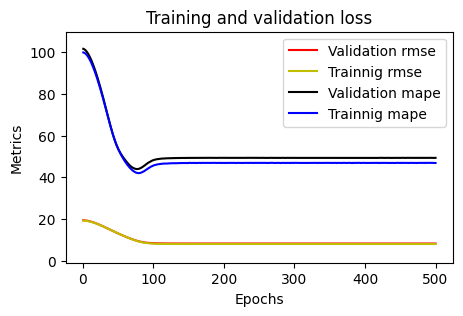

In [36]:
plotme(model2_1)

In [46]:
# inputs: distance + hour
model2_2 = nnmodel(5,10, num_hlayers=1,Epoch=500)
model2_2

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 797677.0000 - distance_layer_loss: 0.1326 - traveltime_layer_loss: 1329461.5000 - distance_layer_mape: 98.8936 - distance_layer_rmse: 0.3641 - traveltime_layer_mape: 99.9078 - traveltime_layer_rmse: 1153.0228 - val_loss: 811535.5625 - val_distance_layer_loss: 0.1357 - val_traveltime_layer_loss: 1352559.3750 - val_distance_layer_mape: 99.4188 - val_distance_layer_rmse: 0.3683 - val_traveltime_layer_mape: 99.8215 - val_traveltime_layer_rmse: 1162.9958
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 795493.0625 - distance_layer_loss: 0.1378 - traveltime_layer_loss: 1325821.2500 - distance_layer_mape: 99.4651 - distance_layer_rmse: 0.3712 - traveltime_layer_mape: 99.6936 - traveltime_layer_rmse: 1151.4431 - val_loss: 808490.9375 - val_distance_layer_loss: 0.1330 - val_traveltime_layer_loss: 1347484.6250 - val_distance_layer_mape: 99.0746 - val_distance_layer_rmse: 0.3647 - val_traveltime_l

165/165 [==============================] - 0s 1ms/step - loss: 141776.4688 - distance_layer_loss: 392.2854 - traveltime_layer_loss: 236032.6250 - distance_layer_mape: 4438349.0000 - distance_layer_rmse: 19.8062 - traveltime_layer_mape: 45.8814 - traveltime_layer_rmse: 485.8319 - val_loss: 149910.6719 - val_distance_layer_loss: 384.6117 - val_traveltime_layer_loss: 249594.7656 - val_distance_layer_mape: 12706.9961 - val_distance_layer_rmse: 19.6115 - val_traveltime_layer_mape: 45.7377 - val_traveltime_layer_rmse: 499.5946
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 141564.5156 - distance_layer_loss: 390.2841 - traveltime_layer_loss: 235680.6250 - distance_layer_mape: 4428768.0000 - distance_layer_rmse: 19.7556 - traveltime_layer_mape: 45.6390 - traveltime_layer_rmse: 485.4695 - val_loss: 149653.7812 - val_distance_layer_loss: 385.2448 - val_traveltime_layer_loss: 249166.1094 - val_distance_layer_mape: 12718.4980 - val_distance_layer_rmse: 19.6277 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 138949.0000 - distance_layer_loss: 380.7341 - traveltime_layer_loss: 231327.7500 - distance_layer_mape: 4274967.5000 - distance_layer_rmse: 19.5124 - traveltime_layer_mape: 45.9100 - traveltime_layer_rmse: 480.9654 - val_loss: 147194.4062 - val_distance_layer_loss: 373.5630 - val_traveltime_layer_loss: 245074.9844 - val_distance_layer_mape: 12543.4727 - val_distance_layer_rmse: 19.3278 - val_traveltime_layer_mape: 45.8053 - val_traveltime_layer_rmse: 495.0505
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 138803.4062 - distance_layer_loss: 377.7740 - traveltime_layer_loss: 231087.1562 - distance_layer_mape: 4248326.5000 - distance_layer_rmse: 19.4364 - traveltime_layer_mape: 45.5920 - traveltime_layer_rmse: 480.7152 - val_loss: 147033.3281 - val_distance_layer_loss: 373.1561 - val_traveltime_layer_loss: 244806.6562 - val_distance_layer_mape: 12537.9463 - val_distance_layer_rmse: 19.3172 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 137204.4688 - distance_layer_loss: 364.0429 - traveltime_layer_loss: 228431.3281 - distance_layer_mape: 4114205.2500 - distance_layer_rmse: 19.0799 - traveltime_layer_mape: 46.0969 - traveltime_layer_rmse: 477.9449 - val_loss: 145757.5938 - val_distance_layer_loss: 354.4820 - val_traveltime_layer_loss: 242693.0469 - val_distance_layer_mape: 12239.0723 - val_distance_layer_rmse: 18.8277 - val_traveltime_layer_mape: 45.5239 - val_traveltime_layer_rmse: 492.6389
Epoch 47/500
165/165 [==============================] - 0s 1ms/step - loss: 137156.1406 - distance_layer_loss: 360.4406 - traveltime_layer_loss: 228353.2344 - distance_layer_mape: 4077399.2500 - distance_layer_rmse: 18.9853 - traveltime_layer_mape: 45.7018 - traveltime_layer_rmse: 477.8632 - val_loss: 145594.3281 - val_distance_layer_loss: 354.6281 - val_traveltime_layer_loss: 242420.8438 - val_distance_layer_mape: 12242.4619 - val_distance_layer_rmse: 18.8316 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 136231.9219 - distance_layer_loss: 343.5685 - traveltime_layer_loss: 226824.1406 - distance_layer_mape: 3941997.7500 - distance_layer_rmse: 18.5356 - traveltime_layer_mape: 45.7199 - traveltime_layer_rmse: 476.2606 - val_loss: 144702.0938 - val_distance_layer_loss: 342.5233 - val_traveltime_layer_loss: 240941.8125 - val_distance_layer_mape: 12046.5361 - val_distance_layer_rmse: 18.5074 - val_traveltime_layer_mape: 46.5677 - val_traveltime_layer_rmse: 490.8582
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 136190.8750 - distance_layer_loss: 344.2360 - traveltime_layer_loss: 226755.2500 - distance_layer_mape: 3968526.7500 - distance_layer_rmse: 18.5536 - traveltime_layer_mape: 46.0536 - traveltime_layer_rmse: 476.1883 - val_loss: 144766.7344 - val_distance_layer_loss: 337.7247 - val_traveltime_layer_loss: 241052.7500 - val_distance_layer_mape: 11963.7578 - val_distance_layer_rmse: 18.3773 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 135659.6562 - distance_layer_loss: 327.9624 - traveltime_layer_loss: 225880.7344 - distance_layer_mape: 3819405.0000 - distance_layer_rmse: 18.1097 - traveltime_layer_mape: 45.8039 - traveltime_layer_rmse: 475.2691 - val_loss: 144259.1875 - val_distance_layer_loss: 326.0207 - val_traveltime_layer_loss: 240214.6406 - val_distance_layer_mape: 11766.6729 - val_distance_layer_rmse: 18.0560 - val_traveltime_layer_mape: 46.4399 - val_traveltime_layer_rmse: 490.1170
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 135636.0625 - distance_layer_loss: 326.6384 - traveltime_layer_loss: 225842.3281 - distance_layer_mape: 3840712.2500 - distance_layer_rmse: 18.0731 - traveltime_layer_mape: 45.7668 - traveltime_layer_rmse: 475.2287 - val_loss: 144250.4531 - val_distance_layer_loss: 324.2656 - val_traveltime_layer_loss: 240201.1719 - val_distance_layer_mape: 11735.8857 - val_distance_layer_rmse: 18.0074 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 135310.9688 - distance_layer_loss: 313.5026 - traveltime_layer_loss: 225309.3438 - distance_layer_mape: 3744211.2500 - distance_layer_rmse: 17.7060 - traveltime_layer_mape: 45.6954 - traveltime_layer_rmse: 474.6676 - val_loss: 143974.4062 - val_distance_layer_loss: 313.1382 - val_traveltime_layer_loss: 239748.5312 - val_distance_layer_mape: 11542.6592 - val_distance_layer_rmse: 17.6957 - val_traveltime_layer_mape: 46.5716 - val_traveltime_layer_rmse: 489.6412
Epoch 92/500
165/165 [==============================] - 0s 1ms/step - loss: 135302.6719 - distance_layer_loss: 314.0904 - traveltime_layer_loss: 225295.0469 - distance_layer_mape: 3746353.0000 - distance_layer_rmse: 17.7226 - traveltime_layer_mape: 45.9620 - traveltime_layer_rmse: 474.6526 - val_loss: 144166.9062 - val_distance_layer_loss: 307.8682 - val_traveltime_layer_loss: 240072.8906 - val_distance_layer_mape: 11446.9307 - val_distance_layer_rmse: 17.5462 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 135128.7656 - distance_layer_loss: 304.7922 - traveltime_layer_loss: 225011.2969 - distance_layer_mape: 3675979.2500 - distance_layer_rmse: 17.4583 - traveltime_layer_mape: 46.1622 - traveltime_layer_rmse: 474.3535 - val_loss: 143907.6406 - val_distance_layer_loss: 299.5447 - val_traveltime_layer_loss: 239646.4062 - val_distance_layer_mape: 11298.4473 - val_distance_layer_rmse: 17.3074 - val_traveltime_layer_mape: 46.0356 - val_traveltime_layer_rmse: 489.5369
Epoch 107/500
165/165 [==============================] - 0s 1ms/step - loss: 135059.7031 - distance_layer_loss: 302.5999 - traveltime_layer_loss: 224897.6719 - distance_layer_mape: 3664616.5000 - distance_layer_rmse: 17.3954 - traveltime_layer_mape: 45.8673 - traveltime_layer_rmse: 474.2338 - val_loss: 143849.8125 - val_distance_layer_loss: 299.9224 - val_traveltime_layer_loss: 239549.6719 - val_distance_layer_mape: 11305.7812 - val_distance_layer_rmse: 17.3183 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134922.2812 - distance_layer_loss: 294.0158 - traveltime_layer_loss: 224674.4062 - distance_layer_mape: 3599379.0000 - distance_layer_rmse: 17.1469 - traveltime_layer_mape: 45.8467 - traveltime_layer_rmse: 473.9983 - val_loss: 143784.8281 - val_distance_layer_loss: 290.8512 - val_traveltime_layer_loss: 239447.3750 - val_distance_layer_mape: 11139.7090 - val_distance_layer_rmse: 17.0544 - val_traveltime_layer_mape: 46.0921 - val_traveltime_layer_rmse: 489.3336
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 134933.8281 - distance_layer_loss: 293.9653 - traveltime_layer_loss: 224693.7656 - distance_layer_mape: 3606865.5000 - distance_layer_rmse: 17.1454 - traveltime_layer_mape: 45.9598 - traveltime_layer_rmse: 474.0187 - val_loss: 143772.9219 - val_distance_layer_loss: 290.4801 - val_traveltime_layer_loss: 239427.8594 - val_distance_layer_mape: 11132.9014 - val_distance_layer_rmse: 17.0435 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134841.3750 - distance_layer_loss: 288.2976 - traveltime_layer_loss: 224543.5156 - distance_layer_mape: 3579846.0000 - distance_layer_rmse: 16.9793 - traveltime_layer_mape: 46.1530 - traveltime_layer_rmse: 473.8602 - val_loss: 143683.1250 - val_distance_layer_loss: 284.4436 - val_traveltime_layer_loss: 239282.2812 - val_distance_layer_mape: 11021.0205 - val_distance_layer_rmse: 16.8655 - val_traveltime_layer_mape: 46.2314 - val_traveltime_layer_rmse: 489.1649
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 134809.7969 - distance_layer_loss: 286.4421 - traveltime_layer_loss: 224492.0781 - distance_layer_mape: 3565446.7500 - distance_layer_rmse: 16.9246 - traveltime_layer_mape: 45.8680 - traveltime_layer_rmse: 473.8059 - val_loss: 143660.3594 - val_distance_layer_loss: 284.4428 - val_traveltime_layer_loss: 239244.2344 - val_distance_layer_mape: 11021.1631 - val_distance_layer_rmse: 16.8654 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134749.1719 - distance_layer_loss: 282.2292 - traveltime_layer_loss: 224393.7969 - distance_layer_mape: 3545152.5000 - distance_layer_rmse: 16.7997 - traveltime_layer_mape: 46.1341 - traveltime_layer_rmse: 473.7022 - val_loss: 143629.3125 - val_distance_layer_loss: 278.5222 - val_traveltime_layer_loss: 239196.5000 - val_distance_layer_mape: 10909.2900 - val_distance_layer_rmse: 16.6890 - val_traveltime_layer_mape: 46.2082 - val_traveltime_layer_rmse: 489.0772
Epoch 152/500
165/165 [==============================] - 0s 1ms/step - loss: 134756.1875 - distance_layer_loss: 280.4953 - traveltime_layer_loss: 224406.6406 - distance_layer_mape: 3531961.7500 - distance_layer_rmse: 16.7480 - traveltime_layer_mape: 45.8512 - traveltime_layer_rmse: 473.7158 - val_loss: 143571.5781 - val_distance_layer_loss: 279.6723 - val_traveltime_layer_loss: 239099.5312 - val_distance_layer_mape: 10931.5732 - val_distance_layer_rmse: 16.7234 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134732.3594 - distance_layer_loss: 277.9167 - traveltime_layer_loss: 224368.6875 - distance_layer_mape: 3523804.7500 - distance_layer_rmse: 16.6708 - traveltime_layer_mape: 46.2978 - traveltime_layer_rmse: 473.6757 - val_loss: 143620.5938 - val_distance_layer_loss: 272.8975 - val_traveltime_layer_loss: 239185.6719 - val_distance_layer_mape: 10801.3906 - val_distance_layer_rmse: 16.5196 - val_traveltime_layer_mape: 46.0626 - val_traveltime_layer_rmse: 489.0661
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 134670.7031 - distance_layer_loss: 276.6298 - traveltime_layer_loss: 224266.7656 - distance_layer_mape: 3505326.2500 - distance_layer_rmse: 16.6322 - traveltime_layer_mape: 46.0833 - traveltime_layer_rmse: 473.5681 - val_loss: 143684.8594 - val_distance_layer_loss: 271.6009 - val_traveltime_layer_loss: 239293.6562 - val_distance_layer_mape: 10776.0381 - val_distance_layer_rmse: 16.4803 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134675.5781 - distance_layer_loss: 273.5004 - traveltime_layer_loss: 224277.0156 - distance_layer_mape: 3475353.7500 - distance_layer_rmse: 16.5378 - traveltime_layer_mape: 46.2204 - traveltime_layer_rmse: 473.5789 - val_loss: 143636.2188 - val_distance_layer_loss: 267.9326 - val_traveltime_layer_loss: 239215.0625 - val_distance_layer_mape: 10704.7627 - val_distance_layer_rmse: 16.3686 - val_traveltime_layer_mape: 45.8860 - val_traveltime_layer_rmse: 489.0962
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 134671.6094 - distance_layer_loss: 271.0185 - traveltime_layer_loss: 224272.0156 - distance_layer_mape: 3463928.0000 - distance_layer_rmse: 16.4626 - traveltime_layer_mape: 45.7803 - traveltime_layer_rmse: 473.5737 - val_loss: 143502.4219 - val_distance_layer_loss: 269.9841 - val_traveltime_layer_loss: 238990.7031 - val_distance_layer_mape: 10745.0889 - val_distance_layer_rmse: 16.4312 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134638.9531 - distance_layer_loss: 268.8720 - traveltime_layer_loss: 224218.9688 - distance_layer_mape: 3472571.5000 - distance_layer_rmse: 16.3973 - traveltime_layer_mape: 46.0317 - traveltime_layer_rmse: 473.5176 - val_loss: 143565.9844 - val_distance_layer_loss: 264.8114 - val_traveltime_layer_loss: 239100.0312 - val_distance_layer_mape: 10643.3926 - val_distance_layer_rmse: 16.2730 - val_traveltime_layer_mape: 45.9691 - val_traveltime_layer_rmse: 488.9785
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 134622.5469 - distance_layer_loss: 267.9482 - traveltime_layer_loss: 224192.3125 - distance_layer_mape: 3452734.5000 - distance_layer_rmse: 16.3691 - traveltime_layer_mape: 45.8652 - traveltime_layer_rmse: 473.4895 - val_loss: 143450.8906 - val_distance_layer_loss: 266.8345 - val_traveltime_layer_loss: 238906.9844 - val_distance_layer_mape: 10683.3486 - val_distance_layer_rmse: 16.3351 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134596.8594 - distance_layer_loss: 265.8102 - traveltime_layer_loss: 224150.8594 - distance_layer_mape: 3436633.0000 - distance_layer_rmse: 16.3037 - traveltime_layer_mape: 46.0442 - traveltime_layer_rmse: 473.4457 - val_loss: 143455.9062 - val_distance_layer_loss: 263.2104 - val_traveltime_layer_loss: 238917.7188 - val_distance_layer_mape: 10611.6553 - val_distance_layer_rmse: 16.2238 - val_traveltime_layer_mape: 46.2463 - val_traveltime_layer_rmse: 488.7921
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 134582.1406 - distance_layer_loss: 266.1816 - traveltime_layer_loss: 224126.1562 - distance_layer_mape: 3437203.2500 - distance_layer_rmse: 16.3151 - traveltime_layer_mape: 46.1194 - traveltime_layer_rmse: 473.4196 - val_loss: 143519.9219 - val_distance_layer_loss: 261.8361 - val_traveltime_layer_loss: 239025.3281 - val_distance_layer_mape: 10584.2939 - val_distance_layer_rmse: 16.1814 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134588.3750 - distance_layer_loss: 263.9466 - traveltime_layer_loss: 224137.9844 - distance_layer_mape: 3427193.5000 - distance_layer_rmse: 16.2464 - traveltime_layer_mape: 46.2042 - traveltime_layer_rmse: 473.4321 - val_loss: 143414.1562 - val_distance_layer_loss: 260.8436 - val_traveltime_layer_loss: 238849.6406 - val_distance_layer_mape: 10564.4180 - val_distance_layer_rmse: 16.1507 - val_traveltime_layer_mape: 46.2977 - val_traveltime_layer_rmse: 488.7224
Epoch 227/500
165/165 [==============================] - 0s 1ms/step - loss: 134562.5312 - distance_layer_loss: 262.0634 - traveltime_layer_loss: 224096.1719 - distance_layer_mape: 3412799.5000 - distance_layer_rmse: 16.1884 - traveltime_layer_mape: 45.8109 - traveltime_layer_rmse: 473.3880 - val_loss: 143421.8125 - val_distance_layer_loss: 260.4185 - val_traveltime_layer_loss: 238862.6406 - val_distance_layer_mape: 10555.8438 - val_distance_layer_rmse: 16.1375 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134552.8125 - distance_layer_loss: 261.4795 - traveltime_layer_loss: 224080.2812 - distance_layer_mape: 3407175.2500 - distance_layer_rmse: 16.1703 - traveltime_layer_mape: 46.1740 - traveltime_layer_rmse: 473.3712 - val_loss: 143340.6875 - val_distance_layer_loss: 259.6314 - val_traveltime_layer_loss: 238727.9844 - val_distance_layer_mape: 10539.7510 - val_distance_layer_rmse: 16.1131 - val_traveltime_layer_mape: 46.5493 - val_traveltime_layer_rmse: 488.5980
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 134552.7969 - distance_layer_loss: 260.3313 - traveltime_layer_loss: 224080.9531 - distance_layer_mape: 3396695.5000 - distance_layer_rmse: 16.1348 - traveltime_layer_mape: 45.9482 - traveltime_layer_rmse: 473.3719 - val_loss: 143327.1562 - val_distance_layer_loss: 260.2820 - val_traveltime_layer_loss: 238705.0156 - val_distance_layer_mape: 10552.8057 - val_distance_layer_rmse: 16.1333 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134488.8906 - distance_layer_loss: 259.7399 - traveltime_layer_loss: 223975.0156 - distance_layer_mape: 3393314.7500 - distance_layer_rmse: 16.1164 - traveltime_layer_mape: 46.2608 - traveltime_layer_rmse: 473.2600 - val_loss: 143533.3750 - val_distance_layer_loss: 253.6196 - val_traveltime_layer_loss: 239053.2344 - val_distance_layer_mape: 10418.2979 - val_distance_layer_rmse: 15.9254 - val_traveltime_layer_mape: 45.7012 - val_traveltime_layer_rmse: 488.9307
Epoch 257/500
165/165 [==============================] - 0s 1ms/step - loss: 134539.1250 - distance_layer_loss: 257.7100 - traveltime_layer_loss: 224060.0938 - distance_layer_mape: 3391266.7500 - distance_layer_rmse: 16.0533 - traveltime_layer_mape: 45.8249 - traveltime_layer_rmse: 473.3499 - val_loss: 143332.6875 - val_distance_layer_loss: 256.6460 - val_traveltime_layer_loss: 238716.7344 - val_distance_layer_mape: 10479.4023 - val_distance_layer_rmse: 16.0202 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134507.8906 - distance_layer_loss: 256.7932 - traveltime_layer_loss: 224008.6562 - distance_layer_mape: 3379455.7500 - distance_layer_rmse: 16.0248 - traveltime_layer_mape: 46.0490 - traveltime_layer_rmse: 473.2955 - val_loss: 143532.0938 - val_distance_layer_loss: 251.3797 - val_traveltime_layer_loss: 239052.5156 - val_distance_layer_mape: 10372.3828 - val_distance_layer_rmse: 15.8550 - val_traveltime_layer_mape: 45.6418 - val_traveltime_layer_rmse: 488.9300
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 134536.6719 - distance_layer_loss: 255.2569 - traveltime_layer_loss: 224057.5781 - distance_layer_mape: 3372836.2500 - distance_layer_rmse: 15.9768 - traveltime_layer_mape: 45.7597 - traveltime_layer_rmse: 473.3472 - val_loss: 143418.7812 - val_distance_layer_loss: 252.5121 - val_traveltime_layer_loss: 238862.9062 - val_distance_layer_mape: 10395.4629 - val_distance_layer_rmse: 15.8906 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134507.1094 - distance_layer_loss: 254.1497 - traveltime_layer_loss: 224009.0156 - distance_layer_mape: 3345228.7500 - distance_layer_rmse: 15.9421 - traveltime_layer_mape: 45.8784 - traveltime_layer_rmse: 473.2959 - val_loss: 143274.0469 - val_distance_layer_loss: 253.0840 - val_traveltime_layer_loss: 238621.3281 - val_distance_layer_mape: 10406.4482 - val_distance_layer_rmse: 15.9086 - val_traveltime_layer_mape: 46.4220 - val_traveltime_layer_rmse: 488.4888
Epoch 287/500
165/165 [==============================] - 0s 1ms/step - loss: 134504.1719 - distance_layer_loss: 254.0907 - traveltime_layer_loss: 224004.1719 - distance_layer_mape: 3363642.0000 - distance_layer_rmse: 15.9402 - traveltime_layer_mape: 45.9294 - traveltime_layer_rmse: 473.2908 - val_loss: 143292.1875 - val_distance_layer_loss: 252.5046 - val_traveltime_layer_loss: 238651.9219 - val_distance_layer_mape: 10394.7295 - val_distance_layer_rmse: 15.8904 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134555.5781 - distance_layer_loss: 253.8129 - traveltime_layer_loss: 224090.1719 - distance_layer_mape: 3360765.0000 - distance_layer_rmse: 15.9315 - traveltime_layer_mape: 46.2135 - traveltime_layer_rmse: 473.3816 - val_loss: 143230.1719 - val_distance_layer_loss: 252.1217 - val_traveltime_layer_loss: 238548.8281 - val_distance_layer_mape: 10386.2939 - val_distance_layer_rmse: 15.8783 - val_traveltime_layer_mape: 46.5827 - val_traveltime_layer_rmse: 488.4146
Epoch 302/500
165/165 [==============================] - 0s 1ms/step - loss: 134505.8594 - distance_layer_loss: 253.1945 - traveltime_layer_loss: 224007.5781 - distance_layer_mape: 3365216.5000 - distance_layer_rmse: 15.9121 - traveltime_layer_mape: 46.1188 - traveltime_layer_rmse: 473.2944 - val_loss: 143302.1562 - val_distance_layer_loss: 249.9675 - val_traveltime_layer_loss: 238670.2812 - val_distance_layer_mape: 10342.4541 - val_distance_layer_rmse: 15.8104 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134496.6719 - distance_layer_loss: 250.8484 - traveltime_layer_loss: 223993.8750 - distance_layer_mape: 3338832.5000 - distance_layer_rmse: 15.8382 - traveltime_layer_mape: 45.9144 - traveltime_layer_rmse: 473.2799 - val_loss: 143215.6562 - val_distance_layer_loss: 250.2572 - val_traveltime_layer_loss: 238525.9375 - val_distance_layer_mape: 10347.8350 - val_distance_layer_rmse: 15.8195 - val_traveltime_layer_mape: 46.5248 - val_traveltime_layer_rmse: 488.3912
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 134584.3750 - distance_layer_loss: 251.6331 - traveltime_layer_loss: 224139.4688 - distance_layer_mape: 3333399.2500 - distance_layer_rmse: 15.8629 - traveltime_layer_mape: 46.1228 - traveltime_layer_rmse: 473.4337 - val_loss: 143219.9062 - val_distance_layer_loss: 249.9213 - val_traveltime_layer_loss: 238533.1562 - val_distance_layer_mape: 10340.9043 - val_distance_layer_rmse: 15.8089 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134487.9688 - distance_layer_loss: 250.1581 - traveltime_layer_loss: 223979.7812 - distance_layer_mape: 3339279.5000 - distance_layer_rmse: 15.8164 - traveltime_layer_mape: 46.1294 - traveltime_layer_rmse: 473.2650 - val_loss: 143229.2344 - val_distance_layer_loss: 247.7640 - val_traveltime_layer_loss: 238550.2188 - val_distance_layer_mape: 10296.4131 - val_distance_layer_rmse: 15.7405 - val_traveltime_layer_mape: 46.3150 - val_traveltime_layer_rmse: 488.4160
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 134485.4375 - distance_layer_loss: 249.5876 - traveltime_layer_loss: 223976.0000 - distance_layer_mape: 3326116.0000 - distance_layer_rmse: 15.7983 - traveltime_layer_mape: 46.0094 - traveltime_layer_rmse: 473.2610 - val_loss: 143271.4531 - val_distance_layer_loss: 246.7579 - val_traveltime_layer_loss: 238621.3281 - val_distance_layer_mape: 10275.7188 - val_distance_layer_rmse: 15.7085 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134467.0469 - distance_layer_loss: 248.7949 - traveltime_layer_loss: 223945.7656 - distance_layer_mape: 3333990.5000 - distance_layer_rmse: 15.7732 - traveltime_layer_mape: 46.1296 - traveltime_layer_rmse: 473.2291 - val_loss: 143312.6875 - val_distance_layer_loss: 244.5051 - val_traveltime_layer_loss: 238691.4375 - val_distance_layer_mape: 10228.8799 - val_distance_layer_rmse: 15.6367 - val_traveltime_layer_mape: 45.9106 - val_traveltime_layer_rmse: 488.5606
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 134467.4688 - distance_layer_loss: 248.1210 - traveltime_layer_loss: 223947.0625 - distance_layer_mape: 3317773.2500 - distance_layer_rmse: 15.7519 - traveltime_layer_mape: 46.0289 - traveltime_layer_rmse: 473.2305 - val_loss: 143267.0156 - val_distance_layer_loss: 245.0549 - val_traveltime_layer_loss: 238614.9219 - val_distance_layer_mape: 10240.2109 - val_distance_layer_rmse: 15.6542 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134440.8438 - distance_layer_loss: 247.8071 - traveltime_layer_loss: 223902.8125 - distance_layer_mape: 3314739.7500 - distance_layer_rmse: 15.7419 - traveltime_layer_mape: 46.2235 - traveltime_layer_rmse: 473.1837 - val_loss: 143287.6562 - val_distance_layer_loss: 243.2098 - val_traveltime_layer_loss: 238650.6719 - val_distance_layer_mape: 10201.5830 - val_distance_layer_rmse: 15.5952 - val_traveltime_layer_mape: 45.9335 - val_traveltime_layer_rmse: 488.5189
Epoch 362/500
165/165 [==============================] - 0s 1ms/step - loss: 134492.5156 - distance_layer_loss: 245.6952 - traveltime_layer_loss: 223990.4219 - distance_layer_mape: 3312644.2500 - distance_layer_rmse: 15.6747 - traveltime_layer_mape: 45.7649 - traveltime_layer_rmse: 473.2763 - val_loss: 143186.4062 - val_distance_layer_loss: 245.0358 - val_traveltime_layer_loss: 238480.6250 - val_distance_layer_mape: 10239.2686 - val_distance_layer_rmse: 15.6536 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134495.4375 - distance_layer_loss: 244.5758 - traveltime_layer_loss: 223995.9844 - distance_layer_mape: 3318101.2500 - distance_layer_rmse: 15.6389 - traveltime_layer_mape: 45.8188 - traveltime_layer_rmse: 473.2821 - val_loss: 143192.1406 - val_distance_layer_loss: 243.1603 - val_traveltime_layer_loss: 238491.4219 - val_distance_layer_mape: 10199.9883 - val_distance_layer_rmse: 15.5936 - val_traveltime_layer_mape: 46.2375 - val_traveltime_layer_rmse: 488.3558
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 134476.3125 - distance_layer_loss: 244.6362 - traveltime_layer_loss: 223964.1094 - distance_layer_mape: 3303935.2500 - distance_layer_rmse: 15.6409 - traveltime_layer_mape: 45.8356 - traveltime_layer_rmse: 473.2485 - val_loss: 143156.0312 - val_distance_layer_loss: 244.0793 - val_traveltime_layer_loss: 238430.5625 - val_distance_layer_mape: 10218.9111 - val_distance_layer_rmse: 15.6230 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134453.5469 - distance_layer_loss: 243.7852 - traveltime_layer_loss: 223926.6875 - distance_layer_mape: 3299410.0000 - distance_layer_rmse: 15.6136 - traveltime_layer_mape: 45.9259 - traveltime_layer_rmse: 473.2089 - val_loss: 143136.7500 - val_distance_layer_loss: 243.1620 - val_traveltime_layer_loss: 238399.2031 - val_distance_layer_mape: 10199.5371 - val_distance_layer_rmse: 15.5937 - val_traveltime_layer_mape: 46.5068 - val_traveltime_layer_rmse: 488.2614
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 134404.2969 - distance_layer_loss: 245.3252 - traveltime_layer_loss: 223843.5938 - distance_layer_mape: 3309924.0000 - distance_layer_rmse: 15.6629 - traveltime_layer_mape: 46.2954 - traveltime_layer_rmse: 473.1211 - val_loss: 143376.4688 - val_distance_layer_loss: 239.1003 - val_traveltime_layer_loss: 238801.3594 - val_distance_layer_mape: 10115.1758 - val_distance_layer_rmse: 15.4629 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134462.9219 - distance_layer_loss: 242.6436 - traveltime_layer_loss: 223943.1406 - distance_layer_mape: 3283157.0000 - distance_layer_rmse: 15.5770 - traveltime_layer_mape: 45.9312 - traveltime_layer_rmse: 473.2263 - val_loss: 143130.0000 - val_distance_layer_loss: 241.5769 - val_traveltime_layer_loss: 238388.8594 - val_distance_layer_mape: 10166.1338 - val_distance_layer_rmse: 15.5427 - val_traveltime_layer_mape: 46.4385 - val_traveltime_layer_rmse: 488.2508
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 134458.9531 - distance_layer_loss: 242.7467 - traveltime_layer_loss: 223936.3438 - distance_layer_mape: 3282295.5000 - distance_layer_rmse: 15.5803 - traveltime_layer_mape: 46.0043 - traveltime_layer_rmse: 473.2191 - val_loss: 143116.0938 - val_distance_layer_loss: 241.9191 - val_traveltime_layer_loss: 238365.5156 - val_distance_layer_mape: 10173.1279 - val_distance_layer_rmse: 15.5537 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134461.9531 - distance_layer_loss: 241.1240 - traveltime_layer_loss: 223942.5625 - distance_layer_mape: 3278511.0000 - distance_layer_rmse: 15.5282 - traveltime_layer_mape: 45.9019 - traveltime_layer_rmse: 473.2257 - val_loss: 143137.3906 - val_distance_layer_loss: 239.8786 - val_traveltime_layer_loss: 238402.4062 - val_distance_layer_mape: 10130.4004 - val_distance_layer_rmse: 15.4880 - val_traveltime_layer_mape: 46.3149 - val_traveltime_layer_rmse: 488.2647
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 134484.6250 - distance_layer_loss: 241.2357 - traveltime_layer_loss: 223980.2656 - distance_layer_mape: 3287973.7500 - distance_layer_rmse: 15.5318 - traveltime_layer_mape: 45.9447 - traveltime_layer_rmse: 473.2655 - val_loss: 143146.9219 - val_distance_layer_loss: 239.5738 - val_traveltime_layer_loss: 238418.5312 - val_distance_layer_mape: 10123.9873 - val_distance_layer_rmse: 15.4782 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134444.3125 - distance_layer_loss: 239.7220 - traveltime_layer_loss: 223914.0156 - distance_layer_mape: 3261313.7500 - distance_layer_rmse: 15.4830 - traveltime_layer_mape: 45.8450 - traveltime_layer_rmse: 473.1955 - val_loss: 143116.2344 - val_distance_layer_loss: 238.9749 - val_traveltime_layer_loss: 238367.7656 - val_distance_layer_mape: 10111.2002 - val_distance_layer_rmse: 15.4588 - val_traveltime_layer_mape: 46.4030 - val_traveltime_layer_rmse: 488.2292
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 134454.9688 - distance_layer_loss: 240.4557 - traveltime_layer_loss: 223931.3281 - distance_layer_mape: 3267264.5000 - distance_layer_rmse: 15.5066 - traveltime_layer_mape: 46.0454 - traveltime_layer_rmse: 473.2138 - val_loss: 143134.2812 - val_distance_layer_loss: 238.3176 - val_traveltime_layer_loss: 238398.2969 - val_distance_layer_mape: 10097.4004 - val_distance_layer_rmse: 15.4375 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134470.3125 - distance_layer_loss: 239.7532 - traveltime_layer_loss: 223957.3125 - distance_layer_mape: 3265319.7500 - distance_layer_rmse: 15.4840 - traveltime_layer_mape: 46.1344 - traveltime_layer_rmse: 473.2413 - val_loss: 143121.9219 - val_distance_layer_loss: 237.4192 - val_traveltime_layer_loss: 238378.2188 - val_distance_layer_mape: 10078.1348 - val_distance_layer_rmse: 15.4084 - val_traveltime_layer_mape: 46.2872 - val_traveltime_layer_rmse: 488.2399
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 134460.9688 - distance_layer_loss: 238.7362 - traveltime_layer_loss: 223942.4688 - distance_layer_mape: 3276960.2500 - distance_layer_rmse: 15.4511 - traveltime_layer_mape: 45.8780 - traveltime_layer_rmse: 473.2256 - val_loss: 143166.4062 - val_distance_layer_loss: 236.4180 - val_traveltime_layer_loss: 238453.0000 - val_distance_layer_mape: 10057.1660 - val_distance_layer_rmse: 15.3759 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134454.8594 - distance_layer_loss: 237.9433 - traveltime_layer_loss: 223932.7969 - distance_layer_mape: 3248415.0000 - distance_layer_rmse: 15.4254 - traveltime_layer_mape: 45.9191 - traveltime_layer_rmse: 473.2154 - val_loss: 143084.2031 - val_distance_layer_loss: 237.2622 - val_traveltime_layer_loss: 238315.5156 - val_distance_layer_mape: 10074.4531 - val_distance_layer_rmse: 15.4033 - val_traveltime_layer_mape: 46.4942 - val_traveltime_layer_rmse: 488.1757
Epoch 467/500
165/165 [==============================] - 0s 1ms/step - loss: 134428.1719 - distance_layer_loss: 238.5212 - traveltime_layer_loss: 223887.9375 - distance_layer_mape: 3266623.0000 - distance_layer_rmse: 15.4441 - traveltime_layer_mape: 46.0971 - traveltime_layer_rmse: 473.1680 - val_loss: 143212.1719 - val_distance_layer_loss: 234.5321 - val_traveltime_layer_loss: 238530.6406 - val_distance_layer_mape: 10017.1025 - val_distance_layer_rmse: 15.3144 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134418.9062 - distance_layer_loss: 236.2525 - traveltime_layer_loss: 223873.9688 - distance_layer_mape: 3226467.2500 - distance_layer_rmse: 15.3705 - traveltime_layer_mape: 45.8029 - traveltime_layer_rmse: 473.1532 - val_loss: 143062.4531 - val_distance_layer_loss: 237.5997 - val_traveltime_layer_loss: 238278.9688 - val_distance_layer_mape: 10081.0947 - val_distance_layer_rmse: 15.4143 - val_traveltime_layer_mape: 46.8451 - val_traveltime_layer_rmse: 488.1383
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 134488.7969 - distance_layer_loss: 238.2191 - traveltime_layer_loss: 223989.1406 - distance_layer_mape: 3275455.0000 - distance_layer_rmse: 15.4344 - traveltime_layer_mape: 46.2596 - traveltime_layer_rmse: 473.2749 - val_loss: 143175.2344 - val_distance_layer_loss: 233.8969 - val_traveltime_layer_loss: 238469.4688 - val_distance_layer_mape: 10003.4268 - val_distance_layer_rmse: 15.2937 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134457.2500 - distance_layer_loss: 236.7975 - traveltime_layer_loss: 223937.4531 - distance_layer_mape: 3252045.2500 - distance_layer_rmse: 15.3882 - traveltime_layer_mape: 46.2187 - traveltime_layer_rmse: 473.2203 - val_loss: 143118.9375 - val_distance_layer_loss: 233.8065 - val_traveltime_layer_loss: 238375.6562 - val_distance_layer_mape: 10001.2197 - val_distance_layer_rmse: 15.2907 - val_traveltime_layer_mape: 46.1980 - val_traveltime_layer_rmse: 488.2373
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 134435.9688 - distance_layer_loss: 235.2729 - traveltime_layer_loss: 223903.0312 - distance_layer_mape: 3227191.5000 - distance_layer_rmse: 15.3386 - traveltime_layer_mape: 45.8632 - traveltime_layer_rmse: 473.1839 - val_loss: 143189.7500 - val_distance_layer_loss: 232.4984 - val_traveltime_layer_loss: 238494.5938 - val_distance_layer_mape: 9973.5186 - val_distance_layer_rmse: 15.2479 - val_tr

In [47]:
# inputs: distance + hour
model2_2 = nnmodel(5,20, num_hlayers=1,Epoch=500)
model2_2

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_travelt

165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6831 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 47/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.6250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 92/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_m

165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 107/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.6250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.6250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 152/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 227/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.6250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 257/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 287/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 302/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6831 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 362/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.6250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6833 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6836 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330984.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 467/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6835 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

165/165 [==============================] - 0s 1ms/step - loss: 798591.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 1164.3087
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 798591.5000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1330985.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 1153.6832 - val_loss: 813369.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1355614.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_

In [48]:
# inputs: distance + hour
model2_1 = nnmodel(10,10, num_hlayers=1,Epoch=500)
model2_1

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 798065.6875 - distance_layer_loss: 0.2628 - traveltime_layer_loss: 1330109.8750 - distance_layer_mape: 252.8372 - distance_layer_rmse: 0.5126 - traveltime_layer_mape: 99.9550 - traveltime_layer_rmse: 1153.3040 - val_loss: 811187.0625 - val_distance_layer_loss: 1.2880 - val_traveltime_layer_loss: 1351977.5000 - val_distance_layer_mape: 812.8459 - val_distance_layer_rmse: 1.1349 - val_traveltime_layer_mape: 99.8023 - val_traveltime_layer_rmse: 1162.7457
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 787928.8750 - distance_layer_loss: 10.9300 - traveltime_layer_loss: 1313208.0000 - distance_layer_mape: 875111.8125 - distance_layer_rmse: 3.3061 - traveltime_layer_mape: 99.0228 - traveltime_layer_rmse: 1145.9529 - val_loss: 787776.6250 - val_distance_layer_loss: 29.8230 - val_traveltime_layer_loss: 1312940.7500 - val_distance_layer_mape: 3606.9685 - val_distance_layer_rmse: 5.4610 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 143564.8281 - distance_layer_loss: 2120.1167 - traveltime_layer_loss: 237861.3438 - distance_layer_mape: 9991720.0000 - distance_layer_rmse: 46.0447 - traveltime_layer_mape: 45.5037 - traveltime_layer_rmse: 487.7103 - val_loss: 150939.3750 - val_distance_layer_loss: 2107.0769 - val_traveltime_layer_loss: 250160.9062 - val_distance_layer_mape: 29542.0449 - val_distance_layer_rmse: 45.9029 - val_traveltime_layer_mape: 46.1014 - val_traveltime_layer_rmse: 500.1609
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 143440.8438 - distance_layer_loss: 2130.8386 - traveltime_layer_loss: 237647.5312 - distance_layer_mape: 10049296.0000 - distance_layer_rmse: 46.1610 - traveltime_layer_mape: 46.0002 - traveltime_layer_rmse: 487.4911 - val_loss: 150767.1562 - val_distance_layer_loss: 2094.9553 - val_traveltime_layer_loss: 249881.9844 - val_distance_layer_mape: 29462.7109 - val_distance_layer_rmse: 45.7707 - v

165/165 [==============================] - 0s 1ms/step - loss: 140681.9062 - distance_layer_loss: 1990.1316 - traveltime_layer_loss: 233143.1094 - distance_layer_mape: 9548340.0000 - distance_layer_rmse: 44.6109 - traveltime_layer_mape: 45.8024 - traveltime_layer_rmse: 482.8489 - val_loss: 148280.1406 - val_distance_layer_loss: 1972.6606 - val_traveltime_layer_loss: 245818.5000 - val_distance_layer_mape: 28662.2246 - val_distance_layer_rmse: 44.4146 - val_traveltime_layer_mape: 46.2685 - val_traveltime_layer_rmse: 495.8009
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 140509.5469 - distance_layer_loss: 1978.5896 - traveltime_layer_loss: 232863.4219 - distance_layer_mape: 9494309.0000 - distance_layer_rmse: 44.4813 - traveltime_layer_mape: 45.7715 - traveltime_layer_rmse: 482.5592 - val_loss: 148149.9062 - val_distance_layer_loss: 1957.5352 - val_traveltime_layer_loss: 245611.4844 - val_distance_layer_mape: 28557.3652 - val_distance_layer_rmse: 44.2440 - va

165/165 [==============================] - 0s 1ms/step - loss: 138603.2500 - distance_layer_loss: 1819.8698 - traveltime_layer_loss: 229792.1406 - distance_layer_mape: 9025842.0000 - distance_layer_rmse: 42.6599 - traveltime_layer_mape: 45.8446 - traveltime_layer_rmse: 479.3664 - val_loss: 146542.2188 - val_distance_layer_loss: 1791.0767 - val_traveltime_layer_loss: 243042.9844 - val_distance_layer_mape: 27379.9609 - val_distance_layer_rmse: 42.3211 - val_traveltime_layer_mape: 45.9110 - val_traveltime_layer_rmse: 492.9939
Epoch 47/500
165/165 [==============================] - 0s 1ms/step - loss: 138421.2031 - distance_layer_loss: 1808.3369 - traveltime_layer_loss: 229496.3750 - distance_layer_mape: 8984983.0000 - distance_layer_rmse: 42.5245 - traveltime_layer_mape: 45.8397 - traveltime_layer_rmse: 479.0578 - val_loss: 146494.3750 - val_distance_layer_loss: 1774.1133 - val_traveltime_layer_loss: 242974.5469 - val_distance_layer_mape: 27254.3789 - val_distance_layer_rmse: 42.1202 - va

165/165 [==============================] - 0s 1ms/step - loss: 137133.6250 - distance_layer_loss: 1661.4176 - traveltime_layer_loss: 227448.4375 - distance_layer_mape: 8582668.0000 - distance_layer_rmse: 40.7605 - traveltime_layer_mape: 45.9557 - traveltime_layer_rmse: 476.9156 - val_loss: 145419.2031 - val_distance_layer_loss: 1631.3667 - val_traveltime_layer_loss: 241277.7969 - val_distance_layer_mape: 26183.6699 - val_distance_layer_rmse: 40.3902 - val_traveltime_layer_mape: 45.8874 - val_traveltime_layer_rmse: 491.2004
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 137105.2812 - distance_layer_loss: 1645.2472 - traveltime_layer_loss: 227411.9219 - distance_layer_mape: 8569053.0000 - distance_layer_rmse: 40.5616 - traveltime_layer_mape: 45.7422 - traveltime_layer_rmse: 476.8773 - val_loss: 145248.8438 - val_distance_layer_loss: 1646.8134 - val_traveltime_layer_loss: 240983.5469 - val_distance_layer_mape: 26308.7930 - val_distance_layer_rmse: 40.5809 - va

165/165 [==============================] - 0s 1ms/step - loss: 136239.2656 - distance_layer_loss: 1529.0352 - traveltime_layer_loss: 226046.1094 - distance_layer_mape: 8207860.0000 - distance_layer_rmse: 39.1029 - traveltime_layer_mape: 46.2560 - traveltime_layer_rmse: 475.4431 - val_loss: 144721.0625 - val_distance_layer_loss: 1497.1290 - val_traveltime_layer_loss: 240203.6719 - val_distance_layer_mape: 25123.2520 - val_distance_layer_rmse: 38.6928 - val_traveltime_layer_mape: 45.9942 - val_traveltime_layer_rmse: 490.1058
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 136159.8125 - distance_layer_loss: 1506.9662 - traveltime_layer_loss: 225928.3125 - distance_layer_mape: 8098084.5000 - distance_layer_rmse: 38.8197 - traveltime_layer_mape: 45.7369 - traveltime_layer_rmse: 475.3192 - val_loss: 144589.8750 - val_distance_layer_loss: 1506.4854 - val_traveltime_layer_loss: 239978.8438 - val_distance_layer_mape: 25202.7188 - val_distance_layer_rmse: 38.8135 - va

165/165 [==============================] - 0s 1ms/step - loss: 135652.5312 - distance_layer_loss: 1409.0942 - traveltime_layer_loss: 225148.1562 - distance_layer_mape: 7869555.0000 - distance_layer_rmse: 37.5379 - traveltime_layer_mape: 46.0167 - traveltime_layer_rmse: 474.4978 - val_loss: 144256.6875 - val_distance_layer_loss: 1397.6663 - val_traveltime_layer_loss: 239496.0156 - val_distance_layer_mape: 24301.8359 - val_distance_layer_rmse: 37.3854 - val_traveltime_layer_mape: 46.4294 - val_traveltime_layer_rmse: 489.3833
Epoch 92/500
165/165 [==============================] - 0s 1ms/step - loss: 135682.7031 - distance_layer_loss: 1406.2521 - traveltime_layer_loss: 225200.3594 - distance_layer_mape: 7849560.0000 - distance_layer_rmse: 37.5000 - traveltime_layer_mape: 46.1521 - traveltime_layer_rmse: 474.5528 - val_loss: 144284.2656 - val_distance_layer_loss: 1384.0792 - val_traveltime_layer_loss: 239551.0312 - val_distance_layer_mape: 24185.4980 - val_distance_layer_rmse: 37.2032 - va

165/165 [==============================] - 0s 1ms/step - loss: 135350.9375 - distance_layer_loss: 1316.2518 - traveltime_layer_loss: 224707.3594 - distance_layer_mape: 7590464.0000 - distance_layer_rmse: 36.2802 - traveltime_layer_mape: 45.7391 - traveltime_layer_rmse: 474.0331 - val_loss: 144032.5000 - val_distance_layer_loss: 1319.0011 - val_traveltime_layer_loss: 239174.8594 - val_distance_layer_mape: 23626.0117 - val_distance_layer_rmse: 36.3181 - val_traveltime_layer_mape: 46.6643 - val_traveltime_layer_rmse: 489.0551
Epoch 107/500
165/165 [==============================] - 0s 1ms/step - loss: 135308.2969 - distance_layer_loss: 1322.9332 - traveltime_layer_loss: 224631.8125 - distance_layer_mape: 7616749.0000 - distance_layer_rmse: 36.3722 - traveltime_layer_mape: 46.2056 - traveltime_layer_rmse: 473.9534 - val_loss: 144107.1562 - val_distance_layer_loss: 1299.8145 - val_traveltime_layer_loss: 239312.0625 - val_distance_layer_mape: 23455.8027 - val_distance_layer_rmse: 36.0529 - v

165/165 [==============================] - 0s 1ms/step - loss: 135128.6719 - distance_layer_loss: 1254.0328 - traveltime_layer_loss: 224378.4375 - distance_layer_mape: 7401826.0000 - distance_layer_rmse: 35.4123 - traveltime_layer_mape: 45.9021 - traveltime_layer_rmse: 473.6860 - val_loss: 143909.1406 - val_distance_layer_loss: 1260.0443 - val_traveltime_layer_loss: 239008.5469 - val_distance_layer_mape: 23103.1816 - val_distance_layer_rmse: 35.4971 - val_traveltime_layer_mape: 46.9672 - val_traveltime_layer_rmse: 488.8850
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 135218.0625 - distance_layer_loss: 1254.3893 - traveltime_layer_loss: 224527.1562 - distance_layer_mape: 7374429.0000 - distance_layer_rmse: 35.4174 - traveltime_layer_mape: 46.0803 - traveltime_layer_rmse: 473.8430 - val_loss: 143941.8594 - val_distance_layer_loss: 1242.6372 - val_traveltime_layer_loss: 239074.7031 - val_distance_layer_mape: 22944.8867 - val_distance_layer_rmse: 35.2511 - v

165/165 [==============================] - 0s 1ms/step - loss: 135057.0156 - distance_layer_loss: 1206.5775 - traveltime_layer_loss: 224290.7188 - distance_layer_mape: 7244546.5000 - distance_layer_rmse: 34.7358 - traveltime_layer_mape: 46.0882 - traveltime_layer_rmse: 473.5934 - val_loss: 143868.7812 - val_distance_layer_loss: 1195.4893 - val_traveltime_layer_loss: 238984.2656 - val_distance_layer_mape: 22511.9844 - val_distance_layer_rmse: 34.5758 - val_traveltime_layer_mape: 46.3875 - val_traveltime_layer_rmse: 488.8602
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 135087.5469 - distance_layer_loss: 1201.4263 - traveltime_layer_loss: 224344.8750 - distance_layer_mape: 7200829.5000 - distance_layer_rmse: 34.6616 - traveltime_layer_mape: 46.0132 - traveltime_layer_rmse: 473.6506 - val_loss: 143936.0469 - val_distance_layer_loss: 1184.5303 - val_traveltime_layer_loss: 239103.7500 - val_distance_layer_mape: 22409.2656 - val_distance_layer_rmse: 34.4170 - v

165/165 [==============================] - 0s 1ms/step - loss: 134981.3125 - distance_layer_loss: 1163.2635 - traveltime_layer_loss: 224193.2656 - distance_layer_mape: 7087247.0000 - distance_layer_rmse: 34.1067 - traveltime_layer_mape: 45.9960 - traveltime_layer_rmse: 473.4905 - val_loss: 144074.2812 - val_distance_layer_loss: 1135.9492 - val_traveltime_layer_loss: 239366.5781 - val_distance_layer_mape: 21950.1055 - val_distance_layer_rmse: 33.7038 - val_traveltime_layer_mape: 45.5685 - val_traveltime_layer_rmse: 489.2510
Epoch 152/500
165/165 [==============================] - 0s 1ms/step - loss: 134985.7500 - distance_layer_loss: 1154.2330 - traveltime_layer_loss: 224206.9219 - distance_layer_mape: 7080950.5000 - distance_layer_rmse: 33.9740 - traveltime_layer_mape: 45.6781 - traveltime_layer_rmse: 473.5049 - val_loss: 143768.3438 - val_distance_layer_loss: 1163.3428 - val_traveltime_layer_loss: 238838.3750 - val_distance_layer_mape: 22210.7637 - val_distance_layer_rmse: 34.1078 - v

165/165 [==============================] - 0s 1ms/step - loss: 134902.7969 - distance_layer_loss: 1124.6704 - traveltime_layer_loss: 224088.2188 - distance_layer_mape: 7011971.0000 - distance_layer_rmse: 33.5361 - traveltime_layer_mape: 45.8404 - traveltime_layer_rmse: 473.3796 - val_loss: 143726.3281 - val_distance_layer_loss: 1136.2272 - val_traveltime_layer_loss: 238786.3750 - val_distance_layer_mape: 21951.9902 - val_distance_layer_rmse: 33.7080 - val_traveltime_layer_mape: 47.0986 - val_traveltime_layer_rmse: 488.6577
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 134998.6250 - distance_layer_loss: 1129.7358 - traveltime_layer_loss: 224244.4844 - distance_layer_mape: 6995586.0000 - distance_layer_rmse: 33.6115 - traveltime_layer_mape: 46.1777 - traveltime_layer_rmse: 473.5446 - val_loss: 143734.0469 - val_distance_layer_loss: 1121.3876 - val_traveltime_layer_loss: 238809.0938 - val_distance_layer_mape: 21809.3848 - val_distance_layer_rmse: 33.4871 - v

165/165 [==============================] - 0s 1ms/step - loss: 134903.3125 - distance_layer_loss: 1093.9087 - traveltime_layer_loss: 224109.5156 - distance_layer_mape: 6947149.0000 - distance_layer_rmse: 33.0743 - traveltime_layer_mape: 45.7484 - traveltime_layer_rmse: 473.4021 - val_loss: 143675.2656 - val_distance_layer_loss: 1097.8601 - val_traveltime_layer_loss: 238726.7656 - val_distance_layer_mape: 21580.1035 - val_distance_layer_rmse: 33.1340 - val_traveltime_layer_mape: 46.6797 - val_traveltime_layer_rmse: 488.5967
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 134917.6719 - distance_layer_loss: 1099.0651 - traveltime_layer_loss: 224130.0469 - distance_layer_mape: 6921269.5000 - distance_layer_rmse: 33.1521 - traveltime_layer_mape: 46.0935 - traveltime_layer_rmse: 473.4237 - val_loss: 143692.5938 - val_distance_layer_loss: 1091.2438 - val_traveltime_layer_loss: 238760.1406 - val_distance_layer_mape: 21515.4590 - val_distance_layer_rmse: 33.0340 - v

165/165 [==============================] - 0s 1ms/step - loss: 134840.6719 - distance_layer_loss: 1068.6743 - traveltime_layer_loss: 224022.0156 - distance_layer_mape: 6825495.0000 - distance_layer_rmse: 32.6906 - traveltime_layer_mape: 45.7984 - traveltime_layer_rmse: 473.3096 - val_loss: 143623.9531 - val_distance_layer_loss: 1074.4296 - val_traveltime_layer_loss: 238656.9688 - val_distance_layer_mape: 21348.6172 - val_distance_layer_rmse: 32.7785 - val_traveltime_layer_mape: 46.7949 - val_traveltime_layer_rmse: 488.5253
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 134872.2188 - distance_layer_loss: 1075.9460 - traveltime_layer_loss: 224069.6562 - distance_layer_mape: 6783581.5000 - distance_layer_rmse: 32.8016 - traveltime_layer_mape: 46.2433 - traveltime_layer_rmse: 473.3600 - val_loss: 143735.5625 - val_distance_layer_loss: 1056.6451 - val_traveltime_layer_loss: 238854.8281 - val_distance_layer_mape: 21172.7598 - val_distance_layer_rmse: 32.5061 - v

165/165 [==============================] - 0s 1ms/step - loss: 134844.7812 - distance_layer_loss: 1050.3671 - traveltime_layer_loss: 224041.0938 - distance_layer_mape: 6705557.0000 - distance_layer_rmse: 32.4094 - traveltime_layer_mape: 45.9970 - traveltime_layer_rmse: 473.3298 - val_loss: 143743.5469 - val_distance_layer_loss: 1032.7590 - val_traveltime_layer_loss: 238883.9844 - val_distance_layer_mape: 20932.0801 - val_distance_layer_rmse: 32.1366 - val_traveltime_layer_mape: 45.8957 - val_traveltime_layer_rmse: 488.7576
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 134851.2969 - distance_layer_loss: 1047.3151 - traveltime_layer_loss: 224053.9219 - distance_layer_mape: 6784846.5000 - distance_layer_rmse: 32.3622 - traveltime_layer_mape: 45.9468 - traveltime_layer_rmse: 473.3434 - val_loss: 143640.0312 - val_distance_layer_loss: 1038.8828 - val_traveltime_layer_loss: 238707.4219 - val_distance_layer_mape: 20993.3086 - val_distance_layer_rmse: 32.2317 - v

165/165 [==============================] - 0s 1ms/step - loss: 134805.8125 - distance_layer_loss: 1028.5011 - traveltime_layer_loss: 223990.6875 - distance_layer_mape: 6685961.0000 - distance_layer_rmse: 32.0703 - traveltime_layer_mape: 45.9991 - traveltime_layer_rmse: 473.2766 - val_loss: 143564.3438 - val_distance_layer_loss: 1024.8250 - val_traveltime_layer_loss: 238590.6094 - val_distance_layer_mape: 20849.9805 - val_distance_layer_rmse: 32.0129 - val_traveltime_layer_mape: 46.5101 - val_traveltime_layer_rmse: 488.4574
Epoch 227/500
165/165 [==============================] - 0s 1ms/step - loss: 134783.2500 - distance_layer_loss: 1024.5338 - traveltime_layer_loss: 223955.6562 - distance_layer_mape: 6705487.0000 - distance_layer_rmse: 32.0083 - traveltime_layer_mape: 45.8336 - traveltime_layer_rmse: 473.2395 - val_loss: 143542.7500 - val_distance_layer_loss: 1030.2383 - val_traveltime_layer_loss: 238551.1406 - val_distance_layer_mape: 20904.2754 - val_distance_layer_rmse: 32.0973 - v

165/165 [==============================] - 0s 1ms/step - loss: 134785.7812 - distance_layer_loss: 1009.6230 - traveltime_layer_loss: 223969.9688 - distance_layer_mape: 6588881.5000 - distance_layer_rmse: 31.7746 - traveltime_layer_mape: 46.0230 - traveltime_layer_rmse: 473.2547 - val_loss: 143509.4688 - val_distance_layer_loss: 1012.9517 - val_traveltime_layer_loss: 238507.1719 - val_distance_layer_mape: 20727.4023 - val_distance_layer_rmse: 31.8269 - val_traveltime_layer_mape: 46.8887 - val_traveltime_layer_rmse: 488.3719
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 134835.5000 - distance_layer_loss: 1009.8849 - traveltime_layer_loss: 224052.5625 - distance_layer_mape: 6637624.0000 - distance_layer_rmse: 31.7787 - traveltime_layer_mape: 46.1133 - traveltime_layer_rmse: 473.3419 - val_loss: 143536.2031 - val_distance_layer_loss: 1002.6128 - val_traveltime_layer_loss: 238558.6250 - val_distance_layer_mape: 20622.4316 - val_distance_layer_rmse: 31.6641 - v

165/165 [==============================] - 0s 1ms/step - loss: 134756.1875 - distance_layer_loss: 994.4125 - traveltime_layer_loss: 223930.6250 - distance_layer_mape: 6562299.0000 - distance_layer_rmse: 31.5343 - traveltime_layer_mape: 46.1834 - traveltime_layer_rmse: 473.2131 - val_loss: 143720.1562 - val_distance_layer_loss: 969.6294 - val_traveltime_layer_loss: 238887.1562 - val_distance_layer_mape: 20281.3535 - val_distance_layer_rmse: 31.1389 - val_traveltime_layer_mape: 45.6696 - val_traveltime_layer_rmse: 488.7608
Epoch 257/500
165/165 [==============================] - 0s 1ms/step - loss: 134794.0469 - distance_layer_loss: 987.1618 - traveltime_layer_loss: 223998.6875 - distance_layer_mape: 6547625.5000 - distance_layer_rmse: 31.4191 - traveltime_layer_mape: 45.8821 - traveltime_layer_rmse: 473.2850 - val_loss: 143543.9062 - val_distance_layer_loss: 978.9909 - val_traveltime_layer_loss: 238587.2188 - val_distance_layer_mape: 20377.8301 - val_distance_layer_rmse: 31.2888 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134779.4375 - distance_layer_loss: 975.9417 - traveltime_layer_loss: 223981.7500 - distance_layer_mape: 6513757.0000 - distance_layer_rmse: 31.2401 - traveltime_layer_mape: 46.1525 - traveltime_layer_rmse: 473.2671 - val_loss: 143523.8125 - val_distance_layer_loss: 962.7195 - val_traveltime_layer_loss: 238564.5781 - val_distance_layer_mape: 20207.5547 - val_distance_layer_rmse: 31.0277 - val_traveltime_layer_mape: 46.1791 - val_traveltime_layer_rmse: 488.4307
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 134849.1250 - distance_layer_loss: 967.8815 - traveltime_layer_loss: 224103.2656 - distance_layer_mape: 6511583.0000 - distance_layer_rmse: 31.1108 - traveltime_layer_mape: 45.8179 - traveltime_layer_rmse: 473.3955 - val_loss: 143473.2188 - val_distance_layer_loss: 966.1068 - val_traveltime_layer_loss: 238477.9688 - val_distance_layer_mape: 20242.2930 - val_distance_layer_rmse: 31.0823 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134710.6406 - distance_layer_loss: 948.0823 - traveltime_layer_loss: 223885.6719 - distance_layer_mape: 6409111.5000 - distance_layer_rmse: 30.7909 - traveltime_layer_mape: 45.5612 - traveltime_layer_rmse: 473.1656 - val_loss: 143435.4531 - val_distance_layer_loss: 964.0378 - val_traveltime_layer_loss: 238416.4844 - val_distance_layer_mape: 20218.7969 - val_distance_layer_rmse: 31.0490 - val_traveltime_layer_mape: 47.0811 - val_traveltime_layer_rmse: 488.2791
Epoch 287/500
165/165 [==============================] - 0s 1ms/step - loss: 134828.5625 - distance_layer_loss: 959.6238 - traveltime_layer_loss: 224074.4688 - distance_layer_mape: 6471605.0000 - distance_layer_rmse: 30.9778 - traveltime_layer_mape: 46.2221 - traveltime_layer_rmse: 473.3651 - val_loss: 143453.5781 - val_distance_layer_loss: 949.2659 - val_traveltime_layer_loss: 238456.4062 - val_distance_layer_mape: 20064.7012 - val_distance_layer_rmse: 30.8102 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134732.3125 - distance_layer_loss: 940.6797 - traveltime_layer_loss: 223926.7188 - distance_layer_mape: 6386028.5000 - distance_layer_rmse: 30.6705 - traveltime_layer_mape: 45.9816 - traveltime_layer_rmse: 473.2090 - val_loss: 143426.3125 - val_distance_layer_loss: 935.2885 - val_traveltime_layer_loss: 238420.2812 - val_distance_layer_mape: 19915.7422 - val_distance_layer_rmse: 30.5825 - val_traveltime_layer_mape: 46.3881 - val_traveltime_layer_rmse: 488.2830
Epoch 302/500
165/165 [==============================] - 0s 1ms/step - loss: 134826.7031 - distance_layer_loss: 941.6524 - traveltime_layer_loss: 224083.4062 - distance_layer_mape: 6411817.5000 - distance_layer_rmse: 30.6864 - traveltime_layer_mape: 46.0673 - traveltime_layer_rmse: 473.3745 - val_loss: 143425.0000 - val_distance_layer_loss: 934.8842 - val_traveltime_layer_loss: 238418.4375 - val_distance_layer_mape: 19911.3555 - val_distance_layer_rmse: 30.5759 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134742.5469 - distance_layer_loss: 924.4215 - traveltime_layer_loss: 223954.6875 - distance_layer_mape: 6337613.0000 - distance_layer_rmse: 30.4043 - traveltime_layer_mape: 45.9273 - traveltime_layer_rmse: 473.2385 - val_loss: 143416.7500 - val_distance_layer_loss: 919.1954 - val_traveltime_layer_loss: 238415.1562 - val_distance_layer_mape: 19743.3789 - val_distance_layer_rmse: 30.3182 - val_traveltime_layer_mape: 46.3137 - val_traveltime_layer_rmse: 488.2777
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 134732.3438 - distance_layer_loss: 926.8663 - traveltime_layer_loss: 223936.0000 - distance_layer_mape: 6334660.0000 - distance_layer_rmse: 30.4445 - traveltime_layer_mape: 46.0837 - traveltime_layer_rmse: 473.2188 - val_loss: 143451.9688 - val_distance_layer_loss: 915.4047 - val_traveltime_layer_loss: 238476.3281 - val_distance_layer_mape: 19703.0820 - val_distance_layer_rmse: 30.2557 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134742.2031 - distance_layer_loss: 910.4420 - traveltime_layer_loss: 223963.4375 - distance_layer_mape: 6308827.5000 - distance_layer_rmse: 30.1735 - traveltime_layer_mape: 45.9309 - traveltime_layer_rmse: 473.2477 - val_loss: 143460.4062 - val_distance_layer_loss: 899.6912 - val_traveltime_layer_loss: 238500.7969 - val_distance_layer_mape: 19532.9785 - val_distance_layer_rmse: 29.9949 - val_traveltime_layer_mape: 46.0300 - val_traveltime_layer_rmse: 488.3654
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 134705.8906 - distance_layer_loss: 905.9530 - traveltime_layer_loss: 223905.8281 - distance_layer_mape: 6298293.0000 - distance_layer_rmse: 30.0991 - traveltime_layer_mape: 45.7064 - traveltime_layer_rmse: 473.1869 - val_loss: 143371.7344 - val_distance_layer_loss: 907.9209 - val_traveltime_layer_loss: 238347.5625 - val_distance_layer_mape: 19621.1777 - val_distance_layer_rmse: 30.1317 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134660.7188 - distance_layer_loss: 891.7203 - traveltime_layer_loss: 223840.0938 - distance_layer_mape: 6212895.5000 - distance_layer_rmse: 29.8617 - traveltime_layer_mape: 45.6276 - traveltime_layer_rmse: 473.1174 - val_loss: 143342.4688 - val_distance_layer_loss: 901.6224 - val_traveltime_layer_loss: 238303.1094 - val_distance_layer_mape: 19552.0469 - val_distance_layer_rmse: 30.0270 - val_traveltime_layer_mape: 46.8562 - val_traveltime_layer_rmse: 488.1630
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 134696.7969 - distance_layer_loss: 904.1782 - traveltime_layer_loss: 223891.9062 - distance_layer_mape: 6297127.0000 - distance_layer_rmse: 30.0696 - traveltime_layer_mape: 46.3719 - traveltime_layer_rmse: 473.1722 - val_loss: 143545.1875 - val_distance_layer_loss: 879.3737 - val_traveltime_layer_loss: 238655.6875 - val_distance_layer_mape: 19311.6113 - val_distance_layer_rmse: 29.6542 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134709.1250 - distance_layer_loss: 882.4393 - traveltime_layer_loss: 223926.9844 - distance_layer_mape: 6176619.5000 - distance_layer_rmse: 29.7059 - traveltime_layer_mape: 45.8670 - traveltime_layer_rmse: 473.2092 - val_loss: 143350.7969 - val_distance_layer_loss: 879.9843 - val_traveltime_layer_loss: 238331.3594 - val_distance_layer_mape: 19316.6211 - val_distance_layer_rmse: 29.6645 - val_traveltime_layer_mape: 46.3986 - val_traveltime_layer_rmse: 488.1919
Epoch 362/500
165/165 [==============================] - 0s 1ms/step - loss: 134683.8906 - distance_layer_loss: 887.2045 - traveltime_layer_loss: 223881.6719 - distance_layer_mape: 6207745.5000 - distance_layer_rmse: 29.7860 - traveltime_layer_mape: 46.1466 - traveltime_layer_rmse: 473.1613 - val_loss: 143569.8750 - val_distance_layer_loss: 864.6552 - val_traveltime_layer_loss: 238706.6875 - val_distance_layer_mape: 19149.3535 - val_distance_layer_rmse: 29.4050 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134765.4531 - distance_layer_loss: 871.2383 - traveltime_layer_loss: 224028.1406 - distance_layer_mape: 6127987.0000 - distance_layer_rmse: 29.5167 - traveltime_layer_mape: 45.9936 - traveltime_layer_rmse: 473.3161 - val_loss: 143333.3594 - val_distance_layer_loss: 867.2375 - val_traveltime_layer_loss: 238310.7500 - val_distance_layer_mape: 19175.9707 - val_distance_layer_rmse: 29.4489 - val_traveltime_layer_mape: 46.4195 - val_traveltime_layer_rmse: 488.1708
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 134740.9375 - distance_layer_loss: 872.0557 - traveltime_layer_loss: 223986.8281 - distance_layer_mape: 6166775.5000 - distance_layer_rmse: 29.5306 - traveltime_layer_mape: 46.0691 - traveltime_layer_rmse: 473.2725 - val_loss: 143345.2969 - val_distance_layer_loss: 865.0382 - val_traveltime_layer_loss: 238332.1719 - val_distance_layer_mape: 19151.9297 - val_distance_layer_rmse: 29.4115 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134725.0938 - distance_layer_loss: 858.7479 - traveltime_layer_loss: 223969.2344 - distance_layer_mape: 6079118.5000 - distance_layer_rmse: 29.3044 - traveltime_layer_mape: 45.9582 - traveltime_layer_rmse: 473.2539 - val_loss: 143296.4375 - val_distance_layer_loss: 860.7285 - val_traveltime_layer_loss: 238253.5625 - val_distance_layer_mape: 19103.0312 - val_distance_layer_rmse: 29.3382 - val_traveltime_layer_mape: 46.7119 - val_traveltime_layer_rmse: 488.1122
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 134713.3281 - distance_layer_loss: 858.3088 - traveltime_layer_loss: 223950.0469 - distance_layer_mape: 6106173.5000 - distance_layer_rmse: 29.2969 - traveltime_layer_mape: 45.9775 - traveltime_layer_rmse: 473.2336 - val_loss: 143308.5469 - val_distance_layer_loss: 856.3533 - val_traveltime_layer_loss: 238276.7031 - val_distance_layer_mape: 19054.8789 - val_distance_layer_rmse: 29.2635 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134731.7344 - distance_layer_loss: 848.2467 - traveltime_layer_loss: 223987.5156 - distance_layer_mape: 6074530.0000 - distance_layer_rmse: 29.1247 - traveltime_layer_mape: 46.0144 - traveltime_layer_rmse: 473.2732 - val_loss: 143361.2969 - val_distance_layer_loss: 838.1696 - val_traveltime_layer_loss: 238376.7188 - val_distance_layer_mape: 18851.8984 - val_distance_layer_rmse: 28.9512 - val_traveltime_layer_mape: 46.0971 - val_traveltime_layer_rmse: 488.2384
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 134680.7969 - distance_layer_loss: 840.1870 - traveltime_layer_loss: 223907.8906 - distance_layer_mape: 6009319.0000 - distance_layer_rmse: 28.9860 - traveltime_layer_mape: 45.6105 - traveltime_layer_rmse: 473.1891 - val_loss: 143306.5469 - val_distance_layer_loss: 843.0850 - val_traveltime_layer_loss: 238282.1094 - val_distance_layer_mape: 18906.7402 - val_distance_layer_rmse: 29.0359 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134713.0469 - distance_layer_loss: 835.0046 - traveltime_layer_loss: 223965.0625 - distance_layer_mape: 6020852.0000 - distance_layer_rmse: 28.8964 - traveltime_layer_mape: 45.9324 - traveltime_layer_rmse: 473.2495 - val_loss: 143422.8125 - val_distance_layer_loss: 822.1542 - val_traveltime_layer_loss: 238489.8594 - val_distance_layer_mape: 18671.8750 - val_distance_layer_rmse: 28.6732 - val_traveltime_layer_mape: 45.8676 - val_traveltime_layer_rmse: 488.3542
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 134748.0000 - distance_layer_loss: 831.6534 - traveltime_layer_loss: 224025.6562 - distance_layer_mape: 5980783.5000 - distance_layer_rmse: 28.8384 - traveltime_layer_mape: 45.7970 - traveltime_layer_rmse: 473.3135 - val_loss: 143474.5625 - val_distance_layer_loss: 818.7187 - val_traveltime_layer_loss: 238578.4219 - val_distance_layer_mape: 18632.9980 - val_distance_layer_rmse: 28.6133 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134675.9062 - distance_layer_loss: 823.5433 - traveltime_layer_loss: 223910.8750 - distance_layer_mape: 5964919.5000 - distance_layer_rmse: 28.6974 - traveltime_layer_mape: 45.9300 - traveltime_layer_rmse: 473.1922 - val_loss: 143261.9531 - val_distance_layer_loss: 825.6796 - val_traveltime_layer_loss: 238219.5312 - val_distance_layer_mape: 18709.8496 - val_distance_layer_rmse: 28.7346 - val_traveltime_layer_mape: 46.6991 - val_traveltime_layer_rmse: 488.0774
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 134671.8438 - distance_layer_loss: 826.4641 - traveltime_layer_loss: 223902.1562 - distance_layer_mape: 6006009.0000 - distance_layer_rmse: 28.7483 - traveltime_layer_mape: 46.1230 - traveltime_layer_rmse: 473.1830 - val_loss: 143355.6406 - val_distance_layer_loss: 813.0667 - val_traveltime_layer_loss: 238384.0156 - val_distance_layer_mape: 18567.6211 - val_distance_layer_rmse: 28.5143 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134657.0625 - distance_layer_loss: 813.5588 - traveltime_layer_loss: 223886.0469 - distance_layer_mape: 5934561.5000 - distance_layer_rmse: 28.5230 - traveltime_layer_mape: 45.9606 - traveltime_layer_rmse: 473.1660 - val_loss: 143330.5625 - val_distance_layer_loss: 804.5382 - val_traveltime_layer_loss: 238347.9219 - val_distance_layer_mape: 18470.2617 - val_distance_layer_rmse: 28.3644 - val_traveltime_layer_mape: 46.1110 - val_traveltime_layer_rmse: 488.2089
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 134658.5156 - distance_layer_loss: 812.9253 - traveltime_layer_loss: 223888.7344 - distance_layer_mape: 5919834.0000 - distance_layer_rmse: 28.5118 - traveltime_layer_mape: 45.9557 - traveltime_layer_rmse: 473.1688 - val_loss: 143394.3125 - val_distance_layer_loss: 799.8946 - val_traveltime_layer_loss: 238457.2031 - val_distance_layer_mape: 18417.0059 - val_distance_layer_rmse: 28.2824 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134665.8125 - distance_layer_loss: 803.3290 - traveltime_layer_loss: 223907.4062 - distance_layer_mape: 5946535.5000 - distance_layer_rmse: 28.3431 - traveltime_layer_mape: 46.0006 - traveltime_layer_rmse: 473.1885 - val_loss: 143259.6250 - val_distance_layer_loss: 799.7538 - val_traveltime_layer_loss: 238232.8438 - val_distance_layer_mape: 18414.3828 - val_distance_layer_rmse: 28.2799 - val_traveltime_layer_mape: 46.4375 - val_traveltime_layer_rmse: 488.0910
Epoch 467/500
165/165 [==============================] - 0s 1ms/step - loss: 134689.5625 - distance_layer_loss: 803.1000 - traveltime_layer_loss: 223947.1719 - distance_layer_mape: 5912459.0000 - distance_layer_rmse: 28.3390 - traveltime_layer_mape: 46.0389 - traveltime_layer_rmse: 473.2306 - val_loss: 143261.7812 - val_distance_layer_loss: 799.2149 - val_traveltime_layer_loss: 238236.8438 - val_distance_layer_mape: 18408.2344 - val_distance_layer_rmse: 28.2704 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134654.7969 - distance_layer_loss: 788.9141 - traveltime_layer_loss: 223898.7031 - distance_layer_mape: 5832698.5000 - distance_layer_rmse: 28.0876 - traveltime_layer_mape: 45.7463 - traveltime_layer_rmse: 473.1794 - val_loss: 143239.8438 - val_distance_layer_loss: 793.2446 - val_traveltime_layer_loss: 238204.2031 - val_distance_layer_mape: 18339.1426 - val_distance_layer_rmse: 28.1646 - val_traveltime_layer_mape: 46.6497 - val_traveltime_layer_rmse: 488.0617
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 134678.4688 - distance_layer_loss: 793.2290 - traveltime_layer_loss: 223935.2500 - distance_layer_mape: 5878687.0000 - distance_layer_rmse: 28.1643 - traveltime_layer_mape: 46.0709 - traveltime_layer_rmse: 473.2180 - val_loss: 143313.9375 - val_distance_layer_loss: 783.3727 - val_traveltime_layer_loss: 238334.2656 - val_distance_layer_mape: 18225.8652 - val_distance_layer_rmse: 27.9888 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134648.6406 - distance_layer_loss: 781.6015 - traveltime_layer_loss: 223893.3594 - distance_layer_mape: 5827609.5000 - distance_layer_rmse: 27.9571 - traveltime_layer_mape: 45.9183 - traveltime_layer_rmse: 473.1737 - val_loss: 143232.5156 - val_distance_layer_loss: 783.8194 - val_traveltime_layer_loss: 238198.3438 - val_distance_layer_mape: 18230.0137 - val_distance_layer_rmse: 27.9968 - val_traveltime_layer_mape: 46.6837 - val_traveltime_layer_rmse: 488.0557
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 134659.0781 - distance_layer_loss: 784.6746 - traveltime_layer_loss: 223908.7344 - distance_layer_mape: 5839234.5000 - distance_layer_rmse: 28.0120 - traveltime_layer_mape: 46.1373 - traveltime_layer_rmse: 473.1899 - val_loss: 143425.2969 - val_distance_layer_loss: 766.8073 - val_traveltime_layer_loss: 238530.8906 - val_distance_layer_mape: 18033.0703 - val_distance_layer_rmse: 27.6913 - val_t

In [49]:
# inputs: distance + hour
model2_1 = nnmodel(20,30, num_hlayers=1,Epoch=500)
model2_1

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 794726.6875 - distance_layer_loss: 3.9206 - traveltime_layer_loss: 1324542.0000 - distance_layer_mape: 415990.7812 - distance_layer_rmse: 1.9800 - traveltime_layer_mape: 99.6360 - traveltime_layer_rmse: 1150.8875 - val_loss: 798352.7500 - val_distance_layer_loss: 18.6035 - val_traveltime_layer_loss: 1330575.6250 - val_distance_layer_mape: 2842.9258 - val_distance_layer_rmse: 4.3132 - val_traveltime_layer_mape: 98.6098 - val_traveltime_layer_rmse: 1153.5057
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 717771.8750 - distance_layer_loss: 130.2839 - traveltime_layer_loss: 1196199.1250 - distance_layer_mape: 1589559.5000 - distance_layer_rmse: 11.4142 - traveltime_layer_mape: 92.1167 - traveltime_layer_rmse: 1093.7089 - val_loss: 608615.0625 - val_distance_layer_loss: 358.7958 - val_traveltime_layer_loss: 1014119.3750 - val_distance_layer_mape: 12187.3838 - val_distance_layer_rmse: 18.94

165/165 [==============================] - 0s 1ms/step - loss: 141263.9844 - distance_layer_loss: 2120.3423 - traveltime_layer_loss: 234026.3281 - distance_layer_mape: 9610130.0000 - distance_layer_rmse: 46.0472 - traveltime_layer_mape: 45.9699 - traveltime_layer_rmse: 483.7627 - val_loss: 148436.3750 - val_distance_layer_loss: 2069.8083 - val_traveltime_layer_loss: 246014.0469 - val_distance_layer_mape: 29293.2695 - val_distance_layer_rmse: 45.4951 - val_traveltime_layer_mape: 45.6302 - val_traveltime_layer_rmse: 495.9980
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 140884.7188 - distance_layer_loss: 2088.2822 - traveltime_layer_loss: 233415.5312 - distance_layer_mape: 9533549.0000 - distance_layer_rmse: 45.6977 - traveltime_layer_mape: 45.6803 - traveltime_layer_rmse: 483.1310 - val_loss: 148072.2031 - val_distance_layer_loss: 2103.1602 - val_traveltime_layer_loss: 245384.8750 - val_distance_layer_mape: 29538.4258 - val_distance_layer_rmse: 45.8602 - va

165/165 [==============================] - 0s 1ms/step - loss: 137503.1875 - distance_layer_loss: 1794.3940 - traveltime_layer_loss: 227975.5625 - distance_layer_mape: 8854376.0000 - distance_layer_rmse: 42.3603 - traveltime_layer_mape: 46.0845 - traveltime_layer_rmse: 477.4679 - val_loss: 145621.0312 - val_distance_layer_loss: 1744.7947 - val_traveltime_layer_loss: 241538.5000 - val_distance_layer_mape: 27033.7246 - val_distance_layer_rmse: 41.7707 - val_traveltime_layer_mape: 45.6323 - val_traveltime_layer_rmse: 491.4657
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 137422.1719 - distance_layer_loss: 1757.7388 - traveltime_layer_loss: 227865.0781 - distance_layer_mape: 8774082.0000 - distance_layer_rmse: 41.9254 - traveltime_layer_mape: 45.6027 - traveltime_layer_rmse: 477.3521 - val_loss: 145376.4531 - val_distance_layer_loss: 1738.8077 - val_traveltime_layer_loss: 241134.9375 - val_distance_layer_mape: 26993.7520 - val_distance_layer_rmse: 41.6990 - va

165/165 [==============================] - 0s 1ms/step - loss: 135936.8125 - distance_layer_loss: 1519.3062 - traveltime_layer_loss: 225548.5938 - distance_layer_mape: 8110012.5000 - distance_layer_rmse: 38.9783 - traveltime_layer_mape: 46.0215 - traveltime_layer_rmse: 474.9196 - val_loss: 144555.5000 - val_distance_layer_loss: 1474.8279 - val_traveltime_layer_loss: 239942.5469 - val_distance_layer_mape: 24933.2734 - val_distance_layer_rmse: 38.4035 - val_traveltime_layer_mape: 45.4315 - val_traveltime_layer_rmse: 489.8393
Epoch 47/500
165/165 [==============================] - 0s 1ms/step - loss: 135833.6250 - distance_layer_loss: 1497.9478 - traveltime_layer_loss: 225390.7500 - distance_layer_mape: 8039473.0000 - distance_layer_rmse: 38.7033 - traveltime_layer_mape: 45.8134 - traveltime_layer_rmse: 474.7534 - val_loss: 144411.8125 - val_distance_layer_loss: 1467.9816 - val_traveltime_layer_loss: 239707.6719 - val_distance_layer_mape: 24878.5059 - val_distance_layer_rmse: 38.3142 - va

165/165 [==============================] - 0s 1ms/step - loss: 135302.1875 - distance_layer_loss: 1347.5146 - traveltime_layer_loss: 224605.2500 - distance_layer_mape: 7529154.0000 - distance_layer_rmse: 36.7085 - traveltime_layer_mape: 46.0744 - traveltime_layer_rmse: 473.9254 - val_loss: 144194.2969 - val_distance_layer_loss: 1308.8882 - val_traveltime_layer_loss: 239451.2031 - val_distance_layer_mape: 23525.2266 - val_distance_layer_rmse: 36.1786 - val_traveltime_layer_mape: 45.4425 - val_traveltime_layer_rmse: 489.3375
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 135241.0625 - distance_layer_loss: 1339.4132 - traveltime_layer_loss: 224508.7969 - distance_layer_mape: 7691197.0000 - distance_layer_rmse: 36.5980 - traveltime_layer_mape: 46.0563 - traveltime_layer_rmse: 473.8236 - val_loss: 144117.1719 - val_distance_layer_loss: 1304.7888 - val_traveltime_layer_loss: 239325.4375 - val_distance_layer_mape: 23490.2148 - val_distance_layer_rmse: 36.1219 - va

165/165 [==============================] - 0s 1ms/step - loss: 135098.0312 - distance_layer_loss: 1236.1229 - traveltime_layer_loss: 224339.3906 - distance_layer_mape: 7307117.0000 - distance_layer_rmse: 35.1585 - traveltime_layer_mape: 45.8466 - traveltime_layer_rmse: 473.6448 - val_loss: 143747.0312 - val_distance_layer_loss: 1232.8276 - val_traveltime_layer_loss: 238756.4844 - val_distance_layer_mape: 22845.4316 - val_distance_layer_rmse: 35.1116 - val_traveltime_layer_mape: 46.5054 - val_traveltime_layer_rmse: 488.6271
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 135035.6719 - distance_layer_loss: 1235.1757 - traveltime_layer_loss: 224236.0312 - distance_layer_mape: 7296983.0000 - distance_layer_rmse: 35.1451 - traveltime_layer_mape: 46.0554 - traveltime_layer_rmse: 473.5357 - val_loss: 143840.5000 - val_distance_layer_loss: 1214.7280 - val_traveltime_layer_loss: 238924.2969 - val_distance_layer_mape: 22678.7051 - val_distance_layer_rmse: 34.8529 - va

165/165 [==============================] - 0s 1ms/step - loss: 135015.5469 - distance_layer_loss: 1171.2144 - traveltime_layer_loss: 224245.1875 - distance_layer_mape: 7078755.5000 - distance_layer_rmse: 34.2230 - traveltime_layer_mape: 46.1040 - traveltime_layer_rmse: 473.5453 - val_loss: 143658.2656 - val_distance_layer_loss: 1163.6761 - val_traveltime_layer_loss: 238654.6094 - val_distance_layer_mape: 22202.0078 - val_distance_layer_rmse: 34.1127 - val_traveltime_layer_mape: 46.5263 - val_traveltime_layer_rmse: 488.5229
Epoch 92/500
165/165 [==============================] - 0s 1ms/step - loss: 135029.4688 - distance_layer_loss: 1172.5134 - traveltime_layer_loss: 224267.4375 - distance_layer_mape: 7073015.5000 - distance_layer_rmse: 34.2420 - traveltime_layer_mape: 46.3252 - traveltime_layer_rmse: 473.5688 - val_loss: 144409.0625 - val_distance_layer_loss: 1118.0676 - val_traveltime_layer_loss: 239936.3906 - val_distance_layer_mape: 21766.0352 - val_distance_layer_rmse: 33.4375 - va

165/165 [==============================] - 0s 1ms/step - loss: 134956.5312 - distance_layer_loss: 1114.1790 - traveltime_layer_loss: 224184.7656 - distance_layer_mape: 6948595.0000 - distance_layer_rmse: 33.3793 - traveltime_layer_mape: 45.9506 - traveltime_layer_rmse: 473.4815 - val_loss: 143577.0781 - val_distance_layer_loss: 1113.0616 - val_traveltime_layer_loss: 238553.0781 - val_distance_layer_mape: 21715.8418 - val_distance_layer_rmse: 33.3626 - val_traveltime_layer_mape: 46.6106 - val_traveltime_layer_rmse: 488.4189
Epoch 107/500
165/165 [==============================] - 0s 1ms/step - loss: 134887.7812 - distance_layer_loss: 1110.4447 - traveltime_layer_loss: 224072.6562 - distance_layer_mape: 6963124.0000 - distance_layer_rmse: 33.3233 - traveltime_layer_mape: 45.8760 - traveltime_layer_rmse: 473.3631 - val_loss: 143561.2500 - val_distance_layer_loss: 1117.1992 - val_traveltime_layer_loss: 238523.9531 - val_distance_layer_mape: 21755.1055 - val_distance_layer_rmse: 33.4245 - v

165/165 [==============================] - 0s 1ms/step - loss: 134830.6562 - distance_layer_loss: 1074.8779 - traveltime_layer_loss: 224001.1875 - distance_layer_mape: 6687406.0000 - distance_layer_rmse: 32.7853 - traveltime_layer_mape: 46.0990 - traveltime_layer_rmse: 473.2876 - val_loss: 143992.2969 - val_distance_layer_loss: 1038.8956 - val_traveltime_layer_loss: 239294.5625 - val_distance_layer_mape: 20982.9043 - val_distance_layer_rmse: 32.2319 - val_traveltime_layer_mape: 45.1766 - val_traveltime_layer_rmse: 489.1774
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 134917.0312 - distance_layer_loss: 1068.9720 - traveltime_layer_loss: 224149.0156 - distance_layer_mape: 6815424.5000 - distance_layer_rmse: 32.6951 - traveltime_layer_mape: 45.9474 - traveltime_layer_rmse: 473.4438 - val_loss: 143633.5312 - val_distance_layer_loss: 1052.8317 - val_traveltime_layer_loss: 238687.4219 - val_distance_layer_mape: 21121.6211 - val_distance_layer_rmse: 32.4474 - v

165/165 [==============================] - 0s 1ms/step - loss: 134801.8750 - distance_layer_loss: 1036.5924 - traveltime_layer_loss: 223978.8438 - distance_layer_mape: 6667095.5000 - distance_layer_rmse: 32.1962 - traveltime_layer_mape: 46.1329 - traveltime_layer_rmse: 473.2640 - val_loss: 143690.8594 - val_distance_layer_loss: 1011.0892 - val_traveltime_layer_loss: 238810.6875 - val_distance_layer_mape: 20699.2422 - val_distance_layer_rmse: 31.7976 - val_traveltime_layer_mape: 45.6207 - val_traveltime_layer_rmse: 488.6826
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 134809.5781 - distance_layer_loss: 1029.6525 - traveltime_layer_loss: 223996.1406 - distance_layer_mape: 6635778.0000 - distance_layer_rmse: 32.0882 - traveltime_layer_mape: 45.8658 - traveltime_layer_rmse: 473.2823 - val_loss: 143458.1250 - val_distance_layer_loss: 1031.1516 - val_traveltime_layer_loss: 238409.4688 - val_distance_layer_mape: 20902.5000 - val_distance_layer_rmse: 32.1115 - v

165/165 [==============================] - 0s 1ms/step - loss: 134818.2500 - distance_layer_loss: 1002.8625 - traveltime_layer_loss: 224028.4531 - distance_layer_mape: 6677143.0000 - distance_layer_rmse: 31.6680 - traveltime_layer_mape: 46.1313 - traveltime_layer_rmse: 473.3164 - val_loss: 143495.9375 - val_distance_layer_loss: 986.2207 - val_traveltime_layer_loss: 238502.3906 - val_distance_layer_mape: 20442.1504 - val_distance_layer_rmse: 31.4042 - val_traveltime_layer_mape: 46.0324 - val_traveltime_layer_rmse: 488.3671
Epoch 152/500
165/165 [==============================] - 0s 1ms/step - loss: 134785.0781 - distance_layer_loss: 998.5032 - traveltime_layer_loss: 223976.1094 - distance_layer_mape: 6537653.0000 - distance_layer_rmse: 31.5991 - traveltime_layer_mape: 46.0844 - traveltime_layer_rmse: 473.2611 - val_loss: 143816.7188 - val_distance_layer_loss: 967.2648 - val_traveltime_layer_loss: 239049.6562 - val_distance_layer_mape: 20246.3848 - val_distance_layer_rmse: 31.1009 - val_

165/165 [==============================] - 0s 1ms/step - loss: 134791.0781 - distance_layer_loss: 969.1342 - traveltime_layer_loss: 224005.8125 - distance_layer_mape: 6518292.0000 - distance_layer_rmse: 31.1309 - traveltime_layer_mape: 46.0195 - traveltime_layer_rmse: 473.2925 - val_loss: 143590.1562 - val_distance_layer_loss: 947.3181 - val_traveltime_layer_loss: 238685.3438 - val_distance_layer_mape: 20035.4590 - val_distance_layer_rmse: 30.7785 - val_traveltime_layer_mape: 45.6393 - val_traveltime_layer_rmse: 488.5544
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 134907.1719 - distance_layer_loss: 962.5656 - traveltime_layer_loss: 224203.5469 - distance_layer_mape: 6468643.5000 - distance_layer_rmse: 31.0252 - traveltime_layer_mape: 45.8375 - traveltime_layer_rmse: 473.5014 - val_loss: 143374.5312 - val_distance_layer_loss: 961.2151 - val_traveltime_layer_loss: 238316.7344 - val_distance_layer_mape: 20180.4082 - val_distance_layer_rmse: 31.0035 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134736.6875 - distance_layer_loss: 943.0091 - traveltime_layer_loss: 223932.5000 - distance_layer_mape: 6435325.0000 - distance_layer_rmse: 30.7085 - traveltime_layer_mape: 46.1597 - traveltime_layer_rmse: 473.2151 - val_loss: 143708.3594 - val_distance_layer_loss: 913.0859 - val_traveltime_layer_loss: 238905.2344 - val_distance_layer_mape: 19671.3652 - val_distance_layer_rmse: 30.2173 - val_traveltime_layer_mape: 45.3444 - val_traveltime_layer_rmse: 488.7793
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 134774.5781 - distance_layer_loss: 935.1061 - traveltime_layer_loss: 224000.7969 - distance_layer_mape: 6363430.5000 - distance_layer_rmse: 30.5795 - traveltime_layer_mape: 45.8904 - traveltime_layer_rmse: 473.2872 - val_loss: 143449.8750 - val_distance_layer_loss: 923.7286 - val_traveltime_layer_loss: 238467.2812 - val_distance_layer_mape: 19784.5938 - val_distance_layer_rmse: 30.3929 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134800.5781 - distance_layer_loss: 914.1156 - traveltime_layer_loss: 224058.3125 - distance_layer_mape: 6404870.0000 - distance_layer_rmse: 30.2343 - traveltime_layer_mape: 46.0898 - traveltime_layer_rmse: 473.3480 - val_loss: 143385.2500 - val_distance_layer_loss: 902.3780 - val_traveltime_layer_loss: 238373.8281 - val_distance_layer_mape: 19554.5430 - val_distance_layer_rmse: 30.0396 - val_traveltime_layer_mape: 46.1119 - val_traveltime_layer_rmse: 488.2354
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 134890.4844 - distance_layer_loss: 905.4376 - traveltime_layer_loss: 224213.8750 - distance_layer_mape: 6183160.0000 - distance_layer_rmse: 30.0905 - traveltime_layer_mape: 45.6929 - traveltime_layer_rmse: 473.5123 - val_loss: 143366.7500 - val_distance_layer_loss: 923.5505 - val_traveltime_layer_loss: 238328.9219 - val_distance_layer_mape: 19780.5254 - val_distance_layer_rmse: 30.3900 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134702.7188 - distance_layer_loss: 885.8497 - traveltime_layer_loss: 223913.9375 - distance_layer_mape: 6179426.0000 - distance_layer_rmse: 29.7632 - traveltime_layer_mape: 45.8335 - traveltime_layer_rmse: 473.1955 - val_loss: 143291.5781 - val_distance_layer_loss: 889.7184 - val_traveltime_layer_loss: 238226.0781 - val_distance_layer_mape: 19416.0371 - val_distance_layer_rmse: 29.8281 - val_traveltime_layer_mape: 46.6941 - val_traveltime_layer_rmse: 488.0841
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 134796.4844 - distance_layer_loss: 885.0432 - traveltime_layer_loss: 224070.7500 - distance_layer_mape: 6251399.5000 - distance_layer_rmse: 29.7497 - traveltime_layer_mape: 45.8410 - traveltime_layer_rmse: 473.3611 - val_loss: 143322.1094 - val_distance_layer_loss: 897.6729 - val_traveltime_layer_loss: 238271.6875 - val_distance_layer_mape: 19501.4512 - val_distance_layer_rmse: 29.9612 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134776.3594 - distance_layer_loss: 868.7368 - traveltime_layer_loss: 224048.2031 - distance_layer_mape: 6162419.0000 - distance_layer_rmse: 29.4743 - traveltime_layer_mape: 46.0905 - traveltime_layer_rmse: 473.3373 - val_loss: 143339.5469 - val_distance_layer_loss: 856.3994 - val_traveltime_layer_loss: 238328.3438 - val_distance_layer_mape: 19050.0566 - val_distance_layer_rmse: 29.2643 - val_traveltime_layer_mape: 46.1064 - val_traveltime_layer_rmse: 488.1888
Epoch 227/500
165/165 [==============================] - 0s 1ms/step - loss: 134743.9062 - distance_layer_loss: 855.9604 - traveltime_layer_loss: 224002.4062 - distance_layer_mape: 6061242.5000 - distance_layer_rmse: 29.2568 - traveltime_layer_mape: 45.4933 - traveltime_layer_rmse: 473.2889 - val_loss: 143270.2344 - val_distance_layer_loss: 869.0214 - val_traveltime_layer_loss: 238204.3438 - val_distance_layer_mape: 19188.6191 - val_distance_layer_rmse: 29.4792 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134753.3750 - distance_layer_loss: 845.7343 - traveltime_layer_loss: 224025.0781 - distance_layer_mape: 6088043.0000 - distance_layer_rmse: 29.0815 - traveltime_layer_mape: 46.0413 - traveltime_layer_rmse: 473.3129 - val_loss: 143259.8438 - val_distance_layer_loss: 841.4417 - val_traveltime_layer_loss: 238205.4844 - val_distance_layer_mape: 18882.6816 - val_distance_layer_rmse: 29.0076 - val_traveltime_layer_mape: 46.4944 - val_traveltime_layer_rmse: 488.0630
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 134698.8281 - distance_layer_loss: 842.2733 - traveltime_layer_loss: 223936.4375 - distance_layer_mape: 6045457.5000 - distance_layer_rmse: 29.0219 - traveltime_layer_mape: 45.9102 - traveltime_layer_rmse: 473.2192 - val_loss: 143268.7344 - val_distance_layer_loss: 850.6871 - val_traveltime_layer_loss: 238214.1406 - val_distance_layer_mape: 18985.0684 - val_distance_layer_rmse: 29.1665 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134824.0156 - distance_layer_loss: 822.2672 - traveltime_layer_loss: 224158.5156 - distance_layer_mape: 5949373.5000 - distance_layer_rmse: 28.6752 - traveltime_layer_mape: 45.8583 - traveltime_layer_rmse: 473.4538 - val_loss: 143265.8594 - val_distance_layer_loss: 819.2941 - val_traveltime_layer_loss: 238230.2344 - val_distance_layer_mape: 18633.3633 - val_distance_layer_rmse: 28.6233 - val_traveltime_layer_mape: 46.3455 - val_traveltime_layer_rmse: 488.0883
Epoch 257/500
165/165 [==============================] - 0s 1ms/step - loss: 134742.1406 - distance_layer_loss: 823.5430 - traveltime_layer_loss: 224021.1562 - distance_layer_mape: 5957281.5000 - distance_layer_rmse: 28.6974 - traveltime_layer_mape: 46.0931 - traveltime_layer_rmse: 473.3087 - val_loss: 143331.3438 - val_distance_layer_loss: 811.0453 - val_traveltime_layer_loss: 238344.8906 - val_distance_layer_mape: 18540.1777 - val_distance_layer_rmse: 28.4789 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134733.4531 - distance_layer_loss: 801.7669 - traveltime_layer_loss: 224021.2344 - distance_layer_mape: 5949650.0000 - distance_layer_rmse: 28.3155 - traveltime_layer_mape: 45.7327 - traveltime_layer_rmse: 473.3088 - val_loss: 143257.2344 - val_distance_layer_loss: 814.4935 - val_traveltime_layer_loss: 238219.0781 - val_distance_layer_mape: 18577.4258 - val_distance_layer_rmse: 28.5393 - val_traveltime_layer_mape: 47.2135 - val_traveltime_layer_rmse: 488.0769
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 134793.9531 - distance_layer_loss: 801.1628 - traveltime_layer_loss: 224122.4375 - distance_layer_mape: 5896316.5000 - distance_layer_rmse: 28.3048 - traveltime_layer_mape: 45.9127 - traveltime_layer_rmse: 473.4157 - val_loss: 143272.1250 - val_distance_layer_loss: 796.3452 - val_traveltime_layer_loss: 238255.8750 - val_distance_layer_mape: 18371.7773 - val_distance_layer_rmse: 28.2196 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134728.0000 - distance_layer_loss: 785.5173 - traveltime_layer_loss: 224022.9844 - distance_layer_mape: 5784168.0000 - distance_layer_rmse: 28.0271 - traveltime_layer_mape: 45.9578 - traveltime_layer_rmse: 473.3107 - val_loss: 143376.9219 - val_distance_layer_loss: 771.5909 - val_traveltime_layer_loss: 238447.2031 - val_distance_layer_mape: 18085.2461 - val_distance_layer_rmse: 27.7775 - val_traveltime_layer_mape: 45.7861 - val_traveltime_layer_rmse: 488.3105
Epoch 287/500
165/165 [==============================] - 0s 1ms/step - loss: 134718.9531 - distance_layer_loss: 784.6191 - traveltime_layer_loss: 224008.4375 - distance_layer_mape: 5827782.0000 - distance_layer_rmse: 28.0111 - traveltime_layer_mape: 45.9432 - traveltime_layer_rmse: 473.2953 - val_loss: 143739.2656 - val_distance_layer_loss: 757.6108 - val_traveltime_layer_loss: 239060.3438 - val_distance_layer_mape: 17921.9922 - val_distance_layer_rmse: 27.5247 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134695.6094 - distance_layer_loss: 768.6509 - traveltime_layer_loss: 223980.2031 - distance_layer_mape: 5773794.0000 - distance_layer_rmse: 27.7246 - traveltime_layer_mape: 45.9803 - traveltime_layer_rmse: 473.2655 - val_loss: 143280.1875 - val_distance_layer_loss: 759.6371 - val_traveltime_layer_loss: 238293.8750 - val_distance_layer_mape: 17944.3887 - val_distance_layer_rmse: 27.5615 - val_traveltime_layer_mape: 46.0640 - val_traveltime_layer_rmse: 488.1535
Epoch 302/500
165/165 [==============================] - 0s 1ms/step - loss: 134695.6406 - distance_layer_loss: 766.7127 - traveltime_layer_loss: 223981.5781 - distance_layer_mape: 5762453.5000 - distance_layer_rmse: 27.6896 - traveltime_layer_mape: 45.9828 - traveltime_layer_rmse: 473.2669 - val_loss: 143235.2188 - val_distance_layer_loss: 762.1954 - val_traveltime_layer_loss: 238217.2031 - val_distance_layer_mape: 17974.5586 - val_distance_layer_rmse: 27.6079 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134723.9219 - distance_layer_loss: 748.4035 - traveltime_layer_loss: 224040.8438 - distance_layer_mape: 5655649.0000 - distance_layer_rmse: 27.3570 - traveltime_layer_mape: 45.7793 - traveltime_layer_rmse: 473.3295 - val_loss: 143193.5156 - val_distance_layer_loss: 750.8315 - val_traveltime_layer_loss: 238155.2500 - val_distance_layer_mape: 17839.8848 - val_distance_layer_rmse: 27.4013 - val_traveltime_layer_mape: 46.5574 - val_traveltime_layer_rmse: 488.0115
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 134651.9531 - distance_layer_loss: 748.9998 - traveltime_layer_loss: 223920.5938 - distance_layer_mape: 5712594.5000 - distance_layer_rmse: 27.3679 - traveltime_layer_mape: 45.8617 - traveltime_layer_rmse: 473.2025 - val_loss: 143186.1875 - val_distance_layer_loss: 750.0806 - val_traveltime_layer_loss: 238143.6875 - val_distance_layer_mape: 17830.7090 - val_distance_layer_rmse: 27.3876 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134647.8594 - distance_layer_loss: 732.5793 - traveltime_layer_loss: 223924.6719 - distance_layer_mape: 5661672.0000 - distance_layer_rmse: 27.0662 - traveltime_layer_mape: 45.7370 - traveltime_layer_rmse: 473.2068 - val_loss: 143183.2500 - val_distance_layer_loss: 738.7690 - val_traveltime_layer_loss: 238146.2031 - val_distance_layer_mape: 17696.4707 - val_distance_layer_rmse: 27.1803 - val_traveltime_layer_mape: 46.7700 - val_traveltime_layer_rmse: 488.0023
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 134732.2188 - distance_layer_loss: 734.7779 - traveltime_layer_loss: 224063.8125 - distance_layer_mape: 5638071.0000 - distance_layer_rmse: 27.1068 - traveltime_layer_mape: 45.9208 - traveltime_layer_rmse: 473.3538 - val_loss: 143194.8281 - val_distance_layer_loss: 740.3652 - val_traveltime_layer_loss: 238164.4531 - val_distance_layer_mape: 17715.5527 - val_distance_layer_rmse: 27.2097 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134668.5156 - distance_layer_loss: 718.4969 - traveltime_layer_loss: 223968.5781 - distance_layer_mape: 5570999.5000 - distance_layer_rmse: 26.8048 - traveltime_layer_mape: 45.8135 - traveltime_layer_rmse: 473.2532 - val_loss: 143184.8438 - val_distance_layer_loss: 724.0300 - val_traveltime_layer_loss: 238158.7812 - val_distance_layer_mape: 17519.9785 - val_distance_layer_rmse: 26.9078 - val_traveltime_layer_mape: 46.7918 - val_traveltime_layer_rmse: 488.0151
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 134698.9844 - distance_layer_loss: 722.5891 - traveltime_layer_loss: 224016.5156 - distance_layer_mape: 5616931.0000 - distance_layer_rmse: 26.8810 - traveltime_layer_mape: 46.0985 - traveltime_layer_rmse: 473.3038 - val_loss: 143245.6875 - val_distance_layer_loss: 712.8113 - val_traveltime_layer_loss: 238267.6094 - val_distance_layer_mape: 17384.7832 - val_distance_layer_rmse: 26.6985 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134671.3438 - distance_layer_loss: 705.8625 - traveltime_layer_loss: 223981.6094 - distance_layer_mape: 5531502.5000 - distance_layer_rmse: 26.5681 - traveltime_layer_mape: 45.8749 - traveltime_layer_rmse: 473.2670 - val_loss: 143175.2969 - val_distance_layer_loss: 705.8458 - val_traveltime_layer_loss: 238154.9375 - val_distance_layer_mape: 17299.4258 - val_distance_layer_rmse: 26.5678 - val_traveltime_layer_mape: 46.5329 - val_traveltime_layer_rmse: 488.0112
Epoch 362/500
165/165 [==============================] - 0s 1ms/step - loss: 134731.3594 - distance_layer_loss: 708.4268 - traveltime_layer_loss: 224079.9375 - distance_layer_mape: 5564522.5000 - distance_layer_rmse: 26.6163 - traveltime_layer_mape: 46.1273 - traveltime_layer_rmse: 473.3708 - val_loss: 143412.5312 - val_distance_layer_loss: 689.7767 - val_traveltime_layer_loss: 238561.0312 - val_distance_layer_mape: 17103.3496 - val_distance_layer_rmse: 26.2636 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134654.1250 - distance_layer_loss: 691.6428 - traveltime_layer_loss: 223962.2969 - distance_layer_mape: 5524096.5000 - distance_layer_rmse: 26.2991 - traveltime_layer_mape: 45.8589 - traveltime_layer_rmse: 473.2466 - val_loss: 143251.1719 - val_distance_layer_loss: 704.3268 - val_traveltime_layer_loss: 238282.3750 - val_distance_layer_mape: 17280.8066 - val_distance_layer_rmse: 26.5392 - val_traveltime_layer_mape: 47.3949 - val_traveltime_layer_rmse: 488.1418
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 134694.5312 - distance_layer_loss: 692.6365 - traveltime_layer_loss: 224028.9688 - distance_layer_mape: 5480892.0000 - distance_layer_rmse: 26.3180 - traveltime_layer_mape: 46.0193 - traveltime_layer_rmse: 473.3170 - val_loss: 143267.8750 - val_distance_layer_loss: 682.3641 - val_traveltime_layer_loss: 238324.9219 - val_distance_layer_mape: 17011.6367 - val_distance_layer_rmse: 26.1221 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134634.5000 - distance_layer_loss: 678.5268 - traveltime_layer_loss: 223938.5000 - distance_layer_mape: 5466810.0000 - distance_layer_rmse: 26.0485 - traveltime_layer_mape: 45.9195 - traveltime_layer_rmse: 473.2214 - val_loss: 143464.1719 - val_distance_layer_loss: 661.4111 - val_traveltime_layer_loss: 238666.0312 - val_distance_layer_mape: 16749.4434 - val_distance_layer_rmse: 25.7179 - val_traveltime_layer_mape: 45.4227 - val_traveltime_layer_rmse: 488.5346
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 134681.9531 - distance_layer_loss: 676.1460 - traveltime_layer_loss: 224019.0938 - distance_layer_mape: 5449058.5000 - distance_layer_rmse: 26.0028 - traveltime_layer_mape: 45.8291 - traveltime_layer_rmse: 473.3065 - val_loss: 143156.1875 - val_distance_layer_loss: 679.0947 - val_traveltime_layer_loss: 238140.9375 - val_distance_layer_mape: 16969.9531 - val_distance_layer_rmse: 26.0594 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134700.2969 - distance_layer_loss: 664.3761 - traveltime_layer_loss: 224057.5156 - distance_layer_mape: 5390007.0000 - distance_layer_rmse: 25.7755 - traveltime_layer_mape: 45.7803 - traveltime_layer_rmse: 473.3471 - val_loss: 143228.6406 - val_distance_layer_loss: 659.2423 - val_traveltime_layer_loss: 238274.9531 - val_distance_layer_mape: 16721.8418 - val_distance_layer_rmse: 25.6757 - val_traveltime_layer_mape: 46.0747 - val_traveltime_layer_rmse: 488.1342
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 134662.9531 - distance_layer_loss: 664.4567 - traveltime_layer_loss: 223995.2344 - distance_layer_mape: 5428084.0000 - distance_layer_rmse: 25.7771 - traveltime_layer_mape: 45.8276 - traveltime_layer_rmse: 473.2813 - val_loss: 143149.2500 - val_distance_layer_loss: 668.7512 - val_traveltime_layer_loss: 238136.1875 - val_distance_layer_mape: 16840.6074 - val_distance_layer_rmse: 25.8602 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134671.2656 - distance_layer_loss: 652.8839 - traveltime_layer_loss: 224016.8438 - distance_layer_mape: 5306699.0000 - distance_layer_rmse: 25.5516 - traveltime_layer_mape: 45.8807 - traveltime_layer_rmse: 473.3042 - val_loss: 143165.0938 - val_distance_layer_loss: 661.1405 - val_traveltime_layer_loss: 238167.7188 - val_distance_layer_mape: 16744.9473 - val_distance_layer_rmse: 25.7127 - val_traveltime_layer_mape: 47.0618 - val_traveltime_layer_rmse: 488.0243
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 134638.9062 - distance_layer_loss: 655.5527 - traveltime_layer_loss: 223961.2188 - distance_layer_mape: 5288630.5000 - distance_layer_rmse: 25.6038 - traveltime_layer_mape: 46.0995 - traveltime_layer_rmse: 473.2454 - val_loss: 143348.5781 - val_distance_layer_loss: 639.9111 - val_traveltime_layer_loss: 238487.7188 - val_distance_layer_mape: 16476.3672 - val_distance_layer_rmse: 25.2965 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134601.4219 - distance_layer_loss: 640.7405 - traveltime_layer_loss: 223908.5469 - distance_layer_mape: 5290077.5000 - distance_layer_rmse: 25.3129 - traveltime_layer_mape: 45.8335 - traveltime_layer_rmse: 473.1898 - val_loss: 143157.0156 - val_distance_layer_loss: 640.2449 - val_traveltime_layer_loss: 238168.1406 - val_distance_layer_mape: 16480.2402 - val_distance_layer_rmse: 25.3031 - val_traveltime_layer_mape: 46.4369 - val_traveltime_layer_rmse: 488.0247
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 134574.5781 - distance_layer_loss: 641.1708 - traveltime_layer_loss: 223863.5625 - distance_layer_mape: 5187972.0000 - distance_layer_rmse: 25.3214 - traveltime_layer_mape: 45.9229 - traveltime_layer_rmse: 473.1422 - val_loss: 143340.1562 - val_distance_layer_loss: 628.2880 - val_traveltime_layer_loss: 238481.4531 - val_distance_layer_mape: 16327.2188 - val_distance_layer_rmse: 25.0657 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134582.6875 - distance_layer_loss: 630.7871 - traveltime_layer_loss: 223884.0938 - distance_layer_mape: 5276690.5000 - distance_layer_rmse: 25.1155 - traveltime_layer_mape: 45.9307 - traveltime_layer_rmse: 473.1639 - val_loss: 143275.7812 - val_distance_layer_loss: 620.5270 - val_traveltime_layer_loss: 238379.2656 - val_distance_layer_mape: 16226.4473 - val_distance_layer_rmse: 24.9104 - val_traveltime_layer_mape: 45.8577 - val_traveltime_layer_rmse: 488.2410
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 134684.9062 - distance_layer_loss: 629.8483 - traveltime_layer_loss: 224054.9375 - distance_layer_mape: 5221185.5000 - distance_layer_rmse: 25.0968 - traveltime_layer_mape: 45.9235 - traveltime_layer_rmse: 473.3444 - val_loss: 143163.6875 - val_distance_layer_loss: 626.7524 - val_traveltime_layer_loss: 238188.3125 - val_distance_layer_mape: 16306.6934 - val_distance_layer_rmse: 25.0350 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134614.2188 - distance_layer_loss: 618.5317 - traveltime_layer_loss: 223944.6562 - distance_layer_mape: 5095137.5000 - distance_layer_rmse: 24.8703 - traveltime_layer_mape: 45.8112 - traveltime_layer_rmse: 473.2279 - val_loss: 143143.9062 - val_distance_layer_loss: 625.1957 - val_traveltime_layer_loss: 238156.2969 - val_distance_layer_mape: 16286.0146 - val_distance_layer_rmse: 25.0039 - val_traveltime_layer_mape: 46.9792 - val_traveltime_layer_rmse: 488.0126
Epoch 467/500
165/165 [==============================] - 0s 1ms/step - loss: 134673.5938 - distance_layer_loss: 620.6587 - traveltime_layer_loss: 224042.1875 - distance_layer_mape: 5190370.5000 - distance_layer_rmse: 24.9130 - traveltime_layer_mape: 46.1068 - traveltime_layer_rmse: 473.3310 - val_loss: 143247.6250 - val_distance_layer_loss: 609.9554 - val_traveltime_layer_loss: 238339.3750 - val_distance_layer_mape: 16088.3486 - val_distance_layer_rmse: 24.6973 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134581.4219 - distance_layer_loss: 609.6647 - traveltime_layer_loss: 223895.8594 - distance_layer_mape: 5191776.5000 - distance_layer_rmse: 24.6914 - traveltime_layer_mape: 46.0129 - traveltime_layer_rmse: 473.1764 - val_loss: 143428.9375 - val_distance_layer_loss: 592.9163 - val_traveltime_layer_loss: 238652.9688 - val_distance_layer_mape: 15863.9082 - val_distance_layer_rmse: 24.3499 - val_traveltime_layer_mape: 45.4630 - val_traveltime_layer_rmse: 488.5212
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 134622.9375 - distance_layer_loss: 605.0427 - traveltime_layer_loss: 223968.2500 - distance_layer_mape: 5146830.0000 - distance_layer_rmse: 24.5976 - traveltime_layer_mape: 45.7449 - traveltime_layer_rmse: 473.2528 - val_loss: 143138.7188 - val_distance_layer_loss: 606.0261 - val_traveltime_layer_loss: 238160.4531 - val_distance_layer_mape: 16036.0498 - val_distance_layer_rmse: 24.6176 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134687.5469 - distance_layer_loss: 599.5515 - traveltime_layer_loss: 224079.5312 - distance_layer_mape: 5152851.0000 - distance_layer_rmse: 24.4857 - traveltime_layer_mape: 46.0193 - traveltime_layer_rmse: 473.3704 - val_loss: 143278.9844 - val_distance_layer_loss: 587.9717 - val_traveltime_layer_loss: 238406.4062 - val_distance_layer_mape: 15797.5000 - val_distance_layer_rmse: 24.2481 - val_traveltime_layer_mape: 45.8048 - val_traveltime_layer_rmse: 488.2688
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 134695.0781 - distance_layer_loss: 596.7567 - traveltime_layer_loss: 224093.9062 - distance_layer_mape: 5043313.0000 - distance_layer_rmse: 24.4286 - traveltime_layer_mape: 45.8897 - traveltime_layer_rmse: 473.3856 - val_loss: 143148.5781 - val_distance_layer_loss: 594.4282 - val_traveltime_layer_loss: 238184.6875 - val_distance_layer_mape: 15882.8721 - val_distance_layer_rmse: 24.3809 - val_t

In [50]:
# inputs: distance + hour
model2_1 = nnmodel(30,40, num_hlayers=1,Epoch=500)
model2_1

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 797334.7500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1328891.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 99.8808 - traveltime_layer_rmse: 1152.7754 - val_loss: 810382.8125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1350638.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 99.7210 - val_traveltime_layer_rmse: 1162.1697
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 792659.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1321099.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 99.4427 - traveltime_layer_rmse: 1149.3907 - val_loss: 803454.7500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1339091.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime

165/165 [==============================] - 0s 1ms/step - loss: 429665.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 716109.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 59.3682 - traveltime_layer_rmse: 846.2322 - val_loss: 420960.7188 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 701600.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 56.5104 - val_traveltime_layer_rmse: 837.6161
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 402410.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 670683.7500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 56.2661 - traveltime_layer_rmse: 818.9528 - val_loss: 393952.9062 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 656588.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 53.53

Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 164263.1406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 273771.8438 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 40.7746 - traveltime_layer_rmse: 523.2321 - val_loss: 168297.0938 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 280494.9688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 41.5501 - val_traveltime_layer_rmse: 529.6177
Epoch 33/500
165/165 [==============================] - 0s 1ms/step - loss: 158558.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 264264.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 41.2246 - traveltime_layer_rmse: 514.0663 - val_loss: 163283.3125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 272138.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

Epoch 48/500
165/165 [==============================] - 0s 1ms/step - loss: 137782.6875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229637.8281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.6186 - traveltime_layer_rmse: 479.2054 - val_loss: 146162.4219 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243603.8594 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.3234 - val_traveltime_layer_rmse: 493.5624
Epoch 49/500
165/165 [==============================] - 0s 1ms/step - loss: 137727.9844 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229546.4688 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.6878 - traveltime_layer_rmse: 479.1101 - val_loss: 146131.8750 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243552.9531 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

Epoch 64/500
165/165 [==============================] - 0s 1ms/step - loss: 137617.5469 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229362.3906 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8880 - traveltime_layer_rmse: 478.9179 - val_loss: 146092.2656 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243487.0156 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5898 - val_traveltime_layer_rmse: 493.4440
Epoch 65/500
165/165 [==============================] - 0s 1ms/step - loss: 137609.4688 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229348.9375 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9165 - traveltime_layer_rmse: 478.9039 - val_loss: 146099.2656 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243498.6094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

Epoch 80/500
165/165 [==============================] - 0s 1ms/step - loss: 137613.1719 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229355.1719 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0781 - traveltime_layer_rmse: 478.9104 - val_loss: 146105.9062 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243509.8281 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4779 - val_traveltime_layer_rmse: 493.4672
Epoch 81/500
165/165 [==============================] - 0s 1ms/step - loss: 137617.3594 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229362.0469 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8443 - traveltime_layer_rmse: 478.9176 - val_loss: 146103.9062 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243506.4219 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

Epoch 96/500
165/165 [==============================] - 0s 1ms/step - loss: 137606.1875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229343.5938 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9859 - traveltime_layer_rmse: 478.8983 - val_loss: 146103.0312 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243504.9844 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5131 - val_traveltime_layer_rmse: 493.4622
Epoch 97/500
165/165 [==============================] - 0s 1ms/step - loss: 137612.0781 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229353.4219 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9827 - traveltime_layer_rmse: 478.9086 - val_loss: 146110.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243516.8594 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

165/165 [==============================] - 0s 1ms/step - loss: 137605.9219 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229343.0781 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9974 - traveltime_layer_rmse: 478.8978 - val_loss: 146094.0312 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243489.8594 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5515 - val_traveltime_layer_rmse: 493.4469
Epoch 112/500
165/165 [==============================] - 0s 1ms/step - loss: 137601.3906 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229335.5156 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8815 - traveltime_layer_rmse: 478.8899 - val_loss: 146099.0625 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243498.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 127/500
165/165 [==============================] - 0s 1ms/step - loss: 137610.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229349.9219 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7739 - traveltime_layer_rmse: 478.9049 - val_loss: 146098.7031 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5431 - val_traveltime_layer_rmse: 493.4550
Epoch 128/500
165/165 [==============================] - 0s 1ms/step - loss: 137609.8281 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229349.6562 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8322 - traveltime_layer_rmse: 478.9046 - val_loss: 146091.9062 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243486.4531 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137604.6719 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229340.9219 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0022 - traveltime_layer_rmse: 478.8955 - val_loss: 146102.7188 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243504.4219 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5668 - val_traveltime_layer_rmse: 493.4617
Epoch 143/500
165/165 [==============================] - 0s 1ms/step - loss: 137608.8750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229348.0312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9867 - traveltime_layer_rmse: 478.9030 - val_loss: 146096.5312 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243494.1406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 158/500
165/165 [==============================] - 0s 1ms/step - loss: 137610.7188 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229351.0781 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9505 - traveltime_layer_rmse: 478.9061 - val_loss: 146108.4062 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243513.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4595 - val_traveltime_layer_rmse: 493.4713
Epoch 159/500
165/165 [==============================] - 0s 1ms/step - loss: 137604.1719 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229340.1562 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8673 - traveltime_layer_rmse: 478.8947 - val_loss: 146104.3594 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243507.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137612.9375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229354.9062 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9054 - traveltime_layer_rmse: 478.9101 - val_loss: 146087.5156 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243479.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6581 - val_traveltime_layer_rmse: 493.4360
Epoch 174/500
165/165 [==============================] - 0s 1ms/step - loss: 137600.5781 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229334.0938 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0115 - traveltime_layer_rmse: 478.8884 - val_loss: 146094.2500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243490.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 189/500
165/165 [==============================] - 0s 1ms/step - loss: 137609.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229348.2500 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9489 - traveltime_layer_rmse: 478.9032 - val_loss: 146113.1719 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243521.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4588 - val_traveltime_layer_rmse: 493.4793
Epoch 190/500
165/165 [==============================] - 0s 1ms/step - loss: 137608.8906 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229348.1719 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9471 - traveltime_layer_rmse: 478.9031 - val_loss: 146101.6094 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243502.5156 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137617.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229362.3281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0853 - traveltime_layer_rmse: 478.9179 - val_loss: 146090.7656 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243484.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5621 - val_traveltime_layer_rmse: 493.4416
Epoch 205/500
165/165 [==============================] - 0s 1ms/step - loss: 137609.3281 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229348.8281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8539 - traveltime_layer_rmse: 478.9038 - val_loss: 146087.7500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243479.4531 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6

Epoch 220/500
165/165 [==============================] - 0s 1ms/step - loss: 137607.2656 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229345.3125 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8964 - traveltime_layer_rmse: 478.9001 - val_loss: 146092.1406 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243486.7344 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5866 - val_traveltime_layer_rmse: 493.4438
Epoch 221/500
165/165 [==============================] - 0s 1ms/step - loss: 137609.2812 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229348.7188 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9744 - traveltime_layer_rmse: 478.9037 - val_loss: 146103.2812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243505.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137607.5625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229345.8438 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9168 - traveltime_layer_rmse: 478.9007 - val_loss: 146110.5781 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243517.4844 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4392 - val_traveltime_layer_rmse: 493.4749
Epoch 236/500
165/165 [==============================] - 0s 1ms/step - loss: 137607.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229344.9062 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9079 - traveltime_layer_rmse: 478.8997 - val_loss: 146105.0312 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243508.3281 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 251/500
165/165 [==============================] - 0s 1ms/step - loss: 137604.9375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229341.5625 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8902 - traveltime_layer_rmse: 478.8962 - val_loss: 146093.8594 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243489.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5565 - val_traveltime_layer_rmse: 493.4467
Epoch 252/500
165/165 [==============================] - 0s 1ms/step - loss: 137618.4531 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229364.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8135 - traveltime_layer_rmse: 478.9196 - val_loss: 146098.1250 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243496.7656 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137618.4688 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229363.9688 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9857 - traveltime_layer_rmse: 478.9196 - val_loss: 146107.0781 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243511.7031 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4913 - val_traveltime_layer_rmse: 493.4691
Epoch 267/500
165/165 [==============================] - 0s 1ms/step - loss: 137619.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229365.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8608 - traveltime_layer_rmse: 478.9212 - val_loss: 146098.5469 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.4219 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 282/500
165/165 [==============================] - 0s 1ms/step - loss: 137612.6719 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229354.3438 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0218 - traveltime_layer_rmse: 478.9095 - val_loss: 146099.6875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243499.3125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5632 - val_traveltime_layer_rmse: 493.4565
Epoch 283/500
165/165 [==============================] - 0s 1ms/step - loss: 137602.7500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229337.8750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9496 - traveltime_layer_rmse: 478.8923 - val_loss: 146107.0156 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243511.6094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137624.5312 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229373.9844 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8545 - traveltime_layer_rmse: 478.9301 - val_loss: 146089.2969 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243482.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6004 - val_traveltime_layer_rmse: 493.4390
Epoch 298/500
165/165 [==============================] - 0s 1ms/step - loss: 137601.6094 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229336.0000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8834 - traveltime_layer_rmse: 478.8904 - val_loss: 146088.8438 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243481.2500 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 313/500
165/165 [==============================] - 0s 1ms/step - loss: 137607.9688 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229346.6250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9713 - traveltime_layer_rmse: 478.9015 - val_loss: 146098.7656 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5503 - val_traveltime_layer_rmse: 493.4550
Epoch 314/500
165/165 [==============================] - 0s 1ms/step - loss: 137600.6719 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229334.3281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8990 - traveltime_layer_rmse: 478.8886 - val_loss: 146100.1719 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243500.2031 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137602.6250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229337.6562 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8809 - traveltime_layer_rmse: 478.8921 - val_loss: 146099.9219 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243499.7969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5066 - val_traveltime_layer_rmse: 493.4570
Epoch 329/500
165/165 [==============================] - 0s 1ms/step - loss: 137612.3438 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229353.9062 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9142 - traveltime_layer_rmse: 478.9091 - val_loss: 146093.1250 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243488.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 344/500
165/165 [==============================] - 0s 1ms/step - loss: 137600.7344 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229334.4062 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8989 - traveltime_layer_rmse: 478.8887 - val_loss: 146099.9531 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243499.8906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5117 - val_traveltime_layer_rmse: 493.4571
Epoch 345/500
165/165 [==============================] - 0s 1ms/step - loss: 137604.6719 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229340.9688 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9175 - traveltime_layer_rmse: 478.8956 - val_loss: 146098.4375 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.2812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137611.1406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229351.7812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8626 - traveltime_layer_rmse: 478.9069 - val_loss: 146102.9688 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243504.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4842 - val_traveltime_layer_rmse: 493.4621
Epoch 360/500
165/165 [==============================] - 0s 1ms/step - loss: 137609.7656 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229349.5625 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8546 - traveltime_layer_rmse: 478.9045 - val_loss: 146101.7812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243502.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 375/500
165/165 [==============================] - 0s 1ms/step - loss: 137608.9844 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229348.3281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9479 - traveltime_layer_rmse: 478.9033 - val_loss: 146092.9531 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243488.1562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5869 - val_traveltime_layer_rmse: 493.4452
Epoch 376/500
165/165 [==============================] - 0s 1ms/step - loss: 137609.5938 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229349.2969 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9390 - traveltime_layer_rmse: 478.9043 - val_loss: 146100.2812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243500.3906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137612.3906 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229353.8906 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8915 - traveltime_layer_rmse: 478.9091 - val_loss: 146114.3281 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243523.7656 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4388 - val_traveltime_layer_rmse: 493.4813
Epoch 391/500
165/165 [==============================] - 0s 1ms/step - loss: 137604.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229339.8906 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9260 - traveltime_layer_rmse: 478.8944 - val_loss: 146098.2812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.0469 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 406/500
165/165 [==============================] - 0s 1ms/step - loss: 137610.6562 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229350.9531 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9341 - traveltime_layer_rmse: 478.9060 - val_loss: 146107.1250 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243511.8750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4567 - val_traveltime_layer_rmse: 493.4692
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 137606.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229343.2969 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7829 - traveltime_layer_rmse: 478.8980 - val_loss: 146107.1406 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243511.7812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137607.8438 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229346.3125 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9614 - traveltime_layer_rmse: 478.9012 - val_loss: 146097.1094 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243495.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5618 - val_traveltime_layer_rmse: 493.4522
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 137609.4688 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229348.8906 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0255 - traveltime_layer_rmse: 478.9038 - val_loss: 146100.7500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243501.1094 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 137608.6094 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229347.5938 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8930 - traveltime_layer_rmse: 478.9025 - val_loss: 146107.1250 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243511.7344 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4598 - val_traveltime_layer_rmse: 493.4691
Epoch 438/500
165/165 [==============================] - 0s 1ms/step - loss: 137609.5781 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229349.1250 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8538 - traveltime_layer_rmse: 478.9041 - val_loss: 146097.2188 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243495.2969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137605.5000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229342.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9343 - traveltime_layer_rmse: 478.8970 - val_loss: 146100.0312 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243499.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5257 - val_traveltime_layer_rmse: 493.4571
Epoch 453/500
165/165 [==============================] - 0s 1ms/step - loss: 137609.5156 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229349.1094 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8858 - traveltime_layer_rmse: 478.9041 - val_loss: 146093.0625 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243488.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6

Epoch 468/500
165/165 [==============================] - 0s 1ms/step - loss: 137606.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229343.6094 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0273 - traveltime_layer_rmse: 478.8983 - val_loss: 146095.5625 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243492.4844 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5355 - val_traveltime_layer_rmse: 493.4496
Epoch 469/500
165/165 [==============================] - 0s 1ms/step - loss: 137621.8594 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229369.6406 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8518 - traveltime_layer_rmse: 478.9255 - val_loss: 146098.0000 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243496.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137613.1562 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229355.2031 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9431 - traveltime_layer_rmse: 478.9104 - val_loss: 146094.6719 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243490.9375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6241 - val_traveltime_layer_rmse: 493.4480
Epoch 484/500
165/165 [==============================] - 0s 1ms/step - loss: 137600.5000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229334.0312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9188 - traveltime_layer_rmse: 478.8883 - val_loss: 146097.8125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243496.1719 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 499/500
165/165 [==============================] - 0s 1ms/step - loss: 137606.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229343.8281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9885 - traveltime_layer_rmse: 478.8986 - val_loss: 146091.9219 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243486.4531 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6399 - val_traveltime_layer_rmse: 493.4435
Epoch 500/500
165/165 [==============================] - 0s 1ms/step - loss: 137605.3438 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229341.9844 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9771 - traveltime_layer_rmse: 478.8966 - val_loss: 146092.2344 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243487.0000 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

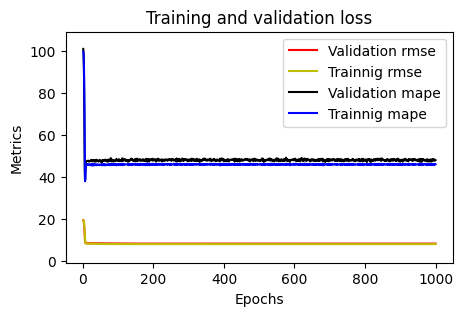

In [38]:
plotme(model2_2)

In [39]:
# # inputs: distance + hour
# model2_3 = nnmodel(10,15, num_hlayers=1,Epoch=500)
# model2_3

In [51]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,5, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 796720.3750 - distance_layer_loss: 0.1389 - traveltime_layer_loss: 1327867.0000 - distance_layer_mape: 98.3485 - distance_layer_rmse: 0.3727 - traveltime_layer_mape: 99.8162 - traveltime_layer_rmse: 1152.3311 - val_loss: 809365.5625 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1348942.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 99.6137 - val_traveltime_layer_rmse: 1161.4399
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 789741.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 1316235.3750 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 99.1450 - traveltime_layer_rmse: 1147.2731 - val_loss: 797967.1875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 1329945.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime

165/165 [==============================] - 0s 1ms/step - loss: 138260.0625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 230433.3594 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 45.9505 - traveltime_layer_rmse: 480.0348 - val_loss: 146410.0000 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 244016.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 46.8626 - val_traveltime_layer_rmse: 493.9803
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 137883.9688 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229806.5312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.2809 - traveltime_layer_rmse: 479.3814 - val_loss: 146215.2812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243692.0781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.31

Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 137622.8281 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229371.1875 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.1054 - traveltime_layer_rmse: 478.9271 - val_loss: 146134.4688 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243557.3750 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6104 - val_traveltime_layer_rmse: 493.5153
Epoch 33/500
165/165 [==============================] - 0s 1ms/step - loss: 137613.4531 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229355.6562 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9664 - traveltime_layer_rmse: 478.9109 - val_loss: 146133.6406 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243555.9531 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

Epoch 48/500
165/165 [==============================] - 0s 1ms/step - loss: 137614.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229357.1719 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8436 - traveltime_layer_rmse: 478.9125 - val_loss: 146132.5781 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243554.1719 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6072 - val_traveltime_layer_rmse: 493.5121
Epoch 49/500
165/165 [==============================] - 0s 1ms/step - loss: 137619.9531 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229366.5000 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9790 - traveltime_layer_rmse: 478.9222 - val_loss: 146130.4375 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243550.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

Epoch 64/500
165/165 [==============================] - 0s 1ms/step - loss: 137603.3125 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229338.6562 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9025 - traveltime_layer_rmse: 478.8932 - val_loss: 146127.6250 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243546.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5796 - val_traveltime_layer_rmse: 493.5038
Epoch 65/500
165/165 [==============================] - 0s 1ms/step - loss: 137631.0000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229384.8906 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.1207 - traveltime_layer_rmse: 478.9414 - val_loss: 146131.2969 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243552.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

Epoch 80/500
165/165 [==============================] - 0s 1ms/step - loss: 137640.9844 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229401.5312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0976 - traveltime_layer_rmse: 478.9588 - val_loss: 146099.5000 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243499.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.8488 - val_traveltime_layer_rmse: 493.4563
Epoch 81/500
165/165 [==============================] - 0s 1ms/step - loss: 137602.4531 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229337.3125 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7573 - traveltime_layer_rmse: 478.8918 - val_loss: 146104.2031 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243506.9688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

Epoch 96/500
165/165 [==============================] - 0s 1ms/step - loss: 137597.6406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229329.2812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8752 - traveltime_layer_rmse: 478.8834 - val_loss: 146122.4688 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243537.3906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4511 - val_traveltime_layer_rmse: 493.4951
Epoch 97/500
165/165 [==============================] - 0s 1ms/step - loss: 137608.1250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229346.8125 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7448 - traveltime_layer_rmse: 478.9017 - val_loss: 146102.2656 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243503.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_laye

165/165 [==============================] - 0s 1ms/step - loss: 137626.6875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229377.7812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8311 - traveltime_layer_rmse: 478.9340 - val_loss: 146119.7188 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243532.7188 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4621 - val_traveltime_layer_rmse: 493.4904
Epoch 112/500
165/165 [==============================] - 0s 1ms/step - loss: 137603.2812 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229338.6562 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.6614 - traveltime_layer_rmse: 478.8932 - val_loss: 146078.7344 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243464.4375 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.8

Epoch 127/500
165/165 [==============================] - 0s 1ms/step - loss: 137597.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229328.8594 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0810 - traveltime_layer_rmse: 478.8829 - val_loss: 146121.2031 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243535.1562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.3089 - val_traveltime_layer_rmse: 493.4928
Epoch 128/500
165/165 [==============================] - 0s 1ms/step - loss: 137608.7500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229347.7188 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8356 - traveltime_layer_rmse: 478.9026 - val_loss: 146106.4688 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243510.6719 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137599.6406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229332.5781 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9342 - traveltime_layer_rmse: 478.8868 - val_loss: 146097.3125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243495.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5586 - val_traveltime_layer_rmse: 493.4525
Epoch 143/500
165/165 [==============================] - 0s 1ms/step - loss: 137594.6250 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229324.1719 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9994 - traveltime_layer_rmse: 478.8780 - val_loss: 146104.6406 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243507.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4

Epoch 158/500
165/165 [==============================] - 0s 1ms/step - loss: 137590.5156 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229317.3906 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8257 - traveltime_layer_rmse: 478.8709 - val_loss: 146098.6719 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243497.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5688 - val_traveltime_layer_rmse: 493.4548
Epoch 159/500
165/165 [==============================] - 0s 1ms/step - loss: 137572.0156 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229286.5781 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7465 - traveltime_layer_rmse: 478.8388 - val_loss: 146091.8906 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243486.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137588.1094 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229313.4531 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7287 - traveltime_layer_rmse: 478.8669 - val_loss: 146104.5469 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243507.4531 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5517 - val_traveltime_layer_rmse: 493.4648
Epoch 174/500
165/165 [==============================] - 0s 1ms/step - loss: 137630.0469 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229383.3125 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0461 - traveltime_layer_rmse: 478.9398 - val_loss: 146108.6562 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243514.3906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4

Epoch 189/500
165/165 [==============================] - 0s 1ms/step - loss: 137579.2969 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229298.7031 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0279 - traveltime_layer_rmse: 478.8514 - val_loss: 146099.7031 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243499.4062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4202 - val_traveltime_layer_rmse: 493.4566
Epoch 190/500
165/165 [==============================] - 0s 1ms/step - loss: 137588.5781 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229314.3125 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0512 - traveltime_layer_rmse: 478.8677 - val_loss: 146127.8125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243546.2656 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137590.4375 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229317.1094 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8524 - traveltime_layer_rmse: 478.8707 - val_loss: 146068.9844 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243448.2344 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.7728 - val_traveltime_layer_rmse: 493.4047
Epoch 205/500
165/165 [==============================] - 0s 1ms/step - loss: 137582.0156 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229303.1875 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9230 - traveltime_layer_rmse: 478.8561 - val_loss: 146085.7031 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243476.0625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6

Epoch 220/500
165/165 [==============================] - 0s 1ms/step - loss: 137578.7812 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229297.7812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.2959 - traveltime_layer_rmse: 478.8505 - val_loss: 146126.7969 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243544.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.3299 - val_traveltime_layer_rmse: 493.5024
Epoch 221/500
165/165 [==============================] - 0s 1ms/step - loss: 137567.0781 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229278.3906 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.4984 - traveltime_layer_rmse: 478.8302 - val_loss: 146077.0469 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243461.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137586.9219 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229311.4219 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7578 - traveltime_layer_rmse: 478.8647 - val_loss: 146071.6406 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243452.6250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.9501 - val_traveltime_layer_rmse: 493.4092
Epoch 236/500
165/165 [==============================] - 0s 1ms/step - loss: 137580.3281 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229300.4844 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.2135 - traveltime_layer_rmse: 478.8533 - val_loss: 146098.9375 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243498.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4

Epoch 251/500
165/165 [==============================] - 0s 1ms/step - loss: 137573.2656 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229288.7656 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.6971 - traveltime_layer_rmse: 478.8411 - val_loss: 146067.5469 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243445.8281 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.7837 - val_traveltime_layer_rmse: 493.4023
Epoch 252/500
165/165 [==============================] - 0s 1ms/step - loss: 137600.0312 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229333.2812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.1361 - traveltime_layer_rmse: 478.8875 - val_loss: 146095.5625 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243492.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137571.1406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229285.0312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.1208 - traveltime_layer_rmse: 478.8372 - val_loss: 146086.5312 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243477.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4863 - val_traveltime_layer_rmse: 493.4344
Epoch 267/500
165/165 [==============================] - 0s 1ms/step - loss: 137574.0781 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229289.9688 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8169 - traveltime_layer_rmse: 478.8423 - val_loss: 146089.5312 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243482.5469 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 282/500
165/165 [==============================] - 0s 1ms/step - loss: 137586.7188 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229310.9844 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9995 - traveltime_layer_rmse: 478.8643 - val_loss: 146075.6719 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243459.3438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5714 - val_traveltime_layer_rmse: 493.4160
Epoch 283/500
165/165 [==============================] - 0s 1ms/step - loss: 137567.9531 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229279.7812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8780 - traveltime_layer_rmse: 478.8317 - val_loss: 146097.3438 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243495.4688 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137554.1406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229256.7969 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.2247 - traveltime_layer_rmse: 478.8077 - val_loss: 146107.0000 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243511.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.3027 - val_traveltime_layer_rmse: 493.4689
Epoch 298/500
165/165 [==============================] - 0s 1ms/step - loss: 137560.9844 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229268.2656 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.6246 - traveltime_layer_rmse: 478.8197 - val_loss: 146053.3281 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243422.0312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6

Epoch 313/500
165/165 [==============================] - 0s 1ms/step - loss: 137585.2812 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229308.6406 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.1366 - traveltime_layer_rmse: 478.8618 - val_loss: 146081.9375 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243469.8281 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5982 - val_traveltime_layer_rmse: 493.4266
Epoch 314/500
165/165 [==============================] - 0s 1ms/step - loss: 137554.6719 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229257.6875 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8581 - traveltime_layer_rmse: 478.8086 - val_loss: 146072.2031 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243453.6562 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137582.5000 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229303.9531 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.1569 - traveltime_layer_rmse: 478.8569 - val_loss: 146060.6719 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243434.2969 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5122 - val_traveltime_layer_rmse: 493.3906
Epoch 329/500
165/165 [==============================] - 0s 1ms/step - loss: 137572.1562 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229286.7969 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8906 - traveltime_layer_rmse: 478.8390 - val_loss: 146092.3594 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243487.1406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.3

Epoch 344/500
165/165 [==============================] - 0s 1ms/step - loss: 137550.9219 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229251.4062 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0672 - traveltime_layer_rmse: 478.8021 - val_loss: 146080.6250 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243467.6719 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4946 - val_traveltime_layer_rmse: 493.4244
Epoch 345/500
165/165 [==============================] - 0s 1ms/step - loss: 137531.4531 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229219.0312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7572 - traveltime_layer_rmse: 478.7682 - val_loss: 146053.3125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243422.0938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137543.1406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229238.4531 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9629 - traveltime_layer_rmse: 478.7885 - val_loss: 146106.2656 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243510.2812 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.2903 - val_traveltime_layer_rmse: 493.4676
Epoch 360/500
165/165 [==============================] - 0s 1ms/step - loss: 137558.2500 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229263.6719 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7585 - traveltime_layer_rmse: 478.8148 - val_loss: 146074.7812 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243457.8906 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4

Epoch 375/500
165/165 [==============================] - 0s 1ms/step - loss: 137528.0156 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229213.2812 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8945 - traveltime_layer_rmse: 478.7622 - val_loss: 146057.9219 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243429.7344 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6440 - val_traveltime_layer_rmse: 493.3860
Epoch 376/500
165/165 [==============================] - 0s 1ms/step - loss: 137543.2344 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229238.6719 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8165 - traveltime_layer_rmse: 478.7888 - val_loss: 146046.4062 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243410.5781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137542.5938 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229237.5469 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.1760 - traveltime_layer_rmse: 478.7876 - val_loss: 146067.3594 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243445.5156 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5516 - val_traveltime_layer_rmse: 493.4020
Epoch 391/500
165/165 [==============================] - 0s 1ms/step - loss: 137580.8594 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229301.3281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8255 - traveltime_layer_rmse: 478.8542 - val_loss: 146045.9531 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243409.8438 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.7

Epoch 406/500
165/165 [==============================] - 0s 1ms/step - loss: 137597.0312 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229328.3281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0003 - traveltime_layer_rmse: 478.8824 - val_loss: 146095.9688 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243493.0781 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.3439 - val_traveltime_layer_rmse: 493.4502
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 137543.6406 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229239.3281 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9805 - traveltime_layer_rmse: 478.7894 - val_loss: 146074.7500 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243457.8125 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137554.6875 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229257.6719 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8811 - traveltime_layer_rmse: 478.8086 - val_loss: 146051.8125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243419.5312 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6044 - val_traveltime_layer_rmse: 493.3756
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 137531.2031 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229218.5312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8995 - traveltime_layer_rmse: 478.7677 - val_loss: 146065.8281 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243442.9062 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.5

Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 137516.4062 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229193.8438 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9455 - traveltime_layer_rmse: 478.7419 - val_loss: 146057.8281 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243429.5938 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4894 - val_traveltime_layer_rmse: 493.3858
Epoch 438/500
165/165 [==============================] - 0s 1ms/step - loss: 137530.5625 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229217.4844 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8783 - traveltime_layer_rmse: 478.7666 - val_loss: 146071.7031 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243452.7344 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137523.0469 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229205.0469 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9772 - traveltime_layer_rmse: 478.7536 - val_loss: 146068.3438 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243447.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.3979 - val_traveltime_layer_rmse: 493.4036
Epoch 453/500
165/165 [==============================] - 0s 1ms/step - loss: 137523.6562 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229206.0156 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.9619 - traveltime_layer_rmse: 478.7546 - val_loss: 146070.7031 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243451.1250 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.4

Epoch 468/500
165/165 [==============================] - 0s 1ms/step - loss: 137533.0312 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229221.7031 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0287 - traveltime_layer_rmse: 478.7710 - val_loss: 146059.0469 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243431.6875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6111 - val_traveltime_layer_rmse: 493.3880
Epoch 469/500
165/165 [==============================] - 0s 1ms/step - loss: 137534.7656 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229224.5312 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8862 - traveltime_layer_rmse: 478.7740 - val_loss: 146055.0469 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243424.9844 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

165/165 [==============================] - 0s 1ms/step - loss: 137537.2812 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229228.6875 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.7252 - traveltime_layer_rmse: 478.7783 - val_loss: 146049.3125 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243415.4531 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6068 - val_traveltime_layer_rmse: 493.3715
Epoch 484/500
165/165 [==============================] - 0s 1ms/step - loss: 137559.7969 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229266.3438 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 47.0391 - traveltime_layer_rmse: 478.8177 - val_loss: 146080.4219 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243467.1875 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.3

Epoch 499/500
165/165 [==============================] - 0s 1ms/step - loss: 137532.3750 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229220.4688 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8309 - traveltime_layer_rmse: 478.7697 - val_loss: 146044.6875 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243407.6406 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_layer_mape: 47.6423 - val_traveltime_layer_rmse: 493.3636
Epoch 500/500
165/165 [==============================] - 0s 1ms/step - loss: 137540.7031 - distance_layer_loss: 0.1412 - traveltime_layer_loss: 229234.4219 - distance_layer_mape: 99.9810 - distance_layer_rmse: 0.3758 - traveltime_layer_mape: 46.8810 - traveltime_layer_rmse: 478.7843 - val_loss: 146053.5625 - val_distance_layer_loss: 0.1401 - val_traveltime_layer_loss: 243422.5625 - val_distance_layer_mape: 100.0000 - val_distance_layer_rmse: 0.3743 - val_traveltime_la

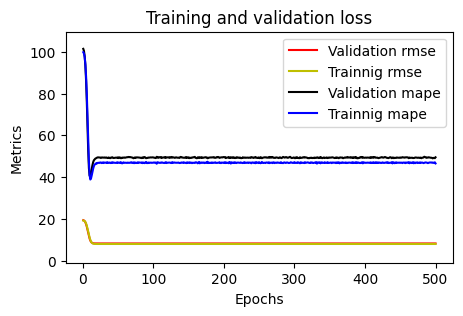

In [41]:
plotme(model2_4)

In [52]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,20, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
165/165 [==============================] - 1s 2ms/step - loss: 794319.1875 - distance_layer_loss: 1.5918 - traveltime_layer_loss: 1323864.5000 - distance_layer_mape: 207910.2500 - distance_layer_rmse: 1.2617 - traveltime_layer_mape: 99.6104 - traveltime_layer_rmse: 1150.5931 - val_loss: 793075.2500 - val_distance_layer_loss: 12.0876 - val_traveltime_layer_loss: 1321783.6250 - val_distance_layer_mape: 2258.3140 - val_distance_layer_rmse: 3.4767 - val_traveltime_layer_mape: 98.1290 - val_traveltime_layer_rmse: 1149.6885
Epoch 2/500
165/165 [==============================] - 0s 1ms/step - loss: 521324.8125 - distance_layer_loss: 268.6140 - traveltime_layer_loss: 868695.7500 - distance_layer_mape: 2000605.6250 - distance_layer_rmse: 16.3895 - traveltime_layer_mape: 70.4460 - traveltime_layer_rmse: 932.0385 - val_loss: 154346.2031 - val_distance_layer_loss: 806.8483 - val_traveltime_layer_loss: 256705.8125 - val_distance_layer_mape: 18128.3770 - val_distance_layer_rmse: 28.4051 

165/165 [==============================] - 0s 1ms/step - loss: 137150.1094 - distance_layer_loss: 751.9344 - traveltime_layer_loss: 228082.1719 - distance_layer_mape: 5628651.5000 - distance_layer_rmse: 27.4214 - traveltime_layer_mape: 45.8151 - traveltime_layer_rmse: 477.5795 - val_loss: 144425.7812 - val_distance_layer_loss: 747.3622 - val_traveltime_layer_loss: 240211.4375 - val_distance_layer_mape: 17674.9980 - val_distance_layer_rmse: 27.3379 - val_traveltime_layer_mape: 46.5896 - val_traveltime_layer_rmse: 490.1137
Epoch 17/500
165/165 [==============================] - 0s 1ms/step - loss: 136992.0312 - distance_layer_loss: 742.2864 - traveltime_layer_loss: 227825.2031 - distance_layer_mape: 5624168.0000 - distance_layer_rmse: 27.2449 - traveltime_layer_mape: 45.8621 - traveltime_layer_rmse: 477.3104 - val_loss: 144336.0781 - val_distance_layer_loss: 730.6646 - val_traveltime_layer_loss: 240072.9844 - val_distance_layer_mape: 17486.3711 - val_distance_layer_rmse: 27.0308 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 135478.5156 - distance_layer_loss: 611.1009 - traveltime_layer_loss: 225390.0156 - distance_layer_mape: 5183752.5000 - distance_layer_rmse: 24.7205 - traveltime_layer_mape: 45.6755 - traveltime_layer_rmse: 474.7526 - val_loss: 143441.8906 - val_distance_layer_loss: 604.1212 - val_traveltime_layer_loss: 238667.1094 - val_distance_layer_mape: 15976.2051 - val_distance_layer_rmse: 24.5789 - val_traveltime_layer_mape: 46.0535 - val_traveltime_layer_rmse: 488.5357
Epoch 32/500
165/165 [==============================] - 0s 1ms/step - loss: 135229.4062 - distance_layer_loss: 606.1462 - traveltime_layer_loss: 224978.3906 - distance_layer_mape: 5181745.5000 - distance_layer_rmse: 24.6200 - traveltime_layer_mape: 45.8206 - traveltime_layer_rmse: 474.3189 - val_loss: 143365.6406 - val_distance_layer_loss: 605.7130 - val_traveltime_layer_loss: 238538.9375 - val_distance_layer_mape: 15999.7578 - val_distance_layer_rmse: 24.6112 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 134899.0156 - distance_layer_loss: 543.0798 - traveltime_layer_loss: 224469.5312 - distance_layer_mape: 4829815.5000 - distance_layer_rmse: 23.3041 - traveltime_layer_mape: 46.0314 - traveltime_layer_rmse: 473.7822 - val_loss: 143406.1719 - val_distance_layer_loss: 530.6835 - val_traveltime_layer_loss: 238656.4844 - val_distance_layer_mape: 15004.5381 - val_distance_layer_rmse: 23.0366 - val_traveltime_layer_mape: 45.6683 - val_traveltime_layer_rmse: 488.5248
Epoch 47/500
165/165 [==============================] - 0s 1ms/step - loss: 134824.5469 - distance_layer_loss: 538.3428 - traveltime_layer_loss: 224348.6250 - distance_layer_mape: 4815733.0000 - distance_layer_rmse: 23.2022 - traveltime_layer_mape: 45.9258 - traveltime_layer_rmse: 473.6545 - val_loss: 143372.8906 - val_distance_layer_loss: 528.4053 - val_traveltime_layer_loss: 238602.6250 - val_distance_layer_mape: 14973.2217 - val_distance_layer_rmse: 22.9871 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 134748.5000 - distance_layer_loss: 503.4945 - traveltime_layer_loss: 224245.1875 - distance_layer_mape: 4656745.5000 - distance_layer_rmse: 22.4387 - traveltime_layer_mape: 45.8596 - traveltime_layer_rmse: 473.5453 - val_loss: 143188.2812 - val_distance_layer_loss: 506.3823 - val_traveltime_layer_loss: 238309.5312 - val_distance_layer_mape: 14665.7959 - val_distance_layer_rmse: 22.5029 - val_traveltime_layer_mape: 47.0102 - val_traveltime_layer_rmse: 488.1696
Epoch 62/500
165/165 [==============================] - 0s 1ms/step - loss: 134853.8750 - distance_layer_loss: 502.8889 - traveltime_layer_loss: 224421.2031 - distance_layer_mape: 4740423.0000 - distance_layer_rmse: 22.4252 - traveltime_layer_mape: 45.9597 - traveltime_layer_rmse: 473.7311 - val_loss: 143229.1406 - val_distance_layer_loss: 497.2073 - val_traveltime_layer_loss: 238383.7344 - val_distance_layer_mape: 14533.1572 - val_distance_layer_rmse: 22.2981 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 134740.8438 - distance_layer_loss: 483.3333 - traveltime_layer_loss: 224245.8750 - distance_layer_mape: 4674155.5000 - distance_layer_rmse: 21.9848 - traveltime_layer_mape: 46.2888 - traveltime_layer_rmse: 473.5461 - val_loss: 144344.2031 - val_distance_layer_loss: 459.3440 - val_traveltime_layer_loss: 240267.4531 - val_distance_layer_mape: 13975.2285 - val_distance_layer_rmse: 21.4323 - val_traveltime_layer_mape: 44.2600 - val_traveltime_layer_rmse: 490.1708
Epoch 77/500
165/165 [==============================] - 0s 1ms/step - loss: 134626.9688 - distance_layer_loss: 478.3955 - traveltime_layer_loss: 224059.2656 - distance_layer_mape: 4645696.0000 - distance_layer_rmse: 21.8723 - traveltime_layer_mape: 45.7793 - traveltime_layer_rmse: 473.3490 - val_loss: 143483.3750 - val_distance_layer_loss: 467.4488 - val_traveltime_layer_loss: 238827.2969 - val_distance_layer_mape: 14097.2168 - val_distance_layer_rmse: 21.6206 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 134762.8594 - distance_layer_loss: 461.5348 - traveltime_layer_loss: 224297.0625 - distance_layer_mape: 4492788.5000 - distance_layer_rmse: 21.4834 - traveltime_layer_mape: 46.0159 - traveltime_layer_rmse: 473.6001 - val_loss: 143125.9219 - val_distance_layer_loss: 459.3412 - val_traveltime_layer_loss: 238236.9531 - val_distance_layer_mape: 13974.2275 - val_distance_layer_rmse: 21.4322 - val_traveltime_layer_mape: 46.4759 - val_traveltime_layer_rmse: 488.0952
Epoch 92/500
165/165 [==============================] - 0s 1ms/step - loss: 134607.6719 - distance_layer_loss: 461.3257 - traveltime_layer_loss: 224038.6875 - distance_layer_mape: 4573553.5000 - distance_layer_rmse: 21.4785 - traveltime_layer_mape: 46.0733 - traveltime_layer_rmse: 473.3272 - val_loss: 143229.0469 - val_distance_layer_loss: 454.2092 - val_traveltime_layer_loss: 238412.3281 - val_distance_layer_mape: 13897.0986 - val_distance_layer_rmse: 21.3122 - val_tr

165/165 [==============================] - 0s 1ms/step - loss: 134657.6719 - distance_layer_loss: 445.4237 - traveltime_layer_loss: 224132.5000 - distance_layer_mape: 4505990.5000 - distance_layer_rmse: 21.1051 - traveltime_layer_mape: 46.0342 - traveltime_layer_rmse: 473.4263 - val_loss: 143503.8906 - val_distance_layer_loss: 433.7686 - val_traveltime_layer_loss: 238884.0156 - val_distance_layer_mape: 13583.0098 - val_distance_layer_rmse: 20.8271 - val_traveltime_layer_mape: 45.2836 - val_traveltime_layer_rmse: 488.7576
Epoch 107/500
165/165 [==============================] - 0s 1ms/step - loss: 134635.4062 - distance_layer_loss: 441.6446 - traveltime_layer_loss: 224097.9688 - distance_layer_mape: 4413404.5000 - distance_layer_rmse: 21.0153 - traveltime_layer_mape: 45.7566 - traveltime_layer_rmse: 473.3899 - val_loss: 143130.0312 - val_distance_layer_loss: 446.0505 - val_traveltime_layer_loss: 238252.6719 - val_distance_layer_mape: 13772.3906 - val_distance_layer_rmse: 21.1199 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134714.7344 - distance_layer_loss: 431.4688 - traveltime_layer_loss: 224236.8750 - distance_layer_mape: 4408588.0000 - distance_layer_rmse: 20.7718 - traveltime_layer_mape: 46.0886 - traveltime_layer_rmse: 473.5366 - val_loss: 143882.2188 - val_distance_layer_loss: 414.4592 - val_traveltime_layer_loss: 239527.3750 - val_distance_layer_mape: 13279.5537 - val_distance_layer_rmse: 20.3583 - val_traveltime_layer_mape: 44.7102 - val_traveltime_layer_rmse: 489.4153
Epoch 122/500
165/165 [==============================] - 0s 1ms/step - loss: 134674.6406 - distance_layer_loss: 428.9967 - traveltime_layer_loss: 224171.6406 - distance_layer_mape: 4280439.5000 - distance_layer_rmse: 20.7122 - traveltime_layer_mape: 45.9492 - traveltime_layer_rmse: 473.4677 - val_loss: 143146.8438 - val_distance_layer_loss: 425.5342 - val_traveltime_layer_loss: 238294.4062 - val_distance_layer_mape: 13454.2627 - val_distance_layer_rmse: 20.6285 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134568.3750 - distance_layer_loss: 418.5936 - traveltime_layer_loss: 224001.6250 - distance_layer_mape: 4360771.5000 - distance_layer_rmse: 20.4596 - traveltime_layer_mape: 46.1495 - traveltime_layer_rmse: 473.2881 - val_loss: 143658.7969 - val_distance_layer_loss: 403.7563 - val_traveltime_layer_loss: 239162.1094 - val_distance_layer_mape: 13107.7119 - val_distance_layer_rmse: 20.0937 - val_traveltime_layer_mape: 44.9885 - val_traveltime_layer_rmse: 489.0420
Epoch 137/500
165/165 [==============================] - 0s 1ms/step - loss: 134638.3906 - distance_layer_loss: 414.7814 - traveltime_layer_loss: 224120.7344 - distance_layer_mape: 4316505.5000 - distance_layer_rmse: 20.3662 - traveltime_layer_mape: 45.8206 - traveltime_layer_rmse: 473.4139 - val_loss: 143095.6094 - val_distance_layer_loss: 413.6831 - val_traveltime_layer_loss: 238216.8906 - val_distance_layer_mape: 13265.9883 - val_distance_layer_rmse: 20.3392 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134781.0469 - distance_layer_loss: 403.7084 - traveltime_layer_loss: 224365.9688 - distance_layer_mape: 4160468.7500 - distance_layer_rmse: 20.0925 - traveltime_layer_mape: 45.9314 - traveltime_layer_rmse: 473.6729 - val_loss: 143067.0625 - val_distance_layer_loss: 403.7746 - val_traveltime_layer_loss: 238175.9219 - val_distance_layer_mape: 13106.8770 - val_distance_layer_rmse: 20.0941 - val_traveltime_layer_mape: 46.6738 - val_traveltime_layer_rmse: 488.0327
Epoch 152/500
165/165 [==============================] - 0s 1ms/step - loss: 134608.9844 - distance_layer_loss: 403.4815 - traveltime_layer_loss: 224079.1875 - distance_layer_mape: 4259031.5000 - distance_layer_rmse: 20.0868 - traveltime_layer_mape: 45.9810 - traveltime_layer_rmse: 473.3700 - val_loss: 143116.5000 - val_distance_layer_loss: 399.4578 - val_traveltime_layer_loss: 238261.1719 - val_distance_layer_mape: 13037.4316 - val_distance_layer_rmse: 19.9864 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134578.1094 - distance_layer_loss: 393.0512 - traveltime_layer_loss: 224034.7031 - distance_layer_mape: 4143070.2500 - distance_layer_rmse: 19.8255 - traveltime_layer_mape: 46.0861 - traveltime_layer_rmse: 473.3230 - val_loss: 143579.7344 - val_distance_layer_loss: 380.4241 - val_traveltime_layer_loss: 239045.8906 - val_distance_layer_mape: 12725.8213 - val_distance_layer_rmse: 19.5045 - val_traveltime_layer_mape: 45.0741 - val_traveltime_layer_rmse: 488.9232
Epoch 167/500
165/165 [==============================] - 0s 1ms/step - loss: 134809.9844 - distance_layer_loss: 389.3882 - traveltime_layer_loss: 224423.6250 - distance_layer_mape: 4147176.7500 - distance_layer_rmse: 19.7329 - traveltime_layer_mape: 45.7561 - traveltime_layer_rmse: 473.7337 - val_loss: 143068.3438 - val_distance_layer_loss: 391.9716 - val_traveltime_layer_loss: 238185.9531 - val_distance_layer_mape: 12915.4297 - val_distance_layer_rmse: 19.7983 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134630.2188 - distance_layer_loss: 380.2875 - traveltime_layer_loss: 224130.3125 - distance_layer_mape: 4096465.0000 - distance_layer_rmse: 19.5010 - traveltime_layer_mape: 45.8115 - traveltime_layer_rmse: 473.4240 - val_loss: 143050.8438 - val_distance_layer_loss: 383.5475 - val_traveltime_layer_loss: 238162.4219 - val_distance_layer_mape: 12775.7910 - val_distance_layer_rmse: 19.5844 - val_traveltime_layer_mape: 47.0624 - val_traveltime_layer_rmse: 488.0189
Epoch 182/500
165/165 [==============================] - 0s 1ms/step - loss: 134462.3281 - distance_layer_loss: 381.0214 - traveltime_layer_loss: 223849.9062 - distance_layer_mape: 4160743.0000 - distance_layer_rmse: 19.5198 - traveltime_layer_mape: 46.0125 - traveltime_layer_rmse: 473.1278 - val_loss: 143426.0156 - val_distance_layer_loss: 370.9738 - val_traveltime_layer_loss: 238796.0156 - val_distance_layer_mape: 12567.0742 - val_distance_layer_rmse: 19.2607 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134702.6562 - distance_layer_loss: 371.7169 - traveltime_layer_loss: 224256.6250 - distance_layer_mape: 4037707.0000 - distance_layer_rmse: 19.2800 - traveltime_layer_mape: 46.1018 - traveltime_layer_rmse: 473.5574 - val_loss: 143200.9844 - val_distance_layer_loss: 364.9629 - val_traveltime_layer_loss: 238424.9375 - val_distance_layer_mape: 12466.0361 - val_distance_layer_rmse: 19.1040 - val_traveltime_layer_mape: 45.8238 - val_traveltime_layer_rmse: 488.2878
Epoch 197/500
165/165 [==============================] - 0s 1ms/step - loss: 134853.9219 - distance_layer_loss: 369.0964 - traveltime_layer_loss: 224510.3750 - distance_layer_mape: 3949120.5000 - distance_layer_rmse: 19.2119 - traveltime_layer_mape: 45.8028 - traveltime_layer_rmse: 473.8253 - val_loss: 143243.6250 - val_distance_layer_loss: 377.5791 - val_traveltime_layer_loss: 238487.6562 - val_distance_layer_mape: 12677.2461 - val_distance_layer_rmse: 19.4314 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134652.3750 - distance_layer_loss: 360.0000 - traveltime_layer_loss: 224180.5781 - distance_layer_mape: 3976851.2500 - distance_layer_rmse: 18.9737 - traveltime_layer_mape: 45.8316 - traveltime_layer_rmse: 473.4771 - val_loss: 143214.6406 - val_distance_layer_loss: 367.2653 - val_traveltime_layer_loss: 238446.1875 - val_distance_layer_mape: 12504.4404 - val_distance_layer_rmse: 19.1642 - val_traveltime_layer_mape: 47.7240 - val_traveltime_layer_rmse: 488.3095
Epoch 212/500
165/165 [==============================] - 0s 1ms/step - loss: 134674.3281 - distance_layer_loss: 360.3718 - traveltime_layer_loss: 224216.8281 - distance_layer_mape: 3980152.2500 - distance_layer_rmse: 18.9835 - traveltime_layer_mape: 46.0352 - traveltime_layer_rmse: 473.5154 - val_loss: 143053.4375 - val_distance_layer_loss: 358.8923 - val_traveltime_layer_loss: 238183.0938 - val_distance_layer_mape: 12362.3564 - val_distance_layer_rmse: 18.9445 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134754.8125 - distance_layer_loss: 352.7058 - traveltime_layer_loss: 224356.2031 - distance_layer_mape: 4030920.5000 - distance_layer_rmse: 18.7805 - traveltime_layer_mape: 46.1889 - traveltime_layer_rmse: 473.6625 - val_loss: 143074.7500 - val_distance_layer_loss: 348.3541 - val_traveltime_layer_loss: 238225.6719 - val_distance_layer_mape: 12180.5996 - val_distance_layer_rmse: 18.6642 - val_traveltime_layer_mape: 46.2431 - val_traveltime_layer_rmse: 488.0837
Epoch 227/500
165/165 [==============================] - 0s 1ms/step - loss: 134712.7188 - distance_layer_loss: 348.9603 - traveltime_layer_loss: 224288.3594 - distance_layer_mape: 3951183.2500 - distance_layer_rmse: 18.6805 - traveltime_layer_mape: 45.6962 - traveltime_layer_rmse: 473.5909 - val_loss: 143206.2812 - val_distance_layer_loss: 357.1490 - val_traveltime_layer_loss: 238438.9844 - val_distance_layer_mape: 12331.8818 - val_distance_layer_rmse: 18.8984 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134715.6406 - distance_layer_loss: 343.3248 - traveltime_layer_loss: 224297.0938 - distance_layer_mape: 3946091.2500 - distance_layer_rmse: 18.5290 - traveltime_layer_mape: 46.1500 - traveltime_layer_rmse: 473.6001 - val_loss: 145117.1250 - val_distance_layer_loss: 321.4304 - val_traveltime_layer_loss: 241647.5469 - val_distance_layer_mape: 11705.3916 - val_distance_layer_rmse: 17.9285 - val_traveltime_layer_mape: 43.5112 - val_traveltime_layer_rmse: 491.5766
Epoch 242/500
165/165 [==============================] - 0s 1ms/step - loss: 134733.5469 - distance_layer_loss: 341.0786 - traveltime_layer_loss: 224328.5781 - distance_layer_mape: 3898427.7500 - distance_layer_rmse: 18.4683 - traveltime_layer_mape: 45.7900 - traveltime_layer_rmse: 473.6334 - val_loss: 143256.2969 - val_distance_layer_loss: 335.0396 - val_traveltime_layer_loss: 238537.1250 - val_distance_layer_mape: 11947.5869 - val_distance_layer_rmse: 18.3041 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134633.2031 - distance_layer_loss: 335.2066 - traveltime_layer_loss: 224165.2500 - distance_layer_mape: 3794114.7500 - distance_layer_rmse: 18.3086 - traveltime_layer_mape: 46.1959 - traveltime_layer_rmse: 473.4609 - val_loss: 143602.4531 - val_distance_layer_loss: 323.0671 - val_traveltime_layer_loss: 239121.9688 - val_distance_layer_mape: 11733.9746 - val_distance_layer_rmse: 17.9741 - val_traveltime_layer_mape: 44.9811 - val_traveltime_layer_rmse: 489.0010
Epoch 257/500
165/165 [==============================] - 0s 1ms/step - loss: 134540.2031 - distance_layer_loss: 331.1164 - traveltime_layer_loss: 224012.9531 - distance_layer_mape: 3843928.7500 - distance_layer_rmse: 18.1966 - traveltime_layer_mape: 45.6116 - traveltime_layer_rmse: 473.3001 - val_loss: 143418.7031 - val_distance_layer_loss: 342.4818 - val_traveltime_layer_loss: 238802.8906 - val_distance_layer_mape: 12077.6787 - val_distance_layer_rmse: 18.5063 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134596.7344 - distance_layer_loss: 325.2378 - traveltime_layer_loss: 224110.9844 - distance_layer_mape: 3774203.5000 - distance_layer_rmse: 18.0343 - traveltime_layer_mape: 45.8653 - traveltime_layer_rmse: 473.4036 - val_loss: 143265.8906 - val_distance_layer_loss: 318.9040 - val_traveltime_layer_loss: 238563.8438 - val_distance_layer_mape: 11658.6367 - val_distance_layer_rmse: 17.8579 - val_traveltime_layer_mape: 45.5831 - val_traveltime_layer_rmse: 488.4300
Epoch 272/500
165/165 [==============================] - 0s 1ms/step - loss: 134658.5312 - distance_layer_loss: 325.3545 - traveltime_layer_loss: 224213.9219 - distance_layer_mape: 3791468.0000 - distance_layer_rmse: 18.0376 - traveltime_layer_mape: 46.0966 - traveltime_layer_rmse: 473.5123 - val_loss: 143548.8594 - val_distance_layer_loss: 314.8458 - val_traveltime_layer_loss: 239038.2188 - val_distance_layer_mape: 11584.7920 - val_distance_layer_rmse: 17.7439 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134672.4062 - distance_layer_loss: 317.7606 - traveltime_layer_loss: 224242.1250 - distance_layer_mape: 3748830.2500 - distance_layer_rmse: 17.8258 - traveltime_layer_mape: 45.9673 - traveltime_layer_rmse: 473.5421 - val_loss: 143351.9062 - val_distance_layer_loss: 310.3203 - val_traveltime_layer_loss: 238712.9531 - val_distance_layer_mape: 11501.9766 - val_distance_layer_rmse: 17.6159 - val_traveltime_layer_mape: 45.3873 - val_traveltime_layer_rmse: 488.5826
Epoch 287/500
165/165 [==============================] - 0s 1ms/step - loss: 134615.8125 - distance_layer_loss: 317.7139 - traveltime_layer_loss: 224147.9219 - distance_layer_mape: 3760325.5000 - distance_layer_rmse: 17.8245 - traveltime_layer_mape: 46.0101 - traveltime_layer_rmse: 473.4426 - val_loss: 143046.3750 - val_distance_layer_loss: 315.6416 - val_traveltime_layer_loss: 238200.1875 - val_distance_layer_mape: 11599.0479 - val_distance_layer_rmse: 17.7663 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134816.0312 - distance_layer_loss: 310.3732 - traveltime_layer_loss: 224486.4219 - distance_layer_mape: 3743416.0000 - distance_layer_rmse: 17.6174 - traveltime_layer_mape: 46.0095 - traveltime_layer_rmse: 473.8000 - val_loss: 143190.5625 - val_distance_layer_loss: 304.8280 - val_traveltime_layer_loss: 238447.7656 - val_distance_layer_mape: 11400.3115 - val_distance_layer_rmse: 17.4593 - val_traveltime_layer_mape: 45.7542 - val_traveltime_layer_rmse: 488.3111
Epoch 302/500
165/165 [==============================] - 0s 1ms/step - loss: 134578.8750 - distance_layer_loss: 309.5473 - traveltime_layer_loss: 224091.7969 - distance_layer_mape: 3680486.5000 - distance_layer_rmse: 17.5940 - traveltime_layer_mape: 45.9076 - traveltime_layer_rmse: 473.3834 - val_loss: 143018.3594 - val_distance_layer_loss: 309.0351 - val_traveltime_layer_loss: 238157.9062 - val_distance_layer_mape: 11477.6885 - val_distance_layer_rmse: 17.5794 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134805.8750 - distance_layer_loss: 303.1201 - traveltime_layer_loss: 224474.3438 - distance_layer_mape: 3679795.7500 - distance_layer_rmse: 17.4103 - traveltime_layer_mape: 45.9106 - traveltime_layer_rmse: 473.7872 - val_loss: 143009.1406 - val_distance_layer_loss: 304.6567 - val_traveltime_layer_loss: 238145.4688 - val_distance_layer_mape: 11396.4219 - val_distance_layer_rmse: 17.4544 - val_traveltime_layer_mape: 46.8920 - val_traveltime_layer_rmse: 488.0015
Epoch 317/500
165/165 [==============================] - 0s 1ms/step - loss: 134584.5469 - distance_layer_loss: 303.2959 - traveltime_layer_loss: 224105.3125 - distance_layer_mape: 3696598.5000 - distance_layer_rmse: 17.4154 - traveltime_layer_mape: 46.0136 - traveltime_layer_rmse: 473.3976 - val_loss: 143015.8594 - val_distance_layer_loss: 304.3601 - val_traveltime_layer_loss: 238156.7812 - val_distance_layer_mape: 11390.9072 - val_distance_layer_rmse: 17.4459 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134568.5781 - distance_layer_loss: 297.5324 - traveltime_layer_loss: 224082.5469 - distance_layer_mape: 3624853.5000 - distance_layer_rmse: 17.2491 - traveltime_layer_mape: 46.1435 - traveltime_layer_rmse: 473.3736 - val_loss: 143099.7031 - val_distance_layer_loss: 292.8307 - val_traveltime_layer_loss: 238304.3281 - val_distance_layer_mape: 11175.1270 - val_distance_layer_rmse: 17.1123 - val_traveltime_layer_mape: 45.9945 - val_traveltime_layer_rmse: 488.1642
Epoch 332/500
165/165 [==============================] - 0s 1ms/step - loss: 134755.0312 - distance_layer_loss: 294.7410 - traveltime_layer_loss: 224395.3281 - distance_layer_mape: 3569590.2500 - distance_layer_rmse: 17.1680 - traveltime_layer_mape: 45.8227 - traveltime_layer_rmse: 473.7038 - val_loss: 143171.7344 - val_distance_layer_loss: 290.7552 - val_traveltime_layer_loss: 238425.7188 - val_distance_layer_mape: 11135.8496 - val_distance_layer_rmse: 17.0515 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134497.6719 - distance_layer_loss: 288.8973 - traveltime_layer_loss: 223970.2188 - distance_layer_mape: 3561034.2500 - distance_layer_rmse: 16.9970 - traveltime_layer_mape: 45.7628 - traveltime_layer_rmse: 473.2549 - val_loss: 143376.4219 - val_distance_layer_loss: 298.0513 - val_traveltime_layer_loss: 238762.0156 - val_distance_layer_mape: 11272.7109 - val_distance_layer_rmse: 17.2642 - val_traveltime_layer_mape: 48.2534 - val_traveltime_layer_rmse: 488.6328
Epoch 347/500
165/165 [==============================] - 0s 1ms/step - loss: 134700.2500 - distance_layer_loss: 288.7864 - traveltime_layer_loss: 224307.7969 - distance_layer_mape: 3515556.0000 - distance_layer_rmse: 16.9937 - traveltime_layer_mape: 46.0070 - traveltime_layer_rmse: 473.6115 - val_loss: 143142.1875 - val_distance_layer_loss: 293.9258 - val_traveltime_layer_loss: 238374.3281 - val_distance_layer_mape: 11195.7119 - val_distance_layer_rmse: 17.1443 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134756.4531 - distance_layer_loss: 282.4271 - traveltime_layer_loss: 224405.9219 - distance_layer_mape: 3546250.7500 - distance_layer_rmse: 16.8056 - traveltime_layer_mape: 45.7534 - traveltime_layer_rmse: 473.7150 - val_loss: 143277.9688 - val_distance_layer_loss: 290.4199 - val_traveltime_layer_loss: 238602.9375 - val_distance_layer_mape: 11129.0146 - val_distance_layer_rmse: 17.0417 - val_traveltime_layer_mape: 48.0204 - val_traveltime_layer_rmse: 488.4700
Epoch 362/500
165/165 [==============================] - 0s 1ms/step - loss: 134624.0938 - distance_layer_loss: 283.2671 - traveltime_layer_loss: 224184.6562 - distance_layer_mape: 3502897.2500 - distance_layer_rmse: 16.8305 - traveltime_layer_mape: 46.0572 - traveltime_layer_rmse: 473.4814 - val_loss: 143003.6094 - val_distance_layer_loss: 283.2675 - val_traveltime_layer_loss: 238150.4375 - val_distance_layer_mape: 10992.6357 - val_distance_layer_rmse: 16.8306 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134590.9688 - distance_layer_loss: 277.0696 - traveltime_layer_loss: 224133.6406 - distance_layer_mape: 3478763.5000 - distance_layer_rmse: 16.6454 - traveltime_layer_mape: 45.9041 - traveltime_layer_rmse: 473.4276 - val_loss: 143018.3750 - val_distance_layer_loss: 279.6815 - val_traveltime_layer_loss: 238177.5469 - val_distance_layer_mape: 10923.1660 - val_distance_layer_rmse: 16.7237 - val_traveltime_layer_mape: 47.0519 - val_traveltime_layer_rmse: 488.0344
Epoch 377/500
165/165 [==============================] - 0s 1ms/step - loss: 134532.7656 - distance_layer_loss: 276.9696 - traveltime_layer_loss: 224036.6094 - distance_layer_mape: 3466810.7500 - distance_layer_rmse: 16.6424 - traveltime_layer_mape: 45.8050 - traveltime_layer_rmse: 473.3250 - val_loss: 143313.4062 - val_distance_layer_loss: 284.9041 - val_traveltime_layer_loss: 238665.6562 - val_distance_layer_mape: 11023.1709 - val_distance_layer_rmse: 16.8791 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134524.4688 - distance_layer_loss: 271.2623 - traveltime_layer_loss: 224026.5156 - distance_layer_mape: 3440699.5000 - distance_layer_rmse: 16.4700 - traveltime_layer_mape: 45.8155 - traveltime_layer_rmse: 473.3144 - val_loss: 143004.4688 - val_distance_layer_loss: 272.9195 - val_traveltime_layer_loss: 238158.8125 - val_distance_layer_mape: 10791.6152 - val_distance_layer_rmse: 16.5203 - val_traveltime_layer_mape: 46.8900 - val_traveltime_layer_rmse: 488.0152
Epoch 392/500
165/165 [==============================] - 0s 1ms/step - loss: 134425.5312 - distance_layer_loss: 271.9238 - traveltime_layer_loss: 223861.2344 - distance_layer_mape: 3529889.7500 - distance_layer_rmse: 16.4901 - traveltime_layer_mape: 46.0179 - traveltime_layer_rmse: 473.1398 - val_loss: 143449.6719 - val_distance_layer_loss: 263.6614 - val_traveltime_layer_loss: 238907.0156 - val_distance_layer_mape: 10608.7549 - val_distance_layer_rmse: 16.2377 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134518.3125 - distance_layer_loss: 266.2491 - traveltime_layer_loss: 224019.6875 - distance_layer_mape: 3452274.0000 - distance_layer_rmse: 16.3171 - traveltime_layer_mape: 45.8747 - traveltime_layer_rmse: 473.3072 - val_loss: 143042.1562 - val_distance_layer_loss: 269.2530 - val_traveltime_layer_loss: 238224.0625 - val_distance_layer_mape: 10719.2461 - val_distance_layer_rmse: 16.4089 - val_traveltime_layer_mape: 47.2526 - val_traveltime_layer_rmse: 488.0820
Epoch 407/500
165/165 [==============================] - 0s 1ms/step - loss: 134557.2500 - distance_layer_loss: 266.1156 - traveltime_layer_loss: 224084.6562 - distance_layer_mape: 3403603.7500 - distance_layer_rmse: 16.3130 - traveltime_layer_mape: 45.9222 - traveltime_layer_rmse: 473.3758 - val_loss: 143186.2344 - val_distance_layer_loss: 271.7238 - val_traveltime_layer_loss: 238462.5625 - val_distance_layer_mape: 10767.7451 - val_distance_layer_rmse: 16.4840 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134587.6094 - distance_layer_loss: 262.1469 - traveltime_layer_loss: 224137.8125 - distance_layer_mape: 3422837.0000 - distance_layer_rmse: 16.1910 - traveltime_layer_mape: 46.1426 - traveltime_layer_rmse: 473.4319 - val_loss: 143730.8125 - val_distance_layer_loss: 251.2800 - val_traveltime_layer_loss: 239383.7969 - val_distance_layer_mape: 10359.3496 - val_distance_layer_rmse: 15.8518 - val_traveltime_layer_mape: 44.7685 - val_traveltime_layer_rmse: 489.2686
Epoch 422/500
165/165 [==============================] - 0s 1ms/step - loss: 134567.4375 - distance_layer_loss: 260.1980 - traveltime_layer_loss: 224105.5781 - distance_layer_mape: 3415793.0000 - distance_layer_rmse: 16.1307 - traveltime_layer_mape: 45.8713 - traveltime_layer_rmse: 473.3979 - val_loss: 143203.2500 - val_distance_layer_loss: 255.7591 - val_traveltime_layer_loss: 238501.5938 - val_distance_layer_mape: 10450.2793 - val_distance_layer_rmse: 15.9925 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134723.7344 - distance_layer_loss: 256.7257 - traveltime_layer_loss: 224368.4062 - distance_layer_mape: 3328952.0000 - distance_layer_rmse: 16.0227 - traveltime_layer_mape: 46.1405 - traveltime_layer_rmse: 473.6754 - val_loss: 143245.2188 - val_distance_layer_loss: 250.3566 - val_traveltime_layer_loss: 238575.0938 - val_distance_layer_mape: 10339.8916 - val_distance_layer_rmse: 15.8227 - val_traveltime_layer_mape: 45.5325 - val_traveltime_layer_rmse: 488.4415
Epoch 437/500
165/165 [==============================] - 0s 1ms/step - loss: 134608.4062 - distance_layer_loss: 254.9902 - traveltime_layer_loss: 224177.3438 - distance_layer_mape: 3369734.7500 - distance_layer_rmse: 15.9684 - traveltime_layer_mape: 45.9166 - traveltime_layer_rmse: 473.4737 - val_loss: 143493.7188 - val_distance_layer_loss: 247.6230 - val_traveltime_layer_loss: 238991.1562 - val_distance_layer_mape: 10284.0391 - val_distance_layer_rmse: 15.7360 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134519.8750 - distance_layer_loss: 251.1230 - traveltime_layer_loss: 224032.3594 - distance_layer_mape: 3429177.7500 - distance_layer_rmse: 15.8469 - traveltime_layer_mape: 45.9310 - traveltime_layer_rmse: 473.3206 - val_loss: 143227.4375 - val_distance_layer_loss: 245.8210 - val_traveltime_layer_loss: 238548.5938 - val_distance_layer_mape: 10246.8330 - val_distance_layer_rmse: 15.6787 - val_traveltime_layer_mape: 45.5930 - val_traveltime_layer_rmse: 488.4144
Epoch 452/500
165/165 [==============================] - 0s 1ms/step - loss: 134590.0781 - distance_layer_loss: 250.0720 - traveltime_layer_loss: 224149.9375 - distance_layer_mape: 3346262.0000 - distance_layer_rmse: 15.8137 - traveltime_layer_mape: 45.8021 - traveltime_layer_rmse: 473.4448 - val_loss: 143074.5625 - val_distance_layer_loss: 247.7050 - val_traveltime_layer_loss: 238292.5156 - val_distance_layer_mape: 10285.4814 - val_distance_layer_rmse: 15.7386 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134513.9375 - distance_layer_loss: 246.5362 - traveltime_layer_loss: 224025.6562 - distance_layer_mape: 3326550.7500 - distance_layer_rmse: 15.7015 - traveltime_layer_mape: 46.0322 - traveltime_layer_rmse: 473.3135 - val_loss: 143774.7031 - val_distance_layer_loss: 236.4887 - val_traveltime_layer_loss: 239466.8906 - val_distance_layer_mape: 10052.6592 - val_distance_layer_rmse: 15.3782 - val_traveltime_layer_mape: 44.7106 - val_traveltime_layer_rmse: 489.3535
Epoch 467/500
165/165 [==============================] - 0s 1ms/step - loss: 134570.6094 - distance_layer_loss: 246.3905 - traveltime_layer_loss: 224120.0312 - distance_layer_mape: 3327129.2500 - distance_layer_rmse: 15.6968 - traveltime_layer_mape: 46.1202 - traveltime_layer_rmse: 473.4132 - val_loss: 144068.3594 - val_distance_layer_loss: 234.3305 - val_traveltime_layer_loss: 239957.7031 - val_distance_layer_mape: 10007.0996 - val_distance_layer_rmse: 15.3079 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134583.8281 - distance_layer_loss: 242.5790 - traveltime_layer_loss: 224144.5469 - distance_layer_mape: 3278851.0000 - distance_layer_rmse: 15.5749 - traveltime_layer_mape: 46.0974 - traveltime_layer_rmse: 473.4391 - val_loss: 143092.1406 - val_distance_layer_loss: 245.6046 - val_traveltime_layer_loss: 238323.1094 - val_distance_layer_mape: 10241.7100 - val_distance_layer_rmse: 15.6718 - val_traveltime_layer_mape: 47.5053 - val_traveltime_layer_rmse: 488.1835
Epoch 482/500
165/165 [==============================] - 0s 1ms/step - loss: 134580.5000 - distance_layer_loss: 240.7135 - traveltime_layer_loss: 224140.3750 - distance_layer_mape: 3326784.0000 - distance_layer_rmse: 15.5149 - traveltime_layer_mape: 45.8023 - traveltime_layer_rmse: 473.4347 - val_loss: 142989.5781 - val_distance_layer_loss: 240.9009 - val_traveltime_layer_loss: 238155.3281 - val_distance_layer_mape: 10144.2422 - val_distance_layer_rmse: 15.5210 - val_t

165/165 [==============================] - 0s 1ms/step - loss: 134598.3750 - distance_layer_loss: 236.4130 - traveltime_layer_loss: 224173.0000 - distance_layer_mape: 3266250.5000 - distance_layer_rmse: 15.3757 - traveltime_layer_mape: 45.8358 - traveltime_layer_rmse: 473.4691 - val_loss: 142983.4688 - val_distance_layer_loss: 238.0282 - val_traveltime_layer_loss: 238147.0938 - val_distance_layer_mape: 10084.0518 - val_distance_layer_rmse: 15.4282 - val_traveltime_layer_mape: 46.8802 - val_traveltime_layer_rmse: 488.0032
Epoch 497/500
165/165 [==============================] - 0s 1ms/step - loss: 134585.8906 - distance_layer_loss: 237.2338 - traveltime_layer_loss: 224151.5625 - distance_layer_mape: 3222670.0000 - distance_layer_rmse: 15.4024 - traveltime_layer_mape: 46.0601 - traveltime_layer_rmse: 473.4465 - val_loss: 143130.2344 - val_distance_layer_loss: 233.0494 - val_traveltime_layer_loss: 238395.0781 - val_distance_layer_mape: 9979.3203 - val_distance_layer_rmse: 15.2660 - val_tr